# Pairs Trading Analysis

This notebook implements a pairs trading strategy using cointegration analysis and the Caldeira-Moura trading rule. The strategy:
1. Selects cointegrated pairs from the IBX100 index
2. Simulates trading performance
3. Selects the best pairs based on Sharpe ratio
4. Runs backtests on the selected pairs
5. Generates comprehensive visualizations

## Import Required Libraries

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from persevera_tools.data import get_descriptors, get_index_composition, get_equities_info
from persevera_arbitrage.cointegration_approach.pairs_selection import CointegrationPairSelector, PairSelectionCriteria
from persevera_arbitrage.trading.zscore import CaldeiraMouraTradingRule, CaldeiraMouraConfig
from persevera_arbitrage.cointegration_approach.simulation import CointegrationSimulation
from persevera_arbitrage.cointegration_approach import EngleGrangerPortfolio
from persevera_arbitrage.trading import Backtester

## Load Market Data

In [7]:
dates = {
  "rebalance_date": [
    "2024-12-02",
    "2024-08-02",
    "2024-04-04",
    "2023-12-01",
    "2023-08-01",
    "2023-03-30",
    "2022-11-29",
    "2022-07-28",
    "2022-03-29",
    "2021-11-25",
    "2021-07-26",
    "2021-03-24",
    "2020-11-16",
    "2020-07-16",
    "2020-03-16",
    "2019-11-07",
    "2019-07-12",
    "2019-03-12",
    "2018-10-31",
    "2018-07-02",
    "2018-03-01",
    "2017-10-23",
    "2017-06-23",
    "2017-02-17",
    "2016-10-18",
    "2016-06-20",
    "2016-02-18",
    "2015-10-09",
    "2015-06-11"
  ],
  "training_start_date": [
    "2022-12-05",
    "2022-08-03",
    "2022-04-04",
    "2021-12-01",
    "2021-07-30",
    "2021-03-30",
    "2020-11-20",
    "2020-07-22",
    "2020-03-20",
    "2019-11-13",
    "2019-07-18",
    "2019-03-18",
    "2018-11-07",
    "2018-07-06",
    "2018-03-07",
    "2017-10-27",
    "2017-06-29",
    "2017-02-23",
    "2016-10-24",
    "2016-06-24",
    "2016-02-24",
    "2015-10-16",
    "2015-06-17",
    "2015-02-11",
    "2014-10-09",
    "2014-06-10",
    "2014-02-05",
    "2013-10-02",
    "2013-06-05"
  ],
  "testing_end_date": [
    "2025-03-21",
    "2024-12-02",
    "2024-08-02",
    "2024-04-04",
    "2023-12-01",
    "2023-08-01",
    "2023-03-30",
    "2022-11-29",
    "2022-07-28",
    "2022-03-29",
    "2021-11-25",
    "2021-07-26",
    "2021-03-24",
    "2020-11-16",
    "2020-07-16",
    "2020-03-16",
    "2019-11-07",
    "2019-07-12",
    "2019-03-12",
    "2018-10-31",
    "2018-07-02",
    "2018-03-01",
    "2017-10-23",
    "2017-06-23",
    "2017-02-17",
    "2016-10-18",
    "2016-06-20",
    "2016-02-18",
    "2015-10-09"
  ]
}

i = 0

In [3]:
# Get IBX100 composition
members = get_index_composition(index_code='IBX100', start_date=dates['rebalance_date'][i], end_date=dates['rebalance_date'][i])

# Load price data
price_data = get_descriptors(
    tickers=[*members.columns],
    descriptors='price_close',
    start_date=dates['training_start_date'][i],
    end_date=dates['rebalance_date'][i]
    )
price_data.dropna(axis=1, inplace=True)

2025-03-24 10:59:19.235 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-24 10:59:19.235 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-24 10:59:22.736 persevera_tools.db.operations: Query returned 100 rows in 1.42 seconds


2025-03-24 10:59:22.736 persevera_tools.db.operations: Query returned 100 rows in 1.42 seconds


2025-03-24 10:59:22.859 persevera_tools.db.operations: read_sql completed in 3.623s


2025-03-24 10:59:22.859 persevera_tools.db.operations: read_sql completed in 3.623s


2025-03-24 10:59:22.888 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-24 10:59:22.888 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-24 10:59:40.602 persevera_tools.db.operations: Query returned 25200 rows in 15.81 seconds


2025-03-24 10:59:40.602 persevera_tools.db.operations: Query returned 25200 rows in 15.81 seconds


2025-03-24 10:59:40.732 persevera_tools.db.operations: read_sql completed in 17.844s


2025-03-24 10:59:40.732 persevera_tools.db.operations: read_sql completed in 17.844s


## Find Cointegrated Pairs

In [4]:
# Create selector instance
selector = CointegrationPairSelector()

# Find best pairs
all_pairs = selector.select_pairs(price_data)

# Print pairs that passed all criteria
for pair in all_pairs:
    if pair.passed_all_criteria:
        print(f"\nPair: {pair.asset1} - {pair.asset2}")
        print(f"Half-life: {pair.half_life:.2f} days")
        print(f"Hurst exponent: {pair.hurst_exponent:.3f}")
        print(f"Hedge ratio: {pair.hedge_ratio:.3f}")

# Convert to DataFrame
results = pd.DataFrame(all_pairs)
results_passed = results[results['passed_all_criteria']].reset_index(drop=True)


Pair: ALOS3 - TOTS3
Half-life: 6.81 days
Hurst exponent: 0.245
Hedge ratio: 1.354

Pair: B3SA3 - PCAR3
Half-life: 7.34 days
Hurst exponent: 0.258
Hedge ratio: 3.509

Pair: BBAS3 - GMAT3
Half-life: 8.93 days
Hurst exponent: 0.465
Hedge ratio: 3.443

Pair: BBAS3 - SLCE3
Half-life: 10.50 days
Hurst exponent: 0.371
Hedge ratio: 0.710

Pair: BBAS3 - TIMS3
Half-life: 6.10 days
Hurst exponent: 0.324
Hedge ratio: 1.521

Pair: BBDC4 - DXCO3
Half-life: 8.60 days
Hurst exponent: 0.462
Hedge ratio: 0.563

Pair: BBDC4 - IRBR3
Half-life: 9.74 days
Hurst exponent: 0.405
Hedge ratio: 0.331

Pair: BBSE3 - ITSA4
Half-life: 8.69 days
Hurst exponent: 0.188
Hedge ratio: 0.288

Pair: BBSE3 - ITUB4
Half-life: 6.28 days
Hurst exponent: 0.177
Hedge ratio: 1.082

Pair: BBSE3 - PETZ3
Half-life: 10.88 days
Hurst exponent: 0.422
Hedge ratio: 7.674

Pair: BEEF3 - RADL3
Half-life: 8.31 days
Hurst exponent: 0.330
Hedge ratio: 3.963

Pair: BPAC11 - CCRO3
Half-life: 6.40 days
Hurst exponent: 0.242
Hedge ratio: 2.655



In [6]:
results_passed.to_clipboard()

In [ ]:
sectors = get_equities_info(codes=[*members.columns], fields='sector_layer_3')
results_passed['sector_asset1'] = results_passed['asset1'].map(sectors.to_dict()['sector_layer_3'])
results_passed['sector_asset2'] = results_passed['asset2'].map(sectors.to_dict()['sector_layer_3'])
results_passed['same_sector'] = (results_passed['sector_asset1'] == results_passed['sector_asset2'])

In [ ]:
results_passed['same_sector'].value_counts()
results_passed

## Simulate Trading Performance

In [ ]:
# Initialize DataFrame for simulation results
df = pd.DataFrame()

# Run simulations for each pair
for r in range(len(results_passed)):
    tickers = [results_passed.iloc[r].asset1, results_passed.iloc[r].asset2]
    price_data = get_descriptors(
        tickers=tickers,
        descriptors='price_close',
        start_date=dates['training_start_date'][i],
        end_date=dates['rebalance_date'][i]
        )

    eg = EngleGrangerPortfolio()
    res = eg.fit(price_data, dependent_variable=results_passed.iloc[r].asset1)
    historical_spread = res.residuals

    simulation = CointegrationSimulation(eg, n_periods=21*3, random_seed=40)
    sim = simulation.simulate_multiple_paths(n_paths=100)

    for s in range(len(sim)):
        simulated_spread = sim[s][1]
        simulated_prices = sim[s][0]

        config = CaldeiraMouraConfig(verbose=False)
        trading_rule = CaldeiraMouraTradingRule(config)

        signals, position_sizes = trading_rule.generate_signals(
            simulated_spread=simulated_spread,
            historical_spread=historical_spread,
            prices=simulated_prices,
        )

        simulation_results = trading_rule.get_portfolio_stats()
        simulation_results_df = pd.DataFrame(simulation_results, index=[0])
        simulation_results_df.insert(0, 'pair', '_'.join(tickers))
        df = pd.concat([df, simulation_results_df], axis=0, ignore_index=True)

## Select Best Pairs

Top 20 pairs by aggregate Sharpe Ratio are selected

In [ ]:
# Select top 20 pairs based on Sharpe ratio
selected_pairs = (df
 .groupby('pair')
 .agg({'annualized_return': 'median', 'annualized_volatility': 'median'})
 .eval('sharpe_ratio = (annualized_return - 0.11) / annualized_volatility')
 .query('sharpe_ratio > 0')
 .sort_values('sharpe_ratio', ascending=False)
 .head(20)
 )
 
selected_pairs['asset1'] = selected_pairs.index.str.split('_').str[0]
selected_pairs['asset2'] = selected_pairs.index.str.split('_').str[1]

# Display selected pairs
print("Selected Pairs:")
selected_pairs[['annualized_return', 'annualized_volatility', 'sharpe_ratio']]

## Run Backtests

In [ ]:
# Initialize DataFrame for backtest results
results_df = pd.DataFrame()
returns_df = pd.DataFrame()

# Run backtest for each pair
counter = 1
for ix, pair in selected_pairs.iterrows():
    print(f"\nBacktesting pair {counter}/{len(selected_pairs)}: {pair.asset1} - {pair.asset2}")
    
    testing_data = results_passed[(results_passed.asset1 == pair.asset1) & (results_passed.asset2 == pair.asset2)]
    hedge_ratio = testing_data['hedge_ratio'].values[0]
    half_life = testing_data['half_life'].values[0]
    hurst = testing_data['hurst_exponent'].values[0]

    # Get price data for this pair
    pair_data = get_descriptors(
        tickers=[pair.asset1, pair.asset2],
        descriptors='price_close',
        start_date=dates['training_start_date'][i],
        end_date=dates['testing_end_date'][i]
    )
    
    # Create backtester with default configuration
    config = CaldeiraMouraConfig()
    backtester = Backtester(config)
    
    # Run backtest
    backtest_results = backtester.run_backtest(
        price_data=pair_data,
        hedge_ratio=hedge_ratio,
        training_window=252,  # 1 year of data for training
    )
    
    # Extract key metrics
    metrics = {
        'pair': f"{pair.asset1}_{pair.asset2}",
        'half_life': half_life,
        'hurst': hurst,
        'hedge_ratio': hedge_ratio,
        'annualized_return': backtest_results['portfolio_stats']['annualized_return'],
        'annualized_volatility': backtest_results['portfolio_stats']['annualized_volatility'],
        'sharpe_ratio': backtest_results['portfolio_stats']['sharpe_ratio'],
        'max_drawdown': backtest_results['portfolio_stats']['max_drawdown'],
        'num_trades': backtest_results['portfolio_stats']['num_trades'],
        'win_rate': backtest_results['portfolio_stats']['win_rate']
    }
    
    # Add to results dataframe
    results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)
    returns_df = pd.merge(returns_df, backtest_results['equity_curve']['return'].to_frame(f"{pair.asset1}_{pair.asset2}"), left_index=True, right_index=True, how='outer')
    
    counter += 1

In [ ]:
((1 + returns_df.mean(axis=1)).cumprod() - 1).plot()
results_df

## Generate Visualizations

In [2]:
def plot_pair_analysis(backtest_results, pair, config, period_dir):
    """Generate comprehensive analysis plots for a trading pair"""
    if 'equity_curve' in backtest_results and not backtest_results['equity_curve'].empty:
        # Create a figure with subplots
        fig = plt.figure(figsize=(15, 15))
        
        # Asset Prices
        plt.subplot(4, 1, 1)
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        ax1.plot(backtest_results['equity_curve']['asset1_price'], 'b-', label=pair.asset1)
        ax2.plot(backtest_results['equity_curve']['asset2_price'], 'r-', label=pair.asset2)
        ax1.set_ylabel(f'{pair.asset1} Price', color='b')
        ax2.set_ylabel(f'{pair.asset2} Price', color='r')
        plt.title(f"Asset Prices: {pair.asset1} - {pair.asset2}")
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        ax1.grid(True)
        
        # Spread and Z-score
        plt.subplot(4, 1, 2)
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        if 'spread' in backtest_results:
            ax1.plot(backtest_results['spread'], 'b-', label='Spread')
        ax2.plot(backtest_results['equity_curve']['zscore'], 'r-', label='Z-score')
        ax1.set_ylabel('Spread', color='b')
        ax2.set_ylabel('Z-score', color='r')
        # Add horizontal lines for entry/exit thresholds
        ax2.axhline(y=config.entry_threshold, color='g', linestyle='--', alpha=0.7, label='Entry (Long)')
        ax2.axhline(y=-config.entry_threshold, color='g', linestyle='--', alpha=0.7, label='Entry (Short)')
        ax2.axhline(y=config.exit_threshold_short, color='m', linestyle='--', alpha=0.7, label='Exit Short')
        ax2.axhline(y=config.exit_threshold_long, color='m', linestyle='--', alpha=0.7, label='Exit Long')
        plt.title("Spread and Z-score")
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        ax1.grid(True)
        
        # Equity curve and Positions
        plt.subplot(4, 1, 3)
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        ax1.plot(backtest_results['equity_curve']['equity'], 'g-', label='Equity')
        # Change from line plot to area plot for positions
        ax2.fill_between(backtest_results['equity_curve'].index, 
                        backtest_results['equity_curve']['position'], 
                        0, 
                        where=backtest_results['equity_curve']['position'] >= 0,
                        color='blue', alpha=0.3, label='Long Position')
        ax2.fill_between(backtest_results['equity_curve'].index, 
                        backtest_results['equity_curve']['position'], 
                        0, 
                        where=backtest_results['equity_curve']['position'] <= 0,
                        color='red', alpha=0.3, label='Short Position')
        ax1.set_ylabel('Equity', color='g')
        ax2.set_ylabel('Position Size', color='b')
        ax2.set_ylim(-1.5, 1.5)
        plt.title("Strategy Performance")
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        ax1.grid(True)
        
        # Returns Distribution
        plt.subplot(4, 1, 4)
        returns = backtest_results['equity_curve']['equity'].pct_change().dropna()
        plt.hist(returns, bins=50, density=True, alpha=0.75)
        plt.title(f"Returns Distribution: {pair.asset1} - {pair.asset2}")
        plt.xlabel("Returns")
        plt.ylabel("Density")
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(period_dir, f"analysis_{pair.asset1}_{pair.asset2}.png"))
        plt.close()


## Loop the entire code

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from persevera_tools.data import get_descriptors, get_index_composition, get_equities_info
from persevera_arbitrage.cointegration_approach.pairs_selection import CointegrationPairSelector, PairSelectionCriteria
from persevera_arbitrage.trading.zscore import CaldeiraMouraTradingRule, CaldeiraMouraConfig
from persevera_arbitrage.cointegration_approach.simulation import CointegrationSimulation
from persevera_arbitrage.cointegration_approach import EngleGrangerPortfolio
from persevera_arbitrage.trading import Backtester

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Loop through each date period
all_results = []
all_returns = []

for i in range(len(dates['rebalance_date'])):
    print(f"\n{'='*80}")
    print(f"Processing Period {i+1}/{len(dates['rebalance_date'])}")
    print(f"Rebalance Date: {dates['rebalance_date'][i]}")
    print(f"Training Start: {dates['training_start_date'][i]}")
    print(f"Testing End: {dates['testing_end_date'][i]}")
    print(f"{'='*80}")
    
    # Create a directory for this period's results
    period_dir = os.path.join('results', f"period_{i+1}_{dates['rebalance_date'][i]}")
    os.makedirs(period_dir, exist_ok=True)
    
    try:
        # Get index composition
        members = get_index_composition(index_code='IBX100',
                                        start_date=dates['rebalance_date'][i], 
                                        end_date=dates['rebalance_date'][i])
        
        # Load price data
        print("Loading price data...")
        price_data = get_descriptors(
            tickers=[*members.columns],
            descriptors='price_close',
            start_date=dates['training_start_date'][i],
            end_date=dates['rebalance_date'][i]
        )
        price_data.dropna(axis=1, inplace=True)
        
        # Find cointegrated pairs
        print("Finding cointegrated pairs...")
        selector = CointegrationPairSelector()
        all_pairs = selector.select_pairs(price_data)
        
        # Convert to DataFrame
        results = pd.DataFrame(all_pairs)
        results_passed = results[results['passed_all_criteria']].reset_index(drop=True)

        sectors = get_equities_info(codes=[*members.columns], fields='sector_layer_3')
        results_passed['sector_asset1'] = results_passed['asset1'].map(sectors.to_dict()['sector_layer_3'])
        results_passed['sector_asset2'] = results_passed['asset2'].map(sectors.to_dict()['sector_layer_3'])
        results_passed['same_sector'] = (results_passed['sector_asset1'] == results_passed['sector_asset2'])
        
        # Save pairs that passed all criteria
        results_passed.to_csv(os.path.join(period_dir, 'cointegrated_pairs.csv'), index=False)
        
        print(f"Found {len(results_passed)} cointegrated pairs")
        
        # Simulate trading performance
        print("Simulating trading performance...")
        df = pd.DataFrame()
        
        # Run simulations for each pair
        for r in range(len(results_passed)):
            if r % 10 == 0:
                print(f"  Simulating pair {r+1}/{len(results_passed)}")
                
            tickers = [results_passed.iloc[r].asset1, results_passed.iloc[r].asset2]
            pair_price_data = get_descriptors(
                tickers=tickers,
                descriptors='price_close',
                start_date=dates['training_start_date'][i],
                end_date=dates['rebalance_date'][i]
            )
            
            eg = EngleGrangerPortfolio()
            res = eg.fit(pair_price_data, dependent_variable=results_passed.iloc[r].asset1)
            historical_spread = res.residuals
            
            simulation = CointegrationSimulation(eg, n_periods=21*4, random_seed=40)
            sim = simulation.simulate_multiple_paths(n_paths=100)
            
            for s in range(len(sim)):
                simulated_spread = sim[s][1]
                simulated_prices = sim[s][0]
                
                config = CaldeiraMouraConfig(verbose=False, max_holding_days=60, stop_loss=.04)
                trading_rule = CaldeiraMouraTradingRule(config)
                
                signals, position_sizes = trading_rule.generate_signals(
                    simulated_spread=simulated_spread,
                    historical_spread=historical_spread,
                    prices=simulated_prices,
                )
                
                simulation_results = trading_rule.get_portfolio_stats()
                simulation_results_df = pd.DataFrame(simulation_results, index=[0])
                simulation_results_df.insert(0, 'pair', '_'.join(tickers))
                simulation_results_df[['asset1', 'asset2']] = tickers
                simulation_results_df['same_sector'] = results_passed[(results_passed.asset1 == tickers[0]) & (results_passed.asset2 == tickers[1])]['same_sector'].values[0]
                df = pd.concat([df, simulation_results_df], axis=0, ignore_index=True)
        
        # Save simulation results
        df.to_csv(os.path.join(period_dir, 'simulation_results.csv'), index=False)
        
        # Select top 20 pairs based on Sharpe ratio       
        selected_pairs = (df
                          .groupby('pair')
                          .agg({'annualized_return': 'median', 'annualized_volatility': 'median', 'calmar_ratio': 'median'})
                          .eval(f'calmar_ratio = (annualized_return - {config.risk_free_rate}) / calmar_ratio')
                          .eval(f'sharpe_ratio = (annualized_return - {config.risk_free_rate}) / annualized_volatility')
                        #   .query('sharpe_ratio > 0')
                          .sort_values('calmar_ratio', ascending=False)
                          .head(10)
                        )

        selected_pairs['asset1'] = selected_pairs.index.str.split('_').str[0]
        selected_pairs['asset2'] = selected_pairs.index.str.split('_').str[1]
        
        # Save selected pairs
        selected_pairs.to_csv(os.path.join(period_dir, 'selected_pairs.csv'), index=True)
        
        print(f"Selected {len(selected_pairs)} best pairs")
        
        # Run backtests
        print("Running backtests...")
        results_df = pd.DataFrame()
        returns_df = pd.DataFrame()
        
        # Run backtest for each pair
        counter = 1
        for ix, pair in selected_pairs.iterrows():
            print(f"  Backtesting pair {counter}/{len(selected_pairs)}: {pair.asset1} - {pair.asset2}")
            
            testing_data = results_passed[(results_passed.asset1 == pair.asset1) & (results_passed.asset2 == pair.asset2)]
            hedge_ratio = testing_data['hedge_ratio'].values[0]
            half_life = testing_data['half_life'].values[0]
            hurst = testing_data['hurst_exponent'].values[0]
            
            # Get price data for this pair
            pair_data = get_descriptors(
                tickers=[pair.asset1, pair.asset2],
                descriptors='price_close',
                start_date=dates['training_start_date'][i],
                end_date=dates['testing_end_date'][i]
            )
            
            # Create backtester with default configuration
            config = CaldeiraMouraConfig(max_holding_days=60, stop_loss=.04)
            backtester = Backtester(config)
            
            # Run backtest
            backtest_results = backtester.run_backtest(
                price_data=pair_data,
                hedge_ratio=hedge_ratio,
                training_window=252,  # 1 year of data for training
            )
            
            # Extract key metrics
            metrics = {
                'pair': f"{pair.asset1}_{pair.asset2}",
                'period': i,
                'rebalance_date': dates['rebalance_date'][i],
                'half_life': half_life,
                'hurst': hurst,
                'hedge_ratio': hedge_ratio,
                'annualized_return': backtest_results['portfolio_stats']['annualized_return'],
                'annualized_volatility': backtest_results['portfolio_stats']['annualized_volatility'],
                'sharpe_ratio': backtest_results['portfolio_stats']['sharpe_ratio'],
                'max_drawdown': backtest_results['portfolio_stats']['max_drawdown'],
                'num_trades': backtest_results['portfolio_stats']['num_trades'],
                'win_rate': backtest_results['portfolio_stats']['win_rate']
            }
            
            # Add to results dataframe
            results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)
            
            # Track returns
            if 'return' in backtest_results['equity_curve']:
                returns_df = pd.merge(
                    returns_df, 
                    backtest_results['equity_curve']['return'].to_frame(f"{pair.asset1}_{pair.asset2}"), 
                    left_index=True, right_index=True, 
                    how='outer'
                )
            
            # Generate visualization
            plot_pair_analysis(backtest_results, pair, config, period_dir)
            
            counter += 1
        
        # Save backtest results
        results_df.to_csv(os.path.join(period_dir, 'backtest_results.csv'), index=False)
        returns_df.to_csv(os.path.join(period_dir, 'returns.csv'), index=True)
        
        # Plot aggregate returns
        if not returns_df.empty:
            plt.figure(figsize=(12, 8))
            ((1 + returns_df.mean(axis=1)).cumprod() - 1).plot()
            plt.title(f"Aggregate Returns - Period {i+1} ({dates['rebalance_date'][i]})")
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(period_dir, 'aggregate_returns.png'))
            plt.close()
        
        # Add results to overall results
        all_results.append(results_df)
        all_returns.append(returns_df)
        
        print(f"Period {i+1} processing complete.")
        
    except Exception as e:
        print(f"Error processing period {i+1}: {str(e)}")
        continue


Processing Period 1/15
Rebalance Date: 2024-12-02
Training Start: 2023-12-01
Testing End: 2025-03-20
2025-03-21 17:04:51.584 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 17:04:51.584 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 17:04:54.099 persevera_tools.db.operations: Query returned 100 rows in 0.65 seconds


2025-03-21 17:04:54.099 persevera_tools.db.operations: Query returned 100 rows in 0.65 seconds


2025-03-21 17:04:54.219 persevera_tools.db.operations: read_sql completed in 2.635s


2025-03-21 17:04:54.219 persevera_tools.db.operations: read_sql completed in 2.635s


Loading price data...
2025-03-21 17:04:54.243 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:04:54.243 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:05:01.119 persevera_tools.db.operations: Query returned 25200 rows in 5.16 seconds


2025-03-21 17:05:01.119 persevera_tools.db.operations: Query returned 25200 rows in 5.16 seconds


2025-03-21 17:05:01.235 persevera_tools.db.operations: read_sql completed in 6.992s


2025-03-21 17:05:01.235 persevera_tools.db.operations: read_sql completed in 6.992s


Finding cointegrated pairs...
2025-03-21 17:08:01.927 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 17:08:01.927 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 17:08:03.933 persevera_tools.db.operations: Query returned 100 rows in 0.23 seconds


2025-03-21 17:08:03.933 persevera_tools.db.operations: Query returned 100 rows in 0.23 seconds


2025-03-21 17:08:04.054 persevera_tools.db.operations: read_sql completed in 2.127s


2025-03-21 17:08:04.054 persevera_tools.db.operations: read_sql completed in 2.127s


Found 84 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/84
2025-03-21 17:08:04.093 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:04.093 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:06.182 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:08:06.182 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:08:06.297 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:08:06.297 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:08:08.513 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:08.513 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:10.618 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:08:10.618 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:08:10.742 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 17:08:10.742 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 17:08:13.523 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:13.523 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:15.588 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:08:15.588 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:08:15.708 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:08:15.708 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:08:17.784 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:17.784 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:19.878 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:08:19.878 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:08:19.990 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:08:19.990 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:08:22.135 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:22.135 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:24.216 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:08:24.216 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:08:24.330 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 17:08:24.330 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 17:08:26.614 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:26.614 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:28.687 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:08:28.687 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:08:28.810 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:08:28.810 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:08:31.220 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:31.220 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:33.314 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:08:33.314 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:08:33.427 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:08:33.427 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:08:35.739 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:35.739 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:37.831 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:08:37.831 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:08:37.934 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:08:37.934 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:08:40.764 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:40.764 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:42.836 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:08:42.836 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:08:42.953 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 17:08:42.953 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 17:08:45.639 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:45.639 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:47.709 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:08:47.709 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:08:47.826 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:08:47.826 persevera_tools.db.operations: read_sql completed in 2.188s


  Simulating pair 11/84
2025-03-21 17:08:49.825 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:49.825 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:51.906 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:08:51.906 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:08:52.033 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:08:52.033 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:08:53.986 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:53.986 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:56.049 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:08:56.049 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:08:56.175 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 17:08:56.175 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 17:08:58.549 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:08:58.549 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:00.632 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:00.632 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:00.748 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:09:00.748 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:09:02.982 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:02.982 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:05.079 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:09:05.079 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:09:05.191 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:09:05.191 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:09:07.229 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:07.229 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:09.316 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:09:09.316 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:09:09.432 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:09:09.432 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:09:11.549 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:11.549 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:13.653 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:13.653 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:13.774 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 17:09:13.774 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 17:09:16.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:16.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:18.671 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:18.671 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:18.783 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:09:18.783 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:09:20.846 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:20.846 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:22.931 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:22.931 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:23.050 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:09:23.050 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:09:25.460 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:25.460 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:27.541 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:09:27.541 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:09:27.675 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:09:27.675 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:09:29.973 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:29.973 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:32.057 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:32.057 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:32.171 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 17:09:32.171 persevera_tools.db.operations: read_sql completed in 2.198s


  Simulating pair 21/84
2025-03-21 17:09:34.384 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:34.384 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:36.455 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:36.455 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:36.572 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:09:36.572 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:09:38.730 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:38.730 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:40.799 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:40.799 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:40.916 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:09:40.916 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:09:43.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:43.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:45.297 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:09:45.297 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:09:45.409 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:09:45.409 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:09:47.559 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:47.559 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:49.653 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:49.653 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:49.773 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 17:09:49.773 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 17:09:52.420 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:52.420 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:09:54.509 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:54.509 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:09:54.625 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 17:09:54.625 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 17:10:01.992 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:01.992 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:04.074 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:10:04.074 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:10:04.192 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:10:04.192 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:10:06.609 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:06.609 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:08.686 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:10:08.686 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:10:08.802 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:10:08.802 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:10:13.583 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:13.583 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:15.701 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:10:15.701 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:10:15.818 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 17:10:15.818 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 17:10:18.157 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:18.157 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:20.211 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:10:20.211 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:10:20.345 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:10:20.345 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:10:22.874 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:22.874 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:24.938 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:10:24.938 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:10:25.055 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 17:10:25.055 persevera_tools.db.operations: read_sql completed in 2.180s


  Simulating pair 31/84
2025-03-21 17:10:28.088 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:28.088 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:30.234 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:10:30.234 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:10:30.354 persevera_tools.db.operations: read_sql completed in 2.266s


2025-03-21 17:10:30.354 persevera_tools.db.operations: read_sql completed in 2.266s


2025-03-21 17:10:33.614 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:33.614 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:35.675 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:10:35.675 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:10:35.784 persevera_tools.db.operations: read_sql completed in 2.170s


2025-03-21 17:10:35.784 persevera_tools.db.operations: read_sql completed in 2.170s


2025-03-21 17:10:38.463 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:38.463 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:40.550 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:10:40.550 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:10:40.669 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:10:40.669 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:10:45.609 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:45.609 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:47.693 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:10:47.693 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:10:47.807 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 17:10:47.807 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 17:10:51.916 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:51.916 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:53.965 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:10:53.965 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:10:54.083 persevera_tools.db.operations: read_sql completed in 2.167s


2025-03-21 17:10:54.083 persevera_tools.db.operations: read_sql completed in 2.167s


2025-03-21 17:10:58.080 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:10:58.080 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:00.159 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:00.159 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:00.276 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:11:00.276 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:11:04.145 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:04.145 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:06.233 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:11:06.233 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:11:06.351 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:11:06.351 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:11:09.498 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:09.498 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:11.589 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:11.589 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:11.701 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:11:11.701 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:11:13.864 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:13.864 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:15.964 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:15.964 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:16.091 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 17:11:16.091 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 17:11:18.644 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:18.644 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:20.733 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:20.733 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:20.845 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:11:20.845 persevera_tools.db.operations: read_sql completed in 2.200s


  Simulating pair 41/84
2025-03-21 17:11:22.803 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:22.803 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:24.885 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:24.885 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:25.002 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:11:25.002 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:11:27.060 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:27.060 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:29.152 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:11:29.152 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:11:29.270 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:11:29.270 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:11:31.291 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:31.291 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:33.363 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:11:33.363 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:11:33.480 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 17:11:33.480 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 17:11:35.749 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:35.749 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:37.827 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:37.827 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:37.945 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:11:37.945 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:11:40.287 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:40.287 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:42.367 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:11:42.367 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:11:42.469 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:11:42.469 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:11:44.871 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:44.871 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:46.942 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:46.942 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:11:47.056 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:11:47.056 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:11:50.513 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:50.513 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:52.578 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:11:52.578 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:11:52.701 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 17:11:52.701 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 17:11:55.926 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:55.926 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:11:58.020 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:11:58.020 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:11:58.138 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 17:11:58.138 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 17:12:00.403 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:00.403 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:02.480 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:12:02.480 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:12:02.601 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 17:12:02.601 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 17:12:05.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:05.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:07.347 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:12:07.347 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:12:07.481 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 17:12:07.481 persevera_tools.db.operations: read_sql completed in 2.190s


  Simulating pair 51/84
2025-03-21 17:12:09.878 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:09.878 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:11.944 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:12:11.944 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:12:12.064 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:12:12.064 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:12:15.412 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:15.412 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:17.487 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:12:17.487 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:12:17.604 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 17:12:17.604 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 17:12:20.102 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:20.102 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:22.185 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:12:22.185 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:12:22.319 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 17:12:22.319 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 17:12:24.398 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:24.398 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:26.503 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:12:26.503 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:12:26.679 persevera_tools.db.operations: read_sql completed in 2.281s


2025-03-21 17:12:26.679 persevera_tools.db.operations: read_sql completed in 2.281s


2025-03-21 17:12:32.341 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:32.341 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:34.415 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:12:34.415 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:12:34.529 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 17:12:34.529 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 17:12:36.816 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:36.816 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:38.898 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:12:38.898 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:12:39.006 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 17:12:39.006 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 17:12:41.823 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:41.823 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:43.877 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:12:43.877 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:12:43.985 persevera_tools.db.operations: read_sql completed in 2.162s


2025-03-21 17:12:43.985 persevera_tools.db.operations: read_sql completed in 2.162s


2025-03-21 17:12:47.289 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:47.289 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:49.350 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:12:49.350 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:12:49.467 persevera_tools.db.operations: read_sql completed in 2.178s


2025-03-21 17:12:49.467 persevera_tools.db.operations: read_sql completed in 2.178s


2025-03-21 17:12:52.433 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:52.433 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:54.489 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:12:54.489 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:12:54.608 persevera_tools.db.operations: read_sql completed in 2.175s


2025-03-21 17:12:54.608 persevera_tools.db.operations: read_sql completed in 2.175s


2025-03-21 17:12:58.101 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:12:58.101 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:00.230 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:13:00.230 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:13:00.338 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 17:13:00.338 persevera_tools.db.operations: read_sql completed in 2.237s


  Simulating pair 61/84
2025-03-21 17:13:02.470 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:02.470 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:04.552 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:13:04.552 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:13:04.666 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:13:04.666 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:13:06.697 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:06.697 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:08.781 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:08.781 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:08.900 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:13:08.900 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:13:10.993 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:10.993 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:13.056 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:13.056 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:13.172 persevera_tools.db.operations: read_sql completed in 2.179s


2025-03-21 17:13:13.172 persevera_tools.db.operations: read_sql completed in 2.179s


2025-03-21 17:13:16.624 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:16.624 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:18.704 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:18.704 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:18.832 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 17:13:18.832 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 17:13:20.897 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:20.897 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:23.012 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:13:23.012 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:13:23.130 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 17:13:23.130 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 17:13:25.276 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:25.276 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:27.380 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:13:27.380 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:13:27.491 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 17:13:27.491 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 17:13:29.773 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:29.773 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:31.889 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:31.889 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:32.007 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 17:13:32.007 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 17:13:34.071 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:34.071 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:36.146 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:36.146 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:36.267 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:13:36.267 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:13:38.315 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:38.315 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:40.397 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:40.397 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:40.514 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:13:40.514 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:13:43.360 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:43.360 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:45.429 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:45.429 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:45.544 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:13:45.544 persevera_tools.db.operations: read_sql completed in 2.183s


  Simulating pair 71/84
2025-03-21 17:13:48.141 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:48.141 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:50.200 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:50.200 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:50.318 persevera_tools.db.operations: read_sql completed in 2.177s


2025-03-21 17:13:50.318 persevera_tools.db.operations: read_sql completed in 2.177s


2025-03-21 17:13:53.085 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:53.085 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:55.133 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:55.133 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:13:55.254 persevera_tools.db.operations: read_sql completed in 2.169s


2025-03-21 17:13:55.254 persevera_tools.db.operations: read_sql completed in 2.169s


2025-03-21 17:13:58.095 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:13:58.095 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:00.200 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:14:00.200 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:14:00.315 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:14:00.315 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:14:02.760 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:02.760 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:04.842 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:14:04.842 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:14:04.959 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:14:04.959 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:14:07.457 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:07.457 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:09.547 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:14:09.547 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:14:09.663 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:14:09.663 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:14:11.656 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:11.656 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:13.753 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:14:13.753 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:14:13.878 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 17:14:13.878 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 17:14:16.048 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:16.048 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:18.133 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:14:18.133 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:14:18.249 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:14:18.249 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:14:20.197 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:20.197 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:22.281 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:14:22.281 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:14:22.403 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:14:22.403 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:14:24.783 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:24.783 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:26.858 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:14:26.858 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:14:26.973 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 17:14:26.973 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 17:14:30.190 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:30.190 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:32.269 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:14:32.269 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:14:32.888 persevera_tools.db.operations: read_sql completed in 2.699s


2025-03-21 17:14:32.888 persevera_tools.db.operations: read_sql completed in 2.699s


  Simulating pair 81/84
2025-03-21 17:14:38.292 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:38.292 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:40.364 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:14:40.364 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:14:40.477 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 17:14:40.477 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 17:14:45.771 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:45.771 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:47.836 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:14:47.836 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:14:47.955 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:14:47.955 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:14:53.333 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:53.333 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:55.405 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:14:55.405 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:14:55.519 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:14:55.519 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:14:59.386 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:14:59.386 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:01.503 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:15:01.503 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:15:01.620 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 17:15:01.620 persevera_tools.db.operations: read_sql completed in 2.226s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: ECOR3 - PCAR3
2025-03-21 17:15:05.097 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:05.097 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:07.346 persevera_tools.db.operations: Query returned 648 rows in 0.51 seconds


2025-03-21 17:15:07.346 persevera_tools.db.operations: Query returned 648 rows in 0.51 seconds


2025-03-21 17:15:07.463 persevera_tools.db.operations: read_sql completed in 2.366s


2025-03-21 17:15:07.463 persevera_tools.db.operations: read_sql completed in 2.366s
2025-03-21 17:15:07.489 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:15:07.491 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:15:07.494 persevera_arbitrage.trading.zscore: Stored historical spread data for ECOR3_PCAR3 with 252 data points
2025-03-21 17:15:07.495 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ECOR3_PCAR3
2025-03-21 17:15:07.508 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for ECOR3_PCAR3. Z-score: -1.00
2025-03-21 17:15:07.511 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for ECOR3_PCAR3. Z-score: -1.05
2025-03-21 17:15:07.513 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for ECOR3_PCAR3. Z-score: -0.92
2025-03-21 17:15:07.516 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

  Backtesting pair 2/10: MOVI3 - PCAR3
2025-03-21 17:15:10.565 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:10.565 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:12.714 persevera_tools.db.operations: Query returned 648 rows in 0.40 seconds


2025-03-21 17:15:12.714 persevera_tools.db.operations: Query returned 648 rows in 0.40 seconds


2025-03-21 17:15:12.831 persevera_tools.db.operations: read_sql completed in 2.265s


2025-03-21 17:15:12.831 persevera_tools.db.operations: read_sql completed in 2.265s
2025-03-21 17:15:12.845 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:15:12.846 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:15:12.849 persevera_arbitrage.trading.zscore: Stored historical spread data for MOVI3_PCAR3 with 252 data points
2025-03-21 17:15:12.849 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MOVI3_PCAR3
2025-03-21 17:15:12.853 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for MOVI3_PCAR3. Z-score: -1.52
2025-03-21 17:15:12.855 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for MOVI3_PCAR3. Z-score: -1.53
2025-03-21 17:15:12.857 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for MOVI3_PCAR3. Z-score: -1.40
2025-03-21 17:15:12.859 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

  Backtesting pair 3/10: CSNA3 - PCAR3
2025-03-21 17:15:14.928 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:14.928 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:17.082 persevera_tools.db.operations: Query returned 648 rows in 0.41 seconds


2025-03-21 17:15:17.082 persevera_tools.db.operations: Query returned 648 rows in 0.41 seconds


2025-03-21 17:15:17.203 persevera_tools.db.operations: read_sql completed in 2.275s


2025-03-21 17:15:17.203 persevera_tools.db.operations: read_sql completed in 2.275s
2025-03-21 17:15:17.215 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:15:17.215 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:15:17.215 persevera_arbitrage.trading.zscore: Stored historical spread data for CSNA3_PCAR3 with 252 data points
2025-03-21 17:15:17.220 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CSNA3_PCAR3
2025-03-21 17:15:17.222 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for CSNA3_PCAR3. Z-score: -0.78
2025-03-21 17:15:17.227 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for CSNA3_PCAR3. Z-score: -0.89
2025-03-21 17:15:17.229 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for CSNA3_PCAR3. Z-score: -0.80
2025-03-21 17:15:17.232 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

  Backtesting pair 4/10: B3SA3 - PCAR3
2025-03-21 17:15:19.015 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:19.015 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:21.139 persevera_tools.db.operations: Query returned 648 rows in 0.41 seconds


2025-03-21 17:15:21.139 persevera_tools.db.operations: Query returned 648 rows in 0.41 seconds


2025-03-21 17:15:21.260 persevera_tools.db.operations: read_sql completed in 2.246s


2025-03-21 17:15:21.260 persevera_tools.db.operations: read_sql completed in 2.246s
2025-03-21 17:15:21.276 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:15:21.290 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:15:21.294 persevera_arbitrage.trading.zscore: Stored historical spread data for B3SA3_PCAR3 with 252 data points
2025-03-21 17:15:21.296 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for B3SA3_PCAR3
2025-03-21 17:15:21.300 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for B3SA3_PCAR3. Z-score: 0.18
2025-03-21 17:15:21.300 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for B3SA3_PCAR3. Z-score: 0.40
2025-03-21 17:15:21.304 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for B3SA3_PCAR3. Z-score: 0.45
2025-03-21 17:15:21.307 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tradi

  Backtesting pair 5/10: IRBR3 - PETZ3
2025-03-21 17:15:22.955 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:22.955 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:25.091 persevera_tools.db.operations: Query returned 648 rows in 0.40 seconds


2025-03-21 17:15:25.091 persevera_tools.db.operations: Query returned 648 rows in 0.40 seconds


2025-03-21 17:15:25.211 persevera_tools.db.operations: read_sql completed in 2.256s


2025-03-21 17:15:25.211 persevera_tools.db.operations: read_sql completed in 2.256s
2025-03-21 17:15:25.226 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:15:25.227 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:15:25.228 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_PETZ3 with 252 data points
2025-03-21 17:15:25.229 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_PETZ3
2025-03-21 17:15:25.237 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for IRBR3_PETZ3. Z-score: -0.09
2025-03-21 17:15:25.239 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for IRBR3_PETZ3. Z-score: -0.01
2025-03-21 17:15:25.241 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for IRBR3_PETZ3. Z-score: 0.05
2025-03-21 17:15:25.244 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tra

  Backtesting pair 6/10: PCAR3 - RAIZ4
2025-03-21 17:15:27.020 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:27.020 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:29.216 persevera_tools.db.operations: Query returned 648 rows in 0.46 seconds


2025-03-21 17:15:29.216 persevera_tools.db.operations: Query returned 648 rows in 0.46 seconds


2025-03-21 17:15:29.333 persevera_tools.db.operations: read_sql completed in 2.313s


2025-03-21 17:15:29.333 persevera_tools.db.operations: read_sql completed in 2.313s
2025-03-21 17:15:29.351 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:15:29.352 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:15:29.355 persevera_arbitrage.trading.zscore: Stored historical spread data for PCAR3_RAIZ4 with 252 data points
2025-03-21 17:15:29.357 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for PCAR3_RAIZ4
2025-03-21 17:15:29.361 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -0.01
2025-03-21 17:15:29.363 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -0.26
2025-03-21 17:15:29.363 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for PCAR3_RAIZ4. Z-score: -0.13
2025-03-21 17:15:29.365 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

  Backtesting pair 7/10: PETZ3 - TEND3
2025-03-21 17:15:31.647 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:31.647 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:33.799 persevera_tools.db.operations: Query returned 648 rows in 0.41 seconds


2025-03-21 17:15:33.799 persevera_tools.db.operations: Query returned 648 rows in 0.41 seconds


2025-03-21 17:15:33.919 persevera_tools.db.operations: read_sql completed in 2.272s


2025-03-21 17:15:33.919 persevera_tools.db.operations: read_sql completed in 2.272s
2025-03-21 17:15:33.941 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:15:33.945 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:15:33.948 persevera_arbitrage.trading.zscore: Stored historical spread data for PETZ3_TEND3 with 252 data points
2025-03-21 17:15:33.949 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for PETZ3_TEND3
2025-03-21 17:15:33.955 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for PETZ3_TEND3. Z-score: 0.11
2025-03-21 17:15:33.958 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for PETZ3_TEND3. Z-score: -0.17
2025-03-21 17:15:33.964 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for PETZ3_TEND3. Z-score: 0.00
2025-03-21 17:15:33.964 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No trad

  Backtesting pair 8/10: BBDC4 - IRBR3
2025-03-21 17:15:35.455 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:35.455 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:37.577 persevera_tools.db.operations: Query returned 648 rows in 0.36 seconds


2025-03-21 17:15:37.577 persevera_tools.db.operations: Query returned 648 rows in 0.36 seconds


2025-03-21 17:15:37.697 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 17:15:37.697 persevera_tools.db.operations: read_sql completed in 2.242s
2025-03-21 17:15:37.711 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:15:37.711 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:15:37.711 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC4_IRBR3 with 252 data points
2025-03-21 17:15:37.720 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC4_IRBR3
2025-03-21 17:15:37.725 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for BBDC4_IRBR3. Z-score: -0.93
2025-03-21 17:15:37.727 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for BBDC4_IRBR3. Z-score: -0.96
2025-03-21 17:15:37.730 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for BBDC4_IRBR3. Z-score: -0.94
2025-03-21 17:15:37.731 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

  Backtesting pair 9/10: ECOR3 - LWSA3
2025-03-21 17:15:39.390 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:39.390 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:41.515 persevera_tools.db.operations: Query returned 648 rows in 0.39 seconds


2025-03-21 17:15:41.515 persevera_tools.db.operations: Query returned 648 rows in 0.39 seconds


2025-03-21 17:15:41.622 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 17:15:41.622 persevera_tools.db.operations: read_sql completed in 2.233s
2025-03-21 17:15:41.659 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:15:41.662 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:15:41.666 persevera_arbitrage.trading.zscore: Stored historical spread data for ECOR3_LWSA3 with 252 data points
2025-03-21 17:15:41.669 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ECOR3_LWSA3
2025-03-21 17:15:41.678 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for ECOR3_LWSA3. Z-score: -0.53
2025-03-21 17:15:41.680 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: No trading action for ECOR3_LWSA3. Z-score: -1.37
2025-03-21 17:15:41.684 persevera_arbitrage.trading.zscore: 2024-12-05 00:00:00: No trading action for ECOR3_LWSA3. Z-score: -1.03
2025-03-21 17:15:41.690 persevera_arbitrage.trading.zscore: 2024-12-06 00:00:00: No tr

  Backtesting pair 10/10: ECOR3 - RAIZ4
2025-03-21 17:15:44.746 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:44.746 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:46.822 persevera_tools.db.operations: Query returned 648 rows in 0.34 seconds


2025-03-21 17:15:46.822 persevera_tools.db.operations: Query returned 648 rows in 0.34 seconds


2025-03-21 17:15:46.937 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 17:15:46.937 persevera_tools.db.operations: read_sql completed in 2.191s
2025-03-21 17:15:46.956 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:15:46.958 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:15:46.959 persevera_arbitrage.trading.zscore: Stored historical spread data for ECOR3_RAIZ4 with 252 data points
2025-03-21 17:15:46.960 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ECOR3_RAIZ4
2025-03-21 17:15:46.966 persevera_arbitrage.trading.zscore: 2024-12-03 00:00:00: No trading action for ECOR3_RAIZ4. Z-score: -1.69
2025-03-21 17:15:46.968 persevera_arbitrage.trading.zscore: 2024-12-04 00:00:00: OPENING LONG ECOR3 / SHORT RAIZ4 position. Z-score: -2.24, Size: 1,000,000.00
2025-03-21 17:15:46.970 persevera_arbitrage.trading.zscore: Position opened: LONG ECOR3 / SHORT RAIZ4
2025-03-21 17:15:46.971 persevera_arbitrage.trading.zscore: Entry prices: ECOR3=5.23, R

Period 1 processing complete.

Processing Period 2/15
Rebalance Date: 2024-08-02
Training Start: 2023-08-01
Testing End: 2024-12-02
2025-03-21 17:15:50.936 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 17:15:50.936 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 17:15:53.394 persevera_tools.db.operations: Query returned 98 rows in 0.74 seconds


2025-03-21 17:15:53.394 persevera_tools.db.operations: Query returned 98 rows in 0.74 seconds


2025-03-21 17:15:53.510 persevera_tools.db.operations: read_sql completed in 2.574s


2025-03-21 17:15:53.510 persevera_tools.db.operations: read_sql completed in 2.574s


Loading price data...
2025-03-21 17:15:53.524 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:15:53.524 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:16:00.916 persevera_tools.db.operations: Query returned 24696 rows in 5.69 seconds


2025-03-21 17:16:00.916 persevera_tools.db.operations: Query returned 24696 rows in 5.69 seconds


2025-03-21 17:16:01.028 persevera_tools.db.operations: read_sql completed in 7.505s


2025-03-21 17:16:01.028 persevera_tools.db.operations: read_sql completed in 7.505s


Finding cointegrated pairs...
2025-03-21 17:18:58.045 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 17:18:58.045 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 17:18:59.995 persevera_tools.db.operations: Query returned 98 rows in 0.23 seconds


2025-03-21 17:18:59.995 persevera_tools.db.operations: Query returned 98 rows in 0.23 seconds


2025-03-21 17:19:00.112 persevera_tools.db.operations: read_sql completed in 2.068s


2025-03-21 17:19:00.112 persevera_tools.db.operations: read_sql completed in 2.068s


Found 130 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/130
2025-03-21 17:19:00.148 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:00.148 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:02.222 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:02.222 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:02.333 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:19:02.333 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:19:05.289 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:05.289 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:07.381 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:19:07.381 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:19:07.490 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:19:07.490 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:19:09.792 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:09.792 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:11.855 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:11.855 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:11.970 persevera_tools.db.operations: read_sql completed in 2.178s


2025-03-21 17:19:11.970 persevera_tools.db.operations: read_sql completed in 2.178s


2025-03-21 17:19:15.181 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:15.181 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:17.257 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:17.257 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:17.371 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 17:19:17.371 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 17:19:21.810 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:21.810 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:23.866 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:23.866 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:23.975 persevera_tools.db.operations: read_sql completed in 2.165s


2025-03-21 17:19:23.975 persevera_tools.db.operations: read_sql completed in 2.165s


2025-03-21 17:19:26.592 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:26.592 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:28.672 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:28.672 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:28.786 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 17:19:28.786 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 17:19:31.898 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:31.898 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:33.980 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:33.980 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:34.099 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:19:34.099 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:19:36.677 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:36.677 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:38.753 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:38.753 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:38.875 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:19:38.875 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:19:41.715 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:41.715 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:43.764 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:19:43.764 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:19:43.873 persevera_tools.db.operations: read_sql completed in 2.158s


2025-03-21 17:19:43.873 persevera_tools.db.operations: read_sql completed in 2.158s


2025-03-21 17:19:46.623 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:46.623 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:48.683 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:48.683 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:48.802 persevera_tools.db.operations: read_sql completed in 2.178s


2025-03-21 17:19:48.802 persevera_tools.db.operations: read_sql completed in 2.178s


  Simulating pair 11/130
2025-03-21 17:19:51.351 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:51.351 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:53.411 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:53.411 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:19:53.517 persevera_tools.db.operations: read_sql completed in 2.166s


2025-03-21 17:19:53.517 persevera_tools.db.operations: read_sql completed in 2.166s


2025-03-21 17:19:55.834 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:55.834 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:19:57.880 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:19:57.880 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:19:58.001 persevera_tools.db.operations: read_sql completed in 2.167s


2025-03-21 17:19:58.001 persevera_tools.db.operations: read_sql completed in 2.167s


2025-03-21 17:20:00.741 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:00.741 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:02.841 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:02.841 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:02.959 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:20:02.959 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:20:05.485 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:05.485 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:07.565 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:07.565 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:07.681 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:20:07.681 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:20:10.488 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:10.488 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:12.547 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:12.547 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:12.662 persevera_tools.db.operations: read_sql completed in 2.174s


2025-03-21 17:20:12.662 persevera_tools.db.operations: read_sql completed in 2.174s


2025-03-21 17:20:16.895 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:16.895 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:18.997 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:20:18.997 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:20:19.118 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 17:20:19.118 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 17:20:21.587 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:21.587 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:23.676 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:23.676 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:23.787 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:20:23.787 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:20:27.750 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:27.750 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:29.857 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:29.857 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:29.969 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:20:29.969 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:20:32.549 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:32.549 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:34.645 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:20:34.645 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:20:34.759 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:20:34.759 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:20:38.555 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:38.555 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:40.620 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:40.620 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:40.737 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:20:40.737 persevera_tools.db.operations: read_sql completed in 2.182s


  Simulating pair 21/130
2025-03-21 17:20:43.355 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:43.355 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:45.416 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:45.416 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:45.516 persevera_tools.db.operations: read_sql completed in 2.161s


2025-03-21 17:20:45.516 persevera_tools.db.operations: read_sql completed in 2.161s


2025-03-21 17:20:48.179 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:48.179 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:50.248 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:50.248 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:50.362 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:20:50.362 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:20:53.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:53.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:55.275 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:55.275 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:20:55.392 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:20:55.392 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:20:58.981 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:20:58.981 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:01.103 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:21:01.103 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:21:01.223 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 17:21:01.223 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 17:21:11.037 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:11.037 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:13.140 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:21:13.140 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:21:13.261 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 17:21:13.261 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 17:21:18.523 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:18.523 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:20.586 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:21:20.586 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:21:20.702 persevera_tools.db.operations: read_sql completed in 2.179s


2025-03-21 17:21:20.702 persevera_tools.db.operations: read_sql completed in 2.179s


2025-03-21 17:21:23.582 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:23.582 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:25.669 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:21:25.669 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:21:25.787 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 17:21:25.787 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 17:21:28.336 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:28.336 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:30.497 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-21 17:21:30.497 persevera_tools.db.operations: Query returned 504 rows in 0.42 seconds


2025-03-21 17:21:30.612 persevera_tools.db.operations: read_sql completed in 2.276s


2025-03-21 17:21:30.612 persevera_tools.db.operations: read_sql completed in 2.276s


2025-03-21 17:21:33.309 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:33.309 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:35.396 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:21:35.396 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:21:35.512 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:21:35.512 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:21:37.668 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:37.668 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:39.774 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:21:39.774 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:21:39.889 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 17:21:39.889 persevera_tools.db.operations: read_sql completed in 2.221s


  Simulating pair 31/130
2025-03-21 17:21:42.081 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:42.081 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:44.173 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:21:44.173 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:21:44.285 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:21:44.285 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:21:46.328 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:46.328 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:48.408 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:21:48.408 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:21:48.519 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 17:21:48.519 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 17:21:50.759 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:50.759 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:52.849 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:21:52.849 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:21:52.965 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 17:21:52.965 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 17:21:55.946 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:55.946 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:21:58.049 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:21:58.049 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:21:58.166 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 17:21:58.166 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 17:22:00.243 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:00.243 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:02.311 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:02.311 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:02.427 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:22:02.427 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:22:07.551 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:07.551 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:09.633 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:09.633 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:09.749 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:22:09.749 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:22:12.713 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:12.713 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:14.778 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:14.778 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:14.889 persevera_tools.db.operations: read_sql completed in 2.176s


2025-03-21 17:22:14.889 persevera_tools.db.operations: read_sql completed in 2.176s


2025-03-21 17:22:17.391 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:17.391 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:19.485 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:22:19.485 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:22:19.598 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:22:19.598 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:22:22.513 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:22.513 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:24.579 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:24.579 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:24.696 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:22:24.696 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:22:27.178 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:27.178 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:29.269 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:29.269 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:29.389 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 17:22:29.389 persevera_tools.db.operations: read_sql completed in 2.211s


  Simulating pair 41/130
2025-03-21 17:22:31.473 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:31.473 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:33.576 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:22:33.576 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:22:33.698 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 17:22:33.698 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 17:22:36.450 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:36.450 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:38.551 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:38.551 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:38.669 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:22:38.669 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:22:41.062 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:41.062 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:43.145 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:22:43.145 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:22:43.262 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:22:43.262 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:22:45.974 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:45.974 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:48.056 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:48.056 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:48.176 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:22:48.176 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:22:50.074 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:50.074 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:52.152 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:52.152 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:22:52.266 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:22:52.266 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:22:54.487 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:54.487 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:56.572 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:22:56.572 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:22:56.691 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:22:56.691 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:22:58.617 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:22:58.617 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:00.713 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:00.713 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:00.832 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:23:00.832 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:23:03.794 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:03.794 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:05.873 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:23:05.873 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:23:05.995 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:23:05.995 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:23:08.687 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:08.687 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:10.753 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:10.753 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:10.868 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 17:23:10.868 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 17:23:13.574 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:13.574 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:15.648 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:15.648 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:15.767 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 17:23:15.767 persevera_tools.db.operations: read_sql completed in 2.194s


  Simulating pair 51/130
2025-03-21 17:23:18.200 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:18.200 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:20.292 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:20.292 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:20.401 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:23:20.401 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:23:22.794 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:22.794 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:24.876 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:23:24.876 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:23:24.990 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:23:24.990 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:23:27.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:27.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:29.198 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:23:29.198 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:23:29.320 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:23:29.320 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:23:31.650 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:31.650 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:33.744 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:33.744 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:33.858 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 17:23:33.858 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 17:23:36.096 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:36.096 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:38.172 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:23:38.172 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:23:38.294 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 17:23:38.294 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 17:23:40.624 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:40.624 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:42.707 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:23:42.707 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:23:42.827 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:23:42.827 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:23:44.956 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:44.956 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:47.043 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:47.043 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:47.171 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:23:47.171 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:23:49.351 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:49.351 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:51.436 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:51.436 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:23:51.550 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:23:51.550 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:23:53.901 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:53.901 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:55.998 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:23:55.998 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:23:56.116 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:23:56.116 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:23:58.302 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:23:58.302 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:00.432 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:24:00.432 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:24:00.541 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 17:24:00.541 persevera_tools.db.operations: read_sql completed in 2.239s


  Simulating pair 61/130
2025-03-21 17:24:02.890 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:02.890 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:04.980 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:24:04.980 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:24:05.093 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:24:05.093 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:24:08.038 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:08.038 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:10.126 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:24:10.126 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:24:10.240 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:24:10.240 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:24:14.445 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:14.445 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:16.509 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:24:16.509 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:24:16.628 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:24:16.628 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:24:18.915 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:18.915 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:21.015 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:24:21.015 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:24:21.123 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:24:21.123 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:24:23.648 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:23.648 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:25.712 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:24:25.712 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:24:25.834 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:24:25.834 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:24:27.989 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:27.989 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:30.112 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:24:30.112 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:24:30.232 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 17:24:30.232 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 17:24:32.412 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:32.412 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:34.481 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:24:34.481 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:24:34.650 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 17:24:34.650 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 17:24:36.641 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:36.641 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:38.739 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:24:38.739 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:24:38.860 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:24:38.860 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:24:41.271 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:41.271 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:43.339 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:24:43.339 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:24:43.453 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:24:43.453 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:24:45.389 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:45.389 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:47.472 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:24:47.472 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:24:47.591 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:24:47.591 persevera_tools.db.operations: read_sql completed in 2.202s


  Simulating pair 71/130
2025-03-21 17:24:49.730 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:49.730 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:51.813 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:24:51.813 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:24:51.932 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:24:51.932 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:24:54.326 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:54.326 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:56.435 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:24:56.435 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:24:56.556 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 17:24:56.556 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 17:24:58.688 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:24:58.688 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:00.792 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:00.792 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:00.920 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 17:25:00.920 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 17:25:04.000 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:04.000 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:06.072 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:06.072 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:06.184 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 17:25:06.184 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 17:25:09.945 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:09.945 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:12.013 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:12.013 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:12.132 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:25:12.132 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:25:15.085 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:15.085 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:17.139 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:25:17.139 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:25:17.255 persevera_tools.db.operations: read_sql completed in 2.170s


2025-03-21 17:25:17.255 persevera_tools.db.operations: read_sql completed in 2.170s


2025-03-21 17:25:19.404 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:19.404 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:21.480 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:21.480 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:21.587 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:25:21.587 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:25:24.204 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:24.204 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:26.293 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:26.293 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:26.408 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 17:25:26.408 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 17:25:29.350 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:29.350 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:31.503 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:31.503 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:31.625 persevera_tools.db.operations: read_sql completed in 2.274s


2025-03-21 17:25:31.625 persevera_tools.db.operations: read_sql completed in 2.274s


2025-03-21 17:25:33.774 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:33.774 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:35.873 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:25:35.873 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:25:35.989 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:25:35.989 persevera_tools.db.operations: read_sql completed in 2.215s


  Simulating pair 81/130
2025-03-21 17:25:38.821 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:38.821 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:40.907 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:40.907 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:41.024 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:25:41.024 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:25:43.091 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:43.091 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:45.153 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:45.153 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:45.266 persevera_tools.db.operations: read_sql completed in 2.175s


2025-03-21 17:25:45.266 persevera_tools.db.operations: read_sql completed in 2.175s


2025-03-21 17:25:47.528 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:47.528 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:49.618 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:25:49.618 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:25:49.734 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 17:25:49.734 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 17:25:52.457 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:52.457 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:54.522 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:25:54.522 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:25:54.639 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:25:54.639 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:25:56.469 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:56.469 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:25:58.557 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:58.557 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:25:58.669 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:25:58.669 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:26:00.832 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:00.832 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:02.914 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:26:02.914 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:26:03.031 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:26:03.031 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:26:05.646 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:05.646 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:07.725 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:26:07.725 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:26:07.841 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:26:07.841 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:26:11.342 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:11.342 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:13.413 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:26:13.413 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:26:13.526 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:26:13.526 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:26:16.133 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:16.133 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:18.189 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:26:18.189 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:26:18.306 persevera_tools.db.operations: read_sql completed in 2.173s


2025-03-21 17:26:18.306 persevera_tools.db.operations: read_sql completed in 2.173s


2025-03-21 17:26:20.836 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:20.836 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:22.920 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:26:22.920 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:26:23.032 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:26:23.032 persevera_tools.db.operations: read_sql completed in 2.197s


  Simulating pair 91/130
2025-03-21 17:26:25.294 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:25.294 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:27.393 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:26:27.393 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:26:27.526 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:26:27.526 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:26:29.490 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:29.490 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:31.616 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:26:31.616 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:26:31.726 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 17:26:31.726 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 17:26:33.672 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:33.672 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:35.754 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:26:35.754 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:26:35.879 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:26:35.879 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:26:37.965 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:37.965 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:40.031 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:26:40.031 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:26:40.159 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:26:40.159 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:26:42.412 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:42.412 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:44.504 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:26:44.504 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:26:44.621 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:26:44.621 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:26:46.756 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:46.756 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:48.831 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:26:48.831 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:26:48.944 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:26:48.944 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:26:51.237 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:51.237 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:53.290 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:26:53.290 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:26:53.410 persevera_tools.db.operations: read_sql completed in 2.172s


2025-03-21 17:26:53.410 persevera_tools.db.operations: read_sql completed in 2.172s


2025-03-21 17:26:55.480 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:55.480 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:57.589 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:26:57.589 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:26:57.699 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:26:57.699 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:26:59.765 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:26:59.765 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:01.893 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:27:01.893 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:27:02.016 persevera_tools.db.operations: read_sql completed in 2.251s


2025-03-21 17:27:02.016 persevera_tools.db.operations: read_sql completed in 2.251s


2025-03-21 17:27:04.751 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:04.751 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:06.831 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:27:06.831 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:27:06.946 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 17:27:06.946 persevera_tools.db.operations: read_sql completed in 2.195s


  Simulating pair 101/130
2025-03-21 17:27:08.872 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:08.872 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:10.957 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:10.957 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:11.070 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:27:11.070 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:27:13.501 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:13.501 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:15.582 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:15.582 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:15.703 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:27:15.703 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:27:18.194 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:18.194 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:20.280 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:27:20.280 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:27:20.397 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:27:20.397 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:27:23.032 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:23.032 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:25.115 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:25.115 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:25.226 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 17:27:25.226 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 17:27:28.071 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:28.071 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:30.241 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:27:30.241 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:27:30.360 persevera_tools.db.operations: read_sql completed in 2.289s


2025-03-21 17:27:30.360 persevera_tools.db.operations: read_sql completed in 2.289s


2025-03-21 17:27:32.692 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:32.692 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:34.771 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:34.771 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:34.884 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 17:27:34.884 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 17:27:37.098 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:37.098 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:39.180 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:39.180 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:39.307 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:27:39.307 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:27:41.597 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:41.597 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:43.667 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:27:43.667 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:27:43.783 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 17:27:43.783 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 17:27:46.115 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:46.115 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:48.195 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:27:48.195 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:27:48.303 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:27:48.303 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:27:50.668 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:50.668 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:52.750 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:52.750 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:52.866 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:27:52.866 persevera_tools.db.operations: read_sql completed in 2.199s


  Simulating pair 111/130
2025-03-21 17:27:54.880 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:54.880 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:56.949 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:56.949 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:27:57.066 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:27:57.066 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:27:59.377 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:27:59.377 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:01.538 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:28:01.538 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:28:01.658 persevera_tools.db.operations: read_sql completed in 2.281s


2025-03-21 17:28:01.658 persevera_tools.db.operations: read_sql completed in 2.281s


2025-03-21 17:28:04.088 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:04.088 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:06.156 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:28:06.156 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:28:06.271 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:28:06.271 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:28:08.504 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:08.504 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:10.583 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:28:10.583 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:28:10.700 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:28:10.700 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:28:12.732 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:12.732 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:14.819 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:14.819 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:14.936 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:28:14.936 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:28:16.927 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:16.927 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:18.993 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:28:18.993 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:28:19.115 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:28:19.115 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:28:21.119 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:21.119 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:23.188 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:23.188 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:23.304 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:28:23.304 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:28:25.331 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:25.331 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:27.418 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:28:27.418 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:28:27.538 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:28:27.538 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:28:29.853 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:29.853 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:31.948 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:31.948 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:32.069 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 17:28:32.069 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 17:28:34.379 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:34.379 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:36.453 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:36.453 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:36.571 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 17:28:36.571 persevera_tools.db.operations: read_sql completed in 2.192s


  Simulating pair 121/130
2025-03-21 17:28:38.827 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:38.827 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:40.922 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:28:40.922 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:28:41.039 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 17:28:41.039 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 17:28:43.057 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:43.057 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:45.120 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:45.120 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:45.236 persevera_tools.db.operations: read_sql completed in 2.178s


2025-03-21 17:28:45.236 persevera_tools.db.operations: read_sql completed in 2.178s


2025-03-21 17:28:47.370 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:47.370 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:49.449 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:49.449 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:49.567 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:28:49.567 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:28:51.713 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:51.713 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:53.797 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:53.797 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:53.920 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:28:53.920 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:28:56.109 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:56.109 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:28:58.193 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:58.193 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:28:58.311 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:28:58.311 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:29:00.146 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:00.146 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:02.254 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:29:02.254 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:29:02.375 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 17:29:02.375 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 17:29:04.650 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:04.650 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:06.723 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:29:06.723 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:29:06.848 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:29:06.848 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:29:09.114 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:09.114 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:11.220 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:29:11.220 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:29:11.341 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 17:29:11.341 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 17:29:13.286 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:13.286 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:15.379 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:29:15.379 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:29:15.494 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 17:29:15.494 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 17:29:17.518 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:17.518 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:19.591 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:29:19.591 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:29:19.722 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:29:19.722 persevera_tools.db.operations: read_sql completed in 2.204s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: HYPE3 - TEND3
2025-03-21 17:29:22.244 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:22.244 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:24.337 persevera_tools.db.operations: Query returned 672 rows in 0.34 seconds


2025-03-21 17:29:24.337 persevera_tools.db.operations: Query returned 672 rows in 0.34 seconds


2025-03-21 17:29:24.450 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:29:24.450 persevera_tools.db.operations: read_sql completed in 2.206s
2025-03-21 17:29:24.473 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:29:24.474 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:29:24.476 persevera_arbitrage.trading.zscore: Stored historical spread data for HYPE3_TEND3 with 252 data points
2025-03-21 17:29:24.477 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for HYPE3_TEND3
2025-03-21 17:29:24.481 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for HYPE3_TEND3. Z-score: -1.12
2025-03-21 17:29:24.484 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for HYPE3_TEND3. Z-score: -1.00
2025-03-21 17:29:24.486 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for HYPE3_TEND3. Z-score: -0.97
2025-03-21 17:29:24.487 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

  Backtesting pair 2/10: ALPA4 - TIMS3
2025-03-21 17:29:25.990 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:25.990 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:28.051 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:29:28.051 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:29:28.176 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:29:28.176 persevera_tools.db.operations: read_sql completed in 2.186s
2025-03-21 17:29:28.188 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:29:28.188 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:29:28.196 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_TIMS3 with 252 data points
2025-03-21 17:29:28.200 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_TIMS3
2025-03-21 17:29:28.202 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for ALPA4_TIMS3. Z-score: -1.78
2025-03-21 17:29:28.204 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for ALPA4_TIMS3. Z-score: -1.82
2025-03-21 17:29:28.206 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for ALPA4_TIMS3. Z-score: -1.61
2025-03-21 17:29:28.208 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

  Backtesting pair 3/10: CRFB3 - TIMS3
2025-03-21 17:29:30.069 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:30.069 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:32.152 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:29:32.152 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:29:32.270 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:29:32.270 persevera_tools.db.operations: read_sql completed in 2.200s
2025-03-21 17:29:32.296 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:29:32.298 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:29:32.301 persevera_arbitrage.trading.zscore: Stored historical spread data for CRFB3_TIMS3 with 252 data points
2025-03-21 17:29:32.302 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CRFB3_TIMS3
2025-03-21 17:29:32.309 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for CRFB3_TIMS3. Z-score: -1.82
2025-03-21 17:29:32.310 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for CRFB3_TIMS3. Z-score: -1.87
2025-03-21 17:29:32.313 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for CRFB3_TIMS3. Z-score: -1.80
2025-03-21 17:29:32.314 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

  Backtesting pair 4/10: GGBR4 - TEND3
2025-03-21 17:29:34.108 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:34.108 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:36.218 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:29:36.218 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:29:36.340 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:29:36.340 persevera_tools.db.operations: read_sql completed in 2.232s
2025-03-21 17:29:36.365 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:29:36.365 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:29:36.372 persevera_arbitrage.trading.zscore: Stored historical spread data for GGBR4_TEND3 with 252 data points
2025-03-21 17:29:36.373 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GGBR4_TEND3
2025-03-21 17:29:36.384 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for GGBR4_TEND3. Z-score: -1.63
2025-03-21 17:29:36.390 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for GGBR4_TEND3. Z-score: -1.49
2025-03-21 17:29:36.392 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: OPENING LONG GGBR4 / SHORT TEND3 position. Z-score: -2.05, Size: 1,000,000.00
2025-03-21 17:29:36.394 persevera_arbitrage.trading.zscore

  Backtesting pair 5/10: AZUL4 - IRBR3
2025-03-21 17:29:38.372 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:38.372 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:40.474 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:29:40.474 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:29:40.591 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:29:40.591 persevera_tools.db.operations: read_sql completed in 2.219s
2025-03-21 17:29:40.611 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:29:40.611 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:29:40.611 persevera_arbitrage.trading.zscore: Stored historical spread data for AZUL4_IRBR3 with 252 data points
2025-03-21 17:29:40.620 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AZUL4_IRBR3
2025-03-21 17:29:40.627 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for AZUL4_IRBR3. Z-score: 1.99
2025-03-21 17:29:40.629 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for AZUL4_IRBR3. Z-score: 1.97
2025-03-21 17:29:40.632 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for AZUL4_IRBR3. Z-score: 1.87
2025-03-21 17:29:40.632 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

  Backtesting pair 6/10: HYPE3 - LWSA3
2025-03-21 17:29:42.502 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:42.502 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:44.601 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:29:44.601 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:29:44.736 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 17:29:44.736 persevera_tools.db.operations: read_sql completed in 2.234s
2025-03-21 17:29:44.769 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:29:44.773 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:29:44.777 persevera_arbitrage.trading.zscore: Stored historical spread data for HYPE3_LWSA3 with 252 data points
2025-03-21 17:29:44.779 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for HYPE3_LWSA3
2025-03-21 17:29:44.790 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for HYPE3_LWSA3. Z-score: 1.35
2025-03-21 17:29:44.792 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for HYPE3_LWSA3. Z-score: 1.47
2025-03-21 17:29:44.796 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for HYPE3_LWSA3. Z-score: 0.98
2025-03-21 17:29:44.799 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

  Backtesting pair 7/10: PRIO3 - TEND3
2025-03-21 17:29:46.365 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:46.365 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:48.450 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:29:48.450 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:29:48.579 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 17:29:48.579 persevera_tools.db.operations: read_sql completed in 2.214s
2025-03-21 17:29:48.611 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:29:48.613 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:29:48.616 persevera_arbitrage.trading.zscore: Stored historical spread data for PRIO3_TEND3 with 252 data points
2025-03-21 17:29:48.618 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for PRIO3_TEND3
2025-03-21 17:29:48.625 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for PRIO3_TEND3. Z-score: -0.93
2025-03-21 17:29:48.627 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for PRIO3_TEND3. Z-score: -1.11
2025-03-21 17:29:48.629 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for PRIO3_TEND3. Z-score: -1.15
2025-03-21 17:29:48.632 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

  Backtesting pair 8/10: MGLU3 - PCAR3
2025-03-21 17:29:50.277 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:50.277 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:52.343 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:29:52.343 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:29:52.468 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 17:29:52.468 persevera_tools.db.operations: read_sql completed in 2.191s
2025-03-21 17:29:52.478 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:29:52.478 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:29:52.485 persevera_arbitrage.trading.zscore: Stored historical spread data for MGLU3_PCAR3 with 252 data points
2025-03-21 17:29:52.485 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MGLU3_PCAR3
2025-03-21 17:29:52.492 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for MGLU3_PCAR3. Z-score: -1.43
2025-03-21 17:29:52.494 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for MGLU3_PCAR3. Z-score: -1.47
2025-03-21 17:29:52.496 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for MGLU3_PCAR3. Z-score: -1.30
2025-03-21 17:29:52.499 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

  Backtesting pair 9/10: ALPA4 - DXCO3
2025-03-21 17:29:54.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:54.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:56.358 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:29:56.358 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:29:56.487 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:29:56.487 persevera_tools.db.operations: read_sql completed in 2.197s
2025-03-21 17:29:56.509 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:29:56.510 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:29:56.511 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_DXCO3 with 252 data points
2025-03-21 17:29:56.512 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_DXCO3
2025-03-21 17:29:56.518 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for ALPA4_DXCO3. Z-score: -0.61
2025-03-21 17:29:56.519 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for ALPA4_DXCO3. Z-score: -0.76
2025-03-21 17:29:56.521 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for ALPA4_DXCO3. Z-score: -0.82
2025-03-21 17:29:56.522 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tr

  Backtesting pair 10/10: AZZA3 - EZTC3
2025-03-21 17:29:58.142 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:29:58.142 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:30:00.260 persevera_tools.db.operations: Query returned 672 rows in 0.39 seconds


2025-03-21 17:30:00.260 persevera_tools.db.operations: Query returned 672 rows in 0.39 seconds


2025-03-21 17:30:00.387 persevera_tools.db.operations: read_sql completed in 2.246s


2025-03-21 17:30:00.387 persevera_tools.db.operations: read_sql completed in 2.246s
2025-03-21 17:30:00.405 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:30:00.405 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:30:00.412 persevera_arbitrage.trading.zscore: Stored historical spread data for AZZA3_EZTC3 with 252 data points
2025-03-21 17:30:00.414 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AZZA3_EZTC3
2025-03-21 17:30:00.422 persevera_arbitrage.trading.zscore: 2024-08-05 00:00:00: No trading action for AZZA3_EZTC3. Z-score: 0.35
2025-03-21 17:30:00.425 persevera_arbitrage.trading.zscore: 2024-08-06 00:00:00: No trading action for AZZA3_EZTC3. Z-score: 0.66
2025-03-21 17:30:00.426 persevera_arbitrage.trading.zscore: 2024-08-07 00:00:00: No trading action for AZZA3_EZTC3. Z-score: 0.25
2025-03-21 17:30:00.428 persevera_arbitrage.trading.zscore: 2024-08-08 00:00:00: No tradi

Period 2 processing complete.

Processing Period 3/15
Rebalance Date: 2024-04-04
Training Start: 2023-03-30
Testing End: 2024-08-02
2025-03-21 17:30:02.585 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 17:30:02.585 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 17:30:05.214 persevera_tools.db.operations: Query returned 99 rows in 0.88 seconds


2025-03-21 17:30:05.214 persevera_tools.db.operations: Query returned 99 rows in 0.88 seconds


2025-03-21 17:30:05.334 persevera_tools.db.operations: read_sql completed in 2.749s


2025-03-21 17:30:05.334 persevera_tools.db.operations: read_sql completed in 2.749s


Loading price data...
2025-03-21 17:30:05.339 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:30:05.339 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:30:13.076 persevera_tools.db.operations: Query returned 24948 rows in 6.00 seconds


2025-03-21 17:30:13.076 persevera_tools.db.operations: Query returned 24948 rows in 6.00 seconds


2025-03-21 17:30:13.191 persevera_tools.db.operations: read_sql completed in 7.852s


2025-03-21 17:30:13.191 persevera_tools.db.operations: read_sql completed in 7.852s


Finding cointegrated pairs...
2025-03-21 17:32:55.144 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 17:32:55.144 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 17:32:57.095 persevera_tools.db.operations: Query returned 99 rows in 0.23 seconds


2025-03-21 17:32:57.095 persevera_tools.db.operations: Query returned 99 rows in 0.23 seconds


2025-03-21 17:32:57.211 persevera_tools.db.operations: read_sql completed in 2.068s


2025-03-21 17:32:57.211 persevera_tools.db.operations: read_sql completed in 2.068s


Found 112 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/112
2025-03-21 17:32:57.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:32:57.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:32:59.395 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:32:59.395 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:32:59.511 persevera_tools.db.operations: read_sql completed in 2.244s


2025-03-21 17:32:59.511 persevera_tools.db.operations: read_sql completed in 2.244s


2025-03-21 17:33:03.597 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:03.597 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:05.723 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:33:05.723 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:33:05.837 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 17:33:05.837 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 17:33:10.517 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:10.517 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:12.596 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:33:12.596 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:33:12.713 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:33:12.713 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:33:16.147 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:16.147 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:18.243 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:33:18.243 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:33:18.358 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:33:18.358 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:33:20.725 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:20.725 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:22.857 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:33:22.857 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:33:22.970 persevera_tools.db.operations: read_sql completed in 2.244s


2025-03-21 17:33:22.970 persevera_tools.db.operations: read_sql completed in 2.244s


2025-03-21 17:33:25.817 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:25.817 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:27.949 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:33:27.949 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:33:28.070 persevera_tools.db.operations: read_sql completed in 2.253s


2025-03-21 17:33:28.070 persevera_tools.db.operations: read_sql completed in 2.253s


2025-03-21 17:33:30.368 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:30.368 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:32.464 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:33:32.464 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:33:32.584 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 17:33:32.584 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 17:33:34.823 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:34.823 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:36.926 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:33:36.926 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:33:37.048 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 17:33:37.048 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 17:33:38.855 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:38.855 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:40.971 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:33:40.971 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:33:41.091 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 17:33:41.091 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 17:33:42.935 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:42.935 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:45.053 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:33:45.053 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:33:45.179 persevera_tools.db.operations: read_sql completed in 2.244s


2025-03-21 17:33:45.179 persevera_tools.db.operations: read_sql completed in 2.244s


  Simulating pair 11/112
2025-03-21 17:33:47.098 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:47.098 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:49.215 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:33:49.215 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:33:49.336 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 17:33:49.336 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 17:33:51.666 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:51.666 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:53.757 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:33:53.757 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:33:53.878 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 17:33:53.878 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 17:33:55.574 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:55.574 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:57.673 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:33:57.673 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:33:57.789 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:33:57.789 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:33:59.759 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:33:59.759 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:01.832 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:34:01.832 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:34:01.941 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:34:01.941 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:34:05.338 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:05.338 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:07.430 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:34:07.430 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:34:07.548 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:34:07.548 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:34:10.464 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:10.464 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:12.546 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:34:12.546 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:34:12.661 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:34:12.661 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:34:15.474 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:15.474 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:17.542 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:34:17.542 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:34:17.659 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:34:17.659 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:34:21.067 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:21.067 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:23.177 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:34:23.177 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:34:23.297 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 17:34:23.297 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 17:34:25.014 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:25.014 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:27.130 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:34:27.130 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:34:27.250 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 17:34:27.250 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 17:34:29.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:29.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:31.629 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:34:31.629 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:34:31.743 persevera_tools.db.operations: read_sql completed in 2.267s


2025-03-21 17:34:31.743 persevera_tools.db.operations: read_sql completed in 2.267s


  Simulating pair 21/112
2025-03-21 17:34:34.689 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:34.689 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:36.762 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:34:36.762 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:34:36.870 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 17:34:36.870 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 17:34:38.906 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:38.906 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:41.012 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:34:41.012 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:34:41.131 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 17:34:41.131 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 17:34:43.003 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:43.003 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:45.108 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:34:45.108 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:34:45.224 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 17:34:45.224 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 17:34:47.021 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:47.021 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:49.097 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:34:49.097 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:34:49.214 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:34:49.214 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:34:51.618 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:51.618 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:53.727 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:34:53.727 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:34:53.840 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 17:34:53.840 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 17:34:55.969 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:55.969 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:34:58.074 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:34:58.074 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:34:58.179 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:34:58.179 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:35:00.653 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:00.653 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:02.767 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:35:02.767 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:35:02.882 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 17:35:02.882 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 17:35:05.117 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:05.117 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:07.214 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:35:07.214 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:35:07.326 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:35:07.326 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:35:10.702 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:10.702 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:12.779 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:35:12.779 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:35:12.888 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:35:12.888 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:35:16.021 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:16.021 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:18.136 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:35:18.136 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:35:18.253 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:35:18.253 persevera_tools.db.operations: read_sql completed in 2.232s


  Simulating pair 31/112
2025-03-21 17:35:20.331 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:20.331 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:22.445 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:35:22.445 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:35:22.563 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:35:22.563 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:35:24.515 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:24.515 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:26.616 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:35:26.616 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:35:26.742 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 17:35:26.742 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 17:35:28.711 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:28.711 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:30.856 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:35:30.856 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:35:30.974 persevera_tools.db.operations: read_sql completed in 2.263s


2025-03-21 17:35:30.974 persevera_tools.db.operations: read_sql completed in 2.263s


2025-03-21 17:35:33.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:33.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:35.352 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:35:35.352 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:35:35.473 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:35:35.473 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:35:37.479 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:37.479 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:39.567 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:35:39.567 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:35:39.682 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:35:39.682 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:35:41.814 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:41.814 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:43.945 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:35:43.945 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:35:44.064 persevera_tools.db.operations: read_sql completed in 2.250s


2025-03-21 17:35:44.064 persevera_tools.db.operations: read_sql completed in 2.250s


2025-03-21 17:35:46.198 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:46.198 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:48.296 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:35:48.296 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:35:48.417 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:35:48.417 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:35:50.687 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:50.687 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:52.819 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:35:52.819 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:35:52.942 persevera_tools.db.operations: read_sql completed in 2.254s


2025-03-21 17:35:52.942 persevera_tools.db.operations: read_sql completed in 2.254s


2025-03-21 17:35:55.133 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:55.133 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:57.249 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:35:57.249 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:35:57.368 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 17:35:57.368 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 17:35:59.879 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:35:59.879 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:01.964 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:36:01.964 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:36:02.077 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 17:36:02.077 persevera_tools.db.operations: read_sql completed in 2.198s


  Simulating pair 41/112
2025-03-21 17:36:04.791 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:04.791 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:06.857 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:36:06.857 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:36:06.975 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 17:36:06.975 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 17:36:09.525 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:09.525 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:11.634 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:36:11.634 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:36:11.750 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 17:36:11.750 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 17:36:14.299 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:14.299 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:16.416 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:36:16.416 persevera_tools.db.operations: Query returned 504 rows in 0.40 seconds


2025-03-21 17:36:16.532 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:36:16.532 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:36:18.702 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:18.702 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:20.779 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:36:20.779 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:36:20.894 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 17:36:20.894 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 17:36:23.658 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:23.658 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:25.745 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:36:25.745 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:36:25.856 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 17:36:25.856 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 17:36:27.819 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:27.819 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:29.914 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:36:29.914 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:36:30.021 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:36:30.021 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:36:32.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:32.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:34.375 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:36:34.375 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:36:34.484 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 17:36:34.484 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 17:36:36.812 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:36.812 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:38.950 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-21 17:36:38.950 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-21 17:36:39.068 persevera_tools.db.operations: read_sql completed in 2.255s


2025-03-21 17:36:39.068 persevera_tools.db.operations: read_sql completed in 2.255s


2025-03-21 17:36:41.126 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:41.126 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:43.218 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:36:43.218 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:36:43.328 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:36:43.328 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:36:45.138 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:45.138 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:47.228 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:36:47.228 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:36:47.352 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 17:36:47.352 persevera_tools.db.operations: read_sql completed in 2.214s


  Simulating pair 51/112
2025-03-21 17:36:49.534 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:49.534 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:51.617 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:36:51.617 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:36:51.733 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:36:51.733 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:36:54.184 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:54.184 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:56.296 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:36:56.296 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:36:56.402 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:36:56.402 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:36:58.348 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:36:58.348 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:00.487 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:37:00.487 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:37:00.598 persevera_tools.db.operations: read_sql completed in 2.250s


2025-03-21 17:37:00.598 persevera_tools.db.operations: read_sql completed in 2.250s


2025-03-21 17:37:03.580 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:03.580 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:05.677 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:37:05.677 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:37:05.795 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:37:05.795 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:37:08.722 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:08.722 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:10.804 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:37:10.804 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:37:10.917 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 17:37:10.917 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 17:37:13.879 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:13.879 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:15.946 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:37:15.946 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:37:16.065 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:37:16.065 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:37:18.578 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:18.578 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:20.674 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:37:20.674 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:37:20.790 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 17:37:20.790 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 17:37:22.858 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:22.858 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:25.339 persevera_tools.db.operations: Query returned 504 rows in 0.76 seconds


2025-03-21 17:37:25.339 persevera_tools.db.operations: Query returned 504 rows in 0.76 seconds


2025-03-21 17:37:25.452 persevera_tools.db.operations: read_sql completed in 2.594s


2025-03-21 17:37:25.452 persevera_tools.db.operations: read_sql completed in 2.594s


2025-03-21 17:37:27.718 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:27.718 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:29.842 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:37:29.842 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:37:29.961 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 17:37:29.961 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 17:37:32.959 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:32.959 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:35.050 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:37:35.050 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:37:35.168 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 17:37:35.168 persevera_tools.db.operations: read_sql completed in 2.208s


  Simulating pair 61/112
2025-03-21 17:37:37.896 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:37.896 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:39.999 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:37:39.999 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:37:40.116 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 17:37:40.116 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 17:37:42.752 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:42.752 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:44.829 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:37:44.829 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:37:44.937 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:37:44.937 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:37:48.119 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:48.119 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:50.203 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:37:50.203 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:37:50.314 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 17:37:50.314 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 17:37:53.482 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:53.482 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:55.560 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:37:55.560 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:37:55.682 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:37:55.682 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:37:58.819 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:37:58.819 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:00.888 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:38:00.888 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:38:01.007 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:38:01.007 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:38:03.085 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:03.085 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:05.186 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:38:05.186 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:38:05.307 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 17:38:05.307 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 17:38:07.731 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:07.731 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:09.829 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:38:09.829 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:38:09.958 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 17:38:09.958 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 17:38:13.383 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:13.383 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:15.499 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:38:15.499 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:38:15.611 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 17:38:15.611 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 17:38:17.810 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:17.810 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:19.909 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:38:19.909 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:38:20.021 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 17:38:20.021 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 17:38:22.201 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:22.201 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:24.282 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:38:24.282 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:38:24.384 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:38:24.384 persevera_tools.db.operations: read_sql completed in 2.182s


  Simulating pair 71/112
2025-03-21 17:38:26.497 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:26.497 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:28.611 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:38:28.611 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:38:28.738 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 17:38:28.738 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 17:38:30.914 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:30.914 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:33.044 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:38:33.044 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:38:33.169 persevera_tools.db.operations: read_sql completed in 2.255s


2025-03-21 17:38:33.169 persevera_tools.db.operations: read_sql completed in 2.255s


2025-03-21 17:38:36.472 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:36.472 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:38.563 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:38:38.563 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:38:38.684 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 17:38:38.684 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 17:38:41.005 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:41.005 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:43.083 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:38:43.083 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:38:43.198 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:38:43.198 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:38:45.314 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:45.314 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:47.414 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:38:47.414 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:38:47.533 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:38:47.533 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:38:49.960 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:49.960 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:52.031 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:38:52.031 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:38:52.158 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 17:38:52.158 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 17:38:54.572 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:54.572 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:56.688 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:38:56.688 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:38:56.815 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 17:38:56.815 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 17:38:58.904 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:38:58.904 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:01.000 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:39:01.000 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:39:01.116 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 17:39:01.116 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 17:39:03.349 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:03.349 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:05.450 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:39:05.450 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:39:05.569 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:39:05.569 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:39:07.980 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:07.980 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:10.077 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:39:10.077 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:39:10.196 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 17:39:10.196 persevera_tools.db.operations: read_sql completed in 2.217s


  Simulating pair 81/112
2025-03-21 17:39:12.423 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:12.423 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:14.523 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:39:14.523 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:39:14.638 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 17:39:14.638 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 17:39:16.885 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:16.885 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:18.975 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:39:18.975 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:39:19.092 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:39:19.092 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:39:21.104 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:21.104 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:23.181 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:39:23.181 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:39:23.306 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:39:23.306 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:39:26.169 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:26.169 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:28.262 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:39:28.262 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:39:28.376 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:39:28.376 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:39:30.375 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:30.375 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:32.474 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:39:32.474 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:39:32.592 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 17:39:32.592 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 17:39:34.720 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:34.720 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:36.786 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:39:36.786 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:39:36.902 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 17:39:36.902 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 17:39:39.170 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:39.170 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:41.275 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:39:41.275 persevera_tools.db.operations: Query returned 504 rows in 0.38 seconds


2025-03-21 17:39:41.393 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 17:39:41.393 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 17:39:43.460 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:43.460 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:45.554 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:39:45.554 persevera_tools.db.operations: Query returned 504 rows in 0.39 seconds


2025-03-21 17:39:45.679 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:39:45.679 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:39:47.796 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:47.796 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:49.875 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:39:49.875 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:39:49.989 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 17:39:49.989 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 17:39:52.237 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:52.237 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:54.308 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:39:54.308 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:39:54.414 persevera_tools.db.operations: read_sql completed in 2.177s


2025-03-21 17:39:54.414 persevera_tools.db.operations: read_sql completed in 2.177s


  Simulating pair 91/112
2025-03-21 17:39:56.617 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:56.617 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:39:58.719 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:39:58.719 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:39:58.833 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 17:39:58.833 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 17:40:01.148 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:01.148 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:03.225 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:40:03.225 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:40:03.331 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:40:03.331 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:40:06.496 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:06.496 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:08.561 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:40:08.561 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:40:08.671 persevera_tools.db.operations: read_sql completed in 2.175s


2025-03-21 17:40:08.671 persevera_tools.db.operations: read_sql completed in 2.175s


2025-03-21 17:40:11.058 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:11.058 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:13.158 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:40:13.158 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:40:13.276 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:40:13.276 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:40:15.450 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:15.450 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:17.518 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:40:17.518 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:40:17.631 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:40:17.631 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:40:20.346 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:20.346 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:22.441 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:40:22.441 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:40:22.549 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:40:22.549 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:40:24.894 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:24.894 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:27.027 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:40:27.027 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:40:27.157 persevera_tools.db.operations: read_sql completed in 2.263s


2025-03-21 17:40:27.157 persevera_tools.db.operations: read_sql completed in 2.263s


2025-03-21 17:40:29.221 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:29.221 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:31.297 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:40:31.297 persevera_tools.db.operations: Query returned 504 rows in 0.34 seconds


2025-03-21 17:40:31.422 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:40:31.422 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:40:33.593 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:33.593 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:35.653 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:40:35.653 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:40:35.770 persevera_tools.db.operations: read_sql completed in 2.177s


2025-03-21 17:40:35.770 persevera_tools.db.operations: read_sql completed in 2.177s


2025-03-21 17:40:38.200 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:38.200 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:40.282 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:40:40.282 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:40:40.401 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:40:40.401 persevera_tools.db.operations: read_sql completed in 2.201s


  Simulating pair 101/112
2025-03-21 17:40:42.864 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:42.864 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:44.951 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:40:44.951 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:40:45.076 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 17:40:45.076 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 17:40:47.355 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:47.355 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:49.462 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:40:49.462 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:40:49.570 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:40:49.570 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:40:51.951 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:51.951 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:54.047 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:40:54.047 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:40:54.166 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:40:54.166 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:40:56.263 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:56.263 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:40:58.400 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-21 17:40:58.400 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-21 17:40:58.515 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 17:40:58.515 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 17:41:00.911 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:00.911 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:03.009 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:41:03.009 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:41:03.114 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:41:03.114 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:41:05.222 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:05.222 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:07.338 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:41:07.338 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:41:07.468 persevera_tools.db.operations: read_sql completed in 2.246s


2025-03-21 17:41:07.468 persevera_tools.db.operations: read_sql completed in 2.246s


2025-03-21 17:41:09.939 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:09.939 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:12.033 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:41:12.033 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:41:12.153 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 17:41:12.153 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 17:41:14.230 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:14.230 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:16.326 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:41:16.326 persevera_tools.db.operations: Query returned 504 rows in 0.36 seconds


2025-03-21 17:41:16.438 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 17:41:16.438 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 17:41:18.693 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:18.693 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:20.774 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:41:20.774 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:41:20.898 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:41:20.898 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:41:23.315 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:23.315 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:25.390 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:41:25.390 persevera_tools.db.operations: Query returned 504 rows in 0.35 seconds


2025-03-21 17:41:25.512 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:41:25.512 persevera_tools.db.operations: read_sql completed in 2.196s


  Simulating pair 111/112
2025-03-21 17:41:27.618 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:27.618 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:29.734 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:41:29.734 persevera_tools.db.operations: Query returned 504 rows in 0.37 seconds


2025-03-21 17:41:29.850 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:41:29.850 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:41:32.348 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:32.348 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:34.484 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-21 17:41:34.484 persevera_tools.db.operations: Query returned 504 rows in 0.41 seconds


2025-03-21 17:41:34.599 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 17:41:34.599 persevera_tools.db.operations: read_sql completed in 2.252s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: MGLU3 - PETZ3
2025-03-21 17:41:37.352 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:37.352 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:39.444 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:41:39.444 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:41:39.558 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:41:39.558 persevera_tools.db.operations: read_sql completed in 2.206s
2025-03-21 17:41:39.577 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:41:39.577 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:41:39.577 persevera_arbitrage.trading.zscore: Stored historical spread data for MGLU3_PETZ3 with 252 data points
2025-03-21 17:41:39.588 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MGLU3_PETZ3
2025-03-21 17:41:39.596 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for MGLU3_PETZ3. Z-score: -1.19
2025-03-21 17:41:39.598 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for MGLU3_PETZ3. Z-score: -1.09
2025-03-21 17:41:39.599 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for MGLU3_PETZ3. Z-score: -1.02
2025-03-21 17:41:39.600 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tr

  Backtesting pair 2/10: BEEF3 - LWSA3
2025-03-21 17:41:41.418 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:41.418 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:43.474 persevera_tools.db.operations: Query returned 672 rows in 0.34 seconds


2025-03-21 17:41:43.474 persevera_tools.db.operations: Query returned 672 rows in 0.34 seconds


2025-03-21 17:41:43.605 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 17:41:43.605 persevera_tools.db.operations: read_sql completed in 2.187s
2025-03-21 17:41:43.614 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:41:43.620 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:41:43.623 persevera_arbitrage.trading.zscore: Stored historical spread data for BEEF3_LWSA3 with 252 data points
2025-03-21 17:41:43.625 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BEEF3_LWSA3
2025-03-21 17:41:43.630 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for BEEF3_LWSA3. Z-score: -0.88
2025-03-21 17:41:43.632 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for BEEF3_LWSA3. Z-score: -0.94
2025-03-21 17:41:43.634 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for BEEF3_LWSA3. Z-score: -1.09
2025-03-21 17:41:43.634 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tr

  Backtesting pair 3/10: CRFB3 - DXCO3
2025-03-21 17:41:45.334 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:45.334 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:47.439 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:41:47.439 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:41:47.553 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:41:47.553 persevera_tools.db.operations: read_sql completed in 2.219s
2025-03-21 17:41:47.569 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:41:47.569 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:41:47.569 persevera_arbitrage.trading.zscore: Stored historical spread data for CRFB3_DXCO3 with 252 data points
2025-03-21 17:41:47.581 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CRFB3_DXCO3
2025-03-21 17:41:47.587 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: OPENING SHORT CRFB3 / LONG DXCO3 position. Z-score: 2.16, Size: 1,000,000.00
2025-03-21 17:41:47.589 persevera_arbitrage.trading.zscore: Position opened: SHORT CRFB3 / LONG DXCO3
2025-03-21 17:41:47.591 persevera_arbitrage.trading.zscore: Entry prices: CRFB3=13.18, DXCO3=7.29
2025-03-21 17:41:47.592 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 17:

  Backtesting pair 4/10: ALPA4 - CRFB3
2025-03-21 17:41:49.116 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:49.116 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:51.186 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:41:51.186 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:41:51.300 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 17:41:51.300 persevera_tools.db.operations: read_sql completed in 2.184s
2025-03-21 17:41:51.324 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:41:51.326 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:41:51.328 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_CRFB3 with 252 data points
2025-03-21 17:41:51.328 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_CRFB3
2025-03-21 17:41:51.337 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ALPA4_CRFB3. Z-score: -1.32
2025-03-21 17:41:51.340 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ALPA4_CRFB3. Z-score: -1.69
2025-03-21 17:41:51.342 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ALPA4_CRFB3. Z-score: -1.45
2025-03-21 17:41:51.343 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tr

  Backtesting pair 5/10: DXCO3 - GMAT3
2025-03-21 17:41:52.996 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:52.996 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:55.110 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:41:55.110 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:41:55.233 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 17:41:55.233 persevera_tools.db.operations: read_sql completed in 2.237s
2025-03-21 17:41:55.243 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:41:55.246 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:41:55.247 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_GMAT3 with 252 data points
2025-03-21 17:41:55.248 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_GMAT3
2025-03-21 17:41:55.254 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: OPENING LONG DXCO3 / SHORT GMAT3 position. Z-score: -2.72, Size: 1,000,000.00
2025-03-21 17:41:55.255 persevera_arbitrage.trading.zscore: Position opened: LONG DXCO3 / SHORT GMAT3
2025-03-21 17:41:55.255 persevera_arbitrage.trading.zscore: Entry prices: DXCO3=7.29, GMAT3=8.07
2025-03-21 17:41:55.255 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 17:

  Backtesting pair 6/10: CRFB3 - STBP3
2025-03-21 17:41:57.114 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:57.114 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:41:59.195 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:41:59.195 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:41:59.311 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:41:59.311 persevera_tools.db.operations: read_sql completed in 2.197s
2025-03-21 17:41:59.326 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:41:59.326 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:41:59.336 persevera_arbitrage.trading.zscore: Stored historical spread data for CRFB3_STBP3 with 252 data points
2025-03-21 17:41:59.336 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CRFB3_STBP3
2025-03-21 17:41:59.343 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: OPENING LONG CRFB3 / SHORT STBP3 position. Z-score: -2.12, Size: 1,000,000.00
2025-03-21 17:41:59.344 persevera_arbitrage.trading.zscore: Position opened: LONG CRFB3 / SHORT STBP3
2025-03-21 17:41:59.345 persevera_arbitrage.trading.zscore: Entry prices: CRFB3=13.18, STBP3=10.80
2025-03-21 17:41:59.347 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 1

  Backtesting pair 7/10: GMAT3 - MDIA3
2025-03-21 17:42:00.955 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:42:00.955 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:42:03.077 persevera_tools.db.operations: Query returned 672 rows in 0.40 seconds


2025-03-21 17:42:03.077 persevera_tools.db.operations: Query returned 672 rows in 0.40 seconds


2025-03-21 17:42:03.190 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 17:42:03.190 persevera_tools.db.operations: read_sql completed in 2.234s
2025-03-21 17:42:03.229 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:42:03.231 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:42:03.233 persevera_arbitrage.trading.zscore: Stored historical spread data for GMAT3_MDIA3 with 252 data points
2025-03-21 17:42:03.238 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GMAT3_MDIA3
2025-03-21 17:42:03.245 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 0.38
2025-03-21 17:42:03.248 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 0.23
2025-03-21 17:42:03.251 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for GMAT3_MDIA3. Z-score: 0.25
2025-03-21 17:42:03.254 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

  Backtesting pair 8/10: AZZA3 - BEEF3
2025-03-21 17:42:04.968 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:42:04.968 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:42:07.056 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:42:07.056 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:42:07.183 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:42:07.183 persevera_tools.db.operations: read_sql completed in 2.215s
2025-03-21 17:42:07.205 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:42:07.208 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:42:07.208 persevera_arbitrage.trading.zscore: Stored historical spread data for AZZA3_BEEF3 with 252 data points
2025-03-21 17:42:07.210 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AZZA3_BEEF3
2025-03-21 17:42:07.216 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for AZZA3_BEEF3. Z-score: 0.65
2025-03-21 17:42:07.219 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for AZZA3_BEEF3. Z-score: 0.67
2025-03-21 17:42:07.222 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for AZZA3_BEEF3. Z-score: 0.75
2025-03-21 17:42:07.224 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

  Backtesting pair 9/10: ASAI3 - DXCO3
2025-03-21 17:42:08.931 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:42:08.931 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:42:11.000 persevera_tools.db.operations: Query returned 672 rows in 0.34 seconds


2025-03-21 17:42:11.000 persevera_tools.db.operations: Query returned 672 rows in 0.34 seconds


2025-03-21 17:42:11.113 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:42:11.113 persevera_tools.db.operations: read_sql completed in 2.182s
2025-03-21 17:42:11.132 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:42:11.132 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:42:11.132 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_DXCO3 with 252 data points
2025-03-21 17:42:11.132 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_DXCO3
2025-03-21 17:42:11.138 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: No trading action for ASAI3_DXCO3. Z-score: 0.64
2025-03-21 17:42:11.138 persevera_arbitrage.trading.zscore: 2024-04-08 00:00:00: No trading action for ASAI3_DXCO3. Z-score: 0.44
2025-03-21 17:42:11.138 persevera_arbitrage.trading.zscore: 2024-04-09 00:00:00: No trading action for ASAI3_DXCO3. Z-score: 0.83
2025-03-21 17:42:11.142 persevera_arbitrage.trading.zscore: 2024-04-10 00:00:00: No tradi

  Backtesting pair 10/10: ASAI3 - CRFB3
2025-03-21 17:42:12.580 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:42:12.580 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:42:14.660 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:42:14.660 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:42:14.780 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 17:42:14.780 persevera_tools.db.operations: read_sql completed in 2.200s
2025-03-21 17:42:14.801 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:42:14.801 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:42:14.805 persevera_arbitrage.trading.zscore: Stored historical spread data for ASAI3_CRFB3 with 252 data points
2025-03-21 17:42:14.805 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ASAI3_CRFB3
2025-03-21 17:42:14.814 persevera_arbitrage.trading.zscore: 2024-04-05 00:00:00: OPENING LONG ASAI3 / SHORT CRFB3 position. Z-score: -2.64, Size: 1,000,000.00
2025-03-21 17:42:14.816 persevera_arbitrage.trading.zscore: Position opened: LONG ASAI3 / SHORT CRFB3
2025-03-21 17:42:14.817 persevera_arbitrage.trading.zscore: Entry prices: ASAI3=13.51, CRFB3=13.18
2025-03-21 17:42:14.818 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 1

Period 3 processing complete.

Processing Period 4/15
Rebalance Date: 2023-12-01
Training Start: 2022-11-29
Testing End: 2024-04-04
2025-03-21 17:42:17.573 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 17:42:17.573 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 17:42:20.231 persevera_tools.db.operations: Query returned 100 rows in 0.93 seconds


2025-03-21 17:42:20.231 persevera_tools.db.operations: Query returned 100 rows in 0.93 seconds


2025-03-21 17:42:20.339 persevera_tools.db.operations: read_sql completed in 2.766s


2025-03-21 17:42:20.339 persevera_tools.db.operations: read_sql completed in 2.766s


Loading price data...
2025-03-21 17:42:20.360 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:42:20.360 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:42:24.686 persevera_tools.db.operations: Query returned 25300 rows in 2.61 seconds


2025-03-21 17:42:24.686 persevera_tools.db.operations: Query returned 25300 rows in 2.61 seconds


2025-03-21 17:42:24.814 persevera_tools.db.operations: read_sql completed in 4.454s


2025-03-21 17:42:24.814 persevera_tools.db.operations: read_sql completed in 4.454s


Finding cointegrated pairs...
2025-03-21 17:45:22.970 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 17:45:22.970 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 17:45:24.942 persevera_tools.db.operations: Query returned 100 rows in 0.23 seconds


2025-03-21 17:45:24.942 persevera_tools.db.operations: Query returned 100 rows in 0.23 seconds


2025-03-21 17:45:25.056 persevera_tools.db.operations: read_sql completed in 2.086s


2025-03-21 17:45:25.056 persevera_tools.db.operations: read_sql completed in 2.086s


Found 31 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/31
2025-03-21 17:45:25.095 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:25.095 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:27.211 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 17:45:27.211 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 17:45:27.326 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 17:45:27.326 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 17:45:29.606 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:29.606 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:31.718 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:45:31.718 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:45:31.834 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 17:45:31.834 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 17:45:34.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:34.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:36.198 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:45:36.198 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:45:36.316 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 17:45:36.316 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 17:45:39.025 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:39.025 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:41.111 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:45:41.111 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:45:41.236 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 17:45:41.236 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 17:45:44.423 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:44.423 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:46.503 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:45:46.503 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:45:46.620 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:45:46.620 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:45:49.367 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:49.367 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:51.480 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:45:51.480 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:45:51.599 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:45:51.599 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:45:53.815 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:53.815 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:55.900 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:45:55.900 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:45:56.013 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:45:56.013 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:45:58.060 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:45:58.060 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:00.171 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 17:46:00.171 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 17:46:00.286 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 17:46:00.286 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 17:46:02.618 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:02.618 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:04.691 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:46:04.691 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:46:04.808 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 17:46:04.808 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 17:46:07.835 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:07.835 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:09.904 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:46:09.904 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:46:10.017 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 17:46:10.017 persevera_tools.db.operations: read_sql completed in 2.181s


  Simulating pair 11/31
2025-03-21 17:46:12.965 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:12.965 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:15.022 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:46:15.022 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:46:15.137 persevera_tools.db.operations: read_sql completed in 2.172s


2025-03-21 17:46:15.137 persevera_tools.db.operations: read_sql completed in 2.172s


2025-03-21 17:46:17.596 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:17.596 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:19.667 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:46:19.667 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:46:19.782 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:46:19.782 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 17:46:22.701 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:22.701 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:24.794 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:46:24.794 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:46:24.911 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:46:24.911 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:46:27.185 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:27.185 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:29.324 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 17:46:29.324 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 17:46:29.432 persevera_tools.db.operations: read_sql completed in 2.247s


2025-03-21 17:46:29.432 persevera_tools.db.operations: read_sql completed in 2.247s


2025-03-21 17:46:31.433 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:31.433 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:33.532 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:46:33.532 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:46:33.650 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 17:46:33.650 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 17:46:35.696 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:35.696 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:37.800 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:46:37.800 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:46:37.912 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:46:37.912 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:46:40.121 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:40.121 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:42.189 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:46:42.189 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:46:42.306 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:46:42.306 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:46:45.300 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:45.300 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:47.378 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:46:47.378 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:46:47.484 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 17:46:47.484 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 17:46:50.146 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:50.146 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:52.247 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:46:52.247 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:46:52.364 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:46:52.364 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:46:55.060 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:55.060 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:57.147 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:46:57.147 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:46:57.257 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:46:57.257 persevera_tools.db.operations: read_sql completed in 2.197s


  Simulating pair 21/31
2025-03-21 17:46:59.987 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:46:59.987 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:02.101 persevera_tools.db.operations: Query returned 506 rows in 0.40 seconds


2025-03-21 17:47:02.101 persevera_tools.db.operations: Query returned 506 rows in 0.40 seconds


2025-03-21 17:47:02.219 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:47:02.219 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 17:47:04.650 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:04.650 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:06.753 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 17:47:06.753 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 17:47:06.869 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:47:06.869 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:47:09.850 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:09.850 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:11.896 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:47:11.896 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:47:12.023 persevera_tools.db.operations: read_sql completed in 2.173s


2025-03-21 17:47:12.023 persevera_tools.db.operations: read_sql completed in 2.173s


2025-03-21 17:47:14.638 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:14.638 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:16.741 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:47:16.741 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:47:16.862 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 17:47:16.862 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 17:47:19.372 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:19.372 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:21.447 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:47:21.447 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:47:21.560 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:47:21.560 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 17:47:24.123 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:24.123 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:26.214 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:47:26.214 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:47:26.333 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:47:26.333 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:47:28.812 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:28.812 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:30.928 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:47:30.928 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:47:31.043 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 17:47:31.043 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 17:47:33.327 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:33.327 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:35.413 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:47:35.413 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:47:35.531 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:47:35.531 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:47:37.532 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:37.532 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:39.622 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:47:39.622 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:47:39.735 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:47:39.735 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 17:47:42.248 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:42.248 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:44.303 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:47:44.303 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:47:44.433 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:47:44.433 persevera_tools.db.operations: read_sql completed in 2.185s


  Simulating pair 31/31
2025-03-21 17:47:46.649 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:46.649 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:48.766 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:47:48.766 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:47:48.877 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 17:47:48.877 persevera_tools.db.operations: read_sql completed in 2.228s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: MGLU3 - PETZ3
2025-03-21 17:47:52.133 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:52.133 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:54.223 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:47:54.223 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:47:54.339 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 17:47:54.339 persevera_tools.db.operations: read_sql completed in 2.206s
2025-03-21 17:47:54.359 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:47:54.361 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:47:54.362 persevera_arbitrage.trading.zscore: Stored historical spread data for MGLU3_PETZ3 with 252 data points
2025-03-21 17:47:54.364 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MGLU3_PETZ3
2025-03-21 17:47:54.367 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: No trading action for MGLU3_PETZ3. Z-score: -1.15
2025-03-21 17:47:54.367 persevera_arbitrage.trading.zscore: 2023-12-04 00:00:00: No trading action for MGLU3_PETZ3. Z-score: -1.36
2025-03-21 17:47:54.367 persevera_arbitrage.trading.zscore: 2023-12-05 00:00:00: No trading action for MGLU3_PETZ3. Z-score: -1.17
2025-03-21 17:47:54.372 persevera_arbitrage.trading.zscore: 2023-12-06 00:00:00: No tr

  Backtesting pair 2/10: BRAV3 - CVCB3
2025-03-21 17:47:55.770 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:55.770 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:57.870 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:47:57.870 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:47:57.992 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 17:47:57.992 persevera_tools.db.operations: read_sql completed in 2.221s
2025-03-21 17:47:58.008 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:47:58.009 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:47:58.011 persevera_arbitrage.trading.zscore: Stored historical spread data for BRAV3_CVCB3 with 252 data points
2025-03-21 17:47:58.014 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRAV3_CVCB3
2025-03-21 17:47:58.019 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: No trading action for BRAV3_CVCB3. Z-score: -0.94
2025-03-21 17:47:58.021 persevera_arbitrage.trading.zscore: 2023-12-04 00:00:00: No trading action for BRAV3_CVCB3. Z-score: -1.18
2025-03-21 17:47:58.025 persevera_arbitrage.trading.zscore: 2023-12-05 00:00:00: No trading action for BRAV3_CVCB3. Z-score: -1.28
2025-03-21 17:47:58.027 persevera_arbitrage.trading.zscore: 2023-12-06 00:00:00: No tr

  Backtesting pair 3/10: BPAC11 - IRBR3
2025-03-21 17:47:59.754 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:47:59.754 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:01.835 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:48:01.835 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:48:01.948 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 17:48:01.948 persevera_tools.db.operations: read_sql completed in 2.194s
2025-03-21 17:48:01.957 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:48:01.957 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:48:01.963 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAC11_IRBR3 with 252 data points
2025-03-21 17:48:01.965 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAC11_IRBR3
2025-03-21 17:48:01.969 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -1.90
2025-03-21 17:48:01.971 persevera_arbitrage.trading.zscore: 2023-12-04 00:00:00: No trading action for BPAC11_IRBR3. Z-score: -1.63
2025-03-21 17:48:01.971 persevera_arbitrage.trading.zscore: 2023-12-05 00:00:00: OPENING LONG BPAC11 / SHORT IRBR3 position. Z-score: -2.05, Size: 1,000,000.00
2025-03-21 17:48:01.974 persevera_arbitrage.trading.z

  Backtesting pair 4/10: DXCO3 - MDIA3
2025-03-21 17:48:04.660 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:04.660 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:06.769 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:48:06.769 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:48:06.878 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:48:06.878 persevera_tools.db.operations: read_sql completed in 2.218s
2025-03-21 17:48:06.903 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:48:06.903 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:48:06.905 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_MDIA3 with 252 data points
2025-03-21 17:48:06.908 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_MDIA3
2025-03-21 17:48:06.915 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: No trading action for DXCO3_MDIA3. Z-score: 0.12
2025-03-21 17:48:06.916 persevera_arbitrage.trading.zscore: 2023-12-04 00:00:00: No trading action for DXCO3_MDIA3. Z-score: -0.24
2025-03-21 17:48:06.917 persevera_arbitrage.trading.zscore: 2023-12-05 00:00:00: No trading action for DXCO3_MDIA3. Z-score: -0.03
2025-03-21 17:48:06.921 persevera_arbitrage.trading.zscore: 2023-12-06 00:00:00: No tra

  Backtesting pair 5/10: AZZA3 - GOAU4
2025-03-21 17:48:09.448 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:09.448 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:11.529 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:48:11.529 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:48:11.640 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 17:48:11.640 persevera_tools.db.operations: read_sql completed in 2.192s
2025-03-21 17:48:11.666 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:48:11.668 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:48:11.668 persevera_arbitrage.trading.zscore: Stored historical spread data for AZZA3_GOAU4 with 252 data points
2025-03-21 17:48:11.672 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AZZA3_GOAU4
2025-03-21 17:48:11.678 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: No trading action for AZZA3_GOAU4. Z-score: -1.42
2025-03-21 17:48:11.679 persevera_arbitrage.trading.zscore: 2023-12-04 00:00:00: No trading action for AZZA3_GOAU4. Z-score: -1.66
2025-03-21 17:48:11.680 persevera_arbitrage.trading.zscore: 2023-12-05 00:00:00: No trading action for AZZA3_GOAU4. Z-score: -1.38
2025-03-21 17:48:11.683 persevera_arbitrage.trading.zscore: 2023-12-06 00:00:00: No tr

  Backtesting pair 6/10: TAEE11 - TOTS3
2025-03-21 17:48:14.229 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:14.229 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:16.319 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:48:16.319 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:48:16.438 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:48:16.438 persevera_tools.db.operations: read_sql completed in 2.210s
2025-03-21 17:48:16.453 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:48:16.454 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:48:16.454 persevera_arbitrage.trading.zscore: Stored historical spread data for TAEE11_TOTS3 with 252 data points
2025-03-21 17:48:16.457 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for TAEE11_TOTS3
2025-03-21 17:48:16.458 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: OPENING LONG TAEE11 / SHORT TOTS3 position. Z-score: -2.79, Size: 1,000,000.00
2025-03-21 17:48:16.458 persevera_arbitrage.trading.zscore: Position opened: LONG TAEE11 / SHORT TOTS3
2025-03-21 17:48:16.462 persevera_arbitrage.trading.zscore: Entry prices: TAEE11=33.07, TOTS3=33.08
2025-03-21 17:48:16.462 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03

  Backtesting pair 7/10: AURE3 - TOTS3
2025-03-21 17:48:18.570 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:18.570 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:20.632 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:48:20.632 persevera_tools.db.operations: Query returned 672 rows in 0.35 seconds


2025-03-21 17:48:20.750 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 17:48:20.750 persevera_tools.db.operations: read_sql completed in 2.181s
2025-03-21 17:48:20.764 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:48:20.766 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:48:20.766 persevera_arbitrage.trading.zscore: Stored historical spread data for AURE3_TOTS3 with 252 data points
2025-03-21 17:48:20.767 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AURE3_TOTS3
2025-03-21 17:48:20.771 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: OPENING LONG AURE3 / SHORT TOTS3 position. Z-score: -2.02, Size: 1,000,000.00
2025-03-21 17:48:20.773 persevera_arbitrage.trading.zscore: Position opened: LONG AURE3 / SHORT TOTS3
2025-03-21 17:48:20.774 persevera_arbitrage.trading.zscore: Entry prices: AURE3=12.95, TOTS3=33.08
2025-03-21 17:48:20.775 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 1

  Backtesting pair 8/10: ALPA4 - CVCB3
2025-03-21 17:48:23.329 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:23.329 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:25.416 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:48:25.416 persevera_tools.db.operations: Query returned 672 rows in 0.37 seconds


2025-03-21 17:48:25.530 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:48:25.530 persevera_tools.db.operations: read_sql completed in 2.202s
2025-03-21 17:48:25.546 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:48:25.546 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:48:25.546 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_CVCB3 with 252 data points
2025-03-21 17:48:25.546 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_CVCB3
2025-03-21 17:48:25.556 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.20
2025-03-21 17:48:25.556 persevera_arbitrage.trading.zscore: 2023-12-04 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.43
2025-03-21 17:48:25.558 persevera_arbitrage.trading.zscore: 2023-12-05 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.46
2025-03-21 17:48:25.561 persevera_arbitrage.trading.zscore: 2023-12-06 00:00:00: No tr

  Backtesting pair 9/10: CRFB3 - CVCB3
2025-03-21 17:48:27.778 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:27.778 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:29.868 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:48:29.868 persevera_tools.db.operations: Query returned 672 rows in 0.36 seconds


2025-03-21 17:48:29.987 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:48:29.987 persevera_tools.db.operations: read_sql completed in 2.209s
2025-03-21 17:48:29.996 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:48:29.996 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:48:29.996 persevera_arbitrage.trading.zscore: Stored historical spread data for CRFB3_CVCB3 with 252 data points
2025-03-21 17:48:30.003 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CRFB3_CVCB3
2025-03-21 17:48:30.010 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: No trading action for CRFB3_CVCB3. Z-score: -0.17
2025-03-21 17:48:30.011 persevera_arbitrage.trading.zscore: 2023-12-04 00:00:00: No trading action for CRFB3_CVCB3. Z-score: -0.35
2025-03-21 17:48:30.012 persevera_arbitrage.trading.zscore: 2023-12-05 00:00:00: No trading action for CRFB3_CVCB3. Z-score: -0.35
2025-03-21 17:48:30.014 persevera_arbitrage.trading.zscore: 2023-12-06 00:00:00: No tr

  Backtesting pair 10/10: RENT3 - STBP3
2025-03-21 17:48:32.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:32.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:34.323 persevera_tools.db.operations: Query returned 672 rows in 0.39 seconds


2025-03-21 17:48:34.323 persevera_tools.db.operations: Query returned 672 rows in 0.39 seconds


2025-03-21 17:48:34.439 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 17:48:34.439 persevera_tools.db.operations: read_sql completed in 2.229s
2025-03-21 17:48:34.459 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:48:34.460 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:48:34.462 persevera_arbitrage.trading.zscore: Stored historical spread data for RENT3_STBP3 with 252 data points
2025-03-21 17:48:34.464 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for RENT3_STBP3
2025-03-21 17:48:34.474 persevera_arbitrage.trading.zscore: 2023-12-01 00:00:00: No trading action for RENT3_STBP3. Z-score: 0.35
2025-03-21 17:48:34.476 persevera_arbitrage.trading.zscore: 2023-12-04 00:00:00: No trading action for RENT3_STBP3. Z-score: 0.12
2025-03-21 17:48:34.479 persevera_arbitrage.trading.zscore: 2023-12-05 00:00:00: No trading action for RENT3_STBP3. Z-score: 0.14
2025-03-21 17:48:34.481 persevera_arbitrage.trading.zscore: 2023-12-06 00:00:00: No tradi

Period 4 processing complete.

Processing Period 5/15
Rebalance Date: 2023-08-01
Training Start: 2022-07-28
Testing End: 2023-12-01
2025-03-21 17:48:38.718 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 17:48:38.718 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 17:48:41.106 persevera_tools.db.operations: Query returned 99 rows in 0.66 seconds


2025-03-21 17:48:41.106 persevera_tools.db.operations: Query returned 99 rows in 0.66 seconds


2025-03-21 17:48:41.214 persevera_tools.db.operations: read_sql completed in 2.495s


2025-03-21 17:48:41.214 persevera_tools.db.operations: read_sql completed in 2.495s


Loading price data...
2025-03-21 17:48:41.232 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:41.232 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:48:54.158 persevera_tools.db.operations: Query returned 25047 rows in 11.22 seconds


2025-03-21 17:48:54.158 persevera_tools.db.operations: Query returned 25047 rows in 11.22 seconds


2025-03-21 17:48:54.279 persevera_tools.db.operations: read_sql completed in 13.047s


2025-03-21 17:48:54.279 persevera_tools.db.operations: read_sql completed in 13.047s


Finding cointegrated pairs...
2025-03-21 17:51:36.842 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 17:51:36.842 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 17:51:38.828 persevera_tools.db.operations: Query returned 99 rows in 0.23 seconds


2025-03-21 17:51:38.828 persevera_tools.db.operations: Query returned 99 rows in 0.23 seconds


2025-03-21 17:51:38.954 persevera_tools.db.operations: read_sql completed in 2.111s


2025-03-21 17:51:38.954 persevera_tools.db.operations: read_sql completed in 2.111s


Found 64 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/64
2025-03-21 17:51:39.050 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:51:39.050 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:51:41.141 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:51:41.141 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:51:41.269 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 17:51:41.269 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 17:51:44.052 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:51:44.052 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:51:46.139 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:51:46.139 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:51:46.266 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 17:51:46.266 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 17:51:48.803 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:51:48.803 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:51:50.877 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:51:50.877 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:51:50.996 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:51:50.996 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:51:53.680 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:51:53.680 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:51:55.757 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:51:55.757 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:51:55.876 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:51:55.876 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:51:58.511 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:51:58.511 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:00.602 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:52:00.602 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:52:00.718 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:52:00.718 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:52:02.867 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:02.867 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:04.950 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:52:04.950 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:52:05.077 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:52:05.077 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:52:07.245 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:07.245 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:09.347 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:52:09.347 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:52:09.463 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 17:52:09.463 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 17:52:11.491 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:11.491 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:13.576 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:52:13.576 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:52:13.706 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:52:13.706 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 17:52:15.857 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:15.857 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:17.985 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:52:17.985 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:52:18.109 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 17:52:18.109 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 17:52:20.316 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:20.316 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:22.414 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:52:22.414 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:52:22.546 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 17:52:22.546 persevera_tools.db.operations: read_sql completed in 2.230s


  Simulating pair 11/64
2025-03-21 17:52:24.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:24.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:26.654 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:52:26.654 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:52:26.779 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 17:52:26.779 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 17:52:29.160 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:29.160 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:31.324 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:52:31.324 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:52:31.456 persevera_tools.db.operations: read_sql completed in 2.297s


2025-03-21 17:52:31.456 persevera_tools.db.operations: read_sql completed in 2.297s


2025-03-21 17:52:33.673 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:33.673 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:35.754 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:52:35.754 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:52:35.875 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:52:35.875 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:52:38.233 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:38.233 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:40.336 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:52:40.336 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:52:40.453 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 17:52:40.453 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 17:52:42.915 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:42.915 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:44.994 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:52:44.994 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:52:45.100 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:52:45.100 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:52:47.944 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:47.944 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:50.029 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:52:50.029 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:52:50.142 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:52:50.142 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 17:52:53.559 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:53.559 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:55.625 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:52:55.625 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:52:55.740 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 17:52:55.740 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 17:52:59.046 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:52:59.046 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:01.166 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 17:53:01.166 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 17:53:01.282 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 17:53:01.282 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 17:53:05.163 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:05.163 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:07.243 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:53:07.243 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:53:07.359 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:53:07.359 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 17:53:10.440 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:10.440 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:12.539 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:53:12.539 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:53:12.656 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 17:53:12.656 persevera_tools.db.operations: read_sql completed in 2.216s


  Simulating pair 21/64
2025-03-21 17:53:16.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:16.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:18.274 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:53:18.274 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:53:18.383 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:53:18.383 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:53:20.796 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:20.796 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:22.853 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:53:22.853 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:53:22.975 persevera_tools.db.operations: read_sql completed in 2.179s


2025-03-21 17:53:22.975 persevera_tools.db.operations: read_sql completed in 2.179s


2025-03-21 17:53:26.343 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:26.343 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:28.444 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:53:28.444 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:53:28.561 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 17:53:28.561 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 17:53:31.120 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:31.120 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:33.210 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:53:33.210 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:53:33.325 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:53:33.325 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 17:53:35.449 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:35.449 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:37.522 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:53:37.522 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:53:37.647 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:53:37.647 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 17:53:39.799 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:39.799 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:41.872 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:53:41.872 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:53:42.006 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:53:42.006 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:53:44.344 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:44.344 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:46.414 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:53:46.414 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:53:46.524 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 17:53:46.524 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 17:53:48.408 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:48.408 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:50.479 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:53:50.479 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:53:50.591 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:53:50.591 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:53:52.685 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:52.685 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:54.758 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:53:54.758 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:53:54.866 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:53:54.866 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 17:53:57.038 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:57.038 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:53:59.152 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:53:59.152 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:53:59.270 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 17:53:59.270 persevera_tools.db.operations: read_sql completed in 2.233s


  Simulating pair 31/64
2025-03-21 17:54:02.276 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:02.276 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:04.371 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:54:04.371 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:54:04.487 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 17:54:04.487 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 17:54:07.806 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:07.806 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:09.884 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:54:09.884 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:54:10.000 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 17:54:10.000 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 17:54:12.616 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:12.616 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:14.670 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:54:14.670 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:54:14.781 persevera_tools.db.operations: read_sql completed in 2.165s


2025-03-21 17:54:14.781 persevera_tools.db.operations: read_sql completed in 2.165s


2025-03-21 17:54:17.295 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:17.295 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:19.391 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:54:19.391 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:54:19.507 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 17:54:19.507 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 17:54:22.147 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:22.147 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:24.240 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:54:24.240 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:54:24.356 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 17:54:24.356 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 17:54:26.641 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:26.641 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:28.719 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:54:28.719 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:54:28.836 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 17:54:28.836 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 17:54:30.833 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:30.833 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:32.901 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:54:32.901 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:54:33.014 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 17:54:33.014 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 17:54:35.674 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:35.674 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:37.728 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:54:37.728 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:54:37.843 persevera_tools.db.operations: read_sql completed in 2.170s


2025-03-21 17:54:37.843 persevera_tools.db.operations: read_sql completed in 2.170s


2025-03-21 17:54:40.274 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:40.274 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:42.358 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:54:42.358 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:54:42.503 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 17:54:42.503 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 17:54:44.837 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:44.837 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:46.915 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:54:46.915 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:54:47.026 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 17:54:47.026 persevera_tools.db.operations: read_sql completed in 2.189s


  Simulating pair 41/64
2025-03-21 17:54:49.193 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:49.193 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:51.275 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:54:51.275 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:54:51.382 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 17:54:51.382 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 17:54:53.945 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:53.945 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:56.058 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:54:56.058 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:54:56.178 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 17:54:56.178 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 17:54:58.246 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:54:58.246 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:00.359 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 17:55:00.359 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 17:55:00.473 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 17:55:00.473 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 17:55:04.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:04.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:06.296 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:55:06.296 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:55:06.402 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:55:06.402 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 17:55:09.765 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:09.765 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:11.834 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:55:11.834 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:55:11.949 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:55:11.949 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:55:14.352 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:14.352 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:16.409 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:55:16.409 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:55:16.528 persevera_tools.db.operations: read_sql completed in 2.176s


2025-03-21 17:55:16.528 persevera_tools.db.operations: read_sql completed in 2.176s


2025-03-21 17:55:18.873 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:18.873 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:20.972 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:55:20.972 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:55:21.092 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:55:21.092 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:55:23.993 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:23.993 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:26.058 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:55:26.058 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:55:26.173 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 17:55:26.173 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 17:55:28.714 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:28.714 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:30.830 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:55:30.830 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:55:30.949 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 17:55:30.949 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 17:55:33.186 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:33.186 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:35.302 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:55:35.302 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:55:35.416 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 17:55:35.416 persevera_tools.db.operations: read_sql completed in 2.231s


  Simulating pair 51/64
2025-03-21 17:55:37.714 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:37.714 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:39.800 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:55:39.800 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:55:39.921 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:55:39.921 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 17:55:42.203 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:42.203 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:44.307 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:55:44.307 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 17:55:44.421 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:55:44.421 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:55:46.734 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:46.734 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:48.816 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:55:48.816 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:55:48.919 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:55:48.919 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:55:51.581 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:51.581 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:53.678 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:55:53.678 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:55:53.801 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:55:53.801 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 17:55:56.359 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:56.359 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:55:58.426 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:55:58.426 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:55:58.542 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:55:58.542 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 17:56:01.785 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:01.785 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:03.853 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:56:03.853 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:56:03.971 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:56:03.971 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 17:56:07.337 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:07.337 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:09.430 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:56:09.430 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:56:09.546 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:56:09.546 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 17:56:12.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:12.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:14.827 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:56:14.827 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 17:56:14.939 persevera_tools.db.operations: read_sql completed in 2.163s


2025-03-21 17:56:14.939 persevera_tools.db.operations: read_sql completed in 2.163s


2025-03-21 17:56:17.770 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:17.770 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:19.843 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:56:19.843 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:56:19.963 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:56:19.963 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 17:56:22.751 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:22.751 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:24.831 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:56:24.831 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:56:24.956 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 17:56:24.956 persevera_tools.db.operations: read_sql completed in 2.205s


  Simulating pair 61/64
2025-03-21 17:56:27.402 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:27.402 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:29.514 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:56:29.514 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:56:29.627 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 17:56:29.627 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 17:56:32.042 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:32.042 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:34.128 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:56:34.128 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 17:56:34.243 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:56:34.243 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 17:56:36.724 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:36.724 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:38.821 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:56:38.821 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:56:38.926 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:56:38.926 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:56:40.835 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:40.835 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:42.942 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:56:42.942 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 17:56:43.053 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:56:43.053 persevera_tools.db.operations: read_sql completed in 2.218s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: ALPA4 - CVCB3
2025-03-21 17:56:45.362 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:45.362 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:47.463 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 17:56:47.463 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 17:56:47.596 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 17:56:47.596 persevera_tools.db.operations: read_sql completed in 2.234s
2025-03-21 17:56:47.620 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:56:47.621 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:56:47.623 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_CVCB3 with 252 data points
2025-03-21 17:56:47.624 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_CVCB3
2025-03-21 17:56:47.630 persevera_arbitrage.trading.zscore: 2023-08-01 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.82
2025-03-21 17:56:47.632 persevera_arbitrage.trading.zscore: 2023-08-02 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.81
2025-03-21 17:56:47.633 persevera_arbitrage.trading.zscore: 2023-08-03 00:00:00: No trading action for ALPA4_CVCB3. Z-score: -0.92
2025-03-21 17:56:47.634 persevera_arbitrage.trading.zscore: 2023-08-04 00:00:00: No tr

  Backtesting pair 2/10: BHIA3 - QUAL3
2025-03-21 17:56:49.297 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:49.297 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:51.428 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 17:56:51.428 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 17:56:51.545 persevera_tools.db.operations: read_sql completed in 2.248s


2025-03-21 17:56:51.545 persevera_tools.db.operations: read_sql completed in 2.248s
2025-03-21 17:56:51.558 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:56:51.558 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:56:51.563 persevera_arbitrage.trading.zscore: Stored historical spread data for BHIA3_QUAL3 with 252 data points
2025-03-21 17:56:51.563 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BHIA3_QUAL3
2025-03-21 17:56:51.566 persevera_arbitrage.trading.zscore: 2023-08-01 00:00:00: No trading action for BHIA3_QUAL3. Z-score: 0.77
2025-03-21 17:56:51.566 persevera_arbitrage.trading.zscore: 2023-08-02 00:00:00: No trading action for BHIA3_QUAL3. Z-score: 0.74
2025-03-21 17:56:51.570 persevera_arbitrage.trading.zscore: 2023-08-03 00:00:00: No trading action for BHIA3_QUAL3. Z-score: 0.25
2025-03-21 17:56:51.571 persevera_arbitrage.trading.zscore: 2023-08-04 00:00:00: No tradi

  Backtesting pair 3/10: BHIA3 - BRKM5
2025-03-21 17:56:53.674 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:53.674 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:55.790 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 17:56:55.790 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 17:56:55.918 persevera_tools.db.operations: read_sql completed in 2.244s


2025-03-21 17:56:55.918 persevera_tools.db.operations: read_sql completed in 2.244s
2025-03-21 17:56:55.928 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:56:55.928 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:56:55.928 persevera_arbitrage.trading.zscore: Stored historical spread data for BHIA3_BRKM5 with 252 data points
2025-03-21 17:56:55.928 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BHIA3_BRKM5
2025-03-21 17:56:55.928 persevera_arbitrage.trading.zscore: 2023-08-01 00:00:00: No trading action for BHIA3_BRKM5. Z-score: -0.69
2025-03-21 17:56:55.936 persevera_arbitrage.trading.zscore: 2023-08-02 00:00:00: No trading action for BHIA3_BRKM5. Z-score: -0.75
2025-03-21 17:56:55.937 persevera_arbitrage.trading.zscore: 2023-08-03 00:00:00: No trading action for BHIA3_BRKM5. Z-score: -1.12
2025-03-21 17:56:55.939 persevera_arbitrage.trading.zscore: 2023-08-04 00:00:00: No tr

  Backtesting pair 4/10: MGLU3 - USIM5
2025-03-21 17:56:58.351 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:56:58.351 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:00.475 persevera_tools.db.operations: Query returned 674 rows in 0.38 seconds


2025-03-21 17:57:00.475 persevera_tools.db.operations: Query returned 674 rows in 0.38 seconds


2025-03-21 17:57:00.590 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 17:57:00.590 persevera_tools.db.operations: read_sql completed in 2.239s
2025-03-21 17:57:00.612 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:57:00.614 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:57:00.617 persevera_arbitrage.trading.zscore: Stored historical spread data for MGLU3_USIM5 with 252 data points
2025-03-21 17:57:00.618 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MGLU3_USIM5
2025-03-21 17:57:00.625 persevera_arbitrage.trading.zscore: 2023-08-01 00:00:00: No trading action for MGLU3_USIM5. Z-score: -0.40
2025-03-21 17:57:00.627 persevera_arbitrage.trading.zscore: 2023-08-02 00:00:00: No trading action for MGLU3_USIM5. Z-score: -0.56
2025-03-21 17:57:00.629 persevera_arbitrage.trading.zscore: 2023-08-03 00:00:00: No trading action for MGLU3_USIM5. Z-score: -0.84
2025-03-21 17:57:00.632 persevera_arbitrage.trading.zscore: 2023-08-04 00:00:00: No tr

  Backtesting pair 5/10: CIEL3 - MGLU3
2025-03-21 17:57:03.231 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:03.231 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:05.314 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 17:57:05.314 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 17:57:05.432 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 17:57:05.432 persevera_tools.db.operations: read_sql completed in 2.202s
2025-03-21 17:57:05.456 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:57:05.458 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:57:05.460 persevera_arbitrage.trading.zscore: Stored historical spread data for CIEL3_MGLU3 with 252 data points
2025-03-21 17:57:05.461 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CIEL3_MGLU3
2025-03-21 17:57:05.470 persevera_arbitrage.trading.zscore: 2023-08-01 00:00:00: No trading action for CIEL3_MGLU3. Z-score: 0.10
2025-03-21 17:57:05.473 persevera_arbitrage.trading.zscore: 2023-08-02 00:00:00: No trading action for CIEL3_MGLU3. Z-score: -0.33
2025-03-21 17:57:05.475 persevera_arbitrage.trading.zscore: 2023-08-03 00:00:00: No trading action for CIEL3_MGLU3. Z-score: 0.06
2025-03-21 17:57:05.478 persevera_arbitrage.trading.zscore: 2023-08-04 00:00:00: No trad

  Backtesting pair 6/10: BRKM5 - LWSA3
2025-03-21 17:57:08.575 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:08.575 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:10.671 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 17:57:10.671 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 17:57:10.789 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 17:57:10.789 persevera_tools.db.operations: read_sql completed in 2.214s
2025-03-21 17:57:10.803 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:57:10.807 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:57:10.809 persevera_arbitrage.trading.zscore: Stored historical spread data for BRKM5_LWSA3 with 252 data points
2025-03-21 17:57:10.811 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRKM5_LWSA3
2025-03-21 17:57:10.816 persevera_arbitrage.trading.zscore: 2023-08-01 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.12
2025-03-21 17:57:10.818 persevera_arbitrage.trading.zscore: 2023-08-02 00:00:00: No trading action for BRKM5_LWSA3. Z-score: 0.15
2025-03-21 17:57:10.819 persevera_arbitrage.trading.zscore: 2023-08-03 00:00:00: No trading action for BRKM5_LWSA3. Z-score: -0.02
2025-03-21 17:57:10.821 persevera_arbitrage.trading.zscore: 2023-08-04 00:00:00: No tra

  Backtesting pair 7/10: BHIA3 - MRFG3
2025-03-21 17:57:13.518 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:13.518 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:15.586 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 17:57:15.586 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 17:57:15.706 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 17:57:15.706 persevera_tools.db.operations: read_sql completed in 2.189s
2025-03-21 17:57:15.721 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:57:15.724 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:57:15.725 persevera_arbitrage.trading.zscore: Stored historical spread data for BHIA3_MRFG3 with 252 data points
2025-03-21 17:57:15.726 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BHIA3_MRFG3
2025-03-21 17:57:15.730 persevera_arbitrage.trading.zscore: 2023-08-01 00:00:00: No trading action for BHIA3_MRFG3. Z-score: -0.37
2025-03-21 17:57:15.730 persevera_arbitrage.trading.zscore: 2023-08-02 00:00:00: No trading action for BHIA3_MRFG3. Z-score: -0.58
2025-03-21 17:57:15.734 persevera_arbitrage.trading.zscore: 2023-08-03 00:00:00: No trading action for BHIA3_MRFG3. Z-score: -1.24
2025-03-21 17:57:15.737 persevera_arbitrage.trading.zscore: 2023-08-04 00:00:00: No tr

  Backtesting pair 8/10: BHIA3 - JBSS3
2025-03-21 17:57:18.815 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:18.815 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:20.915 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 17:57:20.915 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 17:57:21.033 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 17:57:21.033 persevera_tools.db.operations: read_sql completed in 2.218s
2025-03-21 17:57:21.039 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:57:21.039 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:57:21.039 persevera_arbitrage.trading.zscore: Stored historical spread data for BHIA3_JBSS3 with 252 data points
2025-03-21 17:57:21.047 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BHIA3_JBSS3
2025-03-21 17:57:21.052 persevera_arbitrage.trading.zscore: 2023-08-01 00:00:00: No trading action for BHIA3_JBSS3. Z-score: -0.65
2025-03-21 17:57:21.052 persevera_arbitrage.trading.zscore: 2023-08-02 00:00:00: No trading action for BHIA3_JBSS3. Z-score: -0.74
2025-03-21 17:57:21.054 persevera_arbitrage.trading.zscore: 2023-08-03 00:00:00: No trading action for BHIA3_JBSS3. Z-score: -1.09
2025-03-21 17:57:21.056 persevera_arbitrage.trading.zscore: 2023-08-04 00:00:00: No tr

  Backtesting pair 9/10: BRKM5 - RAIZ4
2025-03-21 17:57:23.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:23.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:25.272 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 17:57:25.272 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 17:57:25.386 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 17:57:25.386 persevera_tools.db.operations: read_sql completed in 2.195s
2025-03-21 17:57:25.395 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:57:25.395 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:57:25.395 persevera_arbitrage.trading.zscore: Stored historical spread data for BRKM5_RAIZ4 with 252 data points
2025-03-21 17:57:25.395 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRKM5_RAIZ4
2025-03-21 17:57:25.406 persevera_arbitrage.trading.zscore: 2023-08-01 00:00:00: No trading action for BRKM5_RAIZ4. Z-score: -1.76
2025-03-21 17:57:25.406 persevera_arbitrage.trading.zscore: 2023-08-02 00:00:00: OPENING LONG BRKM5 / SHORT RAIZ4 position. Z-score: -2.05, Size: 1,000,000.00
2025-03-21 17:57:25.410 persevera_arbitrage.trading.zscore: Position opened: LONG BRKM5 / SHORT RAIZ4
2025-03-21 17:57:25.411 persevera_arbitrage.trading.zscore: Entry prices: BRKM5=24.57, 

  Backtesting pair 10/10: BRKM5 - LREN3
2025-03-21 17:57:27.862 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:27.862 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:30.116 persevera_tools.db.operations: Query returned 674 rows in 0.49 seconds


2025-03-21 17:57:30.116 persevera_tools.db.operations: Query returned 674 rows in 0.49 seconds


2025-03-21 17:57:30.240 persevera_tools.db.operations: read_sql completed in 2.378s


2025-03-21 17:57:30.240 persevera_tools.db.operations: read_sql completed in 2.378s
2025-03-21 17:57:30.259 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 17:57:30.260 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 17:57:30.260 persevera_arbitrage.trading.zscore: Stored historical spread data for BRKM5_LREN3 with 252 data points
2025-03-21 17:57:30.264 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRKM5_LREN3
2025-03-21 17:57:30.268 persevera_arbitrage.trading.zscore: 2023-08-01 00:00:00: No trading action for BRKM5_LREN3. Z-score: 0.92
2025-03-21 17:57:30.271 persevera_arbitrage.trading.zscore: 2023-08-02 00:00:00: No trading action for BRKM5_LREN3. Z-score: 0.58
2025-03-21 17:57:30.274 persevera_arbitrage.trading.zscore: 2023-08-03 00:00:00: No trading action for BRKM5_LREN3. Z-score: 0.73
2025-03-21 17:57:30.276 persevera_arbitrage.trading.zscore: 2023-08-04 00:00:00: No tradi

Period 5 processing complete.

Processing Period 6/15
Rebalance Date: 2023-03-30
Training Start: 2022-03-29
Testing End: 2023-08-01
2025-03-21 17:57:33.243 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 17:57:33.243 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 17:57:35.588 persevera_tools.db.operations: Query returned 99 rows in 0.62 seconds


2025-03-21 17:57:35.588 persevera_tools.db.operations: Query returned 99 rows in 0.62 seconds


2025-03-21 17:57:35.707 persevera_tools.db.operations: read_sql completed in 2.464s


2025-03-21 17:57:35.707 persevera_tools.db.operations: read_sql completed in 2.464s


Loading price data...
2025-03-21 17:57:35.711 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:35.711 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 17:57:40.910 persevera_tools.db.operations: Query returned 25047 rows in 3.48 seconds


2025-03-21 17:57:40.910 persevera_tools.db.operations: Query returned 25047 rows in 3.48 seconds


2025-03-21 17:57:41.020 persevera_tools.db.operations: read_sql completed in 5.309s


2025-03-21 17:57:41.020 persevera_tools.db.operations: read_sql completed in 5.309s


Finding cointegrated pairs...
2025-03-21 18:00:20.503 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 18:00:20.503 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 18:00:22.524 persevera_tools.db.operations: Query returned 99 rows in 0.24 seconds


2025-03-21 18:00:22.524 persevera_tools.db.operations: Query returned 99 rows in 0.24 seconds


2025-03-21 18:00:22.647 persevera_tools.db.operations: read_sql completed in 2.144s


2025-03-21 18:00:22.647 persevera_tools.db.operations: read_sql completed in 2.144s


Found 145 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/145
2025-03-21 18:00:22.676 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:22.676 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:24.790 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:00:24.790 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:00:24.904 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 18:00:24.904 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 18:00:27.314 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:27.314 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:29.437 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:00:29.437 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:00:29.547 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 18:00:29.547 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 18:00:31.780 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:31.780 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:33.865 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:00:33.865 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:00:33.983 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:00:33.983 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:00:36.326 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:36.326 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:38.488 persevera_tools.db.operations: Query returned 506 rows in 0.43 seconds


2025-03-21 18:00:38.488 persevera_tools.db.operations: Query returned 506 rows in 0.43 seconds


2025-03-21 18:00:38.621 persevera_tools.db.operations: read_sql completed in 2.295s


2025-03-21 18:00:38.621 persevera_tools.db.operations: read_sql completed in 2.295s


2025-03-21 18:00:40.855 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:40.855 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:42.950 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:00:42.950 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:00:43.068 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:00:43.068 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:00:45.632 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:45.632 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:47.739 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:00:47.739 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:00:47.850 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:00:47.850 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:00:50.294 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:50.294 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:52.384 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:00:52.384 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:00:52.508 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:00:52.508 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:00:54.720 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:54.720 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:56.813 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:00:56.813 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:00:56.923 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:00:56.923 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:00:59.324 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:00:59.324 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:01.454 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:01.454 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:01.573 persevera_tools.db.operations: read_sql completed in 2.249s


2025-03-21 18:01:01.573 persevera_tools.db.operations: read_sql completed in 2.249s


2025-03-21 18:01:03.580 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:03.580 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:05.665 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:01:05.665 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:01:05.782 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 18:01:05.782 persevera_tools.db.operations: read_sql completed in 2.201s


  Simulating pair 11/145
2025-03-21 18:01:08.270 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:08.270 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:10.356 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:10.356 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:10.474 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:01:10.474 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:01:13.455 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:13.455 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:15.568 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:01:15.568 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:01:15.688 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 18:01:15.688 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 18:01:17.721 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:17.721 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:19.816 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:19.816 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:19.934 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:01:19.934 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:01:21.713 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:21.713 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:23.819 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:01:23.819 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:01:23.940 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 18:01:23.940 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 18:01:26.347 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:26.347 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:28.442 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:01:28.442 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:01:28.560 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:01:28.560 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:01:31.218 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:31.218 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:33.295 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:01:33.295 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:01:33.414 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:01:33.414 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:01:36.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:36.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:38.285 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:38.285 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:38.412 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:01:38.412 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:01:40.702 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:40.702 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:42.781 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:01:42.781 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:01:42.896 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:01:42.896 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:01:45.579 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:45.579 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:47.694 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:47.694 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:47.815 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 18:01:47.815 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 18:01:49.904 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:49.904 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:52.012 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:52.012 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:52.127 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:01:52.127 persevera_tools.db.operations: read_sql completed in 2.222s


  Simulating pair 21/145
2025-03-21 18:01:55.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:55.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:57.150 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:57.150 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:01:57.269 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:01:57.269 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:01:59.414 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:01:59.414 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:01.541 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:01.541 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:01.663 persevera_tools.db.operations: read_sql completed in 2.249s


2025-03-21 18:02:01.663 persevera_tools.db.operations: read_sql completed in 2.249s


2025-03-21 18:02:04.213 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:04.213 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:06.316 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:02:06.316 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:02:06.427 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:02:06.427 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:02:09.705 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:09.705 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:11.800 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:11.800 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:11.909 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:02:11.909 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:02:14.287 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:14.287 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:16.386 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:16.386 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:16.501 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:02:16.501 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:02:18.671 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:18.671 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:20.746 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:20.746 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:20.864 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:02:20.864 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:02:23.010 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:23.010 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:25.119 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:25.119 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:25.228 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:02:25.228 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:02:27.940 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:27.940 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:30.202 persevera_tools.db.operations: Query returned 506 rows in 0.52 seconds


2025-03-21 18:02:30.202 persevera_tools.db.operations: Query returned 506 rows in 0.52 seconds


2025-03-21 18:02:30.321 persevera_tools.db.operations: read_sql completed in 2.381s


2025-03-21 18:02:30.321 persevera_tools.db.operations: read_sql completed in 2.381s


2025-03-21 18:02:32.436 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:32.436 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:34.518 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:34.518 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:34.648 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:02:34.648 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:02:36.797 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:36.797 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:38.908 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:02:38.908 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:02:39.012 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:02:39.012 persevera_tools.db.operations: read_sql completed in 2.215s


  Simulating pair 31/145
2025-03-21 18:02:41.933 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:41.933 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:44.026 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:44.026 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:44.144 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:02:44.144 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:02:46.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:46.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:48.156 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:02:48.156 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:02:48.273 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:02:48.273 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:02:50.275 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:50.275 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:52.359 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:52.359 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:02:52.477 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:02:52.477 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:02:54.565 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:54.565 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:56.665 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:02:56.665 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:02:56.780 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:02:56.780 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:02:59.585 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:02:59.585 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:01.729 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:03:01.729 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:03:01.843 persevera_tools.db.operations: read_sql completed in 2.258s


2025-03-21 18:03:01.843 persevera_tools.db.operations: read_sql completed in 2.258s


2025-03-21 18:03:05.227 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:05.227 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:07.287 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:03:07.287 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:03:07.407 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 18:03:07.407 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 18:03:10.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:10.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:12.268 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:03:12.268 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:03:12.384 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:03:12.384 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:03:15.013 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:15.013 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:17.095 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:03:17.095 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:03:17.214 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 18:03:17.214 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 18:03:19.462 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:19.462 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:21.543 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:03:21.543 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:03:21.665 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:03:21.665 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:03:24.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:24.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:26.157 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:03:26.157 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:03:26.270 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 18:03:26.270 persevera_tools.db.operations: read_sql completed in 2.216s


  Simulating pair 41/145
2025-03-21 18:03:28.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:28.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:30.435 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:03:30.435 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:03:30.569 persevera_tools.db.operations: read_sql completed in 2.279s


2025-03-21 18:03:30.569 persevera_tools.db.operations: read_sql completed in 2.279s


2025-03-21 18:03:32.647 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:32.647 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:34.746 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:03:34.746 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:03:34.862 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:03:34.862 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:03:37.928 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:37.928 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:40.046 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:03:40.046 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:03:40.158 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 18:03:40.158 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 18:03:42.472 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:42.472 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:44.562 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:03:44.562 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:03:44.685 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:03:44.685 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:03:46.703 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:46.703 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:48.807 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:03:48.807 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:03:48.935 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 18:03:48.935 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 18:03:53.948 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:53.948 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:56.030 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:03:56.030 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:03:56.157 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:03:56.157 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:03:58.258 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:03:58.258 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:00.402 persevera_tools.db.operations: Query returned 506 rows in 0.41 seconds


2025-03-21 18:04:00.402 persevera_tools.db.operations: Query returned 506 rows in 0.41 seconds


2025-03-21 18:04:00.524 persevera_tools.db.operations: read_sql completed in 2.266s


2025-03-21 18:04:00.524 persevera_tools.db.operations: read_sql completed in 2.266s


2025-03-21 18:04:05.143 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:05.143 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:07.217 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:04:07.217 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:04:07.330 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 18:04:07.330 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 18:04:11.081 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:11.081 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:13.156 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:04:13.156 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:04:13.271 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:04:13.271 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:04:15.751 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:15.751 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:17.816 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:04:17.816 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:04:17.925 persevera_tools.db.operations: read_sql completed in 2.175s


2025-03-21 18:04:17.925 persevera_tools.db.operations: read_sql completed in 2.175s


  Simulating pair 51/145
2025-03-21 18:04:21.091 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:21.091 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:23.149 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:04:23.149 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:04:23.254 persevera_tools.db.operations: read_sql completed in 2.163s


2025-03-21 18:04:23.254 persevera_tools.db.operations: read_sql completed in 2.163s


2025-03-21 18:04:26.466 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:26.466 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:28.569 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:04:28.569 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:04:28.692 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 18:04:28.692 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 18:04:33.279 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:33.279 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:35.342 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:04:35.342 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:04:35.463 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 18:04:35.463 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 18:04:38.022 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:38.022 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:40.126 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:04:40.126 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:04:40.248 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 18:04:40.248 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 18:04:42.921 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:42.921 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:44.991 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:04:44.991 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:04:45.108 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 18:04:45.108 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 18:04:50.999 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:50.999 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:04:53.138 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:04:53.138 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:04:53.301 persevera_tools.db.operations: read_sql completed in 2.302s


2025-03-21 18:04:53.301 persevera_tools.db.operations: read_sql completed in 2.302s


2025-03-21 18:05:01.444 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:01.444 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:03.547 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:05:03.547 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:05:03.665 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:05:03.665 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:05:09.235 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:09.235 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:11.310 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:05:11.310 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:05:11.425 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:05:11.425 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:05:15.219 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:15.219 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:17.293 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:05:17.293 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:05:17.410 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:05:17.410 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:05:21.197 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:21.197 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:23.295 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:05:23.295 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:05:23.409 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:05:23.409 persevera_tools.db.operations: read_sql completed in 2.213s


  Simulating pair 61/145
2025-03-21 18:05:27.377 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:27.377 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:29.480 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:05:29.480 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:05:29.594 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:05:29.594 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:05:32.804 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:32.804 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:34.883 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:05:34.883 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:05:35.000 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 18:05:35.000 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 18:05:37.749 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:37.749 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:39.837 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:05:39.837 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:05:39.951 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:05:39.951 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:05:43.739 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:43.739 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:45.823 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:05:45.823 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:05:45.947 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:05:45.947 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:05:49.251 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:49.251 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:51.410 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:05:51.410 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:05:51.535 persevera_tools.db.operations: read_sql completed in 2.284s


2025-03-21 18:05:51.535 persevera_tools.db.operations: read_sql completed in 2.284s


2025-03-21 18:05:54.713 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:54.713 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:05:56.790 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:05:56.790 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:05:56.903 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:05:56.903 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:06:01.174 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:01.174 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:03.253 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:06:03.253 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:06:03.368 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:06:03.368 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:06:08.358 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:08.358 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:10.422 persevera_tools.db.operations: Query returned 506 rows in 0.33 seconds


2025-03-21 18:06:10.422 persevera_tools.db.operations: Query returned 506 rows in 0.33 seconds


2025-03-21 18:06:10.553 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:06:10.553 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:06:14.648 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:14.648 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:16.737 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:06:16.737 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:06:16.856 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:06:16.856 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:06:25.179 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:25.179 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:27.249 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:06:27.249 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:06:27.367 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 18:06:27.367 persevera_tools.db.operations: read_sql completed in 2.187s


  Simulating pair 71/145
2025-03-21 18:06:32.208 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:32.208 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:34.277 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:06:34.277 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:06:34.393 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 18:06:34.393 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 18:06:38.841 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:38.841 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:40.923 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:06:40.923 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:06:41.041 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:06:41.041 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:06:44.264 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:44.264 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:46.463 persevera_tools.db.operations: Query returned 506 rows in 0.46 seconds


2025-03-21 18:06:46.463 persevera_tools.db.operations: Query returned 506 rows in 0.46 seconds


2025-03-21 18:06:46.580 persevera_tools.db.operations: read_sql completed in 2.316s


2025-03-21 18:06:46.580 persevera_tools.db.operations: read_sql completed in 2.316s


2025-03-21 18:06:50.893 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:50.893 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:53.011 persevera_tools.db.operations: Query returned 506 rows in 0.40 seconds


2025-03-21 18:06:53.011 persevera_tools.db.operations: Query returned 506 rows in 0.40 seconds


2025-03-21 18:06:53.135 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 18:06:53.135 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 18:06:58.186 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:06:58.186 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:00.348 persevera_tools.db.operations: Query returned 506 rows in 0.42 seconds


2025-03-21 18:07:00.348 persevera_tools.db.operations: Query returned 506 rows in 0.42 seconds


2025-03-21 18:07:00.475 persevera_tools.db.operations: read_sql completed in 2.289s


2025-03-21 18:07:00.475 persevera_tools.db.operations: read_sql completed in 2.289s


2025-03-21 18:07:16.613 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:16.613 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:18.700 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:07:18.700 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:07:18.814 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 18:07:18.814 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 18:07:22.655 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:22.655 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:24.749 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:07:24.749 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:07:24.864 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:07:24.864 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:07:29.685 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:29.685 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:31.797 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:07:31.797 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:07:31.915 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 18:07:31.915 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 18:07:36.528 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:36.528 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:38.594 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:07:38.594 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:07:38.711 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 18:07:38.711 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 18:07:43.136 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:43.136 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:45.219 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:07:45.219 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:07:45.341 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:07:45.341 persevera_tools.db.operations: read_sql completed in 2.205s


  Simulating pair 81/145
2025-03-21 18:07:49.105 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:49.105 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:51.214 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:07:51.214 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:07:51.332 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 18:07:51.332 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 18:07:55.014 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:55.014 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:07:57.107 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:07:57.107 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:07:57.217 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:07:57.217 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:08:01.571 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:01.571 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:03.652 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:08:03.652 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:08:03.782 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:08:03.782 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:08:07.559 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:07.559 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:09.652 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:08:09.652 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:08:09.770 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:08:09.770 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:08:13.963 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:13.963 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:16.046 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:08:16.046 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:08:16.158 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:08:16.158 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:08:20.228 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:20.228 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:22.304 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:08:22.304 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:08:22.435 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:08:22.435 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:08:26.234 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:26.234 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:28.327 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:08:28.327 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:08:28.451 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:08:28.451 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:08:31.619 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:31.619 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:33.675 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:08:33.675 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:08:33.808 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 18:08:33.808 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 18:08:37.674 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:37.674 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:39.749 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:08:39.749 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:08:39.869 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:08:39.869 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:08:43.978 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:43.978 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:46.038 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:08:46.038 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:08:46.153 persevera_tools.db.operations: read_sql completed in 2.175s


2025-03-21 18:08:46.153 persevera_tools.db.operations: read_sql completed in 2.175s


  Simulating pair 91/145
2025-03-21 18:08:50.575 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:50.575 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:52.703 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:08:52.703 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:08:52.829 persevera_tools.db.operations: read_sql completed in 2.253s


2025-03-21 18:08:52.829 persevera_tools.db.operations: read_sql completed in 2.253s


2025-03-21 18:08:56.291 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:56.291 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:08:58.404 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:08:58.404 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:08:58.521 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 18:08:58.521 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 18:09:02.889 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:02.889 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:04.993 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:09:04.993 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:09:05.113 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 18:09:05.113 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 18:09:10.633 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:10.633 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:12.728 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:09:12.728 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:09:12.845 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:09:12.845 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:09:17.554 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:17.554 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:19.626 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:09:19.626 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:09:19.755 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:09:19.755 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:09:24.246 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:24.246 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:26.329 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:09:26.329 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:09:26.455 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:09:26.455 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:09:30.158 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:30.158 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:32.251 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:09:32.251 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:09:32.365 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:09:32.365 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:09:36.607 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:36.607 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:38.687 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:09:38.687 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:09:38.810 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:09:38.810 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:09:42.647 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:42.647 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:44.726 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:09:44.726 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:09:44.842 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:09:44.842 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:09:48.241 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:48.241 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:50.307 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:09:50.307 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:09:50.448 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:09:50.448 persevera_tools.db.operations: read_sql completed in 2.207s


  Simulating pair 101/145
2025-03-21 18:09:54.190 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:54.190 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:56.287 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:09:56.287 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:09:56.414 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 18:09:56.414 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 18:09:59.785 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:09:59.785 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:01.919 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:10:01.919 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:10:02.044 persevera_tools.db.operations: read_sql completed in 2.257s


2025-03-21 18:10:02.044 persevera_tools.db.operations: read_sql completed in 2.257s


2025-03-21 18:10:06.103 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:06.103 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:08.193 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:10:08.193 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:10:08.309 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:10:08.309 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:10:11.514 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:11.514 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:13.590 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:10:13.590 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:10:13.707 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:10:13.707 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:10:17.381 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:17.381 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:19.483 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:10:19.483 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:10:19.603 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:10:19.603 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:10:22.968 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:22.968 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:25.037 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:10:25.037 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:10:25.152 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 18:10:25.152 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 18:10:29.224 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:29.224 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:31.324 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:10:31.324 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:10:31.441 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:10:31.441 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:10:35.820 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:35.820 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:37.886 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:10:37.886 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:10:38.010 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 18:10:38.010 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 18:10:42.580 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:42.580 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:44.646 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:10:44.646 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:10:44.759 persevera_tools.db.operations: read_sql completed in 2.179s


2025-03-21 18:10:44.759 persevera_tools.db.operations: read_sql completed in 2.179s


2025-03-21 18:10:47.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:47.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:49.630 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:10:49.630 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:10:49.747 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 18:10:49.747 persevera_tools.db.operations: read_sql completed in 2.197s


  Simulating pair 111/145
2025-03-21 18:10:54.868 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:54.868 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:10:56.934 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:10:56.934 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:10:57.057 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 18:10:57.057 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 18:11:00.584 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:00.584 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:02.676 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:11:02.676 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:11:02.803 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:11:02.803 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:11:08.298 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:08.298 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:10.393 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:11:10.393 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:11:10.517 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:11:10.517 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:11:14.413 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:14.413 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:16.498 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:11:16.498 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:11:16.613 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:11:16.613 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:11:20.459 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:20.459 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:22.545 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:11:22.545 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:11:22.660 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 18:11:22.660 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 18:11:26.090 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:26.090 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:28.168 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:11:28.168 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:11:28.289 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 18:11:28.289 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 18:11:31.549 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:31.549 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:33.652 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:11:33.652 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:11:33.766 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:11:33.766 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:11:37.289 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:37.289 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:39.387 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:11:39.387 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:11:39.501 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:11:39.501 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:11:44.265 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:44.265 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:46.352 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:11:46.352 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:11:46.469 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:11:46.469 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:11:49.693 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:49.693 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:51.767 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:11:51.767 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:11:51.882 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 18:11:51.882 persevera_tools.db.operations: read_sql completed in 2.189s


  Simulating pair 121/145
2025-03-21 18:11:55.334 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:55.334 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:11:57.417 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:11:57.417 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:11:57.537 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:11:57.537 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:12:01.131 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:01.131 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:03.249 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:12:03.249 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:12:03.372 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 18:12:03.372 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 18:12:07.631 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:07.631 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:09.690 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:12:09.690 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:12:09.805 persevera_tools.db.operations: read_sql completed in 2.174s


2025-03-21 18:12:09.805 persevera_tools.db.operations: read_sql completed in 2.174s


2025-03-21 18:12:14.074 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:14.074 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:16.137 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:12:16.137 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:12:16.252 persevera_tools.db.operations: read_sql completed in 2.178s


2025-03-21 18:12:16.252 persevera_tools.db.operations: read_sql completed in 2.178s


2025-03-21 18:12:20.783 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:20.783 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:22.885 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:12:22.885 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:12:23.002 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:12:23.002 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:12:27.097 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:27.097 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:29.209 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:12:29.209 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:12:29.326 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 18:12:29.326 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 18:12:32.354 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:32.354 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:34.438 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:12:34.438 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:12:34.553 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 18:12:34.553 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 18:12:38.173 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:38.173 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:40.240 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:12:40.240 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:12:40.358 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 18:12:40.358 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 18:12:44.636 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:44.636 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:46.734 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:12:46.734 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:12:46.849 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:12:46.849 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:12:51.030 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:51.030 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:53.108 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:12:53.108 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:12:53.224 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:12:53.224 persevera_tools.db.operations: read_sql completed in 2.193s


  Simulating pair 131/145
2025-03-21 18:12:57.442 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:57.442 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:12:59.520 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:12:59.520 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:12:59.637 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:12:59.637 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:13:06.133 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:06.133 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:08.219 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:13:08.219 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:13:08.335 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:13:08.335 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:13:12.771 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:12.771 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:14.838 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:13:14.838 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:13:14.954 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 18:13:14.954 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 18:13:19.554 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:19.554 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:21.626 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:13:21.626 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:13:21.738 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 18:13:21.738 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 18:13:25.567 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:25.567 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:27.651 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:13:27.651 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:13:27.781 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:13:27.781 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:13:31.106 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:31.106 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:33.196 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:13:33.196 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:13:33.318 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:13:33.318 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:13:36.772 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:36.772 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:38.860 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:13:38.860 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:13:38.980 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:13:38.980 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:13:42.818 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:42.818 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:44.901 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:13:44.901 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:13:45.019 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:13:45.019 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:13:49.278 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:49.278 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:51.369 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:13:51.369 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:13:51.496 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:13:51.496 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:13:55.603 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:55.603 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:13:57.671 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:13:57.671 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:13:57.787 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 18:13:57.787 persevera_tools.db.operations: read_sql completed in 2.184s


  Simulating pair 141/145
2025-03-21 18:14:03.249 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:03.249 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:05.309 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:14:05.309 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:14:05.424 persevera_tools.db.operations: read_sql completed in 2.175s


2025-03-21 18:14:05.424 persevera_tools.db.operations: read_sql completed in 2.175s


2025-03-21 18:14:12.666 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:12.666 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:14.752 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:14:14.752 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:14:14.869 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:14:14.869 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:14:18.464 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:18.464 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:20.538 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:14:20.538 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:14:20.655 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:14:20.655 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:14:24.859 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:24.859 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:26.944 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:14:26.944 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:14:27.064 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:14:27.064 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:14:31.193 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:31.193 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:33.313 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:14:33.313 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:14:33.438 persevera_tools.db.operations: read_sql completed in 2.246s


2025-03-21 18:14:33.438 persevera_tools.db.operations: read_sql completed in 2.246s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: CBAV3 - CPLE6
2025-03-21 18:14:38.170 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:38.170 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:40.288 persevera_tools.db.operations: Query returned 674 rows in 0.40 seconds


2025-03-21 18:14:40.288 persevera_tools.db.operations: Query returned 674 rows in 0.40 seconds


2025-03-21 18:14:40.398 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 18:14:40.398 persevera_tools.db.operations: read_sql completed in 2.228s
2025-03-21 18:14:40.435 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:14:40.435 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:14:40.435 persevera_arbitrage.trading.zscore: Stored historical spread data for CBAV3_CPLE6 with 252 data points
2025-03-21 18:14:40.435 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CBAV3_CPLE6
2025-03-21 18:14:40.448 persevera_arbitrage.trading.zscore: 2023-03-30 00:00:00: No trading action for CBAV3_CPLE6. Z-score: -1.69
2025-03-21 18:14:40.448 persevera_arbitrage.trading.zscore: 2023-03-31 00:00:00: No trading action for CBAV3_CPLE6. Z-score: -1.65
2025-03-21 18:14:40.453 persevera_arbitrage.trading.zscore: 2023-04-03 00:00:00: No trading action for CBAV3_CPLE6. Z-score: -1.74
2025-03-21 18:14:40.453 persevera_arbitrage.trading.zscore: 2023-04-04 00:00:00: OPENI

  Backtesting pair 2/10: CBAV3 - SLCE3
2025-03-21 18:14:42.858 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:42.858 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:44.962 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:14:44.962 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:14:45.082 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 18:14:45.082 persevera_tools.db.operations: read_sql completed in 2.225s
2025-03-21 18:14:45.109 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:14:45.112 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:14:45.114 persevera_arbitrage.trading.zscore: Stored historical spread data for CBAV3_SLCE3 with 252 data points
2025-03-21 18:14:45.115 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CBAV3_SLCE3
2025-03-21 18:14:45.125 persevera_arbitrage.trading.zscore: 2023-03-30 00:00:00: No trading action for CBAV3_SLCE3. Z-score: -1.35
2025-03-21 18:14:45.127 persevera_arbitrage.trading.zscore: 2023-03-31 00:00:00: No trading action for CBAV3_SLCE3. Z-score: -1.34
2025-03-21 18:14:45.132 persevera_arbitrage.trading.zscore: 2023-04-03 00:00:00: No trading action for CBAV3_SLCE3. Z-score: -1.32
2025-03-21 18:14:45.133 persevera_arbitrage.trading.zscore: 2023-04-04 00:00:00: No tr

  Backtesting pair 3/10: CBAV3 - VBBR3
2025-03-21 18:14:47.276 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:47.276 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:49.366 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 18:14:49.366 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 18:14:49.495 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:14:49.495 persevera_tools.db.operations: read_sql completed in 2.219s
2025-03-21 18:14:49.520 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:14:49.522 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:14:49.524 persevera_arbitrage.trading.zscore: Stored historical spread data for CBAV3_VBBR3 with 252 data points
2025-03-21 18:14:49.526 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CBAV3_VBBR3
2025-03-21 18:14:49.531 persevera_arbitrage.trading.zscore: 2023-03-30 00:00:00: No trading action for CBAV3_VBBR3. Z-score: -0.87
2025-03-21 18:14:49.535 persevera_arbitrage.trading.zscore: 2023-03-31 00:00:00: No trading action for CBAV3_VBBR3. Z-score: -1.08
2025-03-21 18:14:49.537 persevera_arbitrage.trading.zscore: 2023-04-03 00:00:00: No trading action for CBAV3_VBBR3. Z-score: -0.87
2025-03-21 18:14:49.539 persevera_arbitrage.trading.zscore: 2023-04-04 00:00:00: No tr

  Backtesting pair 4/10: RAIZ4 - YDUQ3
2025-03-21 18:14:52.405 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:52.405 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:54.472 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:14:54.472 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:14:54.588 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 18:14:54.588 persevera_tools.db.operations: read_sql completed in 2.183s
2025-03-21 18:14:54.619 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:14:54.620 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:14:54.621 persevera_arbitrage.trading.zscore: Stored historical spread data for RAIZ4_YDUQ3 with 252 data points
2025-03-21 18:14:54.625 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for RAIZ4_YDUQ3
2025-03-21 18:14:54.631 persevera_arbitrage.trading.zscore: 2023-03-30 00:00:00: No trading action for RAIZ4_YDUQ3. Z-score: 1.62
2025-03-21 18:14:54.633 persevera_arbitrage.trading.zscore: 2023-03-31 00:00:00: No trading action for RAIZ4_YDUQ3. Z-score: 1.69
2025-03-21 18:14:54.635 persevera_arbitrage.trading.zscore: 2023-04-03 00:00:00: No trading action for RAIZ4_YDUQ3. Z-score: 1.72
2025-03-21 18:14:54.641 persevera_arbitrage.trading.zscore: 2023-04-04 00:00:00: No tradi

  Backtesting pair 5/10: RDOR3 - SANB11
2025-03-21 18:14:57.225 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:57.225 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:14:59.319 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:14:59.319 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:14:59.438 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:14:59.438 persevera_tools.db.operations: read_sql completed in 2.213s
2025-03-21 18:14:59.461 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:14:59.464 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:14:59.465 persevera_arbitrage.trading.zscore: Stored historical spread data for RDOR3_SANB11 with 252 data points
2025-03-21 18:14:59.468 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for RDOR3_SANB11
2025-03-21 18:14:59.474 persevera_arbitrage.trading.zscore: 2023-03-30 00:00:00: No trading action for RDOR3_SANB11. Z-score: -1.70
2025-03-21 18:14:59.476 persevera_arbitrage.trading.zscore: 2023-03-31 00:00:00: No trading action for RDOR3_SANB11. Z-score: -2.00
2025-03-21 18:14:59.480 persevera_arbitrage.trading.zscore: 2023-04-03 00:00:00: No trading action for RDOR3_SANB11. Z-score: -1.96
2025-03-21 18:14:59.484 persevera_arbitrage.trading.zscore: 2023-04-04 00:00:00: 

  Backtesting pair 6/10: NTCO3 - SLCE3
2025-03-21 18:15:02.741 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:15:02.741 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:15:04.834 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:15:04.834 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:15:04.955 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:15:04.955 persevera_tools.db.operations: read_sql completed in 2.213s
2025-03-21 18:15:04.981 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:15:04.983 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:15:04.985 persevera_arbitrage.trading.zscore: Stored historical spread data for NTCO3_SLCE3 with 252 data points
2025-03-21 18:15:04.985 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for NTCO3_SLCE3
2025-03-21 18:15:04.994 persevera_arbitrage.trading.zscore: 2023-03-30 00:00:00: No trading action for NTCO3_SLCE3. Z-score: -0.33
2025-03-21 18:15:04.997 persevera_arbitrage.trading.zscore: 2023-03-31 00:00:00: No trading action for NTCO3_SLCE3. Z-score: -0.45
2025-03-21 18:15:04.999 persevera_arbitrage.trading.zscore: 2023-04-03 00:00:00: No trading action for NTCO3_SLCE3. Z-score: -0.30
2025-03-21 18:15:04.999 persevera_arbitrage.trading.zscore: 2023-04-04 00:00:00: No tr

  Backtesting pair 7/10: CASH3 - CBAV3
2025-03-21 18:15:08.803 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:15:08.803 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:15:11.048 persevera_tools.db.operations: Query returned 674 rows in 0.49 seconds


2025-03-21 18:15:11.048 persevera_tools.db.operations: Query returned 674 rows in 0.49 seconds


2025-03-21 18:15:11.306 persevera_tools.db.operations: read_sql completed in 2.503s


2025-03-21 18:15:11.306 persevera_tools.db.operations: read_sql completed in 2.503s
2025-03-21 18:15:11.325 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:15:11.326 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:15:11.328 persevera_arbitrage.trading.zscore: Stored historical spread data for CASH3_CBAV3 with 252 data points
2025-03-21 18:15:11.330 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CASH3_CBAV3
2025-03-21 18:15:11.335 persevera_arbitrage.trading.zscore: 2023-03-30 00:00:00: OPENING SHORT CASH3 / LONG CBAV3 position. Z-score: 2.16, Size: 1,000,000.00
2025-03-21 18:15:11.337 persevera_arbitrage.trading.zscore: Position opened: SHORT CASH3 / LONG CBAV3
2025-03-21 18:15:11.340 persevera_arbitrage.trading.zscore: Entry prices: CASH3=4.27, CBAV3=7.09
2025-03-21 18:15:11.342 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 18:1

  Backtesting pair 8/10: DXCO3 - ECOR3
2025-03-21 18:15:14.292 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:15:14.292 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:15:16.374 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:15:16.374 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:15:16.490 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:15:16.490 persevera_tools.db.operations: read_sql completed in 2.198s
2025-03-21 18:15:16.511 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:15:16.513 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:15:16.514 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_ECOR3 with 252 data points
2025-03-21 18:15:16.517 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_ECOR3
2025-03-21 18:15:16.524 persevera_arbitrage.trading.zscore: 2023-03-30 00:00:00: OPENING LONG DXCO3 / SHORT ECOR3 position. Z-score: -2.03, Size: 1,000,000.00
2025-03-21 18:15:16.524 persevera_arbitrage.trading.zscore: Position opened: LONG DXCO3 / SHORT ECOR3
2025-03-21 18:15:16.528 persevera_arbitrage.trading.zscore: Entry prices: DXCO3=5.82, ECOR3=4.92
2025-03-21 18:15:16.530 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 18:

  Backtesting pair 9/10: DXCO3 - ENAT3
2025-03-21 18:15:19.449 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:15:19.449 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:15:21.581 persevera_tools.db.operations: Query returned 674 rows in 0.39 seconds


2025-03-21 18:15:21.581 persevera_tools.db.operations: Query returned 674 rows in 0.39 seconds


2025-03-21 18:15:21.708 persevera_tools.db.operations: read_sql completed in 2.259s


2025-03-21 18:15:21.708 persevera_tools.db.operations: read_sql completed in 2.259s
2025-03-21 18:15:21.801 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:15:21.805 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:15:21.819 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_ENAT3 with 252 data points
2025-03-21 18:15:21.821 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_ENAT3
2025-03-21 18:15:21.837 persevera_arbitrage.trading.zscore: 2023-03-30 00:00:00: No trading action for DXCO3_ENAT3. Z-score: 0.26
2025-03-21 18:15:21.848 persevera_arbitrage.trading.zscore: 2023-03-31 00:00:00: No trading action for DXCO3_ENAT3. Z-score: 0.02
2025-03-21 18:15:21.852 persevera_arbitrage.trading.zscore: 2023-04-03 00:00:00: No trading action for DXCO3_ENAT3. Z-score: -0.05
2025-03-21 18:15:21.854 persevera_arbitrage.trading.zscore: 2023-04-04 00:00:00: No trad

  Backtesting pair 10/10: CBAV3 - PCAR3
2025-03-21 18:15:25.126 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:15:25.126 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:15:27.186 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:15:27.186 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:15:27.307 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 18:15:27.307 persevera_tools.db.operations: read_sql completed in 2.181s
2025-03-21 18:15:27.337 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:15:27.339 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:15:27.341 persevera_arbitrage.trading.zscore: Stored historical spread data for CBAV3_PCAR3 with 252 data points
2025-03-21 18:15:27.347 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CBAV3_PCAR3
2025-03-21 18:15:27.360 persevera_arbitrage.trading.zscore: 2023-03-30 00:00:00: No trading action for CBAV3_PCAR3. Z-score: -1.81
2025-03-21 18:15:27.364 persevera_arbitrage.trading.zscore: 2023-03-31 00:00:00: No trading action for CBAV3_PCAR3. Z-score: -1.80
2025-03-21 18:15:27.364 persevera_arbitrage.trading.zscore: 2023-04-03 00:00:00: No trading action for CBAV3_PCAR3. Z-score: -1.87
2025-03-21 18:15:27.370 persevera_arbitrage.trading.zscore: 2023-04-04 00:00:00: OPENI

Period 6 processing complete.

Processing Period 7/15
Rebalance Date: 2022-11-29
Training Start: 2021-11-25
Testing End: 2023-03-30
2025-03-21 18:15:31.011 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 18:15:31.011 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 18:15:33.390 persevera_tools.db.operations: Query returned 100 rows in 0.66 seconds


2025-03-21 18:15:33.390 persevera_tools.db.operations: Query returned 100 rows in 0.66 seconds


2025-03-21 18:15:33.506 persevera_tools.db.operations: read_sql completed in 2.495s


2025-03-21 18:15:33.506 persevera_tools.db.operations: read_sql completed in 2.495s


Loading price data...
2025-03-21 18:15:33.537 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:15:33.537 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:15:37.727 persevera_tools.db.operations: Query returned 25300 rows in 2.46 seconds


2025-03-21 18:15:37.727 persevera_tools.db.operations: Query returned 25300 rows in 2.46 seconds


2025-03-21 18:15:37.846 persevera_tools.db.operations: read_sql completed in 4.310s


2025-03-21 18:15:37.846 persevera_tools.db.operations: read_sql completed in 4.310s


Finding cointegrated pairs...
2025-03-21 18:20:04.833 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 18:20:04.833 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 18:20:06.800 persevera_tools.db.operations: Query returned 100 rows in 0.23 seconds


2025-03-21 18:20:06.800 persevera_tools.db.operations: Query returned 100 rows in 0.23 seconds


2025-03-21 18:20:06.919 persevera_tools.db.operations: read_sql completed in 2.085s


2025-03-21 18:20:06.919 persevera_tools.db.operations: read_sql completed in 2.085s


Found 109 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/109
2025-03-21 18:20:07.107 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:07.107 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:09.210 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:20:09.210 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:20:09.327 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:20:09.327 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:20:16.877 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:16.877 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:18.950 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:20:18.950 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:20:19.066 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 18:20:19.066 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 18:20:25.232 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:25.232 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:27.335 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:20:27.335 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:20:27.455 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:20:27.455 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:20:34.784 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:34.784 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:36.866 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:20:36.866 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:20:36.982 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:20:36.982 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:20:39.963 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:39.963 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:42.071 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:20:42.071 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:20:42.196 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 18:20:42.196 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 18:20:45.451 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:45.451 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:47.537 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:20:47.537 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:20:47.660 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:20:47.660 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:20:50.908 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:50.908 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:20:52.990 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:20:52.990 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:20:53.167 persevera_tools.db.operations: read_sql completed in 2.259s


2025-03-21 18:20:53.167 persevera_tools.db.operations: read_sql completed in 2.259s


2025-03-21 18:21:05.351 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:05.351 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:07.442 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:21:07.442 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:21:07.558 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:21:07.558 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:21:13.147 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:13.147 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:15.227 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:21:15.227 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:21:15.346 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 18:21:15.346 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 18:21:20.228 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:20.228 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:22.335 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:21:22.335 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:21:22.450 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:21:22.450 persevera_tools.db.operations: read_sql completed in 2.222s


  Simulating pair 11/109
2025-03-21 18:21:25.492 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:25.492 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:27.582 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:21:27.582 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:21:27.699 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:21:27.699 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:21:29.663 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:29.663 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:31.790 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:21:31.790 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:21:31.900 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 18:21:31.900 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 18:21:33.859 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:33.859 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:35.953 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:21:35.953 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:21:36.066 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:21:36.066 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:21:38.379 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:38.379 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:40.482 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:21:40.482 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:21:40.598 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:21:40.598 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:21:43.038 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:43.038 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:45.136 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:21:45.136 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:21:45.267 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 18:21:45.267 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 18:21:47.174 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:47.174 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:49.249 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:21:49.249 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:21:49.371 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 18:21:49.371 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 18:21:52.300 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:52.300 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:54.392 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:21:54.392 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:21:54.506 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:21:54.506 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:21:58.113 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:21:58.113 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:00.258 persevera_tools.db.operations: Query returned 506 rows in 0.40 seconds


2025-03-21 18:22:00.258 persevera_tools.db.operations: Query returned 506 rows in 0.40 seconds


2025-03-21 18:22:00.375 persevera_tools.db.operations: read_sql completed in 2.262s


2025-03-21 18:22:00.375 persevera_tools.db.operations: read_sql completed in 2.262s


2025-03-21 18:22:08.306 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:08.306 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:10.415 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:22:10.415 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:22:10.533 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 18:22:10.533 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 18:22:17.746 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:17.746 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:19.852 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:22:19.852 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:22:19.969 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 18:22:19.969 persevera_tools.db.operations: read_sql completed in 2.223s


  Simulating pair 21/109
2025-03-21 18:22:25.905 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:25.905 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:27.979 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:22:27.979 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:22:28.087 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 18:22:28.087 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 18:22:30.946 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:30.946 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:33.029 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:22:33.029 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:22:33.147 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:22:33.147 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:22:36.924 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:36.924 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:38.988 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:22:38.988 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:22:39.108 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 18:22:39.108 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 18:22:41.192 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:41.192 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:43.267 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:22:43.267 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:22:43.388 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:22:43.388 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:22:48.520 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:48.520 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:50.612 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:22:50.612 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:22:50.729 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:22:50.729 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:22:54.297 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:54.297 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:22:56.392 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:22:56.392 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:22:56.507 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:22:56.507 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:23:00.254 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:00.254 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:02.329 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:23:02.329 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:23:02.446 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 18:23:02.446 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 18:23:09.704 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:09.704 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:11.785 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:23:11.785 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:23:11.908 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:23:11.908 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:23:16.786 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:16.786 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:18.885 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:23:18.885 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:23:19.001 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:23:19.001 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:23:23.564 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:23.564 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:25.642 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:23:25.642 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:23:25.757 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:23:25.757 persevera_tools.db.operations: read_sql completed in 2.193s


  Simulating pair 31/109
2025-03-21 18:23:29.238 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:29.238 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:31.372 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:23:31.372 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:23:31.492 persevera_tools.db.operations: read_sql completed in 2.254s


2025-03-21 18:23:31.492 persevera_tools.db.operations: read_sql completed in 2.254s


2025-03-21 18:23:41.525 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:41.525 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:43.625 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:23:43.625 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:23:43.745 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 18:23:43.745 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 18:23:46.676 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:46.676 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:48.803 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:23:48.803 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:23:48.928 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 18:23:48.928 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 18:23:55.742 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:55.742 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:23:57.838 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:23:57.838 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:23:57.947 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:23:57.947 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:24:01.577 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:01.577 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:03.674 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:03.674 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:03.793 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 18:24:03.793 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 18:24:08.888 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:08.888 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:10.966 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:24:10.966 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:24:11.080 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:24:11.080 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:24:15.691 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:15.691 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:17.773 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:17.773 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:17.895 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:24:17.895 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:24:22.996 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:22.996 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:25.091 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:24:25.091 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:24:25.211 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:24:25.211 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:24:28.338 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:28.338 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:30.478 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:24:30.478 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:24:30.594 persevera_tools.db.operations: read_sql completed in 2.255s


2025-03-21 18:24:30.594 persevera_tools.db.operations: read_sql completed in 2.255s


2025-03-21 18:24:34.455 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:34.455 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:36.540 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:36.540 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:36.657 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:24:36.657 persevera_tools.db.operations: read_sql completed in 2.202s


  Simulating pair 41/109
2025-03-21 18:24:39.533 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:39.533 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:41.610 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:41.610 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:41.731 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:24:41.731 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:24:45.406 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:45.406 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:47.497 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:47.497 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:47.616 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:24:47.616 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:24:50.173 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:50.173 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:52.262 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:52.262 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:52.384 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:24:52.384 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:24:54.957 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:54.957 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:24:57.046 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:57.046 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:24:57.166 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:24:57.166 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:25:00.992 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:00.992 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:03.117 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:25:03.117 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:25:03.235 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 18:25:03.235 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 18:25:07.662 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:07.662 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:09.749 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:25:09.749 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:25:09.865 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:25:09.865 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:25:14.499 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:14.499 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:16.581 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:25:16.581 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:25:16.695 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:25:16.695 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:25:20.240 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:20.240 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:22.312 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:25:22.312 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:25:22.432 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 18:25:22.432 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 18:25:27.011 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:27.011 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:29.111 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:25:29.111 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:25:29.227 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:25:29.227 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:25:32.004 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:32.004 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:34.087 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:25:34.087 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:25:34.222 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:25:34.222 persevera_tools.db.operations: read_sql completed in 2.218s


  Simulating pair 51/109
2025-03-21 18:25:37.632 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:37.632 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:39.711 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:25:39.711 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:25:39.826 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:25:39.826 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:25:43.214 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:43.214 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:45.320 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:25:45.320 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:25:45.437 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:25:45.437 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:25:48.820 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:48.820 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:50.898 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:25:50.898 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:25:51.015 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:25:51.015 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:25:54.064 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:54.064 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:56.164 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:25:56.164 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:25:56.284 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:25:56.284 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:25:59.274 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:25:59.274 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:01.369 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:26:01.369 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:26:01.481 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:26:01.481 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:26:04.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:04.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:06.860 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:26:06.860 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:26:06.975 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:26:06.975 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:26:11.517 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:11.517 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:13.594 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:26:13.594 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:26:13.711 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:26:13.711 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:26:17.082 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:17.082 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:19.146 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:26:19.146 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:26:19.266 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 18:26:19.266 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 18:26:23.306 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:23.306 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:25.385 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:26:25.385 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:26:25.508 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:26:25.508 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:26:28.886 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:28.886 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:30.979 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:26:30.979 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:26:31.112 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 18:26:31.112 persevera_tools.db.operations: read_sql completed in 2.226s


  Simulating pair 61/109
2025-03-21 18:26:33.676 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:33.676 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:35.778 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:26:35.778 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:26:35.899 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 18:26:35.899 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 18:26:38.794 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:38.794 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:40.875 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:26:40.875 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:26:40.991 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:26:40.991 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:26:43.971 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:43.971 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:46.056 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:26:46.056 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:26:46.174 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:26:46.174 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:26:49.195 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:49.195 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:51.278 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:26:51.278 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:26:51.395 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 18:26:51.395 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 18:26:55.140 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:55.140 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:26:57.226 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:26:57.226 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:26:57.342 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:26:57.342 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:27:00.278 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:00.278 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:02.379 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:27:02.379 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:27:02.497 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:27:02.497 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:27:09.729 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:09.729 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:11.894 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:27:11.894 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:27:12.009 persevera_tools.db.operations: read_sql completed in 2.279s


2025-03-21 18:27:12.009 persevera_tools.db.operations: read_sql completed in 2.279s


2025-03-21 18:27:16.419 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:16.419 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:18.527 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:27:18.527 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:27:18.645 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 18:27:18.645 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 18:27:23.472 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:23.472 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:25.559 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:27:25.559 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:27:25.671 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 18:27:25.671 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 18:27:28.643 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:28.643 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:30.759 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:27:30.759 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:27:30.885 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 18:27:30.885 persevera_tools.db.operations: read_sql completed in 2.241s


  Simulating pair 71/109
2025-03-21 18:27:33.824 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:33.824 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:35.906 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:27:35.906 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:27:36.027 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:27:36.027 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:27:39.155 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:39.155 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:41.265 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:27:41.265 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:27:41.371 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 18:27:41.371 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 18:27:44.462 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:44.462 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:46.551 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:27:46.551 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:27:46.667 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:27:46.667 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:27:50.574 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:50.574 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:52.639 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:27:52.639 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:27:52.760 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 18:27:52.760 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 18:27:59.341 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:27:59.341 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:01.426 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:28:01.426 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:28:01.548 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:28:01.548 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:28:05.960 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:05.960 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:08.037 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:28:08.037 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:28:08.152 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 18:28:08.152 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 18:28:13.164 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:13.164 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:15.251 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:28:15.251 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:28:15.369 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:28:15.369 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:28:18.937 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:18.937 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:21.035 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:28:21.035 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:28:21.150 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:28:21.150 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:28:24.493 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:24.493 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:26.568 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:28:26.568 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:28:26.677 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 18:28:26.677 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 18:28:30.554 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:30.554 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:32.638 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:28:32.638 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:28:32.758 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:28:32.758 persevera_tools.db.operations: read_sql completed in 2.204s


  Simulating pair 81/109
2025-03-21 18:28:35.790 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:35.790 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:37.890 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:28:37.890 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:28:38.005 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:28:38.005 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:28:41.049 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:41.049 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:43.127 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:28:43.127 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:28:43.238 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 18:28:43.238 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 18:28:46.257 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:46.257 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:48.325 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:28:48.325 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:28:48.448 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:28:48.448 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:28:52.035 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:52.035 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:54.127 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:28:54.127 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:28:54.239 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:28:54.239 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:28:57.266 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:57.266 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:28:59.349 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:28:59.349 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:28:59.469 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:28:59.469 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:29:02.143 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:02.143 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:04.233 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:29:04.233 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:29:04.347 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:29:04.347 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:29:07.381 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:07.381 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:09.470 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:29:09.470 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:29:09.595 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:29:09.595 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:29:12.390 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:12.390 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:14.486 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:29:14.486 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:29:14.602 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:29:14.602 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:29:18.095 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:18.095 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:20.182 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:29:20.182 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:29:20.301 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:29:20.301 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:29:23.178 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:23.178 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:25.275 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:29:25.275 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:29:25.399 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 18:29:25.399 persevera_tools.db.operations: read_sql completed in 2.221s


  Simulating pair 91/109
2025-03-21 18:29:28.656 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:28.656 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:30.745 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:29:30.745 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:29:30.872 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 18:29:30.872 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 18:29:35.167 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:35.167 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:37.248 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:29:37.248 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:29:37.363 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:29:37.363 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:29:40.244 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:40.244 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:42.315 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:29:42.315 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:29:42.430 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 18:29:42.430 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 18:29:45.621 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:45.621 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:47.704 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:29:47.704 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:29:47.831 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:29:47.831 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:29:50.685 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:50.685 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:52.768 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:29:52.768 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:29:52.888 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:29:52.888 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:29:55.978 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:55.978 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:29:58.095 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:29:58.095 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:29:58.213 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 18:29:58.213 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 18:30:01.011 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:01.011 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:03.103 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:30:03.103 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:30:03.225 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:30:03.225 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:30:06.056 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:06.056 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:08.149 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:30:08.149 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:30:08.280 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 18:30:08.280 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 18:30:11.119 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:11.119 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:13.196 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:30:13.196 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:30:13.313 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:30:13.313 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:30:15.977 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:15.977 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:18.067 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:30:18.067 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:30:18.181 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:30:18.181 persevera_tools.db.operations: read_sql completed in 2.204s


  Simulating pair 101/109
2025-03-21 18:30:20.591 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:20.591 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:22.678 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:30:22.678 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:30:22.805 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:30:22.805 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:30:26.689 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:26.689 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:28.837 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:30:28.837 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:30:28.956 persevera_tools.db.operations: read_sql completed in 2.268s


2025-03-21 18:30:28.956 persevera_tools.db.operations: read_sql completed in 2.268s


2025-03-21 18:30:32.031 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:32.031 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:34.111 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:30:34.111 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:30:34.233 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:30:34.233 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:30:37.260 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:37.260 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:39.340 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:30:39.340 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:30:39.462 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:30:39.462 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:30:42.519 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:42.519 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:44.599 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:30:44.599 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:30:44.715 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:30:44.715 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:30:47.474 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:47.474 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:49.592 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:30:49.592 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:30:49.704 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 18:30:49.704 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 18:30:52.511 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:52.511 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:54.594 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:30:54.594 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:30:54.719 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:30:54.719 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:30:57.294 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:57.294 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:30:59.390 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:30:59.390 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:30:59.514 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 18:30:59.514 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 18:31:02.852 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:02.852 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:04.928 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:31:04.928 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:31:05.043 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:31:05.043 persevera_tools.db.operations: read_sql completed in 2.191s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: ALPA4 - EMBR3
2025-03-21 18:31:08.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:08.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:10.314 persevera_tools.db.operations: Query returned 674 rows in 0.38 seconds


2025-03-21 18:31:10.314 persevera_tools.db.operations: Query returned 674 rows in 0.38 seconds


2025-03-21 18:31:10.437 persevera_tools.db.operations: read_sql completed in 2.246s


2025-03-21 18:31:10.437 persevera_tools.db.operations: read_sql completed in 2.246s
2025-03-21 18:31:10.469 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:31:10.470 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:31:10.472 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_EMBR3 with 252 data points
2025-03-21 18:31:10.474 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_EMBR3
2025-03-21 18:31:10.481 persevera_arbitrage.trading.zscore: 2022-11-29 00:00:00: No trading action for ALPA4_EMBR3. Z-score: -1.49
2025-03-21 18:31:10.483 persevera_arbitrage.trading.zscore: 2022-11-30 00:00:00: No trading action for ALPA4_EMBR3. Z-score: -1.37
2025-03-21 18:31:10.484 persevera_arbitrage.trading.zscore: 2022-12-01 00:00:00: No trading action for ALPA4_EMBR3. Z-score: -1.86
2025-03-21 18:31:10.487 persevera_arbitrage.trading.zscore: 2022-12-02 00:00:00: No tr

  Backtesting pair 2/10: CASH3 - USIM5
2025-03-21 18:31:12.859 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:12.859 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:14.947 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:31:14.947 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:31:15.067 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:31:15.067 persevera_tools.db.operations: read_sql completed in 2.208s
2025-03-21 18:31:15.083 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:31:15.083 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:31:15.085 persevera_arbitrage.trading.zscore: Stored historical spread data for CASH3_USIM5 with 252 data points
2025-03-21 18:31:15.087 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CASH3_USIM5
2025-03-21 18:31:15.096 persevera_arbitrage.trading.zscore: 2022-11-29 00:00:00: No trading action for CASH3_USIM5. Z-score: 0.35
2025-03-21 18:31:15.096 persevera_arbitrage.trading.zscore: 2022-11-30 00:00:00: No trading action for CASH3_USIM5. Z-score: 0.25
2025-03-21 18:31:15.101 persevera_arbitrage.trading.zscore: 2022-12-01 00:00:00: No trading action for CASH3_USIM5. Z-score: 0.55
2025-03-21 18:31:15.103 persevera_arbitrage.trading.zscore: 2022-12-02 00:00:00: No tradi

  Backtesting pair 3/10: HAPV3 - MGLU3
2025-03-21 18:31:17.143 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:17.143 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:19.255 persevera_tools.db.operations: Query returned 674 rows in 0.38 seconds


2025-03-21 18:31:19.255 persevera_tools.db.operations: Query returned 674 rows in 0.38 seconds


2025-03-21 18:31:19.383 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 18:31:19.383 persevera_tools.db.operations: read_sql completed in 2.240s
2025-03-21 18:31:19.407 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:31:19.408 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:31:19.409 persevera_arbitrage.trading.zscore: Stored historical spread data for HAPV3_MGLU3 with 252 data points
2025-03-21 18:31:19.410 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for HAPV3_MGLU3
2025-03-21 18:31:19.414 persevera_arbitrage.trading.zscore: 2022-11-29 00:00:00: No trading action for HAPV3_MGLU3. Z-score: 0.97
2025-03-21 18:31:19.416 persevera_arbitrage.trading.zscore: 2022-11-30 00:00:00: No trading action for HAPV3_MGLU3. Z-score: 0.93
2025-03-21 18:31:19.418 persevera_arbitrage.trading.zscore: 2022-12-01 00:00:00: No trading action for HAPV3_MGLU3. Z-score: 1.13
2025-03-21 18:31:19.420 persevera_arbitrage.trading.zscore: 2022-12-02 00:00:00: No tradi

  Backtesting pair 4/10: ALPA4 - BRFS3
2025-03-21 18:31:22.649 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:22.649 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:24.770 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 18:31:24.770 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 18:31:24.903 persevera_tools.db.operations: read_sql completed in 2.254s


2025-03-21 18:31:24.903 persevera_tools.db.operations: read_sql completed in 2.254s
2025-03-21 18:31:24.920 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:31:24.925 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:31:24.928 persevera_arbitrage.trading.zscore: Stored historical spread data for ALPA4_BRFS3 with 252 data points
2025-03-21 18:31:24.928 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ALPA4_BRFS3
2025-03-21 18:31:24.938 persevera_arbitrage.trading.zscore: 2022-11-29 00:00:00: No trading action for ALPA4_BRFS3. Z-score: 0.45
2025-03-21 18:31:24.940 persevera_arbitrage.trading.zscore: 2022-11-30 00:00:00: No trading action for ALPA4_BRFS3. Z-score: 0.85
2025-03-21 18:31:24.940 persevera_arbitrage.trading.zscore: 2022-12-01 00:00:00: No trading action for ALPA4_BRFS3. Z-score: 0.89
2025-03-21 18:31:24.942 persevera_arbitrage.trading.zscore: 2022-12-02 00:00:00: No tradi

  Backtesting pair 5/10: MRFG3 - YDUQ3
2025-03-21 18:31:26.930 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:26.930 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:29.018 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 18:31:29.018 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 18:31:29.138 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:31:29.138 persevera_tools.db.operations: read_sql completed in 2.208s
2025-03-21 18:31:29.155 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:31:29.156 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:31:29.157 persevera_arbitrage.trading.zscore: Stored historical spread data for MRFG3_YDUQ3 with 252 data points
2025-03-21 18:31:29.158 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MRFG3_YDUQ3
2025-03-21 18:31:29.163 persevera_arbitrage.trading.zscore: 2022-11-29 00:00:00: No trading action for MRFG3_YDUQ3. Z-score: 0.70
2025-03-21 18:31:29.164 persevera_arbitrage.trading.zscore: 2022-11-30 00:00:00: No trading action for MRFG3_YDUQ3. Z-score: 0.60
2025-03-21 18:31:29.165 persevera_arbitrage.trading.zscore: 2022-12-01 00:00:00: No trading action for MRFG3_YDUQ3. Z-score: 0.51
2025-03-21 18:31:29.167 persevera_arbitrage.trading.zscore: 2022-12-02 00:00:00: No tradi

  Backtesting pair 6/10: CSNA3 - MRFG3
2025-03-21 18:31:31.232 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:31.232 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:33.335 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:31:33.335 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:31:33.452 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:31:33.452 persevera_tools.db.operations: read_sql completed in 2.220s
2025-03-21 18:31:33.464 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:31:33.464 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:31:33.464 persevera_arbitrage.trading.zscore: Stored historical spread data for CSNA3_MRFG3 with 252 data points
2025-03-21 18:31:33.464 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CSNA3_MRFG3
2025-03-21 18:31:33.474 persevera_arbitrage.trading.zscore: 2022-11-29 00:00:00: OPENING SHORT CSNA3 / LONG MRFG3 position. Z-score: 2.42, Size: 1,000,000.00
2025-03-21 18:31:33.476 persevera_arbitrage.trading.zscore: Position opened: SHORT CSNA3 / LONG MRFG3
2025-03-21 18:31:33.476 persevera_arbitrage.trading.zscore: Entry prices: CSNA3=10.90, MRFG3=6.83
2025-03-21 18:31:33.483 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 18:

  Backtesting pair 7/10: MRFG3 - USIM5
2025-03-21 18:31:35.939 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:35.939 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:38.028 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 18:31:38.028 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 18:31:38.143 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:31:38.143 persevera_tools.db.operations: read_sql completed in 2.204s
2025-03-21 18:31:38.159 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:31:38.160 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:31:38.160 persevera_arbitrage.trading.zscore: Stored historical spread data for MRFG3_USIM5 with 252 data points
2025-03-21 18:31:38.160 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MRFG3_USIM5
2025-03-21 18:31:38.164 persevera_arbitrage.trading.zscore: 2022-11-29 00:00:00: No trading action for MRFG3_USIM5. Z-score: -1.70
2025-03-21 18:31:38.164 persevera_arbitrage.trading.zscore: 2022-11-30 00:00:00: OPENING LONG MRFG3 / SHORT USIM5 position. Z-score: -2.11, Size: 1,000,000.00
2025-03-21 18:31:38.166 persevera_arbitrage.trading.zscore: Position opened: LONG MRFG3 / SHORT USIM5
2025-03-21 18:31:38.169 persevera_arbitrage.trading.zscore: Entry prices: MRFG3=6.59, U

  Backtesting pair 8/10: DXCO3 - NTCO3
2025-03-21 18:31:40.393 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:40.393 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:42.511 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 18:31:42.511 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 18:31:42.635 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 18:31:42.635 persevera_tools.db.operations: read_sql completed in 2.241s
2025-03-21 18:31:42.658 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:31:42.658 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:31:42.658 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_NTCO3 with 252 data points
2025-03-21 18:31:42.663 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_NTCO3
2025-03-21 18:31:42.670 persevera_arbitrage.trading.zscore: 2022-11-29 00:00:00: No trading action for DXCO3_NTCO3. Z-score: 0.70
2025-03-21 18:31:42.672 persevera_arbitrage.trading.zscore: 2022-11-30 00:00:00: No trading action for DXCO3_NTCO3. Z-score: 0.71
2025-03-21 18:31:42.672 persevera_arbitrage.trading.zscore: 2022-12-01 00:00:00: No trading action for DXCO3_NTCO3. Z-score: 0.70
2025-03-21 18:31:42.675 persevera_arbitrage.trading.zscore: 2022-12-02 00:00:00: No tradi

  Backtesting pair 9/10: BPAN4 - NTCO3
2025-03-21 18:31:44.866 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:44.866 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:46.962 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 18:31:46.962 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 18:31:47.086 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:31:47.086 persevera_tools.db.operations: read_sql completed in 2.219s
2025-03-21 18:31:47.103 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:31:47.103 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:31:47.106 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAN4_NTCO3 with 252 data points
2025-03-21 18:31:47.106 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAN4_NTCO3
2025-03-21 18:31:47.118 persevera_arbitrage.trading.zscore: 2022-11-29 00:00:00: OPENING SHORT BPAN4 / LONG NTCO3 position. Z-score: 2.39, Size: 1,000,000.00
2025-03-21 18:31:47.121 persevera_arbitrage.trading.zscore: Position opened: SHORT BPAN4 / LONG NTCO3
2025-03-21 18:31:47.122 persevera_arbitrage.trading.zscore: Entry prices: BPAN4=6.67, NTCO3=11.05
2025-03-21 18:31:47.123 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 18:

  Backtesting pair 10/10: AMER3 - AZUL4
2025-03-21 18:31:49.279 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:49.279 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:51.379 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:31:51.379 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:31:51.498 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:31:51.498 persevera_tools.db.operations: read_sql completed in 2.218s
2025-03-21 18:31:51.510 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:31:51.510 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:31:51.510 persevera_arbitrage.trading.zscore: Stored historical spread data for AMER3_AZUL4 with 252 data points
2025-03-21 18:31:51.519 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AMER3_AZUL4
2025-03-21 18:31:51.524 persevera_arbitrage.trading.zscore: 2022-11-29 00:00:00: No trading action for AMER3_AZUL4. Z-score: -1.62
2025-03-21 18:31:51.526 persevera_arbitrage.trading.zscore: 2022-11-30 00:00:00: No trading action for AMER3_AZUL4. Z-score: -1.56
2025-03-21 18:31:51.529 persevera_arbitrage.trading.zscore: 2022-12-01 00:00:00: No trading action for AMER3_AZUL4. Z-score: -1.64
2025-03-21 18:31:51.530 persevera_arbitrage.trading.zscore: 2022-12-02 00:00:00: No tr

Period 7 processing complete.

Processing Period 8/15
Rebalance Date: 2022-07-28
Training Start: 2021-07-26
Testing End: 2022-11-29
2025-03-21 18:31:54.049 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 18:31:54.049 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 18:31:56.453 persevera_tools.db.operations: Query returned 98 rows in 0.68 seconds


2025-03-21 18:31:56.453 persevera_tools.db.operations: Query returned 98 rows in 0.68 seconds


2025-03-21 18:31:56.575 persevera_tools.db.operations: read_sql completed in 2.526s


2025-03-21 18:31:56.575 persevera_tools.db.operations: read_sql completed in 2.526s


Loading price data...
2025-03-21 18:31:56.593 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:31:56.593 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:32:05.496 persevera_tools.db.operations: Query returned 24706 rows in 7.18 seconds


2025-03-21 18:32:05.496 persevera_tools.db.operations: Query returned 24706 rows in 7.18 seconds


2025-03-21 18:32:05.618 persevera_tools.db.operations: read_sql completed in 9.025s


2025-03-21 18:32:05.618 persevera_tools.db.operations: read_sql completed in 9.025s


Finding cointegrated pairs...
2025-03-21 18:35:12.260 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 18:35:12.260 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 18:35:14.268 persevera_tools.db.operations: Query returned 98 rows in 0.23 seconds


2025-03-21 18:35:14.268 persevera_tools.db.operations: Query returned 98 rows in 0.23 seconds


2025-03-21 18:35:14.394 persevera_tools.db.operations: read_sql completed in 2.134s


2025-03-21 18:35:14.394 persevera_tools.db.operations: read_sql completed in 2.134s


Found 146 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/146
2025-03-21 18:35:14.438 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:14.438 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:16.539 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:35:16.539 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:35:16.656 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:35:16.656 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:35:19.073 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:19.073 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:21.187 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:35:21.187 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:35:21.308 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 18:35:21.308 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 18:35:23.874 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:23.874 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:25.969 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:35:25.969 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:35:26.093 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:35:26.093 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:35:28.701 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:28.701 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:30.802 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:35:30.802 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:35:30.920 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:35:30.920 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:35:33.492 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:33.492 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:35.558 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:35:35.558 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:35:35.689 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:35:35.689 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:35:38.589 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:38.589 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:40.693 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:35:40.693 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:35:40.808 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:35:40.808 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:35:44.392 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:44.392 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:46.476 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:35:46.476 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:35:46.597 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:35:46.597 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:35:51.026 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:51.026 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:53.101 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:35:53.101 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:35:53.213 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 18:35:53.213 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 18:35:56.642 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:56.642 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:35:58.714 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:35:58.714 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:35:58.826 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 18:35:58.826 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 18:36:02.981 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:02.981 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:05.065 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:36:05.065 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:36:05.193 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:36:05.193 persevera_tools.db.operations: read_sql completed in 2.212s


  Simulating pair 11/146
2025-03-21 18:36:07.858 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:07.858 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:09.944 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:09.944 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:10.069 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:36:10.069 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:36:12.842 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:12.842 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:14.936 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:36:14.936 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:36:15.055 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:36:15.055 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:36:18.222 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:18.222 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:20.301 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:20.301 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:20.420 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:36:20.420 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:36:24.497 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:24.497 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:26.597 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:26.597 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:26.718 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 18:36:26.718 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 18:36:29.282 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:29.282 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:31.377 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:31.377 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:31.500 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:36:31.500 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:36:34.504 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:34.504 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:36.597 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:36.597 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:36.721 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:36:36.721 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:36:39.755 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:39.755 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:41.819 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:41.819 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:41.939 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 18:36:41.939 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 18:36:47.129 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:47.129 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:49.213 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:36:49.213 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:36:49.334 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:36:49.334 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:36:52.797 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:52.797 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:54.898 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:54.898 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:36:55.014 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:36:55.014 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:36:58.792 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:36:58.792 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:00.869 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:37:00.869 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:37:00.986 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:37:00.986 persevera_tools.db.operations: read_sql completed in 2.195s


  Simulating pair 21/146
2025-03-21 18:37:04.677 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:04.677 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:06.735 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:37:06.735 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:37:06.853 persevera_tools.db.operations: read_sql completed in 2.176s


2025-03-21 18:37:06.853 persevera_tools.db.operations: read_sql completed in 2.176s


2025-03-21 18:37:10.424 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:10.424 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:12.506 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:37:12.506 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:37:12.625 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 18:37:12.625 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 18:37:15.238 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:15.238 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:17.315 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:37:17.315 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:37:17.437 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 18:37:17.437 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 18:37:20.452 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:20.452 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:22.553 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:37:22.553 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:37:22.669 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:37:22.669 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:37:25.237 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:25.237 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:27.330 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:37:27.330 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:37:27.443 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:37:27.443 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:37:30.577 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:30.577 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:32.655 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:37:32.655 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:37:32.767 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:37:32.767 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:37:35.532 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:35.532 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:37.609 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:37:37.609 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:37:37.723 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:37:37.723 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:37:40.271 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:40.271 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:42.360 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:37:42.360 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:37:42.482 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:37:42.482 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:37:45.934 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:45.934 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:48.014 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:37:48.014 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:37:48.129 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:37:48.129 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:37:52.772 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:52.772 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:54.837 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:37:54.837 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:37:54.956 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 18:37:54.956 persevera_tools.db.operations: read_sql completed in 2.184s


  Simulating pair 31/146
2025-03-21 18:37:58.764 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:37:58.764 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:00.896 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:38:00.896 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:38:01.010 persevera_tools.db.operations: read_sql completed in 2.246s


2025-03-21 18:38:01.010 persevera_tools.db.operations: read_sql completed in 2.246s


2025-03-21 18:38:05.798 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:05.798 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:07.890 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:38:07.890 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:38:08.017 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:38:08.017 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:38:11.144 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:11.144 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:13.222 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:38:13.222 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:38:13.346 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:38:13.346 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:38:17.597 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:17.597 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:19.688 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:38:19.688 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:38:19.804 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:38:19.804 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:38:23.812 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:23.812 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:25.902 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:38:25.902 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:38:26.025 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:38:26.025 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:38:28.972 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:28.972 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:31.107 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:38:31.107 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:38:31.222 persevera_tools.db.operations: read_sql completed in 2.250s


2025-03-21 18:38:31.222 persevera_tools.db.operations: read_sql completed in 2.250s


2025-03-21 18:38:34.511 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:34.511 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:36.612 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:38:36.612 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:38:36.734 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:38:36.734 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:38:39.842 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:39.842 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:41.917 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:38:41.917 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:38:42.039 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 18:38:42.039 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 18:38:45.287 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:45.287 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:47.358 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:38:47.358 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:38:47.475 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 18:38:47.475 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 18:38:50.832 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:50.832 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:52.911 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:38:52.911 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:38:53.039 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:38:53.039 persevera_tools.db.operations: read_sql completed in 2.207s


  Simulating pair 41/146
2025-03-21 18:38:56.177 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:56.177 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:38:58.260 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:38:58.260 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:38:58.381 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:38:58.381 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:39:01.389 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:01.389 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:03.481 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:39:03.481 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:39:03.600 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:39:03.600 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:39:06.339 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:06.339 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:08.436 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:39:08.436 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:39:08.562 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 18:39:08.562 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 18:39:11.236 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:11.236 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:13.330 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:39:13.330 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:39:13.448 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:39:13.448 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:39:16.042 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:16.042 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:18.108 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:39:18.108 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:39:18.236 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:39:18.236 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:39:21.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:21.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:23.147 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:39:23.147 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:39:23.260 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:39:23.260 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:39:27.000 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:27.000 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:29.107 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:39:29.107 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:39:29.225 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 18:39:29.225 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 18:39:31.780 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:31.780 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:33.927 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:39:33.927 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:39:34.048 persevera_tools.db.operations: read_sql completed in 2.268s


2025-03-21 18:39:34.048 persevera_tools.db.operations: read_sql completed in 2.268s


2025-03-21 18:39:36.507 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:36.507 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:38.589 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:39:38.589 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:39:38.718 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:39:38.718 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:39:41.824 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:41.824 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:43.908 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:39:43.908 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:39:44.028 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:39:44.028 persevera_tools.db.operations: read_sql completed in 2.204s


  Simulating pair 51/146
2025-03-21 18:39:47.351 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:47.351 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:49.438 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:39:49.438 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:39:49.563 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:39:49.563 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:39:52.500 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:52.500 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:54.576 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:39:54.576 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:39:54.698 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:39:54.698 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:39:57.622 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:57.622 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:39:59.723 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:39:59.723 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:39:59.852 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 18:39:59.852 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 18:40:03.275 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:03.275 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:05.382 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:05.382 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:05.506 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 18:40:05.506 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 18:40:09.214 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:09.214 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:11.306 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:11.306 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:11.419 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:40:11.419 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:40:14.406 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:14.406 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:16.484 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:16.484 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:16.599 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:40:16.599 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:40:19.523 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:19.523 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:21.609 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:21.609 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:21.738 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:40:21.738 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:40:24.387 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:24.387 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:26.459 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:26.459 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:26.579 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 18:40:26.579 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 18:40:29.499 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:29.499 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:31.609 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:31.609 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:31.729 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 18:40:31.729 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 18:40:34.474 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:34.474 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:36.581 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:36.581 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:36.694 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:40:36.694 persevera_tools.db.operations: read_sql completed in 2.220s


  Simulating pair 61/146
2025-03-21 18:40:40.126 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:40.126 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:42.183 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:42.183 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:40:42.306 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 18:40:42.306 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 18:40:45.629 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:45.629 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:47.717 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:40:47.717 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:40:47.843 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:40:47.843 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:40:51.736 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:51.736 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:53.835 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:40:53.835 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:40:53.956 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:40:53.956 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:40:56.512 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:56.512 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:40:58.613 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:40:58.613 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:40:58.727 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:40:58.727 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:41:01.662 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:01.662 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:03.738 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:03.738 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:03.852 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:41:03.852 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:41:06.294 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:06.294 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:08.398 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:08.398 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:08.518 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 18:41:08.518 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 18:41:11.272 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:11.272 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:13.364 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:41:13.364 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:41:13.494 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:41:13.494 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:41:15.876 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:15.876 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:17.963 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:17.963 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:18.088 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:41:18.088 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:41:20.519 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:20.519 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:22.616 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:41:22.616 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:41:22.737 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:41:22.737 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:41:25.112 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:25.112 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:27.208 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:41:27.208 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:41:27.328 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 18:41:27.328 persevera_tools.db.operations: read_sql completed in 2.216s


  Simulating pair 71/146
2025-03-21 18:41:30.322 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:30.322 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:32.412 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:41:32.412 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:41:32.530 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:41:32.530 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:41:35.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:35.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:37.366 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:37.366 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:37.493 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:41:37.493 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:41:40.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:40.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:42.371 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:42.371 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:42.478 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:41:42.478 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:41:45.210 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:45.210 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:47.292 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:47.292 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:47.410 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:41:47.410 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:41:50.874 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:50.874 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:52.945 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:52.945 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:53.061 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 18:41:53.061 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 18:41:56.389 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:56.389 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:41:58.460 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:58.460 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:41:58.580 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:41:58.580 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:42:02.502 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:02.502 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:04.577 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:42:04.577 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:42:04.697 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:42:04.697 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:42:07.522 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:07.522 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:09.619 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:42:09.619 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:42:09.744 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 18:42:09.744 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 18:42:12.844 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:12.844 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:14.989 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:42:14.989 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:42:15.116 persevera_tools.db.operations: read_sql completed in 2.272s


2025-03-21 18:42:15.116 persevera_tools.db.operations: read_sql completed in 2.272s


2025-03-21 18:42:19.045 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:19.045 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:21.131 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:42:21.131 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:42:21.255 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:42:21.255 persevera_tools.db.operations: read_sql completed in 2.211s


  Simulating pair 81/146
2025-03-21 18:42:23.977 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:23.977 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:26.040 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:42:26.040 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:42:26.173 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:42:26.173 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:42:29.271 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:29.271 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:31.392 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:42:31.392 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:42:31.509 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 18:42:31.509 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 18:42:34.614 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:34.614 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:36.686 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:42:36.686 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:42:36.805 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:42:36.805 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:42:39.860 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:39.860 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:41.924 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:42:41.924 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:42:42.046 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 18:42:42.046 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 18:42:44.856 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:44.856 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:46.929 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:42:46.929 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:42:47.063 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:42:47.063 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:42:50.106 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:50.106 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:52.201 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:42:52.201 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:42:52.319 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:42:52.319 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:42:55.216 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:55.216 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:42:57.303 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:42:57.303 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:42:57.423 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:42:57.423 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:43:00.436 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:00.436 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:02.537 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:02.537 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:02.652 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 18:43:02.652 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 18:43:05.437 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:05.437 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:07.509 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:07.509 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:07.631 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:43:07.631 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:43:10.869 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:10.869 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:12.957 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:43:12.957 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:43:13.084 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:43:13.084 persevera_tools.db.operations: read_sql completed in 2.215s


  Simulating pair 91/146
2025-03-21 18:43:15.863 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:15.863 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:17.950 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:17.950 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:18.067 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:43:18.067 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 18:43:20.890 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:20.890 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:22.965 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:22.965 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:23.083 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:43:23.083 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:43:25.988 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:25.988 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:28.086 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:43:28.086 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:43:28.224 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 18:43:28.224 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 18:43:31.086 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:31.086 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:33.196 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:33.196 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:33.318 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 18:43:33.318 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 18:43:36.376 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:36.376 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:38.462 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:38.462 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:38.581 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:43:38.581 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:43:42.227 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:42.227 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:44.326 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:43:44.326 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:43:44.447 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:43:44.447 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:43:48.804 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:48.804 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:50.870 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:50.870 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:43:50.986 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 18:43:50.986 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 18:43:56.643 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:56.643 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:43:58.727 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:43:58.727 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:43:58.844 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 18:43:58.844 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 18:44:03.291 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:03.291 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:05.377 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:44:05.377 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:44:05.496 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:44:05.496 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:44:08.836 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:08.836 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:10.942 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:44:10.942 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:44:11.058 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:44:11.058 persevera_tools.db.operations: read_sql completed in 2.222s


  Simulating pair 101/146
2025-03-21 18:44:13.744 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:13.744 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:15.831 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:44:15.831 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:44:15.952 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:44:15.952 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:44:18.775 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:18.775 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:20.854 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:44:20.854 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:44:20.981 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:44:20.981 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:44:23.787 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:23.787 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:25.868 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:44:25.868 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:44:25.992 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:44:25.992 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:44:30.028 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:30.028 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:32.095 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:44:32.095 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:44:32.219 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:44:32.219 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:44:35.094 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:35.094 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:37.198 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:44:37.198 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:44:37.324 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 18:44:37.324 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 18:44:40.257 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:40.257 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:42.359 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:44:42.359 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:44:42.480 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 18:44:42.480 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 18:44:46.412 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:46.412 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:48.494 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:44:48.494 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:44:48.607 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:44:48.607 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:44:52.893 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:52.893 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:54.961 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:44:54.961 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:44:55.079 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 18:44:55.079 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 18:44:59.047 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:44:59.047 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:01.138 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:45:01.138 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:45:01.260 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:45:01.260 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:45:05.252 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:05.252 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:07.329 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:45:07.329 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:45:07.452 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:45:07.452 persevera_tools.db.operations: read_sql completed in 2.200s


  Simulating pair 111/146
2025-03-21 18:45:11.141 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:11.141 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:13.228 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:45:13.228 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:45:13.348 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:45:13.348 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:45:15.976 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:15.976 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:18.086 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:45:18.086 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:45:18.211 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 18:45:18.211 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 18:45:20.888 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:20.888 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:22.971 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:45:22.971 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:45:23.097 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:45:23.097 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:45:25.861 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:25.861 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:27.965 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:45:27.965 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:45:28.098 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 18:45:28.098 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 18:45:30.740 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:30.740 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:32.844 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:45:32.844 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:45:32.967 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 18:45:32.967 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 18:45:35.875 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:35.875 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:37.994 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:45:37.994 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:45:38.117 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 18:45:38.117 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 18:45:40.867 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:40.867 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:42.948 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:45:42.948 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:45:43.063 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:45:43.063 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:45:47.619 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:47.619 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:49.694 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:45:49.694 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:45:49.806 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 18:45:49.806 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 18:45:53.893 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:53.893 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:55.958 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:45:55.958 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:45:56.079 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 18:45:56.079 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 18:45:59.572 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:45:59.572 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:01.679 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:46:01.679 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:46:01.795 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 18:46:01.795 persevera_tools.db.operations: read_sql completed in 2.223s


  Simulating pair 121/146
2025-03-21 18:46:06.110 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:06.110 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:08.191 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:46:08.191 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:46:08.318 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:46:08.318 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:46:11.953 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:11.953 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:14.031 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:46:14.031 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:46:14.148 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:46:14.148 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:46:17.583 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:17.583 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:19.649 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:46:19.649 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:46:19.772 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:46:19.772 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:46:22.777 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:22.777 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:24.887 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:46:24.887 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:46:25.003 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 18:46:25.003 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 18:46:27.593 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:27.593 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:29.673 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:46:29.673 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:46:29.798 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:46:29.798 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:46:32.920 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:32.920 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:35.001 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:46:35.001 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:46:35.127 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:46:35.127 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 18:46:38.171 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:38.171 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:40.262 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:46:40.262 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:46:40.384 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:46:40.384 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 18:46:43.630 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:43.630 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:45.689 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:46:45.689 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:46:45.806 persevera_tools.db.operations: read_sql completed in 2.176s


2025-03-21 18:46:45.806 persevera_tools.db.operations: read_sql completed in 2.176s


2025-03-21 18:46:51.010 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:51.010 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:53.088 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:46:53.088 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:46:53.207 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:46:53.207 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 18:46:57.410 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:57.410 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:46:59.476 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:46:59.476 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:46:59.587 persevera_tools.db.operations: read_sql completed in 2.177s


2025-03-21 18:46:59.587 persevera_tools.db.operations: read_sql completed in 2.177s


  Simulating pair 131/146
2025-03-21 18:47:04.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:04.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:06.281 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:47:06.281 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:47:06.396 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:47:06.396 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:47:09.259 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:09.259 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:11.350 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:47:11.350 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:47:11.471 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:47:11.471 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:47:14.369 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:14.369 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:16.468 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:47:16.468 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:47:16.584 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:47:16.584 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:47:19.311 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:19.311 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:21.381 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:47:21.381 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:47:21.492 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 18:47:21.492 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 18:47:24.391 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:24.391 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:26.491 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:47:26.491 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:47:26.606 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:47:26.606 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:47:30.488 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:30.488 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:32.578 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:47:32.578 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:47:32.699 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:47:32.699 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:47:35.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:35.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:37.559 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:47:37.559 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:47:37.680 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:47:37.680 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:47:41.258 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:41.258 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:43.334 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:47:43.334 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:47:43.449 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:47:43.449 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:47:47.735 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:47.735 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:49.803 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:47:49.803 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:47:49.923 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 18:47:49.923 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 18:47:55.111 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:55.111 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:47:57.178 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:47:57.178 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:47:57.305 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:47:57.305 persevera_tools.db.operations: read_sql completed in 2.194s


  Simulating pair 141/146
2025-03-21 18:48:00.877 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:00.877 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:02.975 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:48:02.975 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:48:03.097 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:48:03.097 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:48:06.571 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:06.571 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:08.653 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:48:08.653 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:48:08.765 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:48:08.765 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 18:48:11.729 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:11.729 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:13.816 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:48:13.816 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:48:13.935 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:48:13.935 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:48:17.827 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:17.827 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:19.909 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:48:19.909 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:48:20.029 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:48:20.029 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:48:23.006 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:23.006 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:25.105 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:48:25.105 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:48:25.229 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 18:48:25.229 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 18:48:28.349 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:28.349 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:30.479 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:48:30.479 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:48:30.595 persevera_tools.db.operations: read_sql completed in 2.245s


2025-03-21 18:48:30.595 persevera_tools.db.operations: read_sql completed in 2.245s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: BHIA3 - CASH3
2025-03-21 18:48:34.221 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:34.221 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:36.308 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:48:36.308 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:48:36.428 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:48:36.428 persevera_tools.db.operations: read_sql completed in 2.207s
2025-03-21 18:48:36.438 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:48:36.438 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:48:36.439 persevera_arbitrage.trading.zscore: Stored historical spread data for BHIA3_CASH3 with 252 data points
2025-03-21 18:48:36.440 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BHIA3_CASH3
2025-03-21 18:48:36.448 persevera_arbitrage.trading.zscore: 2022-07-28 00:00:00: No trading action for BHIA3_CASH3. Z-score: -0.97
2025-03-21 18:48:36.452 persevera_arbitrage.trading.zscore: 2022-07-29 00:00:00: No trading action for BHIA3_CASH3. Z-score: -1.01
2025-03-21 18:48:36.452 persevera_arbitrage.trading.zscore: 2022-08-01 00:00:00: No trading action for BHIA3_CASH3. Z-score: -0.99
2025-03-21 18:48:36.453 persevera_arbitrage.trading.zscore: 2022-08-02 00:00:00: No tr

  Backtesting pair 2/10: CASH3 - NTCO3
2025-03-21 18:48:38.300 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:38.300 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:40.398 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:48:40.398 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:48:40.514 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 18:48:40.514 persevera_tools.db.operations: read_sql completed in 2.215s
2025-03-21 18:48:40.528 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:48:40.528 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:48:40.530 persevera_arbitrage.trading.zscore: Stored historical spread data for CASH3_NTCO3 with 252 data points
2025-03-21 18:48:40.532 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CASH3_NTCO3
2025-03-21 18:48:40.538 persevera_arbitrage.trading.zscore: 2022-07-28 00:00:00: No trading action for CASH3_NTCO3. Z-score: 0.81
2025-03-21 18:48:40.543 persevera_arbitrage.trading.zscore: 2022-07-29 00:00:00: No trading action for CASH3_NTCO3. Z-score: 0.89
2025-03-21 18:48:40.546 persevera_arbitrage.trading.zscore: 2022-08-01 00:00:00: No trading action for CASH3_NTCO3. Z-score: 0.92
2025-03-21 18:48:40.547 persevera_arbitrage.trading.zscore: 2022-08-02 00:00:00: No tradi

  Backtesting pair 3/10: BHIA3 - NTCO3
2025-03-21 18:48:42.661 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:42.661 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:44.743 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:48:44.743 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:48:44.851 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:48:44.851 persevera_tools.db.operations: read_sql completed in 2.190s
2025-03-21 18:48:44.877 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:48:44.877 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:48:44.879 persevera_arbitrage.trading.zscore: Stored historical spread data for BHIA3_NTCO3 with 252 data points
2025-03-21 18:48:44.881 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BHIA3_NTCO3
2025-03-21 18:48:44.892 persevera_arbitrage.trading.zscore: 2022-07-28 00:00:00: No trading action for BHIA3_NTCO3. Z-score: -0.53
2025-03-21 18:48:44.893 persevera_arbitrage.trading.zscore: 2022-07-29 00:00:00: No trading action for BHIA3_NTCO3. Z-score: -0.50
2025-03-21 18:48:44.897 persevera_arbitrage.trading.zscore: 2022-08-01 00:00:00: No trading action for BHIA3_NTCO3. Z-score: -0.38
2025-03-21 18:48:44.899 persevera_arbitrage.trading.zscore: 2022-08-02 00:00:00: No tr

  Backtesting pair 4/10: BPAN4 - QUAL3
2025-03-21 18:48:47.201 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:47.201 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:49.317 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:48:49.317 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:48:49.440 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 18:48:49.440 persevera_tools.db.operations: read_sql completed in 2.239s
2025-03-21 18:48:49.454 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:48:49.456 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:48:49.456 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAN4_QUAL3 with 252 data points
2025-03-21 18:48:49.456 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAN4_QUAL3
2025-03-21 18:48:49.463 persevera_arbitrage.trading.zscore: 2022-07-28 00:00:00: No trading action for BPAN4_QUAL3. Z-score: 1.64
2025-03-21 18:48:49.467 persevera_arbitrage.trading.zscore: 2022-07-29 00:00:00: No trading action for BPAN4_QUAL3. Z-score: 1.91
2025-03-21 18:48:49.472 persevera_arbitrage.trading.zscore: 2022-08-01 00:00:00: No trading action for BPAN4_QUAL3. Z-score: 1.67
2025-03-21 18:48:49.474 persevera_arbitrage.trading.zscore: 2022-08-02 00:00:00: No tradi

  Backtesting pair 5/10: BPAN4 - PETZ3
2025-03-21 18:48:51.745 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:51.745 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:53.852 persevera_tools.db.operations: Query returned 674 rows in 0.38 seconds


2025-03-21 18:48:53.852 persevera_tools.db.operations: Query returned 674 rows in 0.38 seconds


2025-03-21 18:48:53.969 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 18:48:53.969 persevera_tools.db.operations: read_sql completed in 2.224s
2025-03-21 18:48:53.997 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:48:53.997 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:48:53.997 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAN4_PETZ3 with 252 data points
2025-03-21 18:48:54.000 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAN4_PETZ3
2025-03-21 18:48:54.002 persevera_arbitrage.trading.zscore: 2022-07-28 00:00:00: No trading action for BPAN4_PETZ3. Z-score: 1.69
2025-03-21 18:48:54.008 persevera_arbitrage.trading.zscore: 2022-07-29 00:00:00: No trading action for BPAN4_PETZ3. Z-score: 1.78
2025-03-21 18:48:54.010 persevera_arbitrage.trading.zscore: 2022-08-01 00:00:00: No trading action for BPAN4_PETZ3. Z-score: 1.69
2025-03-21 18:48:54.016 persevera_arbitrage.trading.zscore: 2022-08-02 00:00:00: No tradi

  Backtesting pair 6/10: QUAL3 - WEGE3
2025-03-21 18:48:55.975 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:55.975 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:48:58.040 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:48:58.040 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:48:58.162 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 18:48:58.162 persevera_tools.db.operations: read_sql completed in 2.189s
2025-03-21 18:48:58.181 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:48:58.181 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:48:58.183 persevera_arbitrage.trading.zscore: Stored historical spread data for QUAL3_WEGE3 with 252 data points
2025-03-21 18:48:58.185 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for QUAL3_WEGE3
2025-03-21 18:48:58.197 persevera_arbitrage.trading.zscore: 2022-07-28 00:00:00: No trading action for QUAL3_WEGE3. Z-score: 0.30
2025-03-21 18:48:58.199 persevera_arbitrage.trading.zscore: 2022-07-29 00:00:00: No trading action for QUAL3_WEGE3. Z-score: 0.20
2025-03-21 18:48:58.200 persevera_arbitrage.trading.zscore: 2022-08-01 00:00:00: No trading action for QUAL3_WEGE3. Z-score: 0.30
2025-03-21 18:48:58.203 persevera_arbitrage.trading.zscore: 2022-08-02 00:00:00: No tradi

  Backtesting pair 7/10: AMER3 - QUAL3
2025-03-21 18:49:01.001 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:49:01.001 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:49:03.101 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:49:03.101 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:49:03.223 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:49:03.223 persevera_tools.db.operations: read_sql completed in 2.222s
2025-03-21 18:49:03.237 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:49:03.237 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:49:03.241 persevera_arbitrage.trading.zscore: Stored historical spread data for AMER3_QUAL3 with 252 data points
2025-03-21 18:49:03.243 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AMER3_QUAL3
2025-03-21 18:49:03.245 persevera_arbitrage.trading.zscore: 2022-07-28 00:00:00: No trading action for AMER3_QUAL3. Z-score: -1.67
2025-03-21 18:49:03.245 persevera_arbitrage.trading.zscore: 2022-07-29 00:00:00: No trading action for AMER3_QUAL3. Z-score: -1.79
2025-03-21 18:49:03.245 persevera_arbitrage.trading.zscore: 2022-08-01 00:00:00: No trading action for AMER3_QUAL3. Z-score: -1.80
2025-03-21 18:49:03.251 persevera_arbitrage.trading.zscore: 2022-08-02 00:00:00: No tr

  Backtesting pair 8/10: BPAN4 - RDOR3
2025-03-21 18:49:05.370 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:49:05.370 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:49:07.449 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:49:07.449 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 18:49:07.573 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:49:07.573 persevera_tools.db.operations: read_sql completed in 2.203s
2025-03-21 18:49:07.590 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:49:07.590 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:49:07.596 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAN4_RDOR3 with 252 data points
2025-03-21 18:49:07.599 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAN4_RDOR3
2025-03-21 18:49:07.602 persevera_arbitrage.trading.zscore: 2022-07-28 00:00:00: No trading action for BPAN4_RDOR3. Z-score: 1.29
2025-03-21 18:49:07.606 persevera_arbitrage.trading.zscore: 2022-07-29 00:00:00: No trading action for BPAN4_RDOR3. Z-score: 1.20
2025-03-21 18:49:07.606 persevera_arbitrage.trading.zscore: 2022-08-01 00:00:00: No trading action for BPAN4_RDOR3. Z-score: 1.21
2025-03-21 18:49:07.606 persevera_arbitrage.trading.zscore: 2022-08-02 00:00:00: No tradi

  Backtesting pair 9/10: BPAN4 - NTCO3
2025-03-21 18:49:09.594 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:49:09.594 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:49:11.697 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:49:11.697 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:49:11.825 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 18:49:11.825 persevera_tools.db.operations: read_sql completed in 2.231s
2025-03-21 18:49:11.837 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:49:11.838 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:49:11.838 persevera_arbitrage.trading.zscore: Stored historical spread data for BPAN4_NTCO3 with 252 data points
2025-03-21 18:49:11.839 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BPAN4_NTCO3
2025-03-21 18:49:11.843 persevera_arbitrage.trading.zscore: 2022-07-28 00:00:00: No trading action for BPAN4_NTCO3. Z-score: -0.07
2025-03-21 18:49:11.845 persevera_arbitrage.trading.zscore: 2022-07-29 00:00:00: No trading action for BPAN4_NTCO3. Z-score: 0.19
2025-03-21 18:49:11.846 persevera_arbitrage.trading.zscore: 2022-08-01 00:00:00: No trading action for BPAN4_NTCO3. Z-score: 0.17
2025-03-21 18:49:11.848 persevera_arbitrage.trading.zscore: 2022-08-02 00:00:00: No trad

  Backtesting pair 10/10: PCAR3 - YDUQ3
2025-03-21 18:49:13.707 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:49:13.707 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:49:15.793 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:49:15.793 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 18:49:15.927 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 18:49:15.927 persevera_tools.db.operations: read_sql completed in 2.221s
2025-03-21 18:49:15.944 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 18:49:15.945 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 18:49:15.945 persevera_arbitrage.trading.zscore: Stored historical spread data for PCAR3_YDUQ3 with 252 data points
2025-03-21 18:49:15.948 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for PCAR3_YDUQ3
2025-03-21 18:49:15.953 persevera_arbitrage.trading.zscore: 2022-07-28 00:00:00: No trading action for PCAR3_YDUQ3. Z-score: 0.38
2025-03-21 18:49:15.956 persevera_arbitrage.trading.zscore: 2022-07-29 00:00:00: No trading action for PCAR3_YDUQ3. Z-score: 0.61
2025-03-21 18:49:15.960 persevera_arbitrage.trading.zscore: 2022-08-01 00:00:00: No trading action for PCAR3_YDUQ3. Z-score: 0.33
2025-03-21 18:49:15.962 persevera_arbitrage.trading.zscore: 2022-08-02 00:00:00: No tradi

Period 8 processing complete.

Processing Period 9/15
Rebalance Date: 2022-03-29
Training Start: 2021-03-24
Testing End: 2022-07-28
2025-03-21 18:49:18.875 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 18:49:18.875 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 18:49:21.318 persevera_tools.db.operations: Query returned 97 rows in 0.71 seconds


2025-03-21 18:49:21.318 persevera_tools.db.operations: Query returned 97 rows in 0.71 seconds


2025-03-21 18:49:21.457 persevera_tools.db.operations: read_sql completed in 2.582s


2025-03-21 18:49:21.457 persevera_tools.db.operations: read_sql completed in 2.582s


Loading price data...
2025-03-21 18:49:21.477 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:49:21.477 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:49:26.302 persevera_tools.db.operations: Query returned 24376 rows in 3.08 seconds


2025-03-21 18:49:26.302 persevera_tools.db.operations: Query returned 24376 rows in 3.08 seconds


2025-03-21 18:49:26.417 persevera_tools.db.operations: read_sql completed in 4.941s


2025-03-21 18:49:26.417 persevera_tools.db.operations: read_sql completed in 4.941s


Finding cointegrated pairs...
2025-03-21 18:52:16.830 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 18:52:16.830 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 18:52:18.817 persevera_tools.db.operations: Query returned 97 rows in 0.24 seconds


2025-03-21 18:52:18.817 persevera_tools.db.operations: Query returned 97 rows in 0.24 seconds


2025-03-21 18:52:18.932 persevera_tools.db.operations: read_sql completed in 2.102s


2025-03-21 18:52:18.932 persevera_tools.db.operations: read_sql completed in 2.102s


Found 90 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/90
2025-03-21 18:52:18.989 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:18.989 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:21.107 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:52:21.107 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:52:21.231 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 18:52:21.231 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 18:52:24.494 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:24.494 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:26.585 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:52:26.585 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:52:26.712 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:52:26.712 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:52:29.338 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:29.338 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:31.565 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:52:31.565 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:52:31.687 persevera_tools.db.operations: read_sql completed in 2.349s


2025-03-21 18:52:31.687 persevera_tools.db.operations: read_sql completed in 2.349s


2025-03-21 18:52:34.360 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:34.360 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:36.465 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:52:36.465 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:52:36.584 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 18:52:36.584 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 18:52:38.889 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:38.889 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:40.981 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:52:40.981 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:52:41.096 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:52:41.096 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:52:43.639 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:43.639 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:45.730 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:52:45.730 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:52:45.849 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:52:45.849 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:52:49.035 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:49.035 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:51.154 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:52:51.154 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:52:51.269 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 18:52:51.269 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 18:52:54.642 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:54.642 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:52:56.707 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:52:56.707 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:52:56.831 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:52:56.831 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 18:53:01.773 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:01.773 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:03.874 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:53:03.874 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:53:03.990 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:53:03.990 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:53:08.738 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:08.738 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:10.827 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:53:10.827 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:53:10.943 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 18:53:10.943 persevera_tools.db.operations: read_sql completed in 2.205s


  Simulating pair 11/90
2025-03-21 18:53:14.046 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:14.046 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:16.140 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:53:16.140 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:53:16.256 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:53:16.256 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 18:53:19.389 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:19.389 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:21.493 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:53:21.493 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:53:21.609 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:53:21.609 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:53:24.521 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:24.521 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:26.634 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:53:26.634 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:53:26.755 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 18:53:26.755 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 18:53:30.286 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:30.286 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:32.359 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:53:32.359 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:53:32.478 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 18:53:32.478 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 18:53:35.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:35.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:37.565 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:53:37.565 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:53:37.686 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:53:37.686 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:53:41.588 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:41.588 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:43.676 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:53:43.676 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:53:43.798 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:53:43.798 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 18:53:47.080 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:47.080 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:50.308 persevera_tools.db.operations: Query returned 506 rows in 1.51 seconds


2025-03-21 18:53:50.308 persevera_tools.db.operations: Query returned 506 rows in 1.51 seconds


2025-03-21 18:53:50.425 persevera_tools.db.operations: read_sql completed in 3.345s


2025-03-21 18:53:50.425 persevera_tools.db.operations: read_sql completed in 3.345s


2025-03-21 18:53:52.957 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:52.957 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:55.043 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:53:55.043 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:53:55.158 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:53:55.158 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:53:58.894 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:53:58.894 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:01.008 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:54:01.008 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:54:01.134 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 18:54:01.134 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 18:54:06.192 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:06.192 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:08.259 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:54:08.259 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:54:08.384 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 18:54:08.384 persevera_tools.db.operations: read_sql completed in 2.192s


  Simulating pair 21/90
2025-03-21 18:54:12.421 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:12.421 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:14.518 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:54:14.518 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:54:14.634 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:54:14.634 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:54:18.637 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:18.637 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:20.758 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:54:20.758 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:54:20.874 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 18:54:20.874 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 18:54:24.761 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:24.761 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:26.895 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:54:26.895 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:54:27.018 persevera_tools.db.operations: read_sql completed in 2.256s


2025-03-21 18:54:27.018 persevera_tools.db.operations: read_sql completed in 2.256s


2025-03-21 18:54:29.940 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:29.940 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:32.056 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:54:32.056 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:54:32.183 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 18:54:32.183 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 18:54:35.848 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:35.848 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:37.927 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:54:37.927 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:54:38.045 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 18:54:38.045 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 18:54:40.856 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:40.856 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:42.955 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:54:42.955 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:54:43.069 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:54:43.069 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:54:46.958 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:46.958 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:49.040 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:54:49.040 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:54:49.158 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:54:49.158 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:54:52.253 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:52.253 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:54.369 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:54:54.369 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:54:54.492 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 18:54:54.492 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 18:54:59.031 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:54:59.031 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:01.142 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:55:01.142 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:55:01.259 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 18:55:01.259 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 18:55:05.794 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:05.794 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:07.949 persevera_tools.db.operations: Query returned 506 rows in 0.41 seconds


2025-03-21 18:55:07.949 persevera_tools.db.operations: Query returned 506 rows in 0.41 seconds


2025-03-21 18:55:08.066 persevera_tools.db.operations: read_sql completed in 2.272s


2025-03-21 18:55:08.066 persevera_tools.db.operations: read_sql completed in 2.272s


  Simulating pair 31/90
2025-03-21 18:55:11.875 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:11.875 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:13.974 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:55:13.974 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:55:14.093 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:55:14.093 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:55:18.100 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:18.100 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:20.179 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:55:20.179 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:55:20.303 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:55:20.303 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:55:23.142 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:23.142 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:25.258 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:55:25.258 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:55:25.379 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 18:55:25.379 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 18:55:28.304 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:28.304 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:30.419 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:55:30.419 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:55:30.545 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 18:55:30.545 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 18:55:33.153 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:33.153 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:35.249 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:55:35.249 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:55:35.367 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:55:35.367 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:55:38.429 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:38.429 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:40.517 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:55:40.517 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:55:40.634 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:55:40.634 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:55:42.992 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:42.992 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:45.076 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:55:45.076 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:55:45.205 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:55:45.205 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:55:48.460 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:48.460 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:50.561 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:55:50.561 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:55:50.678 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:55:50.678 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:55:53.685 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:53.685 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:55:55.772 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:55:55.772 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:55:55.887 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:55:55.887 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:56:00.325 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:00.325 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:02.390 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:56:02.390 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:56:02.519 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 18:56:02.519 persevera_tools.db.operations: read_sql completed in 2.193s


  Simulating pair 41/90
2025-03-21 18:56:07.844 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:07.844 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:09.942 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:56:09.942 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:56:10.062 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:56:10.062 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:56:14.319 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:14.319 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:16.414 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:56:16.414 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:56:16.538 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:56:16.538 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:56:19.710 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:19.710 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:21.790 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:56:21.790 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:56:21.914 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:56:21.914 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:56:24.943 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:24.943 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:27.005 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:56:27.005 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:56:27.132 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 18:56:27.132 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 18:56:30.307 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:30.307 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:32.398 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:56:32.398 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:56:32.522 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:56:32.522 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:56:35.265 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:35.265 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:37.343 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:56:37.343 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:56:37.465 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:56:37.465 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:56:40.408 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:40.408 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:42.502 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:56:42.502 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:56:42.627 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:56:42.627 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:56:45.644 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:45.644 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:47.712 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:56:47.712 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:56:47.827 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 18:56:47.827 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 18:56:50.848 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:50.848 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:52.930 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:56:52.930 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:56:53.056 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:56:53.056 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:56:56.168 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:56.168 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:56:58.238 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:56:58.238 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:56:58.354 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 18:56:58.354 persevera_tools.db.operations: read_sql completed in 2.183s


  Simulating pair 51/90
2025-03-21 18:57:03.272 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:03.272 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:05.337 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:57:05.337 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:57:05.463 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:57:05.463 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:57:09.488 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:09.488 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:11.562 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:57:11.562 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:57:11.686 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:57:11.686 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 18:57:15.283 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:15.283 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:17.381 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:57:17.381 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:57:17.500 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:57:17.500 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:57:21.862 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:21.862 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:23.929 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:57:23.929 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:57:24.060 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 18:57:24.060 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 18:57:26.853 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:26.853 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:28.941 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:57:28.941 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:57:29.072 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:57:29.072 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 18:57:31.694 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:31.694 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:33.796 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:57:33.796 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:57:33.916 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:57:33.916 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 18:57:36.308 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:36.308 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:38.418 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:57:38.418 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:57:38.546 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 18:57:38.546 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 18:57:41.642 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:41.642 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:43.744 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:57:43.744 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:57:43.863 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 18:57:43.863 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 18:57:47.134 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:47.134 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:49.237 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:57:49.237 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:57:49.352 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:57:49.352 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 18:57:52.177 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:52.177 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:54.259 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:57:54.259 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:57:54.384 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:57:54.384 persevera_tools.db.operations: read_sql completed in 2.207s


  Simulating pair 61/90
2025-03-21 18:57:58.486 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:57:58.486 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:00.601 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:58:00.601 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:58:00.724 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 18:58:00.724 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 18:58:03.621 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:03.621 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:05.720 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:58:05.720 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:58:05.841 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:58:05.841 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 18:58:08.563 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:08.563 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:10.660 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:58:10.660 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:58:10.787 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 18:58:10.787 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 18:58:13.721 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:13.721 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:15.798 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:58:15.798 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:58:15.912 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:58:15.912 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 18:58:18.675 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:18.675 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:20.765 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:58:20.765 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 18:58:20.892 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:58:20.892 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:58:24.037 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:24.037 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:26.098 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:58:26.098 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:58:26.214 persevera_tools.db.operations: read_sql completed in 2.177s


2025-03-21 18:58:26.214 persevera_tools.db.operations: read_sql completed in 2.177s


2025-03-21 18:58:29.764 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:29.764 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:31.855 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:58:31.855 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:58:31.978 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:58:31.978 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 18:58:35.639 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:35.639 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:37.721 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:58:37.721 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:58:37.841 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:58:37.841 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:58:41.548 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:41.548 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:43.646 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:58:43.646 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:58:43.765 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:58:43.765 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 18:58:46.879 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:46.879 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:48.960 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:58:48.960 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:58:49.083 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 18:58:49.083 persevera_tools.db.operations: read_sql completed in 2.203s


  Simulating pair 71/90
2025-03-21 18:58:51.772 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:51.772 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:53.882 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:58:53.882 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:58:54.005 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 18:58:54.005 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 18:58:57.137 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:57.137 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:58:59.257 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:58:59.257 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 18:58:59.383 persevera_tools.db.operations: read_sql completed in 2.247s


2025-03-21 18:58:59.383 persevera_tools.db.operations: read_sql completed in 2.247s


2025-03-21 18:59:02.712 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:02.712 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:04.795 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:59:04.795 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:59:04.919 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:59:04.919 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:59:07.657 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:07.657 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:09.741 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:59:09.741 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:59:09.865 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:59:09.865 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 18:59:12.862 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:12.862 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:14.946 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:59:14.946 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:59:15.064 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:59:15.064 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:59:18.022 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:18.022 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:20.117 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:59:20.117 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:59:20.235 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:59:20.235 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 18:59:23.177 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:23.177 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:25.261 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:59:25.261 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 18:59:25.386 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:59:25.386 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 18:59:28.106 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:28.106 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:30.224 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:59:30.224 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 18:59:30.343 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 18:59:30.343 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 18:59:33.241 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:33.241 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:35.320 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:59:35.320 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:59:35.435 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:59:35.435 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 18:59:38.485 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:38.485 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:40.563 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:59:40.563 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:59:40.687 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 18:59:40.687 persevera_tools.db.operations: read_sql completed in 2.202s


  Simulating pair 81/90
2025-03-21 18:59:43.945 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:43.945 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:46.028 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:59:46.028 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:59:46.144 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:59:46.144 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 18:59:49.037 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:49.037 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:51.127 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:59:51.127 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 18:59:51.243 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:59:51.243 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 18:59:54.324 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:54.324 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:56.431 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:59:56.431 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 18:59:56.563 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 18:59:56.563 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 18:59:59.295 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 18:59:59.295 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:01.429 persevera_tools.db.operations: Query returned 506 rows in 0.40 seconds


2025-03-21 19:00:01.429 persevera_tools.db.operations: Query returned 506 rows in 0.40 seconds


2025-03-21 19:00:01.546 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 19:00:01.546 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 19:00:04.556 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:04.556 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:06.667 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 19:00:06.667 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 19:00:06.783 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 19:00:06.783 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 19:00:09.827 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:09.827 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:11.906 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 19:00:11.906 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 19:00:12.027 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:00:12.027 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:00:14.952 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:14.952 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:17.030 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 19:00:17.030 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 19:00:17.166 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:00:17.166 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:00:19.842 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:19.842 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:21.925 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 19:00:21.925 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 19:00:22.045 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:00:22.045 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:00:24.711 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:24.711 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:26.791 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 19:00:26.791 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 19:00:26.910 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:00:26.910 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:00:29.790 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:29.790 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:31.919 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 19:00:31.919 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 19:00:32.040 persevera_tools.db.operations: read_sql completed in 2.250s


2025-03-21 19:00:32.040 persevera_tools.db.operations: read_sql completed in 2.250s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: BIDI11 - NTCO3
2025-03-21 19:00:35.379 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:35.379 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:37.462 persevera_tools.db.operations: Query returned 645 rows in 0.37 seconds


2025-03-21 19:00:37.462 persevera_tools.db.operations: Query returned 645 rows in 0.37 seconds


2025-03-21 19:00:37.584 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:00:37.584 persevera_tools.db.operations: read_sql completed in 2.205s
2025-03-21 19:00:37.604 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:00:37.605 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:00:37.605 persevera_arbitrage.trading.zscore: Stored historical spread data for BIDI11_NTCO3 with 252 data points
2025-03-21 19:00:37.607 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BIDI11_NTCO3
2025-03-21 19:00:37.615 persevera_arbitrage.trading.zscore: 2022-03-29 00:00:00: No trading action for BIDI11_NTCO3. Z-score: -1.63
2025-03-21 19:00:37.617 persevera_arbitrage.trading.zscore: 2022-03-30 00:00:00: No trading action for BIDI11_NTCO3. Z-score: -1.55
2025-03-21 19:00:37.617 persevera_arbitrage.trading.zscore: 2022-03-31 00:00:00: No trading action for BIDI11_NTCO3. Z-score: -1.58
2025-03-21 19:00:37.621 persevera_arbitrage.trading.zscore: 2022-04-01 00:00:00: 

  Backtesting pair 2/10: BIDI11 - MGLU3
2025-03-21 19:00:39.463 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:39.463 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:41.534 persevera_tools.db.operations: Query returned 645 rows in 0.34 seconds


2025-03-21 19:00:41.534 persevera_tools.db.operations: Query returned 645 rows in 0.34 seconds


2025-03-21 19:00:41.657 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:00:41.657 persevera_tools.db.operations: read_sql completed in 2.193s
2025-03-21 19:00:41.667 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:00:41.667 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:00:41.667 persevera_arbitrage.trading.zscore: Stored historical spread data for BIDI11_MGLU3 with 252 data points
2025-03-21 19:00:41.673 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BIDI11_MGLU3
2025-03-21 19:00:41.682 persevera_arbitrage.trading.zscore: 2022-03-29 00:00:00: No trading action for BIDI11_MGLU3. Z-score: -0.53
2025-03-21 19:00:41.684 persevera_arbitrage.trading.zscore: 2022-03-30 00:00:00: No trading action for BIDI11_MGLU3. Z-score: -0.49
2025-03-21 19:00:41.684 persevera_arbitrage.trading.zscore: 2022-03-31 00:00:00: No trading action for BIDI11_MGLU3. Z-score: -0.53
2025-03-21 19:00:41.689 persevera_arbitrage.trading.zscore: 2022-04-01 00:00:00: 

  Backtesting pair 3/10: AMAR3 - BPAN4
2025-03-21 19:00:43.639 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:43.639 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:45.714 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 19:00:45.714 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 19:00:45.831 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:00:45.831 persevera_tools.db.operations: read_sql completed in 2.192s
2025-03-21 19:00:45.843 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:00:45.843 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:00:45.843 persevera_arbitrage.trading.zscore: Stored historical spread data for AMAR3_BPAN4 with 252 data points
2025-03-21 19:00:45.849 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AMAR3_BPAN4
2025-03-21 19:00:45.854 persevera_arbitrage.trading.zscore: 2022-03-29 00:00:00: No trading action for AMAR3_BPAN4. Z-score: -0.90
2025-03-21 19:00:45.860 persevera_arbitrage.trading.zscore: 2022-03-30 00:00:00: No trading action for AMAR3_BPAN4. Z-score: -1.00
2025-03-21 19:00:45.862 persevera_arbitrage.trading.zscore: 2022-03-31 00:00:00: No trading action for AMAR3_BPAN4. Z-score: -1.06
2025-03-21 19:00:45.863 persevera_arbitrage.trading.zscore: 2022-04-01 00:00:00: No tr

  Backtesting pair 4/10: PETZ3 - POSI3
2025-03-21 19:00:48.217 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:48.217 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:50.317 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 19:00:50.317 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 19:00:50.446 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:00:50.446 persevera_tools.db.operations: read_sql completed in 2.228s
2025-03-21 19:00:50.459 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:00:50.459 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:00:50.465 persevera_arbitrage.trading.zscore: Stored historical spread data for PETZ3_POSI3 with 252 data points
2025-03-21 19:00:50.467 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for PETZ3_POSI3
2025-03-21 19:00:50.474 persevera_arbitrage.trading.zscore: 2022-03-29 00:00:00: No trading action for PETZ3_POSI3. Z-score: -0.49
2025-03-21 19:00:50.477 persevera_arbitrage.trading.zscore: 2022-03-30 00:00:00: No trading action for PETZ3_POSI3. Z-score: -0.69
2025-03-21 19:00:50.477 persevera_arbitrage.trading.zscore: 2022-03-31 00:00:00: No trading action for PETZ3_POSI3. Z-score: -0.73
2025-03-21 19:00:50.477 persevera_arbitrage.trading.zscore: 2022-04-01 00:00:00: No tr

  Backtesting pair 5/10: BRKM5 - ENGI11
2025-03-21 19:00:52.813 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:52.813 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:54.881 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 19:00:54.881 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 19:00:55.008 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:00:55.008 persevera_tools.db.operations: read_sql completed in 2.195s
2025-03-21 19:00:55.018 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:00:55.021 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:00:55.021 persevera_arbitrage.trading.zscore: Stored historical spread data for BRKM5_ENGI11 with 252 data points
2025-03-21 19:00:55.021 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRKM5_ENGI11
2025-03-21 19:00:55.028 persevera_arbitrage.trading.zscore: 2022-03-29 00:00:00: No trading action for BRKM5_ENGI11. Z-score: -1.78
2025-03-21 19:00:55.029 persevera_arbitrage.trading.zscore: 2022-03-30 00:00:00: No trading action for BRKM5_ENGI11. Z-score: -1.76
2025-03-21 19:00:55.031 persevera_arbitrage.trading.zscore: 2022-03-31 00:00:00: OPENING LONG BRKM5 / SHORT ENGI11 position. Z-score: -2.08, Size: 1,000,000.00
2025-03-21 19:00:55.032 persevera_arbitrage.trading.z

  Backtesting pair 6/10: DXCO3 - POSI3
2025-03-21 19:00:57.410 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:57.410 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:00:59.517 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 19:00:59.517 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 19:00:59.638 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:00:59.638 persevera_tools.db.operations: read_sql completed in 2.228s
2025-03-21 19:00:59.662 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:00:59.662 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:00:59.664 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_POSI3 with 252 data points
2025-03-21 19:00:59.666 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_POSI3
2025-03-21 19:00:59.671 persevera_arbitrage.trading.zscore: 2022-03-29 00:00:00: No trading action for DXCO3_POSI3. Z-score: 0.03
2025-03-21 19:00:59.674 persevera_arbitrage.trading.zscore: 2022-03-30 00:00:00: No trading action for DXCO3_POSI3. Z-score: 0.18
2025-03-21 19:00:59.682 persevera_arbitrage.trading.zscore: 2022-03-31 00:00:00: No trading action for DXCO3_POSI3. Z-score: 0.24
2025-03-21 19:00:59.685 persevera_arbitrage.trading.zscore: 2022-04-01 00:00:00: No tradi

  Backtesting pair 7/10: LREN3 - PCAR3
2025-03-21 19:01:01.805 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:01:01.805 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:01:03.913 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 19:01:03.913 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 19:01:04.031 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 19:01:04.031 persevera_tools.db.operations: read_sql completed in 2.226s
2025-03-21 19:01:04.047 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:01:04.047 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:01:04.047 persevera_arbitrage.trading.zscore: Stored historical spread data for LREN3_PCAR3 with 252 data points
2025-03-21 19:01:04.051 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for LREN3_PCAR3
2025-03-21 19:01:04.058 persevera_arbitrage.trading.zscore: 2022-03-29 00:00:00: No trading action for LREN3_PCAR3. Z-score: -0.53
2025-03-21 19:01:04.060 persevera_arbitrage.trading.zscore: 2022-03-30 00:00:00: No trading action for LREN3_PCAR3. Z-score: -0.23
2025-03-21 19:01:04.062 persevera_arbitrage.trading.zscore: 2022-03-31 00:00:00: No trading action for LREN3_PCAR3. Z-score: -0.13
2025-03-21 19:01:04.063 persevera_arbitrage.trading.zscore: 2022-04-01 00:00:00: No tr

  Backtesting pair 8/10: LREN3 - POSI3
2025-03-21 19:01:06.472 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:01:06.472 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:01:08.567 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 19:01:08.567 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 19:01:08.690 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:01:08.690 persevera_tools.db.operations: read_sql completed in 2.217s
2025-03-21 19:01:08.708 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:01:08.708 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:01:08.708 persevera_arbitrage.trading.zscore: Stored historical spread data for LREN3_POSI3 with 252 data points
2025-03-21 19:01:08.708 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for LREN3_POSI3
2025-03-21 19:01:08.726 persevera_arbitrage.trading.zscore: 2022-03-29 00:00:00: No trading action for LREN3_POSI3. Z-score: -0.87
2025-03-21 19:01:08.728 persevera_arbitrage.trading.zscore: 2022-03-30 00:00:00: No trading action for LREN3_POSI3. Z-score: -0.88
2025-03-21 19:01:08.730 persevera_arbitrage.trading.zscore: 2022-03-31 00:00:00: No trading action for LREN3_POSI3. Z-score: -0.85
2025-03-21 19:01:08.733 persevera_arbitrage.trading.zscore: 2022-04-01 00:00:00: No tr

  Backtesting pair 9/10: ENEV3 - POSI3
2025-03-21 19:01:11.919 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:01:11.919 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:01:14.010 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 19:01:14.010 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 19:01:14.130 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:01:14.130 persevera_tools.db.operations: read_sql completed in 2.211s
2025-03-21 19:01:14.157 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:01:14.157 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:01:14.159 persevera_arbitrage.trading.zscore: Stored historical spread data for ENEV3_POSI3 with 252 data points
2025-03-21 19:01:14.159 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ENEV3_POSI3
2025-03-21 19:01:14.168 persevera_arbitrage.trading.zscore: 2022-03-29 00:00:00: No trading action for ENEV3_POSI3. Z-score: 0.78
2025-03-21 19:01:14.174 persevera_arbitrage.trading.zscore: 2022-03-30 00:00:00: No trading action for ENEV3_POSI3. Z-score: 0.70
2025-03-21 19:01:14.174 persevera_arbitrage.trading.zscore: 2022-03-31 00:00:00: No trading action for ENEV3_POSI3. Z-score: 0.66
2025-03-21 19:01:14.177 persevera_arbitrage.trading.zscore: 2022-04-01 00:00:00: No tradi

  Backtesting pair 10/10: POSI3 - PSSA3
2025-03-21 19:01:16.440 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:01:16.440 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:01:18.541 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 19:01:18.541 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 19:01:18.665 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 19:01:18.665 persevera_tools.db.operations: read_sql completed in 2.225s
2025-03-21 19:01:18.697 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:01:18.699 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:01:18.700 persevera_arbitrage.trading.zscore: Stored historical spread data for POSI3_PSSA3 with 252 data points
2025-03-21 19:01:18.701 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for POSI3_PSSA3
2025-03-21 19:01:18.705 persevera_arbitrage.trading.zscore: 2022-03-29 00:00:00: No trading action for POSI3_PSSA3. Z-score: 0.96
2025-03-21 19:01:18.709 persevera_arbitrage.trading.zscore: 2022-03-30 00:00:00: No trading action for POSI3_PSSA3. Z-score: 0.95
2025-03-21 19:01:18.710 persevera_arbitrage.trading.zscore: 2022-03-31 00:00:00: No trading action for POSI3_PSSA3. Z-score: 1.00
2025-03-21 19:01:18.711 persevera_arbitrage.trading.zscore: 2022-04-01 00:00:00: No tradi

Period 9 processing complete.

Processing Period 10/15
Rebalance Date: 2021-11-25
Training Start: 2020-11-16
Testing End: 2022-03-29
2025-03-21 19:01:21.465 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 19:01:21.465 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 19:01:23.896 persevera_tools.db.operations: Query returned 101 rows in 0.73 seconds


2025-03-21 19:01:23.896 persevera_tools.db.operations: Query returned 101 rows in 0.73 seconds


2025-03-21 19:01:24.016 persevera_tools.db.operations: read_sql completed in 2.552s


2025-03-21 19:01:24.016 persevera_tools.db.operations: read_sql completed in 2.552s


Loading price data...
2025-03-21 19:01:24.035 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:01:24.035 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:01:27.509 persevera_tools.db.operations: Query returned 25092 rows in 1.76 seconds


2025-03-21 19:01:27.509 persevera_tools.db.operations: Query returned 25092 rows in 1.76 seconds


2025-03-21 19:01:27.626 persevera_tools.db.operations: read_sql completed in 3.592s


2025-03-21 19:01:27.626 persevera_tools.db.operations: read_sql completed in 3.592s


Finding cointegrated pairs...
2025-03-21 19:04:32.117 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 19:04:32.117 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 19:04:34.104 persevera_tools.db.operations: Query returned 101 rows in 0.24 seconds


2025-03-21 19:04:34.104 persevera_tools.db.operations: Query returned 101 rows in 0.24 seconds


2025-03-21 19:04:34.226 persevera_tools.db.operations: read_sql completed in 2.109s


2025-03-21 19:04:34.226 persevera_tools.db.operations: read_sql completed in 2.109s


Found 81 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/81
2025-03-21 19:04:34.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:04:34.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:04:36.356 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:04:36.356 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:04:36.491 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:04:36.491 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:04:39.249 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:04:39.249 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:04:41.338 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:04:41.338 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:04:41.453 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:04:41.453 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:04:46.327 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:04:46.327 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:04:48.402 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:04:48.402 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:04:48.518 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 19:04:48.518 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 19:04:52.190 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:04:52.190 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:04:54.256 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:04:54.256 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:04:54.377 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:04:54.377 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:04:58.062 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:04:58.062 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:00.194 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:05:00.194 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:05:00.317 persevera_tools.db.operations: read_sql completed in 2.254s


2025-03-21 19:05:00.317 persevera_tools.db.operations: read_sql completed in 2.254s


2025-03-21 19:05:03.663 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:03.663 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:05.763 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:05:05.763 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:05:05.878 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:05:05.878 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:05:09.208 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:09.208 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:11.282 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:05:11.282 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:05:11.405 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:05:11.405 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:05:14.177 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:14.177 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:16.258 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:05:16.258 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:05:16.376 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:05:16.376 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:05:19.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:19.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:21.373 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:05:21.373 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:05:21.494 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:05:21.494 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:05:24.399 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:24.399 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:26.490 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:05:26.490 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:05:26.609 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:05:26.609 persevera_tools.db.operations: read_sql completed in 2.211s


  Simulating pair 11/81
2025-03-21 19:05:30.253 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:30.253 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:32.351 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:05:32.351 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:05:32.475 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:05:32.475 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:05:35.347 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:35.347 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:37.443 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:05:37.443 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:05:37.567 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:05:37.567 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:05:40.023 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:40.023 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:42.130 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:05:42.130 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:05:42.252 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 19:05:42.252 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 19:05:47.072 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:47.072 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:49.156 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:05:49.156 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:05:49.275 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:05:49.275 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:05:53.551 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:53.551 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:55.621 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:05:55.621 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:05:55.738 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 19:05:55.738 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 19:05:59.757 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:05:59.757 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:01.853 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:06:01.853 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:06:01.972 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:06:01.972 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:06:06.361 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:06.361 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:08.438 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:06:08.438 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:06:08.563 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:06:08.563 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:06:11.311 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:11.311 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:13.393 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:06:13.393 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:06:13.525 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:06:13.525 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:06:16.090 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:16.090 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:18.163 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:06:18.163 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:06:18.282 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:06:18.282 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:06:21.458 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:21.458 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:23.520 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:06:23.520 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:06:23.645 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:06:23.645 persevera_tools.db.operations: read_sql completed in 2.187s


  Simulating pair 21/81
2025-03-21 19:06:26.821 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:26.821 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:28.918 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:06:28.918 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:06:29.036 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:06:29.036 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:06:31.909 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:31.909 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:33.993 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:06:33.993 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:06:34.115 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:06:34.115 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:06:37.138 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:37.138 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:39.229 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:06:39.229 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:06:39.354 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:06:39.354 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:06:42.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:42.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:44.848 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:06:44.848 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:06:44.966 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:06:44.966 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:06:49.429 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:49.429 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:51.496 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:06:51.496 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:06:51.617 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:06:51.617 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:06:55.915 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:55.915 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:06:57.979 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:06:57.979 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:06:58.097 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 19:06:58.097 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 19:07:02.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:02.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:04.143 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:07:04.143 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:07:04.267 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:07:04.267 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:07:07.460 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:07.460 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:09.560 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:07:09.560 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:07:09.679 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 19:07:09.679 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 19:07:12.390 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:12.390 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:14.480 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:07:14.480 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:07:14.598 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:07:14.598 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:07:17.641 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:17.641 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:19.715 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:07:19.715 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:07:19.838 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:07:19.838 persevera_tools.db.operations: read_sql completed in 2.197s


  Simulating pair 31/81
2025-03-21 19:07:22.599 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:22.599 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:24.678 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:07:24.678 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:07:24.800 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:07:24.800 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:07:27.593 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:27.593 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:29.693 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:07:29.693 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:07:29.820 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 19:07:29.820 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 19:07:32.690 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:32.690 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:34.781 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:07:34.781 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:07:34.896 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:07:34.896 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:07:37.836 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:37.836 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:39.920 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:07:39.920 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:07:40.041 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:07:40.041 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:07:43.633 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:43.633 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:45.718 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:07:45.718 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:07:45.838 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:07:45.838 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:07:50.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:50.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:52.347 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:07:52.347 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:07:52.481 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:07:52.481 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:07:56.391 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:56.391 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:07:58.459 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:07:58.459 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:07:58.577 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 19:07:58.577 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 19:08:02.460 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:02.460 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:04.544 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:08:04.544 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:08:04.669 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:08:04.669 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:08:08.327 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:08.327 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:10.414 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:08:10.414 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:08:10.530 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:08:10.530 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:08:13.810 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:13.810 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:15.903 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:08:15.903 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:08:16.023 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:08:16.023 persevera_tools.db.operations: read_sql completed in 2.212s


  Simulating pair 41/81
2025-03-21 19:08:18.844 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:18.844 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:20.915 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:08:20.915 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:08:21.046 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:08:21.046 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:08:24.133 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:24.133 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:26.220 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:08:26.220 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:08:26.339 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:08:26.339 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:08:30.524 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:30.524 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:32.595 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:08:32.595 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:08:32.717 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 19:08:32.717 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 19:08:35.533 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:35.533 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:37.616 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:08:37.616 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:08:37.737 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:08:37.737 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:08:40.794 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:40.794 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:42.882 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:08:42.882 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:08:43.001 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:08:43.001 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:08:45.640 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:45.640 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:47.724 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:08:47.724 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:08:47.846 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:08:47.846 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:08:51.170 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:51.170 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:53.294 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:08:53.294 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:08:53.415 persevera_tools.db.operations: read_sql completed in 2.245s


2025-03-21 19:08:53.415 persevera_tools.db.operations: read_sql completed in 2.245s


2025-03-21 19:08:56.618 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:56.618 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:08:58.695 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:08:58.695 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:08:58.822 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:08:58.822 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:09:01.558 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:01.558 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:03.641 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:09:03.641 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:09:03.758 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:09:03.758 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:09:06.977 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:06.977 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:09.071 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:09:09.071 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:09:09.193 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:09:09.193 persevera_tools.db.operations: read_sql completed in 2.216s


  Simulating pair 51/81
2025-03-21 19:09:11.822 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:11.822 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:13.920 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:09:13.920 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:09:14.054 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 19:09:14.054 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 19:09:16.750 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:16.750 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:18.845 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:09:18.845 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:09:18.970 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:09:18.970 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:09:21.862 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:21.862 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:23.952 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:09:23.952 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:09:24.074 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:09:24.074 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:09:27.126 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:27.126 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:29.232 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:09:29.232 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:09:29.350 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:09:29.350 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:09:32.687 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:32.687 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:34.763 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:09:34.763 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:09:34.891 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:09:34.891 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:09:37.676 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:37.676 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:39.776 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:09:39.776 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:09:39.905 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:09:39.905 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:09:42.939 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:42.939 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:45.037 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:09:45.037 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:09:45.160 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:09:45.160 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:09:48.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:48.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:50.141 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:09:50.141 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:09:50.260 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:09:50.260 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:09:53.095 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:53.095 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:55.164 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:09:55.164 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:09:55.294 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:09:55.294 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:09:58.076 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:09:58.076 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:00.241 persevera_tools.db.operations: Query returned 508 rows in 0.45 seconds


2025-03-21 19:10:00.241 persevera_tools.db.operations: Query returned 508 rows in 0.45 seconds


2025-03-21 19:10:00.360 persevera_tools.db.operations: read_sql completed in 2.284s


2025-03-21 19:10:00.360 persevera_tools.db.operations: read_sql completed in 2.284s


  Simulating pair 61/81
2025-03-21 19:10:03.075 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:03.075 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:05.192 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:10:05.192 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:10:05.310 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 19:10:05.310 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 19:10:08.188 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:08.188 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:10.298 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:10:10.298 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:10:10.417 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 19:10:10.417 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 19:10:13.128 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:13.128 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:15.234 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:10:15.234 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:10:15.368 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 19:10:15.368 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 19:10:19.384 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:19.384 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:21.463 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:10:21.463 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:10:21.579 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:10:21.579 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:10:24.289 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:24.289 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:26.379 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:10:26.379 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:10:26.499 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:10:26.499 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:10:29.395 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:29.395 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:31.500 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:10:31.500 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:10:31.622 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:10:31.622 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:10:34.393 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:34.393 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:36.464 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:10:36.464 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:10:36.583 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:10:36.583 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:10:39.362 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:39.362 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:41.441 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:10:41.441 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:10:41.575 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:10:41.575 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:10:44.454 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:44.454 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:46.539 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:10:46.539 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:10:46.656 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:10:46.656 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:10:49.328 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:49.328 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:51.414 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:10:51.414 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:10:51.543 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:10:51.543 persevera_tools.db.operations: read_sql completed in 2.214s


  Simulating pair 71/81
2025-03-21 19:10:54.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:54.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:56.308 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:10:56.308 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:10:56.431 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:10:56.431 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:10:59.526 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:10:59.526 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:01.646 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:11:01.646 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:11:01.767 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 19:11:01.767 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 19:11:04.744 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:04.744 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:06.833 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:11:06.833 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:11:06.959 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:11:06.959 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:11:10.977 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:10.977 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:13.057 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:11:13.057 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:11:13.177 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:11:13.177 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:11:15.900 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:15.900 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:18.004 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:11:18.004 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:11:18.133 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:11:18.133 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:11:21.168 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:21.168 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:23.252 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:11:23.252 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:11:23.373 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:11:23.373 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:11:26.595 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:26.595 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:28.693 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:11:28.693 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:11:28.823 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:11:28.823 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:11:31.433 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:31.433 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:33.507 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:11:33.507 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:11:33.629 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:11:33.629 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:11:36.503 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:36.503 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:38.574 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:11:38.574 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:11:38.702 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:11:38.702 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:11:41.856 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:41.856 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:43.928 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:11:43.928 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:11:44.048 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:11:44.048 persevera_tools.db.operations: read_sql completed in 2.192s


  Simulating pair 81/81
2025-03-21 19:11:46.927 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:46.927 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:49.028 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:11:49.028 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:11:49.155 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:11:49.155 persevera_tools.db.operations: read_sql completed in 2.228s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: GNDI3 - LWSA3
2025-03-21 19:11:52.529 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:52.529 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:54.656 persevera_tools.db.operations: Query returned 646 rows in 0.37 seconds


2025-03-21 19:11:54.656 persevera_tools.db.operations: Query returned 646 rows in 0.37 seconds


2025-03-21 19:11:54.777 persevera_tools.db.operations: read_sql completed in 2.248s


2025-03-21 19:11:54.777 persevera_tools.db.operations: read_sql completed in 2.248s
2025-03-21 19:11:54.796 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:11:54.797 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:11:54.799 persevera_arbitrage.trading.zscore: Stored historical spread data for GNDI3_LWSA3 with 252 data points
2025-03-21 19:11:54.799 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GNDI3_LWSA3
2025-03-21 19:11:54.804 persevera_arbitrage.trading.zscore: 2021-11-24 00:00:00: OPENING SHORT GNDI3 / LONG LWSA3 position. Z-score: 2.40, Size: 1,000,000.00
2025-03-21 19:11:54.805 persevera_arbitrage.trading.zscore: Position opened: SHORT GNDI3 / LONG LWSA3
2025-03-21 19:11:54.811 persevera_arbitrage.trading.zscore: Entry prices: GNDI3=68.41, LWSA3=13.49
2025-03-21 19:11:54.811 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 19

  Backtesting pair 2/10: TASA4 - USIM5
2025-03-21 19:11:57.071 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:57.071 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:11:59.206 persevera_tools.db.operations: Query returned 676 rows in 0.41 seconds


2025-03-21 19:11:59.206 persevera_tools.db.operations: Query returned 676 rows in 0.41 seconds


2025-03-21 19:11:59.329 persevera_tools.db.operations: read_sql completed in 2.259s


2025-03-21 19:11:59.329 persevera_tools.db.operations: read_sql completed in 2.259s
2025-03-21 19:11:59.348 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:11:59.349 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:11:59.359 persevera_arbitrage.trading.zscore: Stored historical spread data for TASA4_USIM5 with 252 data points
2025-03-21 19:11:59.360 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for TASA4_USIM5
2025-03-21 19:11:59.367 persevera_arbitrage.trading.zscore: 2021-11-24 00:00:00: No trading action for TASA4_USIM5. Z-score: 1.35
2025-03-21 19:11:59.371 persevera_arbitrage.trading.zscore: 2021-11-25 00:00:00: No trading action for TASA4_USIM5. Z-score: 1.76
2025-03-21 19:11:59.373 persevera_arbitrage.trading.zscore: 2021-11-26 00:00:00: No trading action for TASA4_USIM5. Z-score: 1.93
2025-03-21 19:11:59.374 persevera_arbitrage.trading.zscore: 2021-11-29 00:00:00: No tradi

  Backtesting pair 3/10: B3SA3 - LAME4
2025-03-21 19:12:01.486 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:01.486 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:03.581 persevera_tools.db.operations: Query returned 631 rows in 0.36 seconds


2025-03-21 19:12:03.581 persevera_tools.db.operations: Query returned 631 rows in 0.36 seconds


2025-03-21 19:12:03.703 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:12:03.703 persevera_tools.db.operations: read_sql completed in 2.217s
2025-03-21 19:12:03.724 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:12:03.726 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:12:03.728 persevera_arbitrage.trading.zscore: Stored historical spread data for B3SA3_LAME4 with 252 data points
2025-03-21 19:12:03.729 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for B3SA3_LAME4
2025-03-21 19:12:03.734 persevera_arbitrage.trading.zscore: 2021-11-24 00:00:00: No trading action for B3SA3_LAME4. Z-score: 0.49
2025-03-21 19:12:03.735 persevera_arbitrage.trading.zscore: 2021-11-25 00:00:00: No trading action for B3SA3_LAME4. Z-score: 0.47
2025-03-21 19:12:03.737 persevera_arbitrage.trading.zscore: 2021-11-26 00:00:00: No trading action for B3SA3_LAME4. Z-score: 0.41
2025-03-21 19:12:03.739 persevera_arbitrage.trading.zscore: 2021-11-29 00:00:00: No tradi

  Backtesting pair 4/10: MRVE3 - UGPA3
2025-03-21 19:12:05.964 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:05.964 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:08.046 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:12:08.046 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:12:08.161 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:12:08.161 persevera_tools.db.operations: read_sql completed in 2.197s
2025-03-21 19:12:08.175 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:12:08.177 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:12:08.180 persevera_arbitrage.trading.zscore: Stored historical spread data for MRVE3_UGPA3 with 252 data points
2025-03-21 19:12:08.182 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MRVE3_UGPA3
2025-03-21 19:12:08.185 persevera_arbitrage.trading.zscore: 2021-11-24 00:00:00: No trading action for MRVE3_UGPA3. Z-score: 0.36
2025-03-21 19:12:08.187 persevera_arbitrage.trading.zscore: 2021-11-25 00:00:00: No trading action for MRVE3_UGPA3. Z-score: 0.49
2025-03-21 19:12:08.188 persevera_arbitrage.trading.zscore: 2021-11-26 00:00:00: No trading action for MRVE3_UGPA3. Z-score: 0.51
2025-03-21 19:12:08.193 persevera_arbitrage.trading.zscore: 2021-11-29 00:00:00: No tradi

  Backtesting pair 5/10: LREN3 - MULT3
2025-03-21 19:12:10.377 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:10.377 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:12.458 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:12:12.458 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:12:12.577 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:12:12.577 persevera_tools.db.operations: read_sql completed in 2.200s
2025-03-21 19:12:12.593 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:12:12.593 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:12:12.595 persevera_arbitrage.trading.zscore: Stored historical spread data for LREN3_MULT3 with 252 data points
2025-03-21 19:12:12.597 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for LREN3_MULT3
2025-03-21 19:12:12.600 persevera_arbitrage.trading.zscore: 2021-11-24 00:00:00: OPENING LONG LREN3 / SHORT MULT3 position. Z-score: -2.05, Size: 1,000,000.00
2025-03-21 19:12:12.603 persevera_arbitrage.trading.zscore: Position opened: LONG LREN3 / SHORT MULT3
2025-03-21 19:12:12.605 persevera_arbitrage.trading.zscore: Entry prices: LREN3=24.99, MULT3=18.00
2025-03-21 19:12:12.611 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 1

  Backtesting pair 6/10: GGBR4 - TASA4
2025-03-21 19:12:14.955 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:14.955 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:17.039 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:12:17.039 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:12:17.162 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:12:17.162 persevera_tools.db.operations: read_sql completed in 2.208s
2025-03-21 19:12:17.184 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:12:17.191 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:12:17.194 persevera_arbitrage.trading.zscore: Stored historical spread data for GGBR4_TASA4 with 252 data points
2025-03-21 19:12:17.196 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GGBR4_TASA4
2025-03-21 19:12:17.207 persevera_arbitrage.trading.zscore: 2021-11-24 00:00:00: No trading action for GGBR4_TASA4. Z-score: 0.10
2025-03-21 19:12:17.211 persevera_arbitrage.trading.zscore: 2021-11-25 00:00:00: No trading action for GGBR4_TASA4. Z-score: -0.34
2025-03-21 19:12:17.213 persevera_arbitrage.trading.zscore: 2021-11-26 00:00:00: No trading action for GGBR4_TASA4. Z-score: -0.27
2025-03-21 19:12:17.216 persevera_arbitrage.trading.zscore: 2021-11-29 00:00:00: No tra

  Backtesting pair 7/10: DXCO3 - VALE3
2025-03-21 19:12:21.434 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:21.434 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:23.540 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 19:12:23.540 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 19:12:23.667 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:12:23.667 persevera_tools.db.operations: read_sql completed in 2.233s
2025-03-21 19:12:23.684 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:12:23.686 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:12:23.688 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_VALE3 with 252 data points
2025-03-21 19:12:23.689 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_VALE3
2025-03-21 19:12:23.694 persevera_arbitrage.trading.zscore: 2021-11-24 00:00:00: No trading action for DXCO3_VALE3. Z-score: 0.94
2025-03-21 19:12:23.699 persevera_arbitrage.trading.zscore: 2021-11-25 00:00:00: No trading action for DXCO3_VALE3. Z-score: 1.39
2025-03-21 19:12:23.699 persevera_arbitrage.trading.zscore: 2021-11-26 00:00:00: No trading action for DXCO3_VALE3. Z-score: 1.50
2025-03-21 19:12:23.701 persevera_arbitrage.trading.zscore: 2021-11-29 00:00:00: No tradi

  Backtesting pair 8/10: DXCO3 - TASA4
2025-03-21 19:12:26.363 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:26.363 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:28.438 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:12:28.438 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:12:28.554 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:12:28.554 persevera_tools.db.operations: read_sql completed in 2.192s
2025-03-21 19:12:28.572 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:12:28.574 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:12:28.579 persevera_arbitrage.trading.zscore: Stored historical spread data for DXCO3_TASA4 with 252 data points
2025-03-21 19:12:28.583 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for DXCO3_TASA4
2025-03-21 19:12:28.586 persevera_arbitrage.trading.zscore: 2021-11-24 00:00:00: No trading action for DXCO3_TASA4. Z-score: -0.40
2025-03-21 19:12:28.588 persevera_arbitrage.trading.zscore: 2021-11-25 00:00:00: No trading action for DXCO3_TASA4. Z-score: -0.67
2025-03-21 19:12:28.590 persevera_arbitrage.trading.zscore: 2021-11-26 00:00:00: No trading action for DXCO3_TASA4. Z-score: -0.51
2025-03-21 19:12:28.594 persevera_arbitrage.trading.zscore: 2021-11-29 00:00:00: No tr

  Backtesting pair 9/10: GOAU4 - TASA4
2025-03-21 19:12:32.594 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:32.594 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:34.684 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:12:34.684 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:12:34.805 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:12:34.805 persevera_tools.db.operations: read_sql completed in 2.212s
2025-03-21 19:12:34.824 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:12:34.824 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:12:34.827 persevera_arbitrage.trading.zscore: Stored historical spread data for GOAU4_TASA4 with 252 data points
2025-03-21 19:12:34.828 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for GOAU4_TASA4
2025-03-21 19:12:34.832 persevera_arbitrage.trading.zscore: 2021-11-24 00:00:00: No trading action for GOAU4_TASA4. Z-score: 0.02
2025-03-21 19:12:34.836 persevera_arbitrage.trading.zscore: 2021-11-25 00:00:00: No trading action for GOAU4_TASA4. Z-score: -0.44
2025-03-21 19:12:34.838 persevera_arbitrage.trading.zscore: 2021-11-26 00:00:00: No trading action for GOAU4_TASA4. Z-score: -0.35
2025-03-21 19:12:34.839 persevera_arbitrage.trading.zscore: 2021-11-29 00:00:00: No tra

  Backtesting pair 10/10: BRFS3 - TASA4
2025-03-21 19:12:37.273 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:37.273 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:39.367 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:12:39.367 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:12:39.490 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:12:39.490 persevera_tools.db.operations: read_sql completed in 2.216s
2025-03-21 19:12:39.504 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:12:39.508 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:12:39.508 persevera_arbitrage.trading.zscore: Stored historical spread data for BRFS3_TASA4 with 252 data points
2025-03-21 19:12:39.508 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRFS3_TASA4
2025-03-21 19:12:39.519 persevera_arbitrage.trading.zscore: 2021-11-24 00:00:00: No trading action for BRFS3_TASA4. Z-score: -0.68
2025-03-21 19:12:39.521 persevera_arbitrage.trading.zscore: 2021-11-25 00:00:00: No trading action for BRFS3_TASA4. Z-score: -1.07
2025-03-21 19:12:39.523 persevera_arbitrage.trading.zscore: 2021-11-26 00:00:00: No trading action for BRFS3_TASA4. Z-score: -1.14
2025-03-21 19:12:39.523 persevera_arbitrage.trading.zscore: 2021-11-29 00:00:00: No tr

Period 10 processing complete.

Processing Period 11/15
Rebalance Date: 2021-07-26
Training Start: 2020-07-16
Testing End: 2021-11-25
2025-03-21 19:12:42.160 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 19:12:42.160 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 19:12:44.396 persevera_tools.db.operations: Query returned 100 rows in 0.50 seconds


2025-03-21 19:12:44.396 persevera_tools.db.operations: Query returned 100 rows in 0.50 seconds


2025-03-21 19:12:44.517 persevera_tools.db.operations: read_sql completed in 2.357s


2025-03-21 19:12:44.517 persevera_tools.db.operations: read_sql completed in 2.357s


Loading price data...
2025-03-21 19:12:44.531 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:44.531 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:12:51.736 persevera_tools.db.operations: Query returned 25248 rows in 5.49 seconds


2025-03-21 19:12:51.736 persevera_tools.db.operations: Query returned 25248 rows in 5.49 seconds


2025-03-21 19:12:51.856 persevera_tools.db.operations: read_sql completed in 7.325s


2025-03-21 19:12:51.856 persevera_tools.db.operations: read_sql completed in 7.325s


Finding cointegrated pairs...
2025-03-21 19:16:40.514 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 19:16:40.514 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 19:16:42.517 persevera_tools.db.operations: Query returned 100 rows in 0.24 seconds


2025-03-21 19:16:42.517 persevera_tools.db.operations: Query returned 100 rows in 0.24 seconds


2025-03-21 19:16:42.637 persevera_tools.db.operations: read_sql completed in 2.123s


2025-03-21 19:16:42.637 persevera_tools.db.operations: read_sql completed in 2.123s


Found 152 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/152
2025-03-21 19:16:42.682 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:16:42.682 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:16:44.772 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:16:44.772 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:16:44.893 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:16:44.893 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:16:49.177 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:16:49.177 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:16:51.262 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:16:51.262 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:16:51.379 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:16:51.379 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:16:55.212 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:16:55.212 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:16:57.291 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:16:57.291 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:16:57.409 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:16:57.409 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:17:01.955 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:01.955 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:04.038 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:17:04.038 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:17:04.153 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:17:04.153 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:17:07.639 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:07.639 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:09.709 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:17:09.709 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:17:09.832 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:17:09.832 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:17:12.788 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:12.788 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:14.888 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:17:14.888 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:17:15.018 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 19:17:15.018 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 19:17:18.068 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:18.068 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:20.155 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:17:20.155 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:17:20.271 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:17:20.271 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:17:23.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:23.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:25.276 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:17:25.276 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:17:25.404 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:17:25.404 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:17:28.544 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:28.544 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:30.636 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:17:30.636 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:17:30.764 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:17:30.764 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:17:33.970 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:33.970 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:36.048 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:17:36.048 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:17:36.169 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:17:36.169 persevera_tools.db.operations: read_sql completed in 2.198s


  Simulating pair 11/152
2025-03-21 19:17:38.763 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:38.763 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:40.849 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:17:40.849 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:17:40.977 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:17:40.977 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:17:46.222 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:46.222 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:48.344 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:17:48.344 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:17:48.465 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 19:17:48.465 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 19:17:53.116 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:53.116 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:55.207 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:17:55.207 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:17:55.321 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:17:55.321 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:17:59.060 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:17:59.060 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:01.119 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:18:01.119 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:18:01.236 persevera_tools.db.operations: read_sql completed in 2.176s


2025-03-21 19:18:01.236 persevera_tools.db.operations: read_sql completed in 2.176s


2025-03-21 19:18:04.658 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:04.658 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:06.748 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:18:06.748 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:18:06.864 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:18:06.864 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:18:10.336 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:10.336 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:12.403 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:18:12.403 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:18:12.522 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 19:18:12.522 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 19:18:15.815 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:15.815 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:17.908 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:18:17.908 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:18:18.031 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:18:18.031 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:18:22.300 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:22.300 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:24.391 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:18:24.391 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:18:24.510 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:18:24.510 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:18:28.719 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:28.719 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:30.802 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:18:30.802 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:18:30.924 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:18:30.924 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:18:33.829 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:33.829 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:35.917 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:18:35.917 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:18:36.034 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:18:36.034 persevera_tools.db.operations: read_sql completed in 2.205s


  Simulating pair 21/152
2025-03-21 19:18:39.076 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:39.076 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:41.155 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:18:41.155 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:18:41.286 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:18:41.286 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:18:44.140 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:44.140 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:46.213 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:18:46.213 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:18:46.331 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:18:46.331 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:18:49.104 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:49.104 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:51.171 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:18:51.171 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:18:51.297 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:18:51.297 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:18:54.352 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:54.352 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:56.434 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:18:56.434 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:18:56.550 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:18:56.550 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:18:59.224 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:18:59.224 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:01.318 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:19:01.318 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:19:01.437 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:19:01.437 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:19:04.313 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:04.313 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:06.419 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:19:06.419 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:19:06.538 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 19:19:06.538 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 19:19:10.154 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:10.154 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:12.231 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:19:12.231 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:19:12.358 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:19:12.358 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:19:15.077 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:15.077 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:17.183 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:19:17.183 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:19:17.302 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 19:19:17.302 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 19:19:20.254 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:20.254 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:22.348 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:19:22.348 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:19:22.469 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:19:22.469 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:19:25.590 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:25.590 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:27.684 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:19:27.684 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:19:27.818 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 19:19:27.818 persevera_tools.db.operations: read_sql completed in 2.227s


  Simulating pair 31/152
2025-03-21 19:19:30.350 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:30.350 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:32.445 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:19:32.445 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:19:32.564 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:19:32.564 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:19:35.238 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:35.238 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:37.325 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:19:37.325 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:19:37.446 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:19:37.446 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:19:40.558 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:40.558 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:42.627 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:19:42.627 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:19:42.748 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:19:42.748 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:19:45.621 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:45.621 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:47.687 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:19:47.687 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:19:47.808 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:19:47.808 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:19:50.680 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:50.680 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:52.759 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:19:52.759 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:19:52.878 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:19:52.878 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:19:56.005 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:56.005 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:19:58.082 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:19:58.082 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:19:58.204 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:19:58.204 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:20:01.336 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:01.336 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:03.438 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:20:03.438 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:20:03.558 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:20:03.558 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:20:06.363 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:06.363 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:08.458 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:20:08.458 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:20:08.578 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:20:08.578 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:20:11.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:11.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:13.858 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:20:13.858 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:20:13.992 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:20:13.992 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:20:17.036 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:17.036 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:19.114 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:20:19.114 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:20:19.235 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:20:19.235 persevera_tools.db.operations: read_sql completed in 2.199s


  Simulating pair 41/152
2025-03-21 19:20:22.273 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:22.273 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:24.365 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:20:24.365 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:20:24.488 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:20:24.488 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:20:28.360 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:28.360 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:30.494 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:20:30.494 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:20:30.612 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 19:20:30.612 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 19:20:33.773 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:33.773 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:35.872 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:20:35.872 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:20:35.995 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:20:35.995 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:20:39.692 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:39.692 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:41.775 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:20:41.775 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:20:41.901 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:20:41.901 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:20:44.677 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:44.677 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:46.765 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:20:46.765 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:20:46.886 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:20:46.886 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:20:50.325 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:50.325 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:52.400 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:20:52.400 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:20:52.528 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:20:52.528 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:20:55.840 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:55.840 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:20:57.906 persevera_tools.db.operations: Query returned 508 rows in 0.33 seconds


2025-03-21 19:20:57.906 persevera_tools.db.operations: Query returned 508 rows in 0.33 seconds


2025-03-21 19:20:58.034 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:20:58.034 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:21:00.923 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:00.923 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:03.014 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:21:03.014 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:21:03.140 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:21:03.140 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:21:06.433 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:06.433 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:08.528 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:21:08.528 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:21:08.646 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:21:08.646 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:21:11.254 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:11.254 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:13.329 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:21:13.329 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:21:13.455 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:21:13.455 persevera_tools.db.operations: read_sql completed in 2.201s


  Simulating pair 51/152
2025-03-21 19:21:16.987 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:16.987 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:19.059 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:21:19.059 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:21:19.173 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:21:19.173 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:21:21.878 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:21.878 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:23.965 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:21:23.965 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:21:24.082 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:21:24.082 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:21:26.982 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:26.982 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:29.056 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:21:29.056 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:21:29.175 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:21:29.175 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:21:32.166 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:32.166 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:34.257 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:21:34.257 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:21:34.383 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:21:34.383 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:21:37.717 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:37.717 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:39.809 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:21:39.809 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:21:39.928 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:21:39.928 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:21:42.812 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:42.812 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:44.883 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:21:44.883 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:21:45.002 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:21:45.002 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:21:47.905 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:47.905 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:49.998 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:21:49.998 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:21:50.120 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:21:50.120 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:21:53.304 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:53.304 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:55.381 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:21:55.381 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:21:55.500 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:21:55.500 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:21:58.262 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:21:58.262 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:00.400 persevera_tools.db.operations: Query returned 508 rows in 0.40 seconds


2025-03-21 19:22:00.400 persevera_tools.db.operations: Query returned 508 rows in 0.40 seconds


2025-03-21 19:22:00.518 persevera_tools.db.operations: read_sql completed in 2.256s


2025-03-21 19:22:00.518 persevera_tools.db.operations: read_sql completed in 2.256s


2025-03-21 19:22:03.691 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:03.691 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:05.798 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:22:05.798 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:22:05.917 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 19:22:05.917 persevera_tools.db.operations: read_sql completed in 2.226s


  Simulating pair 61/152
2025-03-21 19:22:08.786 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:08.786 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:10.886 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:22:10.886 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:22:11.006 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:22:11.006 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:22:13.788 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:13.788 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:15.869 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:22:15.869 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:22:15.990 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:22:15.990 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:22:19.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:19.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:21.860 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:22:21.860 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:22:21.979 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:22:21.979 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:22:24.691 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:24.691 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:26.761 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:22:26.761 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:22:26.881 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 19:22:26.881 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 19:22:29.723 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:29.723 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:31.832 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:22:31.832 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:22:31.954 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 19:22:31.954 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 19:22:34.704 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:34.704 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:36.788 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:22:36.788 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:22:36.909 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:22:36.909 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:22:39.442 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:39.442 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:41.525 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:22:41.525 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:22:41.643 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:22:41.643 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:22:44.770 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:44.770 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:46.892 persevera_tools.db.operations: Query returned 508 rows in 0.39 seconds


2025-03-21 19:22:46.892 persevera_tools.db.operations: Query returned 508 rows in 0.39 seconds


2025-03-21 19:22:47.074 persevera_tools.db.operations: read_sql completed in 2.302s


2025-03-21 19:22:47.074 persevera_tools.db.operations: read_sql completed in 2.302s


2025-03-21 19:22:51.374 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:51.374 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:53.437 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:22:53.437 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:22:53.564 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:22:53.564 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:22:58.342 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:22:58.342 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:00.444 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:23:00.444 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:23:00.566 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:23:00.566 persevera_tools.db.operations: read_sql completed in 2.224s


  Simulating pair 71/152
2025-03-21 19:23:04.310 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:04.310 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:06.409 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:23:06.409 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:23:06.525 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:23:06.525 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:23:09.671 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:09.671 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:11.746 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:23:11.746 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:23:11.870 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:23:11.870 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:23:15.450 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:15.450 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:17.527 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:23:17.527 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:23:17.643 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:23:17.643 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:23:22.615 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:22.615 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:24.721 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:23:24.721 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:23:24.845 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 19:23:24.845 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 19:23:30.373 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:30.373 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:32.462 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:23:32.462 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:23:32.585 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:23:32.585 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:23:37.817 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:37.817 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:39.911 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:23:39.911 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:23:40.030 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:23:40.030 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:23:49.213 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:49.213 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:51.314 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:23:51.314 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:23:51.444 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 19:23:51.444 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 19:23:57.060 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:57.060 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:23:59.149 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:23:59.149 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:23:59.270 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:23:59.270 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:24:04.400 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:04.400 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:06.489 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:24:06.489 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:24:06.610 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:24:06.610 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:24:13.217 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:13.217 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:15.317 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:24:15.317 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:24:15.439 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:24:15.439 persevera_tools.db.operations: read_sql completed in 2.221s


  Simulating pair 81/152
2025-03-21 19:24:20.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:20.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:22.291 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:24:22.291 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:24:22.431 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:24:22.431 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:24:26.533 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:26.533 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:28.627 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:24:28.627 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:24:28.747 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:24:28.747 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:24:31.532 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:31.532 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:33.628 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:24:33.628 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:24:33.754 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:24:33.754 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:24:37.223 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:37.223 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:39.304 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:24:39.304 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:24:39.428 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:24:39.428 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:24:43.665 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:43.665 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:45.751 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:24:45.751 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:24:45.873 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:24:45.873 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:24:50.575 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:50.575 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:52.642 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:24:52.642 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:24:52.761 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:24:52.761 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:24:56.939 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:56.939 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:24:59.022 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:24:59.022 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:24:59.152 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:24:59.152 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:25:03.236 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:03.236 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:05.315 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:25:05.315 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:25:05.436 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:25:05.436 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:25:09.441 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:09.441 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:11.507 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:25:11.507 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:25:11.631 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:25:11.631 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:25:14.370 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:14.370 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:16.454 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:25:16.454 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:25:16.575 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:25:16.575 persevera_tools.db.operations: read_sql completed in 2.205s


  Simulating pair 91/152
2025-03-21 19:25:19.420 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:19.420 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:21.499 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:25:21.499 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:25:21.619 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:25:21.619 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:25:24.366 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:24.366 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:26.447 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:25:26.447 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:25:26.572 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:25:26.572 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:25:29.056 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:29.056 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:31.139 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:25:31.139 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:25:31.262 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:25:31.262 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:25:34.285 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:34.285 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:36.375 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:25:36.375 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:25:36.494 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:25:36.494 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:25:39.455 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:39.455 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:41.540 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:25:41.540 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:25:41.677 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:25:41.677 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:25:46.795 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:46.795 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:48.869 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:25:48.869 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:25:48.985 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:25:48.985 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:25:53.617 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:53.617 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:25:55.704 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:25:55.704 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:25:55.832 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:25:55.832 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:26:00.378 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:00.378 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:02.455 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:26:02.455 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:26:02.566 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 19:26:02.566 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 19:26:06.156 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:06.156 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:08.234 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:26:08.234 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:26:08.356 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:26:08.356 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:26:11.226 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:11.226 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:13.363 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:26:13.363 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:26:13.484 persevera_tools.db.operations: read_sql completed in 2.257s


2025-03-21 19:26:13.484 persevera_tools.db.operations: read_sql completed in 2.257s


  Simulating pair 101/152
2025-03-21 19:26:18.798 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:18.798 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:20.894 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:26:20.894 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:26:21.019 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:26:21.019 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:26:23.774 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:23.774 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:25.860 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:26:25.860 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:26:25.984 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:26:25.984 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:26:28.795 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:28.795 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:30.895 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:26:30.895 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:26:31.022 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:26:31.022 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:26:34.370 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:34.370 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:36.469 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:26:36.469 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:26:36.587 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:26:36.587 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:26:39.477 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:39.477 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:41.561 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:26:41.561 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:26:41.684 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:26:41.684 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:26:46.440 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:46.440 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:48.511 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:26:48.511 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:26:48.629 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 19:26:48.629 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 19:26:53.791 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:53.791 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:26:55.864 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:26:55.864 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:26:55.995 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:26:55.995 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:27:00.082 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:00.082 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:02.157 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:27:02.157 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:27:02.279 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:27:02.279 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:27:06.069 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:06.069 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:08.142 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:27:08.142 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:27:08.259 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:27:08.259 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:27:12.437 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:12.437 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:14.498 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:27:14.498 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:27:14.621 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 19:27:14.621 persevera_tools.db.operations: read_sql completed in 2.184s


  Simulating pair 111/152
2025-03-21 19:27:18.157 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:18.157 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:20.240 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:27:20.240 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:27:20.360 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:27:20.360 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:27:23.927 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:23.927 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:26.012 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:27:26.012 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:27:26.145 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 19:27:26.145 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 19:27:29.570 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:29.570 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:31.693 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:27:31.693 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:27:31.819 persevera_tools.db.operations: read_sql completed in 2.249s


2025-03-21 19:27:31.819 persevera_tools.db.operations: read_sql completed in 2.249s


2025-03-21 19:27:35.227 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:35.227 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:37.344 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:27:37.344 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:27:37.471 persevera_tools.db.operations: read_sql completed in 2.244s


2025-03-21 19:27:37.471 persevera_tools.db.operations: read_sql completed in 2.244s


2025-03-21 19:27:40.106 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:40.106 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:42.183 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:27:42.183 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:27:42.303 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:27:42.303 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:27:47.221 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:47.221 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:49.305 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:27:49.305 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:27:49.423 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:27:49.423 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:27:53.933 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:53.933 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:27:56.073 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:27:56.073 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:27:56.190 persevera_tools.db.operations: read_sql completed in 2.257s


2025-03-21 19:27:56.190 persevera_tools.db.operations: read_sql completed in 2.257s


2025-03-21 19:28:00.554 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:00.554 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:02.659 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:28:02.659 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:28:02.776 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:28:02.776 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:28:06.737 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:06.737 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:08.808 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:28:08.808 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:28:08.933 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:28:08.933 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:28:12.869 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:12.869 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:14.941 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:28:14.941 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:28:15.062 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:28:15.062 persevera_tools.db.operations: read_sql completed in 2.193s


  Simulating pair 121/152
2025-03-21 19:28:18.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:18.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:20.175 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:28:20.175 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:28:20.304 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:28:20.304 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:28:23.655 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:23.655 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:25.761 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:28:25.761 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:28:25.880 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 19:28:25.880 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 19:28:28.934 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:28.934 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:31.038 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:28:31.038 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:28:31.159 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 19:28:31.159 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 19:28:34.707 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:34.707 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:36.796 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:28:36.796 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:28:36.916 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:28:36.916 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:28:40.337 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:40.337 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:42.421 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:28:42.421 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:28:42.540 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:28:42.540 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:28:46.335 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:46.335 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:48.436 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:28:48.436 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:28:48.556 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:28:48.556 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:28:51.569 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:51.569 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:53.640 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:28:53.640 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:28:53.760 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 19:28:53.760 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 19:28:57.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:57.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:28:59.146 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:28:59.146 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:28:59.272 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:28:59.272 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:29:02.139 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:02.139 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:04.239 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:29:04.239 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:29:04.359 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:29:04.359 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:29:07.211 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:07.211 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:09.315 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:29:09.315 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:29:09.437 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 19:29:09.437 persevera_tools.db.operations: read_sql completed in 2.226s


  Simulating pair 131/152
2025-03-21 19:29:12.859 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:12.859 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:14.926 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:29:14.926 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:29:15.046 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:29:15.046 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:29:19.457 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:19.457 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:21.536 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:29:21.536 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:29:21.654 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:29:21.654 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:29:24.379 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:24.379 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:26.460 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:29:26.460 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:29:26.576 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:29:26.576 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:29:29.075 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:29.075 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:31.162 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:29:31.162 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:29:31.281 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:29:31.281 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:29:34.077 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:34.077 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:36.161 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:29:36.161 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:29:36.285 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:29:36.285 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:29:39.370 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:39.370 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:41.447 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:29:41.447 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:29:41.573 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:29:41.573 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:29:44.197 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:44.197 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:46.283 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:29:46.283 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:29:46.401 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:29:46.401 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:29:48.840 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:48.840 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:50.939 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:29:50.939 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:29:51.062 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:29:51.062 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:29:54.020 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:54.020 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:56.109 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:29:56.109 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:29:56.242 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:29:56.242 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:29:59.131 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:29:59.131 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:01.257 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:30:01.257 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:30:01.379 persevera_tools.db.operations: read_sql completed in 2.248s


2025-03-21 19:30:01.379 persevera_tools.db.operations: read_sql completed in 2.248s


  Simulating pair 141/152
2025-03-21 19:30:04.160 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:04.160 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:06.266 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:30:06.266 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:30:06.382 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:30:06.382 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:30:10.038 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:10.038 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:12.126 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:30:12.126 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:30:12.248 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:30:12.248 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:30:15.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:15.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:17.172 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:30:17.172 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:30:17.290 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:30:17.290 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:30:20.379 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:20.379 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:22.453 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:30:22.453 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:30:22.569 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 19:30:22.569 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 19:30:25.841 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:25.841 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:27.957 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:30:27.957 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:30:28.083 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 19:30:28.083 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 19:30:31.086 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:31.086 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:33.162 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:30:33.162 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:30:33.282 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:30:33.282 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:30:36.890 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:36.890 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:38.985 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:30:38.985 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:30:39.101 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:30:39.101 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:30:41.943 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:41.943 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:44.010 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:30:44.010 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:30:44.138 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:30:44.138 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:30:46.888 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:46.888 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:48.981 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:30:48.981 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:30:49.097 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:30:49.097 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:30:52.489 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:52.489 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:54.574 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:30:54.574 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:30:54.692 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:30:54.692 persevera_tools.db.operations: read_sql completed in 2.203s


  Simulating pair 151/152
2025-03-21 19:30:58.877 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:30:58.877 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:00.982 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:31:00.982 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:31:01.103 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 19:31:01.103 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 19:31:03.841 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:03.841 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:05.938 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:31:05.938 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:31:06.057 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:31:06.057 persevera_tools.db.operations: read_sql completed in 2.215s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: BIDI11 - BIDI4
2025-03-21 19:31:09.542 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:09.542 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:11.644 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:31:11.644 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:31:11.761 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 19:31:11.761 persevera_tools.db.operations: read_sql completed in 2.219s
2025-03-21 19:31:11.779 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:31:11.780 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:31:11.781 persevera_arbitrage.trading.zscore: Stored historical spread data for BIDI11_BIDI4 with 252 data points
2025-03-21 19:31:11.783 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BIDI11_BIDI4
2025-03-21 19:31:11.792 persevera_arbitrage.trading.zscore: 2021-07-23 00:00:00: No trading action for BIDI11_BIDI4. Z-score: 1.82
2025-03-21 19:31:11.793 persevera_arbitrage.trading.zscore: 2021-07-26 00:00:00: No trading action for BIDI11_BIDI4. Z-score: 1.73
2025-03-21 19:31:11.794 persevera_arbitrage.trading.zscore: 2021-07-27 00:00:00: No trading action for BIDI11_BIDI4. Z-score: 1.58
2025-03-21 19:31:11.795 persevera_arbitrage.trading.zscore: 2021-07-28 00:00:00: No 

  Backtesting pair 2/10: AMER3 - COGN3
2025-03-21 19:31:13.834 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:13.834 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:15.914 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:31:15.914 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:31:16.037 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:31:16.037 persevera_tools.db.operations: read_sql completed in 2.203s
2025-03-21 19:31:16.057 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:31:16.058 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:31:16.060 persevera_arbitrage.trading.zscore: Stored historical spread data for AMER3_COGN3 with 252 data points
2025-03-21 19:31:16.061 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AMER3_COGN3
2025-03-21 19:31:16.067 persevera_arbitrage.trading.zscore: 2021-07-23 00:00:00: No trading action for AMER3_COGN3. Z-score: -1.34
2025-03-21 19:31:16.069 persevera_arbitrage.trading.zscore: 2021-07-26 00:00:00: No trading action for AMER3_COGN3. Z-score: -1.49
2025-03-21 19:31:16.071 persevera_arbitrage.trading.zscore: 2021-07-27 00:00:00: No trading action for AMER3_COGN3. Z-score: -1.55
2025-03-21 19:31:16.071 persevera_arbitrage.trading.zscore: 2021-07-28 00:00:00: No tr

  Backtesting pair 3/10: EZTC3 - IRBR3
2025-03-21 19:31:18.366 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:18.366 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:20.455 persevera_tools.db.operations: Query returned 676 rows in 0.38 seconds


2025-03-21 19:31:20.455 persevera_tools.db.operations: Query returned 676 rows in 0.38 seconds


2025-03-21 19:31:20.582 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:31:20.582 persevera_tools.db.operations: read_sql completed in 2.216s
2025-03-21 19:31:20.597 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:31:20.598 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:31:20.599 persevera_arbitrage.trading.zscore: Stored historical spread data for EZTC3_IRBR3 with 252 data points
2025-03-21 19:31:20.600 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for EZTC3_IRBR3
2025-03-21 19:31:20.603 persevera_arbitrage.trading.zscore: 2021-07-23 00:00:00: No trading action for EZTC3_IRBR3. Z-score: 1.18
2025-03-21 19:31:20.605 persevera_arbitrage.trading.zscore: 2021-07-26 00:00:00: No trading action for EZTC3_IRBR3. Z-score: 1.04
2025-03-21 19:31:20.606 persevera_arbitrage.trading.zscore: 2021-07-27 00:00:00: No trading action for EZTC3_IRBR3. Z-score: 1.23
2025-03-21 19:31:20.610 persevera_arbitrage.trading.zscore: 2021-07-28 00:00:00: No tradi

  Backtesting pair 4/10: CYRE3 - IRBR3
2025-03-21 19:31:23.118 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:23.118 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:25.223 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:31:25.223 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:31:25.343 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:31:25.343 persevera_tools.db.operations: read_sql completed in 2.224s
2025-03-21 19:31:25.364 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:31:25.366 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:31:25.371 persevera_arbitrage.trading.zscore: Stored historical spread data for CYRE3_IRBR3 with 252 data points
2025-03-21 19:31:25.375 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CYRE3_IRBR3
2025-03-21 19:31:25.379 persevera_arbitrage.trading.zscore: 2021-07-23 00:00:00: No trading action for CYRE3_IRBR3. Z-score: 1.19
2025-03-21 19:31:25.381 persevera_arbitrage.trading.zscore: 2021-07-26 00:00:00: No trading action for CYRE3_IRBR3. Z-score: 1.06
2025-03-21 19:31:25.381 persevera_arbitrage.trading.zscore: 2021-07-27 00:00:00: No trading action for CYRE3_IRBR3. Z-score: 1.25
2025-03-21 19:31:25.384 persevera_arbitrage.trading.zscore: 2021-07-28 00:00:00: No tradi

  Backtesting pair 5/10: IRBR3 - WEGE3
2025-03-21 19:31:28.454 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:28.454 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:30.551 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 19:31:30.551 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 19:31:30.675 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:31:30.675 persevera_tools.db.operations: read_sql completed in 2.222s
2025-03-21 19:31:30.686 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:31:30.687 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:31:30.688 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_WEGE3 with 252 data points
2025-03-21 19:31:30.689 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_WEGE3
2025-03-21 19:31:30.692 persevera_arbitrage.trading.zscore: 2021-07-23 00:00:00: No trading action for IRBR3_WEGE3. Z-score: -0.64
2025-03-21 19:31:30.693 persevera_arbitrage.trading.zscore: 2021-07-26 00:00:00: No trading action for IRBR3_WEGE3. Z-score: -0.51
2025-03-21 19:31:30.694 persevera_arbitrage.trading.zscore: 2021-07-27 00:00:00: No trading action for IRBR3_WEGE3. Z-score: -0.61
2025-03-21 19:31:30.695 persevera_arbitrage.trading.zscore: 2021-07-28 00:00:00: No tr

  Backtesting pair 6/10: CIEL3 - COGN3
2025-03-21 19:31:33.094 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:33.094 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:35.167 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:31:35.167 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:31:35.283 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:31:35.283 persevera_tools.db.operations: read_sql completed in 2.190s
2025-03-21 19:31:35.299 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:31:35.304 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:31:35.306 persevera_arbitrage.trading.zscore: Stored historical spread data for CIEL3_COGN3 with 252 data points
2025-03-21 19:31:35.307 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CIEL3_COGN3
2025-03-21 19:31:35.310 persevera_arbitrage.trading.zscore: 2021-07-23 00:00:00: No trading action for CIEL3_COGN3. Z-score: 0.81
2025-03-21 19:31:35.312 persevera_arbitrage.trading.zscore: 2021-07-26 00:00:00: No trading action for CIEL3_COGN3. Z-score: 0.89
2025-03-21 19:31:35.317 persevera_arbitrage.trading.zscore: 2021-07-27 00:00:00: No trading action for CIEL3_COGN3. Z-score: 0.95
2025-03-21 19:31:35.318 persevera_arbitrage.trading.zscore: 2021-07-28 00:00:00: No tradi

  Backtesting pair 7/10: IRBR3 - UGPA3
2025-03-21 19:31:37.960 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:37.960 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:40.041 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:31:40.041 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:31:40.158 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:31:40.158 persevera_tools.db.operations: read_sql completed in 2.198s
2025-03-21 19:31:40.170 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:31:40.172 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:31:40.173 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_UGPA3 with 252 data points
2025-03-21 19:31:40.174 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_UGPA3
2025-03-21 19:31:40.184 persevera_arbitrage.trading.zscore: 2021-07-23 00:00:00: No trading action for IRBR3_UGPA3. Z-score: -0.35
2025-03-21 19:31:40.185 persevera_arbitrage.trading.zscore: 2021-07-26 00:00:00: No trading action for IRBR3_UGPA3. Z-score: -0.17
2025-03-21 19:31:40.186 persevera_arbitrage.trading.zscore: 2021-07-27 00:00:00: No trading action for IRBR3_UGPA3. Z-score: -0.28
2025-03-21 19:31:40.188 persevera_arbitrage.trading.zscore: 2021-07-28 00:00:00: No tr

  Backtesting pair 8/10: IRBR3 - JHSF3
2025-03-21 19:31:42.391 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:42.391 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:44.476 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:31:44.476 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 19:31:44.598 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:31:44.598 persevera_tools.db.operations: read_sql completed in 2.207s
2025-03-21 19:31:44.613 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:31:44.614 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:31:44.615 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_JHSF3 with 252 data points
2025-03-21 19:31:44.616 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_JHSF3
2025-03-21 19:31:44.629 persevera_arbitrage.trading.zscore: 2021-07-23 00:00:00: No trading action for IRBR3_JHSF3. Z-score: -1.20
2025-03-21 19:31:44.631 persevera_arbitrage.trading.zscore: 2021-07-26 00:00:00: No trading action for IRBR3_JHSF3. Z-score: -1.07
2025-03-21 19:31:44.634 persevera_arbitrage.trading.zscore: 2021-07-27 00:00:00: No trading action for IRBR3_JHSF3. Z-score: -1.26
2025-03-21 19:31:44.637 persevera_arbitrage.trading.zscore: 2021-07-28 00:00:00: No tr

  Backtesting pair 9/10: CESP6 - IRBR3
2025-03-21 19:31:47.459 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:47.459 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:49.542 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:31:49.542 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:31:49.656 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:31:49.656 persevera_tools.db.operations: read_sql completed in 2.197s
2025-03-21 19:31:49.669 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:31:49.671 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:31:49.672 persevera_arbitrage.trading.zscore: Stored historical spread data for CESP6_IRBR3 with 252 data points
2025-03-21 19:31:49.673 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CESP6_IRBR3
2025-03-21 19:31:49.677 persevera_arbitrage.trading.zscore: 2021-07-23 00:00:00: No trading action for CESP6_IRBR3. Z-score: 0.78
2025-03-21 19:31:49.679 persevera_arbitrage.trading.zscore: 2021-07-26 00:00:00: No trading action for CESP6_IRBR3. Z-score: 0.54
2025-03-21 19:31:49.679 persevera_arbitrage.trading.zscore: 2021-07-27 00:00:00: No trading action for CESP6_IRBR3. Z-score: 0.72
2025-03-21 19:31:49.679 persevera_arbitrage.trading.zscore: 2021-07-28 00:00:00: No tradi

  Backtesting pair 10/10: IRBR3 - RAIL3
2025-03-21 19:31:52.038 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:52.038 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:54.098 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:31:54.098 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 19:31:54.219 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 19:31:54.219 persevera_tools.db.operations: read_sql completed in 2.181s
2025-03-21 19:31:54.231 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 19:31:54.232 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 19:31:54.239 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_RAIL3 with 252 data points
2025-03-21 19:31:54.239 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_RAIL3
2025-03-21 19:31:54.245 persevera_arbitrage.trading.zscore: 2021-07-23 00:00:00: No trading action for IRBR3_RAIL3. Z-score: -1.62
2025-03-21 19:31:54.245 persevera_arbitrage.trading.zscore: 2021-07-26 00:00:00: No trading action for IRBR3_RAIL3. Z-score: -1.44
2025-03-21 19:31:54.249 persevera_arbitrage.trading.zscore: 2021-07-27 00:00:00: No trading action for IRBR3_RAIL3. Z-score: -1.41
2025-03-21 19:31:54.253 persevera_arbitrage.trading.zscore: 2021-07-28 00:00:00: No tr

Period 11 processing complete.

Processing Period 12/15
Rebalance Date: 2021-03-24
Training Start: 2020-03-16
Testing End: 2021-07-26
2025-03-21 19:31:56.974 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 19:31:56.974 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 19:31:59.561 persevera_tools.db.operations: Query returned 101 rows in 0.85 seconds


2025-03-21 19:31:59.561 persevera_tools.db.operations: Query returned 101 rows in 0.85 seconds


2025-03-21 19:31:59.681 persevera_tools.db.operations: read_sql completed in 2.707s


2025-03-21 19:31:59.681 persevera_tools.db.operations: read_sql completed in 2.707s


Loading price data...
2025-03-21 19:31:59.699 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:31:59.699 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:32:03.149 persevera_tools.db.operations: Query returned 25418 rows in 1.69 seconds


2025-03-21 19:32:03.149 persevera_tools.db.operations: Query returned 25418 rows in 1.69 seconds


2025-03-21 19:32:03.274 persevera_tools.db.operations: read_sql completed in 3.575s


2025-03-21 19:32:03.274 persevera_tools.db.operations: read_sql completed in 3.575s


Finding cointegrated pairs...
2025-03-21 19:35:25.487 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 19:35:25.487 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 19:35:27.513 persevera_tools.db.operations: Query returned 101 rows in 0.24 seconds


2025-03-21 19:35:27.513 persevera_tools.db.operations: Query returned 101 rows in 0.24 seconds


2025-03-21 19:35:27.632 persevera_tools.db.operations: read_sql completed in 2.145s


2025-03-21 19:35:27.632 persevera_tools.db.operations: read_sql completed in 2.145s


Found 341 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/341
2025-03-21 19:35:27.679 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:35:27.679 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:35:29.794 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:35:29.794 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:35:29.915 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 19:35:29.915 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 19:35:33.105 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:35:33.105 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:35:35.195 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:35:35.195 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:35:35.321 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:35:35.321 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:35:38.410 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:35:38.410 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:35:40.479 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:35:40.479 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:35:40.602 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:35:40.602 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:35:45.489 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:35:45.489 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:35:47.565 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:35:47.565 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:35:47.679 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:35:47.679 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:35:51.920 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:35:51.920 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:35:54.004 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:35:54.004 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:35:54.120 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:35:54.120 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:35:58.342 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:35:58.342 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:00.491 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:36:00.491 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:36:00.607 persevera_tools.db.operations: read_sql completed in 2.265s


2025-03-21 19:36:00.607 persevera_tools.db.operations: read_sql completed in 2.265s


2025-03-21 19:36:04.620 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:04.620 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:06.707 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:36:06.707 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:36:06.828 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:36:06.828 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:36:10.490 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:10.490 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:12.586 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:36:12.586 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:36:12.713 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 19:36:12.713 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 19:36:15.661 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:15.661 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:17.828 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:36:17.828 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:36:17.943 persevera_tools.db.operations: read_sql completed in 2.282s


2025-03-21 19:36:17.943 persevera_tools.db.operations: read_sql completed in 2.282s


2025-03-21 19:36:21.393 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:21.393 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:23.479 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:36:23.479 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:36:23.608 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:36:23.608 persevera_tools.db.operations: read_sql completed in 2.215s


  Simulating pair 11/341
2025-03-21 19:36:27.261 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:27.261 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:29.351 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:36:29.351 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:36:29.472 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:36:29.472 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:36:33.043 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:33.043 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:35.115 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:36:35.115 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:36:35.233 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:36:35.233 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:36:38.457 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:38.457 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:40.546 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:36:40.546 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:36:40.680 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:36:40.680 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:36:45.431 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:45.431 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:47.505 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:36:47.505 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:36:47.624 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:36:47.624 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:36:52.355 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:52.355 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:54.427 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:36:54.427 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:36:54.542 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:36:54.542 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:36:58.955 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:36:58.955 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:01.039 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:37:01.039 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:37:01.159 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:37:01.159 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:37:06.253 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:06.253 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:08.365 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:37:08.365 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:37:08.486 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:37:08.486 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:37:11.777 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:11.777 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:13.861 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:37:13.861 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:37:13.988 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:37:13.988 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:37:17.054 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:17.054 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:19.142 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:37:19.142 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:37:19.265 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:37:19.265 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:37:23.050 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:23.050 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:25.135 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:37:25.135 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:37:25.256 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:37:25.256 persevera_tools.db.operations: read_sql completed in 2.205s


  Simulating pair 21/341
2025-03-21 19:37:28.528 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:28.528 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:30.645 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:37:30.645 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:37:30.769 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 19:37:30.769 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 19:37:34.256 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:34.256 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:36.369 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:37:36.369 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:37:36.490 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:37:36.490 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:37:39.539 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:39.539 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:41.609 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:37:41.609 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:37:41.738 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:37:41.738 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:37:46.477 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:46.477 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:48.547 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:37:48.547 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:37:48.662 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 19:37:48.662 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 19:37:52.806 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:52.806 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:54.890 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:37:54.890 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:37:55.010 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:37:55.010 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:37:59.371 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:37:59.371 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:01.503 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:38:01.503 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:38:01.631 persevera_tools.db.operations: read_sql completed in 2.261s


2025-03-21 19:38:01.631 persevera_tools.db.operations: read_sql completed in 2.261s


2025-03-21 19:38:06.245 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:06.245 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:08.337 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:38:08.337 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:38:08.459 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:38:08.459 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:38:11.706 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:11.706 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:13.810 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:38:13.810 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:38:13.928 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:38:13.928 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:38:17.619 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:17.619 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:19.723 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:38:19.723 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:38:19.838 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 19:38:19.838 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 19:38:23.469 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:23.469 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:25.562 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:38:25.562 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:38:25.685 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:38:25.685 persevera_tools.db.operations: read_sql completed in 2.215s


  Simulating pair 31/341
2025-03-21 19:38:29.880 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:29.880 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:32.007 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:38:32.007 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:38:32.124 persevera_tools.db.operations: read_sql completed in 2.244s


2025-03-21 19:38:32.124 persevera_tools.db.operations: read_sql completed in 2.244s


2025-03-21 19:38:38.004 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:38.004 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:40.096 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:38:40.096 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:38:40.221 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:38:40.221 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:38:43.994 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:43.994 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:46.105 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:38:46.105 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:38:46.236 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 19:38:46.236 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 19:38:49.474 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:49.474 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:51.555 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:38:51.555 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:38:51.681 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:38:51.681 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:38:55.086 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:55.086 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:38:57.177 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:38:57.177 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:38:57.297 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:38:57.297 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:39:00.153 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:00.153 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:02.262 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:39:02.262 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:39:02.384 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 19:39:02.384 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 19:39:05.437 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:05.437 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:07.532 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:39:07.532 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:39:07.652 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:39:07.652 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:39:10.670 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:10.670 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:12.758 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:39:12.758 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:39:12.887 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:39:12.887 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:39:16.001 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:16.001 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:18.075 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:39:18.075 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:39:18.204 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:39:18.204 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:39:21.077 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:21.077 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:23.161 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:39:23.161 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:39:23.285 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:39:23.285 persevera_tools.db.operations: read_sql completed in 2.208s


  Simulating pair 41/341
2025-03-21 19:39:26.339 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:26.339 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:28.429 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:39:28.429 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:39:28.546 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:39:28.546 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:39:31.864 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:31.864 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:33.944 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:39:33.944 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:39:34.063 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:39:34.063 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:39:36.686 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:36.686 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:38.766 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:39:38.766 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:39:38.885 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:39:38.885 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:39:42.224 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:42.224 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:44.306 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:39:44.306 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:39:44.430 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:39:44.430 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:39:47.848 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:47.848 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:49.946 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:39:49.946 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:39:50.064 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:39:50.064 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:39:53.203 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:53.203 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:55.302 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:39:55.302 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:39:55.427 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:39:55.427 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:39:58.329 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:39:58.329 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:00.477 persevera_tools.db.operations: Query returned 508 rows in 0.41 seconds


2025-03-21 19:40:00.477 persevera_tools.db.operations: Query returned 508 rows in 0.41 seconds


2025-03-21 19:40:00.601 persevera_tools.db.operations: read_sql completed in 2.272s


2025-03-21 19:40:00.601 persevera_tools.db.operations: read_sql completed in 2.272s


2025-03-21 19:40:03.672 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:03.672 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:05.745 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:40:05.745 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:40:05.874 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:40:05.874 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:40:09.420 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:09.420 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:11.508 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:40:11.508 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:40:11.637 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:40:11.637 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:40:15.562 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:15.562 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:17.651 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:40:17.651 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:40:17.766 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:40:17.766 persevera_tools.db.operations: read_sql completed in 2.204s


  Simulating pair 51/341
2025-03-21 19:40:20.632 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:20.632 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:22.707 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:40:22.707 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:40:22.838 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:40:22.838 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:40:25.875 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:25.875 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:27.970 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:40:27.970 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:40:28.092 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:40:28.092 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:40:31.385 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:31.385 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:33.450 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:40:33.450 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:40:33.586 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:40:33.586 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:40:38.026 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:38.026 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:40.124 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:40:40.124 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:40:40.240 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:40:40.240 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:40:42.905 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:42.905 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:44.976 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:40:44.976 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:40:45.099 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:40:45.099 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:40:47.967 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:47.967 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:50.061 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:40:50.061 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:40:50.177 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:40:50.177 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:40:53.595 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:53.595 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:55.694 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:40:55.694 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:40:55.816 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:40:55.816 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:40:58.569 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:40:58.569 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:00.690 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:41:00.690 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:41:00.810 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 19:41:00.810 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 19:41:04.122 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:04.122 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:06.211 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:41:06.211 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:41:06.353 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 19:41:06.353 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 19:41:09.587 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:09.587 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:11.690 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:41:11.690 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:41:11.811 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:41:11.811 persevera_tools.db.operations: read_sql completed in 2.222s


  Simulating pair 61/341
2025-03-21 19:41:15.708 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:15.708 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:17.789 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:41:17.789 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:41:17.910 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:41:17.910 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:41:21.111 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:21.111 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:23.211 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:41:23.211 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:41:23.334 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:41:23.334 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:41:26.552 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:26.552 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:28.695 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:41:28.695 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:41:28.821 persevera_tools.db.operations: read_sql completed in 2.269s


2025-03-21 19:41:28.821 persevera_tools.db.operations: read_sql completed in 2.269s


2025-03-21 19:41:32.043 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:32.043 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:34.143 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:41:34.143 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:41:34.266 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:41:34.266 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:41:37.755 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:37.755 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:39.855 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:41:39.855 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:41:39.975 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:41:39.975 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:41:43.370 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:43.370 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:45.443 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:41:45.443 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:41:45.570 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:41:45.570 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:41:48.795 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:48.795 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:50.899 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:41:50.899 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:41:51.017 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:41:51.017 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:41:54.490 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:54.490 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:56.557 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:41:56.557 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:41:56.684 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:41:56.684 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:41:59.655 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:41:59.655 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:01.763 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:42:01.763 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:42:01.881 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 19:42:01.881 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 19:42:05.417 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:05.417 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:07.500 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:42:07.500 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:42:07.622 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:42:07.622 persevera_tools.db.operations: read_sql completed in 2.205s


  Simulating pair 71/341
2025-03-21 19:42:11.441 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:11.441 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:13.558 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:42:13.558 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:42:13.679 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 19:42:13.679 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 19:42:17.242 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:17.242 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:19.311 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:42:19.311 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:42:19.427 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 19:42:19.427 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 19:42:23.966 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:23.966 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:26.049 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:42:26.049 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:42:26.169 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:42:26.169 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:42:29.296 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:29.296 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:31.410 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:42:31.410 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:42:31.533 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 19:42:31.533 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 19:42:34.789 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:34.789 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:36.870 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:42:36.870 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:42:36.993 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:42:36.993 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:42:40.103 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:40.103 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:42.211 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:42:42.211 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:42:42.336 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:42:42.336 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:42:45.613 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:45.613 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:47.692 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:42:47.692 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:42:47.807 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:42:47.807 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:42:52.072 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:52.072 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:54.151 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:42:54.151 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:42:54.276 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:42:54.276 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:42:58.222 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:42:58.222 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:00.332 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:43:00.332 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:43:00.457 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 19:43:00.457 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 19:43:03.780 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:03.780 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:05.860 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:43:05.860 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:43:05.982 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:43:05.982 persevera_tools.db.operations: read_sql completed in 2.202s


  Simulating pair 81/341
2025-03-21 19:43:09.622 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:09.622 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:11.712 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:43:11.712 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:43:11.830 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:43:11.830 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:43:15.824 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:15.824 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:17.902 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:43:17.902 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:43:18.029 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:43:18.029 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:43:21.467 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:21.467 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:23.561 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:43:23.561 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:43:23.690 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 19:43:23.690 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 19:43:26.827 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:26.827 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:28.933 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:43:28.933 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:43:29.052 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 19:43:29.052 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 19:43:33.105 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:33.105 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:35.203 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:43:35.203 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:43:35.321 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:43:35.321 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:43:39.629 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:39.629 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:41.721 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:43:41.721 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:43:41.841 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:43:41.841 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:43:47.591 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:47.591 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:49.676 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:43:49.676 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:43:49.796 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:43:49.796 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:43:54.443 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:54.443 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:43:56.519 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:43:56.519 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:43:56.647 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:43:56.647 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:44:00.677 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:00.677 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:02.754 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:44:02.754 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:44:02.871 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:44:02.871 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:44:07.321 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:07.321 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:09.445 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:44:09.445 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:44:09.569 persevera_tools.db.operations: read_sql completed in 2.247s


2025-03-21 19:44:09.569 persevera_tools.db.operations: read_sql completed in 2.247s


  Simulating pair 91/341
2025-03-21 19:44:12.671 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:12.671 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:14.757 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:44:14.757 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:44:14.880 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:44:14.880 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:44:18.298 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:18.298 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:20.380 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:44:20.380 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:44:20.508 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:44:20.508 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:44:25.355 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:25.355 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:27.431 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:44:27.431 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:44:27.557 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:44:27.557 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 19:44:31.053 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:31.053 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:33.124 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:44:33.124 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:44:33.249 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:44:33.249 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:44:36.461 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:36.461 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:38.566 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:44:38.566 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:44:38.688 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 19:44:38.688 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 19:44:42.515 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:42.515 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:44.607 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:44:44.607 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:44:44.722 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:44:44.722 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:44:49.537 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:49.537 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:51.608 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:44:51.608 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:44:51.735 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:44:51.735 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:44:56.991 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:56.991 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:44:59.061 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:44:59.061 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:44:59.193 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:44:59.193 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:45:03.704 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:03.704 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:05.797 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:45:05.797 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:45:05.916 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:45:05.916 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:45:10.284 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:10.284 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:12.372 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:45:12.372 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:45:12.491 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:45:12.491 persevera_tools.db.operations: read_sql completed in 2.208s


  Simulating pair 101/341
2025-03-21 19:45:15.643 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:15.643 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:17.713 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:45:17.713 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:45:17.844 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:45:17.844 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:45:21.690 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:21.690 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:23.764 persevera_tools.db.operations: Query returned 508 rows in 0.33 seconds


2025-03-21 19:45:23.764 persevera_tools.db.operations: Query returned 508 rows in 0.33 seconds


2025-03-21 19:45:23.896 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:45:23.896 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:45:27.520 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:27.520 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:29.613 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:45:29.613 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:45:29.731 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:45:29.731 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:45:32.862 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:32.862 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:34.939 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:45:34.939 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:45:35.058 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:45:35.058 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:45:38.322 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:38.322 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:40.433 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:45:40.433 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:45:40.555 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:45:40.555 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:45:45.805 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:45.805 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:47.889 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:45:47.889 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:45:48.013 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:45:48.013 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:45:52.276 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:52.276 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:54.333 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:45:54.333 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:45:54.448 persevera_tools.db.operations: read_sql completed in 2.172s


2025-03-21 19:45:54.448 persevera_tools.db.operations: read_sql completed in 2.172s


2025-03-21 19:45:58.623 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:45:58.623 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:00.695 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:46:00.695 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:46:00.821 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:46:00.821 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:46:04.985 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:04.985 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:07.070 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:46:07.070 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:46:07.188 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:46:07.188 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:46:10.862 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:10.862 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:12.954 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:46:12.954 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:46:13.073 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:46:13.073 persevera_tools.db.operations: read_sql completed in 2.211s


  Simulating pair 111/341
2025-03-21 19:46:16.329 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:16.329 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:18.411 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:46:18.411 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:46:18.531 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:46:18.531 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:46:22.118 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:22.118 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:24.201 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:46:24.201 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:46:24.323 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:46:24.323 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:46:27.557 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:27.557 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:29.627 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:46:29.627 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:46:29.744 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:46:29.744 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:46:33.332 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:33.332 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:35.404 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:46:35.404 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:46:35.527 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:46:35.527 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:46:38.536 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:38.536 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:40.608 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:46:40.608 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:46:40.730 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:46:40.730 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:46:45.599 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:45.599 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:47.665 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:46:47.665 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:46:47.787 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 19:46:47.787 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 19:46:52.506 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:52.506 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:54.576 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:46:54.576 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:46:54.704 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:46:54.704 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:46:59.452 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:46:59.452 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:01.559 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:47:01.559 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:47:01.687 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 19:47:01.687 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 19:47:05.744 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:05.744 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:07.814 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:47:07.814 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:47:07.937 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:47:07.937 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:47:11.149 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:11.149 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:13.238 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:47:13.238 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:47:13.359 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:47:13.359 persevera_tools.db.operations: read_sql completed in 2.210s


  Simulating pair 121/341
2025-03-21 19:47:16.652 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:16.652 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:18.764 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:47:18.764 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:47:18.884 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 19:47:18.884 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 19:47:21.888 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:21.888 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:23.995 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:47:23.995 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:47:24.113 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:47:24.113 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 19:47:27.812 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:27.812 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:29.881 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:47:29.881 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:47:30.005 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:47:30.005 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 19:47:33.327 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:33.327 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:35.430 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:47:35.430 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:47:35.548 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:47:35.548 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:47:39.037 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:39.037 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:41.110 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:47:41.110 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:47:41.230 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:47:41.230 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:47:46.677 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:46.677 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:48.767 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:47:48.767 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:47:48.883 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:47:48.883 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:47:53.269 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:53.269 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:55.371 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:47:55.371 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:47:55.491 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:47:55.491 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:47:59.781 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:47:59.781 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:01.877 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:48:01.877 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:48:01.994 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:48:01.994 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:48:06.374 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:06.374 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:08.463 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:48:08.463 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:48:08.580 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:48:08.580 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:48:11.872 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:11.872 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:13.950 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:48:13.950 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:48:14.068 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:48:14.068 persevera_tools.db.operations: read_sql completed in 2.196s


  Simulating pair 131/341
2025-03-21 19:48:17.516 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:17.516 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:19.608 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:48:19.608 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:48:19.723 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:48:19.723 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:48:23.179 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:23.179 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:25.285 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:48:25.285 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:48:25.401 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:48:25.401 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:48:28.753 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:28.753 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:30.828 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:48:30.828 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:48:30.951 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:48:30.951 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:48:33.999 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:33.999 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:36.065 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:48:36.065 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:48:36.187 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 19:48:36.187 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 19:48:39.992 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:39.992 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:42.075 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:48:42.075 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:48:42.196 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:48:42.196 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:48:45.771 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:45.771 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:47.864 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:48:47.864 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:48:47.993 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:48:47.993 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:48:52.513 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:52.513 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:54.584 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:48:54.584 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:48:54.704 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 19:48:54.704 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 19:48:58.231 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:48:58.231 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:00.343 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:49:00.343 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:49:00.467 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 19:49:00.467 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 19:49:03.827 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:03.827 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:05.895 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:49:05.895 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:49:06.023 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:49:06.023 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:49:09.406 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:09.406 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:11.506 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:49:11.506 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:49:11.631 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 19:49:11.631 persevera_tools.db.operations: read_sql completed in 2.226s


  Simulating pair 141/341
2025-03-21 19:49:15.877 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:15.877 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:17.959 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:49:17.959 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:49:18.083 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:49:18.083 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:49:21.256 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:21.256 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:23.339 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:49:23.339 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:49:23.461 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:49:23.461 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:49:26.904 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:26.904 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:29.022 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:49:29.022 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:49:29.144 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 19:49:29.144 persevera_tools.db.operations: read_sql completed in 2.240s


2025-03-21 19:49:32.274 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:32.274 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:34.362 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:49:34.362 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:49:34.488 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:49:34.488 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:49:38.053 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:38.053 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:40.110 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:49:40.110 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:49:40.237 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 19:49:40.237 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 19:49:43.606 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:43.606 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:45.693 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:49:45.693 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:49:45.818 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:49:45.818 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:49:49.334 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:49.334 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:51.434 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:49:51.434 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:49:51.554 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:49:51.554 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:49:56.293 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:56.293 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:49:58.406 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:49:58.406 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:49:58.534 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 19:49:58.534 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 19:50:01.593 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:01.593 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:03.686 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:03.686 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:03.809 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:50:03.809 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:50:06.884 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:06.884 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:08.984 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:50:08.984 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:50:09.104 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:50:09.104 persevera_tools.db.operations: read_sql completed in 2.220s


  Simulating pair 151/341
2025-03-21 19:50:12.826 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:12.826 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:14.937 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:14.937 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:15.053 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 19:50:15.053 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 19:50:18.649 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:18.649 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:20.728 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:20.728 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:20.854 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:50:20.854 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:50:24.137 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:24.137 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:26.254 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:50:26.254 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:50:26.371 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 19:50:26.371 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 19:50:29.996 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:29.996 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:32.077 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:32.077 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:32.202 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:50:32.202 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:50:35.490 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:35.490 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:37.571 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:37.571 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:37.684 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:50:37.684 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:50:41.140 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:41.140 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:43.228 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:43.228 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:43.355 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:50:43.355 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:50:46.548 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:46.548 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:48.621 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:50:48.621 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:50:48.744 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:50:48.744 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:50:52.091 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:52.091 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:54.158 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:54.158 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:50:54.280 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 19:50:54.280 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 19:50:57.658 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:57.658 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:50:59.735 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:50:59.735 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:50:59.860 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:50:59.860 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:51:03.703 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:03.703 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:05.794 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:51:05.794 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:51:05.912 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 19:51:05.912 persevera_tools.db.operations: read_sql completed in 2.208s


  Simulating pair 161/341
2025-03-21 19:51:09.594 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:09.594 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:11.675 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:51:11.675 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:51:11.799 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:51:11.799 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:51:15.308 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:15.308 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:17.394 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:51:17.394 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:51:17.520 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:51:17.520 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:51:20.920 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:20.920 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:23.015 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:51:23.015 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:51:23.137 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:51:23.137 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:51:26.185 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:26.185 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:28.293 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:51:28.293 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:51:28.422 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 19:51:28.422 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 19:51:31.938 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:31.938 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:34.014 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:51:34.014 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:51:34.134 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:51:34.134 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:51:37.886 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:37.886 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:39.966 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:51:39.966 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:51:40.088 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:51:40.088 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:51:43.495 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:43.495 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:45.594 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:51:45.594 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:51:45.714 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 19:51:45.714 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 19:51:49.318 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:49.318 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:51.408 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:51:51.408 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:51:51.531 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:51:51.531 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:51:55.057 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:55.057 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:51:57.152 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:51:57.152 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:51:57.280 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 19:51:57.280 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 19:52:00.854 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:00.854 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:02.922 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:52:02.922 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:52:03.051 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 19:52:03.051 persevera_tools.db.operations: read_sql completed in 2.198s


  Simulating pair 171/341
2025-03-21 19:52:06.478 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:06.478 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:08.543 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:08.543 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:08.665 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 19:52:08.665 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 19:52:11.906 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:11.906 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:13.984 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:13.984 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:14.106 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:52:14.106 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:52:17.852 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:17.852 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:19.946 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:19.946 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:20.066 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:52:20.066 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:52:23.409 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:23.409 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:25.492 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:25.492 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:25.617 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:52:25.617 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:52:28.638 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:28.638 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:30.739 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:30.739 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:30.858 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:52:30.858 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:52:34.574 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:34.574 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:36.671 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:52:36.671 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:52:36.788 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:52:36.788 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:52:39.754 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:39.754 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:41.826 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:41.826 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:41.956 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:52:41.956 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:52:45.096 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:45.096 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:47.160 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:52:47.160 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:52:47.285 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 19:52:47.285 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 19:52:50.729 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:50.729 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:52.799 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:52.799 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:52:52.926 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:52:52.926 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 19:52:58.627 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:52:58.627 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:00.718 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:53:00.718 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:53:00.834 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:53:00.834 persevera_tools.db.operations: read_sql completed in 2.206s


  Simulating pair 181/341
2025-03-21 19:53:05.123 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:05.123 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:07.184 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:53:07.184 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:53:07.306 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 19:53:07.306 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 19:53:11.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:11.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:13.615 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:53:13.615 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:53:13.733 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 19:53:13.733 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 19:53:17.977 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:17.977 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:20.062 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:53:20.062 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:53:20.182 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:53:20.182 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:53:24.671 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:24.671 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:26.783 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:53:26.783 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:53:26.904 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:53:26.904 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 19:53:30.752 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:30.752 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:32.865 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:53:32.865 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 19:53:32.989 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 19:53:32.989 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 19:53:37.651 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:37.651 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:39.724 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:53:39.724 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:53:39.858 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:53:39.858 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 19:53:43.200 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:43.200 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:45.263 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:53:45.263 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:53:45.395 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:53:45.395 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:53:48.508 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:48.508 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:50.609 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:53:50.609 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:53:50.724 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:53:50.724 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 19:53:54.155 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:54.155 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:53:56.221 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:53:56.221 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:53:56.336 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 19:53:56.336 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 19:54:01.106 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:01.106 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:03.191 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:54:03.191 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:54:03.310 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:54:03.310 persevera_tools.db.operations: read_sql completed in 2.205s


  Simulating pair 191/341
2025-03-21 19:54:08.079 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:08.079 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:10.159 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:54:10.159 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:54:10.285 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:54:10.285 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 19:54:15.119 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:15.119 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:17.187 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:54:17.187 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:54:17.302 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 19:54:17.302 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 19:54:21.272 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:21.272 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:23.363 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:54:23.363 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:54:23.486 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:54:23.486 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:54:27.539 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:27.539 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:29.633 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:54:29.633 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:54:29.752 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:54:29.752 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 19:54:33.176 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:33.176 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:35.258 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:54:35.258 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:54:35.380 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:54:35.380 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:54:39.920 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:39.920 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:42.000 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:54:42.000 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:54:42.130 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:54:42.130 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 19:54:45.592 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:45.592 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:47.673 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:54:47.673 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:54:47.791 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:54:47.791 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 19:54:51.060 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:51.060 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:53.133 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:54:53.133 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:54:53.250 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:54:53.250 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:54:58.088 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:54:58.088 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:00.243 persevera_tools.db.operations: Query returned 508 rows in 0.41 seconds


2025-03-21 19:55:00.243 persevera_tools.db.operations: Query returned 508 rows in 0.41 seconds


2025-03-21 19:55:00.361 persevera_tools.db.operations: read_sql completed in 2.272s


2025-03-21 19:55:00.361 persevera_tools.db.operations: read_sql completed in 2.272s


2025-03-21 19:55:05.365 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:05.365 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:07.445 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:55:07.445 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:55:07.560 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:55:07.560 persevera_tools.db.operations: read_sql completed in 2.195s


  Simulating pair 201/341
2025-03-21 19:55:11.609 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:11.609 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:13.690 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:55:13.690 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:55:13.815 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:55:13.815 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:55:17.526 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:17.526 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:19.601 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:55:19.601 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:55:19.719 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:55:19.719 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:55:24.486 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:24.486 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:26.564 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:55:26.564 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:55:26.689 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:55:26.689 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:55:31.441 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:31.441 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:33.531 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:55:33.531 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:55:33.646 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:55:33.646 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:55:36.940 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:36.940 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:39.039 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:55:39.039 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:55:39.162 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:55:39.162 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 19:55:42.458 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:42.458 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:44.519 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:55:44.519 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:55:44.652 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:55:44.652 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:55:47.376 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:47.376 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:49.459 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:55:49.459 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:55:49.580 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:55:49.580 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 19:55:52.555 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:52.555 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:55:54.648 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:55:54.648 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:55:54.766 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:55:54.766 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:56:00.108 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:00.108 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:02.184 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:02.184 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:02.303 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:56:02.303 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:56:06.639 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:06.639 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:08.708 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:08.708 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:08.834 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 19:56:08.834 persevera_tools.db.operations: read_sql completed in 2.195s


  Simulating pair 211/341
2025-03-21 19:56:12.889 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:12.889 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:15.010 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:15.010 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:15.126 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 19:56:15.126 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 19:56:20.587 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:20.587 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:22.690 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:56:22.690 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:56:22.808 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:56:22.808 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 19:56:26.084 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:26.084 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:28.173 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:56:28.173 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:56:28.296 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:56:28.296 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:56:31.703 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:31.703 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:33.788 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:33.788 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:33.915 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:56:33.915 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:56:37.137 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:37.137 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:39.213 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:39.213 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:39.343 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:56:39.343 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:56:42.560 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:42.560 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:44.644 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:44.644 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:44.771 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:56:44.771 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 19:56:47.816 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:47.816 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:49.897 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:56:49.897 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:56:50.017 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:56:50.017 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:56:53.040 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:53.040 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:56:55.112 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:55.112 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:56:55.234 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:56:55.234 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:57:00.078 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:00.078 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:02.151 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:57:02.151 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:57:02.267 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 19:57:02.267 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 19:57:07.539 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:07.539 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:09.611 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:57:09.611 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:57:09.729 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:57:09.729 persevera_tools.db.operations: read_sql completed in 2.190s


  Simulating pair 221/341
2025-03-21 19:57:14.522 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:14.522 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:16.620 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:57:16.620 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:57:16.739 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:57:16.739 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:57:21.009 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:21.009 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:23.108 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:57:23.108 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:57:23.230 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:57:23.230 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 19:57:26.841 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:26.841 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:28.922 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:57:28.922 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:57:29.043 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:57:29.043 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:57:33.232 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:33.232 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:35.327 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:57:35.327 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:57:35.449 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:57:35.449 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 19:57:38.494 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:38.494 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:40.577 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:57:40.577 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:57:40.706 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:57:40.706 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 19:57:43.694 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:43.694 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:45.800 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:57:45.800 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:57:45.917 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 19:57:45.917 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 19:57:49.124 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:49.124 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:51.209 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:57:51.209 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:57:51.338 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:57:51.338 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 19:57:54.419 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:54.419 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:57:56.489 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:57:56.489 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:57:56.606 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:57:56.606 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 19:58:01.879 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:01.879 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:03.946 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:03.946 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:04.063 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 19:58:04.063 persevera_tools.db.operations: read_sql completed in 2.184s


2025-03-21 19:58:08.689 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:08.689 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:10.769 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:10.769 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:10.893 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 19:58:10.893 persevera_tools.db.operations: read_sql completed in 2.205s


  Simulating pair 231/341
2025-03-21 19:58:15.660 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:15.660 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:17.731 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:17.731 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:17.846 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 19:58:17.846 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 19:58:21.505 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:21.505 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:23.617 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:58:23.617 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:58:23.733 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:58:23.733 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 19:58:27.369 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:27.369 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:29.461 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:29.461 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:29.578 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:58:29.578 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 19:58:32.562 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:32.562 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:34.634 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:34.634 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:34.754 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:58:34.754 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 19:58:40.472 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:40.472 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:42.555 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:42.555 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:42.677 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:58:42.677 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 19:58:46.372 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:46.372 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:48.439 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:48.439 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:58:48.568 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:58:48.568 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 19:58:52.211 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:52.211 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:54.314 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:58:54.314 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:58:54.437 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 19:58:54.437 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 19:58:58.705 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:58:58.705 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:00.812 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:59:00.812 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:59:00.929 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 19:59:00.929 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 19:59:06.238 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:06.238 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:08.323 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:59:08.323 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:59:08.439 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:59:08.439 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 19:59:13.567 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:13.567 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:15.640 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:59:15.640 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 19:59:15.757 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 19:59:15.757 persevera_tools.db.operations: read_sql completed in 2.190s


  Simulating pair 241/341
2025-03-21 19:59:19.269 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:19.269 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:21.337 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:59:21.337 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:59:21.462 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:59:21.462 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:59:25.118 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:25.118 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:27.190 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:59:27.190 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:59:27.313 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:59:27.313 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 19:59:30.809 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:30.809 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:32.907 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:59:32.907 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 19:59:33.028 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 19:59:33.028 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 19:59:37.566 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:37.566 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:39.633 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:59:39.633 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:59:39.749 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 19:59:39.749 persevera_tools.db.operations: read_sql completed in 2.182s


2025-03-21 19:59:44.847 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:44.847 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:46.919 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:59:46.919 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:59:47.048 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:59:47.048 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 19:59:50.694 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:50.694 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:52.778 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:59:52.778 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 19:59:52.898 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:59:52.898 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 19:59:56.403 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:56.403 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 19:59:58.502 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:59:58.502 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 19:59:58.622 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 19:59:58.622 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:00:02.022 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:02.022 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:04.113 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:00:04.113 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:00:04.235 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 20:00:04.235 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 20:00:08.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:08.267 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:10.360 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:00:10.360 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:00:10.490 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:00:10.490 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:00:13.771 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:13.771 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:15.844 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:00:15.844 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:00:15.974 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:00:15.974 persevera_tools.db.operations: read_sql completed in 2.202s


  Simulating pair 251/341
2025-03-21 20:00:19.112 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:19.112 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:21.288 persevera_tools.db.operations: Query returned 508 rows in 0.47 seconds


2025-03-21 20:00:21.288 persevera_tools.db.operations: Query returned 508 rows in 0.47 seconds


2025-03-21 20:00:21.416 persevera_tools.db.operations: read_sql completed in 2.306s


2025-03-21 20:00:21.416 persevera_tools.db.operations: read_sql completed in 2.306s


2025-03-21 20:00:24.328 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:24.328 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:26.393 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:00:26.393 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:00:26.513 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 20:00:26.513 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 20:00:29.540 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:29.540 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:31.648 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:00:31.648 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:00:31.765 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 20:00:31.765 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 20:00:35.022 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:35.022 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:37.116 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:00:37.116 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:00:37.239 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:00:37.239 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:00:41.613 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:41.613 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:43.680 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:00:43.680 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:00:43.800 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 20:00:43.800 persevera_tools.db.operations: read_sql completed in 2.187s


2025-03-21 20:00:47.156 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:47.156 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:49.207 persevera_tools.db.operations: Query returned 508 rows in 0.33 seconds


2025-03-21 20:00:49.207 persevera_tools.db.operations: Query returned 508 rows in 0.33 seconds


2025-03-21 20:00:49.336 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 20:00:49.336 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 20:00:52.746 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:52.746 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:54.819 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:00:54.819 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:00:54.944 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:00:54.944 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:00:58.584 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:00:58.584 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:00.668 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:01:00.668 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:01:00.797 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 20:01:00.797 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 20:01:04.213 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:04.213 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:06.287 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:01:06.287 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:01:06.406 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 20:01:06.406 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 20:01:09.936 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:09.936 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:12.019 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:01:12.019 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:01:12.141 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:01:12.141 persevera_tools.db.operations: read_sql completed in 2.205s


  Simulating pair 261/341
2025-03-21 20:01:15.720 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:15.720 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:17.821 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:01:17.821 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:01:17.939 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 20:01:17.939 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 20:01:20.979 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:20.979 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:23.060 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:01:23.060 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:01:23.180 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:01:23.180 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:01:27.657 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:27.657 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:29.767 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:01:29.767 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:01:29.884 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 20:01:29.884 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 20:01:33.817 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:33.817 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:35.876 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:01:35.876 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:01:35.994 persevera_tools.db.operations: read_sql completed in 2.178s


2025-03-21 20:01:35.994 persevera_tools.db.operations: read_sql completed in 2.178s


2025-03-21 20:01:39.864 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:39.864 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:41.956 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:01:41.956 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:01:42.072 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:01:42.072 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:01:46.145 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:46.145 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:48.214 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:01:48.214 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:01:48.336 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 20:01:48.336 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 20:01:52.292 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:52.292 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:54.348 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:01:54.348 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:01:54.481 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 20:01:54.481 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 20:01:58.660 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:01:58.660 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:00.772 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:00.772 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:00.892 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 20:02:00.892 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 20:02:04.703 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:04.703 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:06.777 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:02:06.777 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:02:06.896 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 20:02:06.896 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 20:02:11.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:11.089 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:13.184 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:13.184 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:13.307 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:02:13.307 persevera_tools.db.operations: read_sql completed in 2.218s


  Simulating pair 271/341
2025-03-21 20:02:17.327 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:17.327 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:19.426 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:19.426 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:19.548 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 20:02:19.548 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 20:02:22.630 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:22.630 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:24.711 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:24.711 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:24.831 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:02:24.831 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:02:28.401 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:28.401 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:30.495 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:02:30.495 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:02:30.611 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:02:30.611 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:02:33.864 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:33.864 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:35.963 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:02:35.963 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:02:36.087 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:02:36.087 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:02:39.490 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:39.490 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:41.563 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:41.563 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:41.685 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 20:02:41.685 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 20:02:45.118 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:45.118 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:47.201 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:02:47.201 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:02:47.323 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:02:47.323 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:02:50.715 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:50.715 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:52.788 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:52.788 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:52.906 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:02:52.906 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:02:56.259 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:56.259 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:02:58.335 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:58.335 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:02:58.451 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:02:58.451 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:03:01.406 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:01.406 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:03.503 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 20:03:03.503 persevera_tools.db.operations: Query returned 508 rows in 0.38 seconds


2025-03-21 20:03:03.622 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 20:03:03.622 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 20:03:07.066 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:07.066 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:09.156 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:03:09.156 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:03:09.275 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:03:09.275 persevera_tools.db.operations: read_sql completed in 2.209s


  Simulating pair 281/341
2025-03-21 20:03:12.866 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:12.866 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:14.948 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:03:14.948 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:03:15.071 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:03:15.071 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:03:19.839 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:19.839 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:21.932 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:03:21.932 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:03:22.055 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 20:03:22.055 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 20:03:25.158 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:25.158 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:27.240 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:03:27.240 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:03:27.357 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:03:27.357 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:03:31.412 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:31.412 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:33.505 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:03:33.505 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:03:33.621 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:03:33.621 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:03:36.789 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:36.789 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:38.881 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:03:38.881 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:03:39.001 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 20:03:39.001 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 20:03:44.465 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:44.465 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:46.529 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:03:46.529 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:03:46.645 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 20:03:46.645 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 20:03:51.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:51.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:53.563 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:03:53.563 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:03:53.680 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:03:53.680 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:03:58.237 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:03:58.237 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:00.320 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:04:00.320 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:04:00.436 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:04:00.436 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:04:04.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:04.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:06.629 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:04:06.629 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:04:06.753 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:04:06.753 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:04:11.142 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:11.142 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:13.213 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:04:13.213 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:04:13.336 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 20:04:13.336 persevera_tools.db.operations: read_sql completed in 2.194s


  Simulating pair 291/341
2025-03-21 20:04:17.411 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:17.411 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:19.485 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:04:19.485 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:04:19.606 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 20:04:19.606 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 20:04:22.660 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:22.660 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:24.762 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:04:24.762 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:04:24.881 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:04:24.881 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:04:27.845 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:27.845 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:29.964 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:04:29.964 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:04:30.091 persevera_tools.db.operations: read_sql completed in 2.245s


2025-03-21 20:04:30.091 persevera_tools.db.operations: read_sql completed in 2.245s


2025-03-21 20:04:33.305 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:33.305 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:35.380 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:04:35.380 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:04:35.503 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:04:35.503 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:04:38.405 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:38.405 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:40.495 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:04:40.495 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:04:40.620 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 20:04:40.620 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 20:04:45.146 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:45.146 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:47.210 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:04:47.210 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:04:47.332 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 20:04:47.332 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 20:04:52.307 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:52.307 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:54.417 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:04:54.417 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:04:54.537 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 20:04:54.537 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 20:04:59.432 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:04:59.432 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:01.536 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:01.536 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:01.653 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:05:01.653 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:05:05.843 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:05.843 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:07.909 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:07.909 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:08.042 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:05:08.042 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:05:11.590 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:11.590 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:13.663 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:13.663 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:13.786 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:05:13.786 persevera_tools.db.operations: read_sql completed in 2.196s


  Simulating pair 301/341
2025-03-21 20:05:16.972 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:16.972 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:19.058 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:19.058 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:19.181 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:05:19.181 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:05:22.164 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:22.164 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:24.243 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:05:24.243 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:05:24.369 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:05:24.369 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:05:29.590 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:29.590 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:31.713 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:05:31.713 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:05:31.836 persevera_tools.db.operations: read_sql completed in 2.247s


2025-03-21 20:05:31.836 persevera_tools.db.operations: read_sql completed in 2.247s


2025-03-21 20:05:36.057 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:36.057 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:38.143 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:05:38.143 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:05:38.261 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:05:38.261 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:05:42.196 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:42.196 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:44.281 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:44.281 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:44.401 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:05:44.401 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:05:48.971 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:48.971 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:51.058 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:51.058 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:51.186 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 20:05:51.186 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 20:05:56.166 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:56.166 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:05:58.253 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:58.253 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:05:58.371 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:05:58.371 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:06:03.007 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:03.007 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:05.075 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:06:05.075 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:06:05.200 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:06:05.200 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:06:09.557 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:09.557 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:11.639 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:06:11.639 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:06:11.768 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 20:06:11.768 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 20:06:15.850 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:15.850 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:17.936 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:06:17.936 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:06:18.060 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:06:18.060 persevera_tools.db.operations: read_sql completed in 2.210s


  Simulating pair 311/341
2025-03-21 20:06:21.841 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:21.841 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:23.910 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:06:23.910 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:06:24.031 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 20:06:24.031 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 20:06:27.721 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:27.721 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:29.827 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:06:29.827 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:06:29.950 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 20:06:29.950 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 20:06:33.424 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:33.424 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:35.476 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:06:35.476 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:06:35.605 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 20:06:35.605 persevera_tools.db.operations: read_sql completed in 2.181s


2025-03-21 20:06:38.879 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:38.879 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:40.947 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:06:40.947 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:06:41.070 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:06:41.070 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:06:45.885 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:45.885 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:47.969 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:06:47.969 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:06:48.092 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:06:48.092 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:06:53.047 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:53.047 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:55.119 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:06:55.119 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:06:55.240 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:06:55.240 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:06:59.412 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:06:59.412 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:01.547 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:07:01.547 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:07:01.668 persevera_tools.db.operations: read_sql completed in 2.256s


2025-03-21 20:07:01.668 persevera_tools.db.operations: read_sql completed in 2.256s


2025-03-21 20:07:06.606 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:06.606 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:08.692 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:07:08.692 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:07:08.811 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:07:08.811 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:07:12.149 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:12.149 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:14.231 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:07:14.231 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:07:14.365 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 20:07:14.365 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 20:07:17.731 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:17.731 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:19.813 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:07:19.813 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:07:19.935 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:07:19.935 persevera_tools.db.operations: read_sql completed in 2.204s


  Simulating pair 321/341
2025-03-21 20:07:23.003 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:23.003 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:25.094 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:07:25.094 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:07:25.213 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:07:25.213 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:07:30.415 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:30.415 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:32.495 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:07:32.495 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:07:32.621 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:07:32.621 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:07:35.728 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:35.728 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:37.791 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:07:37.791 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:07:37.912 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 20:07:37.912 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 20:07:40.970 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:40.970 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:43.057 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:07:43.057 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:07:43.184 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 20:07:43.184 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 20:07:48.989 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:48.989 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:51.061 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:07:51.061 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:07:51.183 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 20:07:51.183 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 20:07:55.890 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:55.890 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:07:57.967 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:07:57.967 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:07:58.088 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:07:58.088 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:08:02.542 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:02.542 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:04.639 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:08:04.639 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:08:04.756 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 20:08:04.756 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 20:08:09.165 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:09.165 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:11.235 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:08:11.235 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:08:11.350 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 20:08:11.350 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 20:08:14.558 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:14.558 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:16.662 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:08:16.662 persevera_tools.db.operations: Query returned 508 rows in 0.37 seconds


2025-03-21 20:08:16.777 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:08:16.777 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:08:21.057 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:21.057 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:23.139 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:08:23.139 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:08:23.257 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 20:08:23.257 persevera_tools.db.operations: read_sql completed in 2.200s


  Simulating pair 331/341
2025-03-21 20:08:26.829 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:26.829 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:28.912 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:08:28.912 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:08:29.037 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:08:29.037 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:08:32.657 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:32.657 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:34.723 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:08:34.723 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:08:34.847 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 20:08:34.847 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 20:08:38.347 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:38.347 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:40.444 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:08:40.444 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:08:40.574 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 20:08:40.574 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 20:08:44.253 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:44.253 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:46.366 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:08:46.366 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:08:46.485 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 20:08:46.485 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 20:08:50.197 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:50.197 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:52.258 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:08:52.258 persevera_tools.db.operations: Query returned 508 rows in 0.34 seconds


2025-03-21 20:08:52.385 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 20:08:52.385 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 20:08:56.124 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:56.124 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:08:58.198 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:08:58.198 persevera_tools.db.operations: Query returned 508 rows in 0.36 seconds


2025-03-21 20:08:58.317 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:08:58.317 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:09:01.786 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:01.786 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:03.872 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:09:03.872 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:09:03.988 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:09:03.988 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:09:08.442 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:08.442 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:10.542 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:09:10.542 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:09:10.665 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:09:10.665 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:09:14.781 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:14.781 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:16.850 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:09:16.850 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:09:16.985 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:09:16.985 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:09:21.152 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:21.152 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:23.251 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:09:23.251 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:09:23.379 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 20:09:23.379 persevera_tools.db.operations: read_sql completed in 2.226s


  Simulating pair 341/341
2025-03-21 20:09:28.257 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:28.257 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:30.356 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:09:30.356 persevera_tools.db.operations: Query returned 508 rows in 0.35 seconds


2025-03-21 20:09:30.481 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:09:30.481 persevera_tools.db.operations: read_sql completed in 2.223s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: BEEF3 - IRBR3
2025-03-21 20:09:35.138 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:35.138 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:37.230 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:09:37.230 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:09:37.366 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 20:09:37.366 persevera_tools.db.operations: read_sql completed in 2.228s
2025-03-21 20:09:37.388 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:09:37.390 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:09:37.391 persevera_arbitrage.trading.zscore: Stored historical spread data for BEEF3_IRBR3 with 252 data points
2025-03-21 20:09:37.392 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BEEF3_IRBR3
2025-03-21 20:09:37.395 persevera_arbitrage.trading.zscore: 2021-03-23 00:00:00: No trading action for BEEF3_IRBR3. Z-score: 0.89
2025-03-21 20:09:37.399 persevera_arbitrage.trading.zscore: 2021-03-24 00:00:00: No trading action for BEEF3_IRBR3. Z-score: 1.19
2025-03-21 20:09:37.403 persevera_arbitrage.trading.zscore: 2021-03-25 00:00:00: No trading action for BEEF3_IRBR3. Z-score: 1.15
2025-03-21 20:09:37.404 persevera_arbitrage.trading.zscore: 2021-03-26 00:00:00: No tradi

  Backtesting pair 2/10: IRBR3 - SBFG3
2025-03-21 20:09:39.788 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:39.788 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:41.883 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 20:09:41.883 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 20:09:42.013 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 20:09:42.013 persevera_tools.db.operations: read_sql completed in 2.225s
2025-03-21 20:09:42.028 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:09:42.031 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:09:42.033 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_SBFG3 with 252 data points
2025-03-21 20:09:42.035 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_SBFG3
2025-03-21 20:09:42.035 persevera_arbitrage.trading.zscore: 2021-03-23 00:00:00: No trading action for IRBR3_SBFG3. Z-score: -0.90
2025-03-21 20:09:42.035 persevera_arbitrage.trading.zscore: 2021-03-24 00:00:00: No trading action for IRBR3_SBFG3. Z-score: -1.19
2025-03-21 20:09:42.045 persevera_arbitrage.trading.zscore: 2021-03-25 00:00:00: No trading action for IRBR3_SBFG3. Z-score: -1.15
2025-03-21 20:09:42.048 persevera_arbitrage.trading.zscore: 2021-03-26 00:00:00: No tr

  Backtesting pair 3/10: AMAR3 - BEEF3
2025-03-21 20:09:43.979 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:43.979 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:46.065 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 20:09:46.065 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 20:09:46.197 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:09:46.197 persevera_tools.db.operations: read_sql completed in 2.217s
2025-03-21 20:09:46.218 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:09:46.219 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:09:46.220 persevera_arbitrage.trading.zscore: Stored historical spread data for AMAR3_BEEF3 with 252 data points
2025-03-21 20:09:46.222 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AMAR3_BEEF3
2025-03-21 20:09:46.231 persevera_arbitrage.trading.zscore: 2021-03-23 00:00:00: No trading action for AMAR3_BEEF3. Z-score: -1.10
2025-03-21 20:09:46.232 persevera_arbitrage.trading.zscore: 2021-03-24 00:00:00: No trading action for AMAR3_BEEF3. Z-score: -1.30
2025-03-21 20:09:46.234 persevera_arbitrage.trading.zscore: 2021-03-25 00:00:00: No trading action for AMAR3_BEEF3. Z-score: -1.12
2025-03-21 20:09:46.235 persevera_arbitrage.trading.zscore: 2021-03-26 00:00:00: No tr

  Backtesting pair 4/10: IRBR3 - RAIL3
2025-03-21 20:09:49.080 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:49.080 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:51.181 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 20:09:51.181 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 20:09:51.307 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 20:09:51.307 persevera_tools.db.operations: read_sql completed in 2.227s
2025-03-21 20:09:51.321 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:09:51.326 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:09:51.330 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_RAIL3 with 252 data points
2025-03-21 20:09:51.332 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_RAIL3
2025-03-21 20:09:51.337 persevera_arbitrage.trading.zscore: 2021-03-23 00:00:00: No trading action for IRBR3_RAIL3. Z-score: -0.90
2025-03-21 20:09:51.341 persevera_arbitrage.trading.zscore: 2021-03-24 00:00:00: No trading action for IRBR3_RAIL3. Z-score: -1.19
2025-03-21 20:09:51.342 persevera_arbitrage.trading.zscore: 2021-03-25 00:00:00: No trading action for IRBR3_RAIL3. Z-score: -1.15
2025-03-21 20:09:51.344 persevera_arbitrage.trading.zscore: 2021-03-26 00:00:00: No tr

  Backtesting pair 5/10: HGTX3 - MRFG3
2025-03-21 20:09:53.607 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:53.607 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:55.700 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:09:55.700 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:09:55.825 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:09:55.825 persevera_tools.db.operations: read_sql completed in 2.218s
2025-03-21 20:09:55.843 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:09:55.844 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:09:55.845 persevera_arbitrage.trading.zscore: Stored historical spread data for HGTX3_MRFG3 with 252 data points
2025-03-21 20:09:55.846 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for HGTX3_MRFG3
2025-03-21 20:09:55.851 persevera_arbitrage.trading.zscore: 2021-03-23 00:00:00: No trading action for HGTX3_MRFG3. Z-score: -1.79
2025-03-21 20:09:55.857 persevera_arbitrage.trading.zscore: 2021-03-24 00:00:00: OPENING LONG HGTX3 / SHORT MRFG3 position. Z-score: -2.04, Size: 1,000,000.00
2025-03-21 20:09:55.859 persevera_arbitrage.trading.zscore: Position opened: LONG HGTX3 / SHORT MRFG3
2025-03-21 20:09:55.861 persevera_arbitrage.trading.zscore: Entry prices: HGTX3=15.45, 

  Backtesting pair 6/10: IRBR3 - NEOE3
2025-03-21 20:09:58.663 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:09:58.663 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:10:00.753 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 20:10:00.753 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 20:10:00.868 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:10:00.868 persevera_tools.db.operations: read_sql completed in 2.205s
2025-03-21 20:10:00.882 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:10:00.883 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:10:00.884 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_NEOE3 with 252 data points
2025-03-21 20:10:00.886 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_NEOE3
2025-03-21 20:10:00.889 persevera_arbitrage.trading.zscore: 2021-03-23 00:00:00: No trading action for IRBR3_NEOE3. Z-score: -0.89
2025-03-21 20:10:00.890 persevera_arbitrage.trading.zscore: 2021-03-24 00:00:00: No trading action for IRBR3_NEOE3. Z-score: -1.19
2025-03-21 20:10:00.892 persevera_arbitrage.trading.zscore: 2021-03-25 00:00:00: No trading action for IRBR3_NEOE3. Z-score: -1.15
2025-03-21 20:10:00.893 persevera_arbitrage.trading.zscore: 2021-03-26 00:00:00: No tr

  Backtesting pair 7/10: IRBR3 - VIVT3
2025-03-21 20:10:03.203 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:10:03.203 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:10:05.319 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 20:10:05.319 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 20:10:05.438 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 20:10:05.438 persevera_tools.db.operations: read_sql completed in 2.234s
2025-03-21 20:10:05.453 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:10:05.454 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:10:05.454 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_VIVT3 with 252 data points
2025-03-21 20:10:05.454 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_VIVT3
2025-03-21 20:10:05.465 persevera_arbitrage.trading.zscore: 2021-03-23 00:00:00: No trading action for IRBR3_VIVT3. Z-score: -0.90
2025-03-21 20:10:05.467 persevera_arbitrage.trading.zscore: 2021-03-24 00:00:00: No trading action for IRBR3_VIVT3. Z-score: -1.19
2025-03-21 20:10:05.468 persevera_arbitrage.trading.zscore: 2021-03-25 00:00:00: No trading action for IRBR3_VIVT3. Z-score: -1.15
2025-03-21 20:10:05.469 persevera_arbitrage.trading.zscore: 2021-03-26 00:00:00: No tr

  Backtesting pair 8/10: BRML3 - IRBR3
2025-03-21 20:10:08.012 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:10:08.012 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:10:10.126 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 20:10:10.126 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 20:10:10.250 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 20:10:10.250 persevera_tools.db.operations: read_sql completed in 2.238s
2025-03-21 20:10:10.269 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:10:10.270 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:10:10.272 persevera_arbitrage.trading.zscore: Stored historical spread data for BRML3_IRBR3 with 252 data points
2025-03-21 20:10:10.278 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRML3_IRBR3
2025-03-21 20:10:10.284 persevera_arbitrage.trading.zscore: 2021-03-23 00:00:00: No trading action for BRML3_IRBR3. Z-score: 1.05
2025-03-21 20:10:10.287 persevera_arbitrage.trading.zscore: 2021-03-24 00:00:00: No trading action for BRML3_IRBR3. Z-score: 1.44
2025-03-21 20:10:10.291 persevera_arbitrage.trading.zscore: 2021-03-25 00:00:00: No trading action for BRML3_IRBR3. Z-score: 1.44
2025-03-21 20:10:10.292 persevera_arbitrage.trading.zscore: 2021-03-26 00:00:00: No tradi

  Backtesting pair 9/10: BEEF3 - CIEL3
2025-03-21 20:10:12.802 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:10:12.802 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:10:14.947 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 20:10:14.947 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 20:10:15.063 persevera_tools.db.operations: read_sql completed in 2.261s


2025-03-21 20:10:15.063 persevera_tools.db.operations: read_sql completed in 2.261s
2025-03-21 20:10:15.081 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:10:15.081 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:10:15.087 persevera_arbitrage.trading.zscore: Stored historical spread data for BEEF3_CIEL3 with 252 data points
2025-03-21 20:10:15.087 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BEEF3_CIEL3
2025-03-21 20:10:15.087 persevera_arbitrage.trading.zscore: 2021-03-23 00:00:00: No trading action for BEEF3_CIEL3. Z-score: -0.52
2025-03-21 20:10:15.087 persevera_arbitrage.trading.zscore: 2021-03-24 00:00:00: No trading action for BEEF3_CIEL3. Z-score: -0.55
2025-03-21 20:10:15.087 persevera_arbitrage.trading.zscore: 2021-03-25 00:00:00: No trading action for BEEF3_CIEL3. Z-score: -0.67
2025-03-21 20:10:15.087 persevera_arbitrage.trading.zscore: 2021-03-26 00:00:00: No tr

  Backtesting pair 10/10: AMER3 - COGN3
2025-03-21 20:10:17.468 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:10:17.468 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:10:19.550 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 20:10:19.550 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 20:10:19.665 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:10:19.665 persevera_tools.db.operations: read_sql completed in 2.196s
2025-03-21 20:10:19.678 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:10:19.680 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:10:19.681 persevera_arbitrage.trading.zscore: Stored historical spread data for AMER3_COGN3 with 252 data points
2025-03-21 20:10:19.682 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AMER3_COGN3
2025-03-21 20:10:19.689 persevera_arbitrage.trading.zscore: 2021-03-23 00:00:00: No trading action for AMER3_COGN3. Z-score: -0.11
2025-03-21 20:10:19.691 persevera_arbitrage.trading.zscore: 2021-03-24 00:00:00: No trading action for AMER3_COGN3. Z-score: -0.19
2025-03-21 20:10:19.692 persevera_arbitrage.trading.zscore: 2021-03-25 00:00:00: No trading action for AMER3_COGN3. Z-score: -0.30
2025-03-21 20:10:19.695 persevera_arbitrage.trading.zscore: 2021-03-26 00:00:00: No tr

Period 12 processing complete.

Processing Period 13/15
Rebalance Date: 2020-11-16
Training Start: 2019-11-07
Testing End: 2021-03-24
2025-03-21 20:10:22.560 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 20:10:22.560 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 20:10:24.862 persevera_tools.db.operations: Query returned 100 rows in 0.58 seconds


2025-03-21 20:10:24.862 persevera_tools.db.operations: Query returned 100 rows in 0.58 seconds


2025-03-21 20:10:24.981 persevera_tools.db.operations: read_sql completed in 2.420s


2025-03-21 20:10:24.981 persevera_tools.db.operations: read_sql completed in 2.420s


Loading price data...
2025-03-21 20:10:24.993 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:10:24.993 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:10:28.209 persevera_tools.db.operations: Query returned 25213 rows in 1.48 seconds


2025-03-21 20:10:28.209 persevera_tools.db.operations: Query returned 25213 rows in 1.48 seconds


2025-03-21 20:10:28.334 persevera_tools.db.operations: read_sql completed in 3.340s


2025-03-21 20:10:28.334 persevera_tools.db.operations: read_sql completed in 3.340s


Finding cointegrated pairs...
2025-03-21 20:13:33.421 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 20:13:33.421 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 20:13:35.435 persevera_tools.db.operations: Query returned 100 rows in 0.23 seconds


2025-03-21 20:13:35.435 persevera_tools.db.operations: Query returned 100 rows in 0.23 seconds


2025-03-21 20:13:35.556 persevera_tools.db.operations: read_sql completed in 2.135s


2025-03-21 20:13:35.556 persevera_tools.db.operations: read_sql completed in 2.135s


Found 72 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/72
2025-03-21 20:13:35.603 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:13:35.603 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:13:37.708 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:13:37.708 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:13:37.825 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 20:13:37.825 persevera_tools.db.operations: read_sql completed in 2.222s


2025-03-21 20:13:42.075 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:13:42.075 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:13:44.162 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:13:44.162 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:13:44.288 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 20:13:44.288 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 20:13:48.791 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:13:48.791 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:13:50.899 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:13:50.899 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:13:51.016 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 20:13:51.016 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 20:13:55.239 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:13:55.239 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:13:57.311 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:13:57.311 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:13:57.427 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 20:13:57.427 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 20:14:01.871 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:01.871 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:03.979 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:14:03.979 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:14:04.097 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 20:14:04.097 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 20:14:08.558 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:08.558 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:10.649 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:14:10.649 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:14:10.765 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:14:10.765 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:14:13.771 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:13.771 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:15.856 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:14:15.856 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:14:15.984 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:14:15.984 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:14:20.052 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:20.052 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:22.127 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:14:22.127 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:14:22.244 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 20:14:22.244 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 20:14:25.624 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:25.624 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:27.694 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:14:27.694 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:14:27.815 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:14:27.815 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:14:31.339 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:31.339 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:33.453 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:14:33.453 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:14:33.571 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 20:14:33.571 persevera_tools.db.operations: read_sql completed in 2.233s


  Simulating pair 11/72
2025-03-21 20:14:37.004 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:37.004 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:39.092 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:14:39.092 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:14:39.208 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:14:39.208 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:14:43.841 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:43.841 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:45.941 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:14:45.941 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:14:46.061 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 20:14:46.061 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 20:14:51.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:51.191 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:53.275 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:14:53.275 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:14:53.390 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 20:14:53.390 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 20:14:59.127 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:14:59.127 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:01.237 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:15:01.237 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:15:01.360 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 20:15:01.360 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 20:15:05.828 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:05.828 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:07.933 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 20:15:07.933 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 20:15:08.052 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 20:15:08.052 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 20:15:11.953 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:11.953 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:14.050 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:15:14.050 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:15:14.177 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 20:15:14.177 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 20:15:17.494 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:17.494 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:19.594 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:15:19.594 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:15:19.723 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 20:15:19.723 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 20:15:22.590 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:22.590 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:24.674 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:15:24.674 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:15:24.797 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:15:24.797 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:15:30.022 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:30.022 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:32.111 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:15:32.111 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:15:32.228 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:15:32.228 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:15:34.962 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:34.962 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:37.046 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:15:37.046 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:15:37.165 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:15:37.165 persevera_tools.db.operations: read_sql completed in 2.203s


  Simulating pair 21/72
2025-03-21 20:15:39.995 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:39.995 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:42.056 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:15:42.056 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:15:42.181 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 20:15:42.181 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 20:15:47.229 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:47.229 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:49.314 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:15:49.314 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:15:49.433 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:15:49.433 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:15:53.697 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:53.697 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:15:55.772 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:15:55.772 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:15:55.888 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:15:55.888 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:16:00.077 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:00.077 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:02.155 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:16:02.155 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:16:02.277 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 20:16:02.277 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 20:16:05.658 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:05.658 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:07.744 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:16:07.744 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:16:07.862 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:16:07.862 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:16:10.967 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:10.967 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:13.058 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:16:13.058 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:16:13.175 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:16:13.175 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:16:16.175 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:16.175 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:18.270 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:16:18.270 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:16:18.388 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 20:16:18.388 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 20:16:22.058 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:22.058 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:24.146 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:16:24.146 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:16:24.267 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:16:24.267 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:16:27.040 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:27.040 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:29.159 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 20:16:29.159 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 20:16:29.276 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 20:16:29.276 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 20:16:32.242 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:32.242 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:34.331 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:16:34.331 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:16:34.452 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:16:34.452 persevera_tools.db.operations: read_sql completed in 2.210s


  Simulating pair 31/72
2025-03-21 20:16:37.839 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:37.839 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:39.941 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:16:39.941 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:16:40.063 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:16:40.063 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:16:44.041 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:44.041 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:46.124 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:16:46.124 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:16:46.239 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:16:46.239 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:16:51.077 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:51.077 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:53.158 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:16:53.158 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:16:53.281 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:16:53.281 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:16:57.666 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:57.666 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:16:59.776 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:16:59.776 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:16:59.896 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 20:16:59.896 persevera_tools.db.operations: read_sql completed in 2.229s


2025-03-21 20:17:03.773 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:03.773 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:05.858 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:17:05.858 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:17:05.973 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 20:17:05.973 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 20:17:09.727 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:09.727 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:11.814 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:17:11.814 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:17:11.933 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:17:11.933 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:17:14.972 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:14.972 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:17.072 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:17:17.072 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:17:17.190 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:17:17.190 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:17:20.490 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:20.490 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:22.566 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:17:22.566 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:17:22.686 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 20:17:22.686 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 20:17:26.129 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:26.129 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:28.232 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:17:28.232 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:17:28.362 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 20:17:28.362 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 20:17:31.141 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:31.141 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:33.227 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:17:33.227 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:17:33.347 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:17:33.347 persevera_tools.db.operations: read_sql completed in 2.206s


  Simulating pair 41/72
2025-03-21 20:17:36.157 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:36.157 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:38.269 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:17:38.269 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:17:38.392 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 20:17:38.392 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 20:17:43.258 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:43.258 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:45.375 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:17:45.375 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:17:45.492 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 20:17:45.492 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 20:17:52.037 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:52.037 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:54.125 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:17:54.125 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:17:54.245 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:17:54.245 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:17:58.185 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:17:58.185 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:00.318 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 20:18:00.318 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 20:18:00.436 persevera_tools.db.operations: read_sql completed in 2.251s


2025-03-21 20:18:00.436 persevera_tools.db.operations: read_sql completed in 2.251s


2025-03-21 20:18:04.437 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:04.437 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:06.510 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:18:06.510 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:18:06.633 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:18:06.633 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:18:09.632 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:09.632 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:11.733 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:18:11.733 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:18:11.850 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:18:11.850 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:18:14.857 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:14.857 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:16.945 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:18:16.945 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:18:17.064 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:18:17.064 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:18:20.521 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:20.521 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:22.604 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:18:22.604 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:18:22.735 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:18:22.735 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:18:26.309 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:26.309 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:28.400 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:18:28.400 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:18:28.523 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 20:18:28.523 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 20:18:31.559 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:31.559 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:33.657 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 20:18:33.657 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 20:18:33.777 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:18:33.777 persevera_tools.db.operations: read_sql completed in 2.218s


  Simulating pair 51/72
2025-03-21 20:18:36.589 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:36.589 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:38.686 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:18:38.686 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:18:38.808 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 20:18:38.808 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 20:18:41.754 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:41.754 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:43.837 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:18:43.837 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:18:43.969 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 20:18:43.969 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 20:18:46.858 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:46.858 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:48.934 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:18:48.934 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:18:49.064 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:18:49.064 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:18:52.440 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:52.440 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:54.549 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:18:54.549 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:18:54.680 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 20:18:54.680 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 20:18:57.638 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:57.638 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:18:59.713 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:18:59.713 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:18:59.836 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:18:59.836 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:19:03.139 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:03.139 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:05.211 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:19:05.211 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:19:05.335 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:19:05.335 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:19:08.474 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:08.474 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:10.566 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:19:10.566 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:19:10.699 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 20:19:10.699 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 20:19:13.917 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:13.917 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:15.999 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:19:15.999 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:19:16.120 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:19:16.120 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:19:18.911 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:18.911 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:20.993 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:19:20.993 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:19:21.117 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:19:21.117 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:19:23.864 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:23.864 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:25.955 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:19:25.955 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:19:26.075 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:19:26.075 persevera_tools.db.operations: read_sql completed in 2.212s


  Simulating pair 61/72
2025-03-21 20:19:29.303 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:29.303 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:31.414 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:19:31.414 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:19:31.540 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 20:19:31.540 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 20:19:34.388 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:34.388 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:36.445 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:19:36.445 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:19:36.573 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 20:19:36.573 persevera_tools.db.operations: read_sql completed in 2.185s


2025-03-21 20:19:39.759 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:39.759 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:41.841 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:19:41.841 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:19:41.968 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:19:41.968 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:19:45.175 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:45.175 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:47.248 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:19:47.248 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:19:47.368 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:19:47.368 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:19:50.588 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:50.588 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:52.669 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:19:52.669 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:19:52.789 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:19:52.789 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:19:55.928 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:55.928 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:19:58.014 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:19:58.014 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:19:58.132 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:19:58.132 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:20:01.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:01.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:03.418 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:20:03.418 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:20:03.539 persevera_tools.db.operations: read_sql completed in 2.250s


2025-03-21 20:20:03.539 persevera_tools.db.operations: read_sql completed in 2.250s


2025-03-21 20:20:06.472 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:06.472 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:08.551 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:20:08.551 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:20:08.668 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:20:08.668 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:20:12.469 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:12.469 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:14.562 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:20:14.562 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:20:14.679 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 20:20:14.679 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 20:20:18.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:18.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:20.574 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:20:20.574 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:20:20.690 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 20:20:20.690 persevera_tools.db.operations: read_sql completed in 2.214s


  Simulating pair 71/72
2025-03-21 20:20:23.739 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:23.739 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:25.802 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:20:25.802 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:20:25.924 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 20:20:25.924 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 20:20:28.901 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:28.901 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:30.986 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:20:30.986 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:20:31.119 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 20:20:31.119 persevera_tools.db.operations: read_sql completed in 2.219s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: ELET3 - MRVE3
2025-03-21 20:20:34.435 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:34.435 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:36.507 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 20:20:36.507 persevera_tools.db.operations: Query returned 676 rows in 0.35 seconds


2025-03-21 20:20:36.635 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 20:20:36.635 persevera_tools.db.operations: read_sql completed in 2.200s
2025-03-21 20:20:36.654 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:20:36.656 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:20:36.656 persevera_arbitrage.trading.zscore: Stored historical spread data for ELET3_MRVE3 with 252 data points
2025-03-21 20:20:36.658 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ELET3_MRVE3
2025-03-21 20:20:36.667 persevera_arbitrage.trading.zscore: 2020-11-16 00:00:00: No trading action for ELET3_MRVE3. Z-score: -0.25
2025-03-21 20:20:36.668 persevera_arbitrage.trading.zscore: 2020-11-17 00:00:00: No trading action for ELET3_MRVE3. Z-score: -0.13
2025-03-21 20:20:36.669 persevera_arbitrage.trading.zscore: 2020-11-18 00:00:00: No trading action for ELET3_MRVE3. Z-score: -0.25
2025-03-21 20:20:36.670 persevera_arbitrage.trading.zscore: 2020-11-19 00:00:00: No tr

  Backtesting pair 2/10: ELET6 - MRVE3
2025-03-21 20:20:38.657 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:38.657 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:40.772 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:20:40.772 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:20:40.895 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 20:20:40.895 persevera_tools.db.operations: read_sql completed in 2.238s
2025-03-21 20:20:40.912 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:20:40.914 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:20:40.914 persevera_arbitrage.trading.zscore: Stored historical spread data for ELET6_MRVE3 with 252 data points
2025-03-21 20:20:40.915 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ELET6_MRVE3
2025-03-21 20:20:40.921 persevera_arbitrage.trading.zscore: 2020-11-16 00:00:00: OPENING LONG ELET6 / SHORT MRVE3 position. Z-score: -2.22, Size: 1,000,000.00
2025-03-21 20:20:40.924 persevera_arbitrage.trading.zscore: Position opened: LONG ELET6 / SHORT MRVE3
2025-03-21 20:20:40.929 persevera_arbitrage.trading.zscore: Entry prices: ELET6=27.55, MRVE3=19.29
2025-03-21 20:20:40.931 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 2

  Backtesting pair 3/10: BBSE3 - CCRO3
2025-03-21 20:20:43.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:43.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:45.588 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:20:45.588 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:20:45.719 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 20:20:45.719 persevera_tools.db.operations: read_sql completed in 2.243s
2025-03-21 20:20:45.742 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:20:45.743 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:20:45.745 persevera_arbitrage.trading.zscore: Stored historical spread data for BBSE3_CCRO3 with 252 data points
2025-03-21 20:20:45.747 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBSE3_CCRO3
2025-03-21 20:20:45.760 persevera_arbitrage.trading.zscore: 2020-11-16 00:00:00: OPENING SHORT BBSE3 / LONG CCRO3 position. Z-score: 2.63, Size: 1,000,000.00
2025-03-21 20:20:45.763 persevera_arbitrage.trading.zscore: Position opened: SHORT BBSE3 / LONG CCRO3
2025-03-21 20:20:45.764 persevera_arbitrage.trading.zscore: Entry prices: BBSE3=20.89, CCRO3=11.18
2025-03-21 20:20:45.769 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 20

  Backtesting pair 4/10: BRKM5 - ECOR3
2025-03-21 20:20:48.673 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:48.673 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:50.780 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:20:50.780 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:20:50.908 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 20:20:50.908 persevera_tools.db.operations: read_sql completed in 2.236s
2025-03-21 20:20:50.922 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:20:50.923 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:20:50.924 persevera_arbitrage.trading.zscore: Stored historical spread data for BRKM5_ECOR3 with 252 data points
2025-03-21 20:20:50.925 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRKM5_ECOR3
2025-03-21 20:20:50.932 persevera_arbitrage.trading.zscore: 2020-11-16 00:00:00: No trading action for BRKM5_ECOR3. Z-score: 0.01
2025-03-21 20:20:50.934 persevera_arbitrage.trading.zscore: 2020-11-17 00:00:00: No trading action for BRKM5_ECOR3. Z-score: 0.00
2025-03-21 20:20:50.936 persevera_arbitrage.trading.zscore: 2020-11-18 00:00:00: No trading action for BRKM5_ECOR3. Z-score: -0.07
2025-03-21 20:20:50.936 persevera_arbitrage.trading.zscore: 2020-11-19 00:00:00: No trad

  Backtesting pair 5/10: CCRO3 - NEOE3
2025-03-21 20:20:54.720 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:54.720 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:56.792 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 20:20:56.792 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 20:20:56.929 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:20:56.929 persevera_tools.db.operations: read_sql completed in 2.209s
2025-03-21 20:20:56.942 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:20:56.946 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:20:56.949 persevera_arbitrage.trading.zscore: Stored historical spread data for CCRO3_NEOE3 with 252 data points
2025-03-21 20:20:56.951 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CCRO3_NEOE3
2025-03-21 20:20:56.961 persevera_arbitrage.trading.zscore: 2020-11-16 00:00:00: No trading action for CCRO3_NEOE3. Z-score: -1.00
2025-03-21 20:20:56.963 persevera_arbitrage.trading.zscore: 2020-11-17 00:00:00: No trading action for CCRO3_NEOE3. Z-score: -0.32
2025-03-21 20:20:56.964 persevera_arbitrage.trading.zscore: 2020-11-18 00:00:00: No trading action for CCRO3_NEOE3. Z-score: -0.54
2025-03-21 20:20:56.965 persevera_arbitrage.trading.zscore: 2020-11-19 00:00:00: No tr

  Backtesting pair 6/10: NTCO3 - TOTS3
2025-03-21 20:20:59.212 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:20:59.212 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:21:01.319 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:21:01.319 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:21:01.442 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 20:21:01.442 persevera_tools.db.operations: read_sql completed in 2.230s
2025-03-21 20:21:01.461 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:21:01.462 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:21:01.463 persevera_arbitrage.trading.zscore: Stored historical spread data for NTCO3_TOTS3 with 252 data points
2025-03-21 20:21:01.464 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for NTCO3_TOTS3
2025-03-21 20:21:01.469 persevera_arbitrage.trading.zscore: 2020-11-16 00:00:00: No trading action for NTCO3_TOTS3. Z-score: 0.95
2025-03-21 20:21:01.471 persevera_arbitrage.trading.zscore: 2020-11-17 00:00:00: No trading action for NTCO3_TOTS3. Z-score: 0.84
2025-03-21 20:21:01.476 persevera_arbitrage.trading.zscore: 2020-11-18 00:00:00: No trading action for NTCO3_TOTS3. Z-score: 0.32
2025-03-21 20:21:01.478 persevera_arbitrage.trading.zscore: 2020-11-19 00:00:00: No tradi

  Backtesting pair 7/10: ENBR3 - JBSS3
2025-03-21 20:21:04.022 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:21:04.022 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:21:06.120 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 20:21:06.120 persevera_tools.db.operations: Query returned 676 rows in 0.37 seconds


2025-03-21 20:21:06.252 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 20:21:06.252 persevera_tools.db.operations: read_sql completed in 2.228s
2025-03-21 20:21:06.271 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:21:06.272 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:21:06.273 persevera_arbitrage.trading.zscore: Stored historical spread data for ENBR3_JBSS3 with 252 data points
2025-03-21 20:21:06.275 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ENBR3_JBSS3
2025-03-21 20:21:06.278 persevera_arbitrage.trading.zscore: 2020-11-16 00:00:00: No trading action for ENBR3_JBSS3. Z-score: 1.22
2025-03-21 20:21:06.279 persevera_arbitrage.trading.zscore: 2020-11-17 00:00:00: No trading action for ENBR3_JBSS3. Z-score: 1.19
2025-03-21 20:21:06.280 persevera_arbitrage.trading.zscore: 2020-11-18 00:00:00: No trading action for ENBR3_JBSS3. Z-score: 0.90
2025-03-21 20:21:06.283 persevera_arbitrage.trading.zscore: 2020-11-19 00:00:00: No tradi

  Backtesting pair 8/10: BBAS3 - IGTA3
2025-03-21 20:21:08.708 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:21:08.708 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:21:10.793 persevera_tools.db.operations: Query returned 676 rows in 0.33 seconds


2025-03-21 20:21:10.793 persevera_tools.db.operations: Query returned 676 rows in 0.33 seconds


2025-03-21 20:21:10.915 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:21:10.915 persevera_tools.db.operations: read_sql completed in 2.207s
2025-03-21 20:21:10.930 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:21:10.931 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:21:10.932 persevera_arbitrage.trading.zscore: Stored historical spread data for BBAS3_IGTA3 with 252 data points
2025-03-21 20:21:10.933 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBAS3_IGTA3
2025-03-21 20:21:10.938 persevera_arbitrage.trading.zscore: 2020-11-16 00:00:00: No trading action for BBAS3_IGTA3. Z-score: 0.41
2025-03-21 20:21:10.939 persevera_arbitrage.trading.zscore: 2020-11-17 00:00:00: No trading action for BBAS3_IGTA3. Z-score: 0.33
2025-03-21 20:21:10.940 persevera_arbitrage.trading.zscore: 2020-11-18 00:00:00: No trading action for BBAS3_IGTA3. Z-score: 0.52
2025-03-21 20:21:10.942 persevera_arbitrage.trading.zscore: 2020-11-19 00:00:00: No tradi

  Backtesting pair 9/10: MDIA3 - TIMS3
2025-03-21 20:21:13.335 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:21:13.335 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:21:15.441 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:21:15.441 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:21:15.560 persevera_tools.db.operations: read_sql completed in 2.225s


2025-03-21 20:21:15.560 persevera_tools.db.operations: read_sql completed in 2.225s
2025-03-21 20:21:15.569 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:21:15.570 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:21:15.571 persevera_arbitrage.trading.zscore: Stored historical spread data for MDIA3_TIMS3 with 252 data points
2025-03-21 20:21:15.573 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MDIA3_TIMS3
2025-03-21 20:21:15.584 persevera_arbitrage.trading.zscore: 2020-11-16 00:00:00: No trading action for MDIA3_TIMS3. Z-score: -0.69
2025-03-21 20:21:15.586 persevera_arbitrage.trading.zscore: 2020-11-17 00:00:00: No trading action for MDIA3_TIMS3. Z-score: -0.82
2025-03-21 20:21:15.587 persevera_arbitrage.trading.zscore: 2020-11-18 00:00:00: No trading action for MDIA3_TIMS3. Z-score: -0.95
2025-03-21 20:21:15.588 persevera_arbitrage.trading.zscore: 2020-11-19 00:00:00: No tr

  Backtesting pair 10/10: CPLE6 - JBSS3
2025-03-21 20:21:18.021 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:21:18.021 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:21:20.113 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:21:20.113 persevera_tools.db.operations: Query returned 676 rows in 0.36 seconds


2025-03-21 20:21:20.233 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:21:20.233 persevera_tools.db.operations: read_sql completed in 2.212s
2025-03-21 20:21:20.256 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:21:20.260 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:21:20.263 persevera_arbitrage.trading.zscore: Stored historical spread data for CPLE6_JBSS3 with 252 data points
2025-03-21 20:21:20.265 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CPLE6_JBSS3
2025-03-21 20:21:20.274 persevera_arbitrage.trading.zscore: 2020-11-16 00:00:00: No trading action for CPLE6_JBSS3. Z-score: 1.55
2025-03-21 20:21:20.277 persevera_arbitrage.trading.zscore: 2020-11-17 00:00:00: No trading action for CPLE6_JBSS3. Z-score: 1.44
2025-03-21 20:21:20.278 persevera_arbitrage.trading.zscore: 2020-11-18 00:00:00: No trading action for CPLE6_JBSS3. Z-score: 1.17
2025-03-21 20:21:20.279 persevera_arbitrage.trading.zscore: 2020-11-19 00:00:00: No tradi

Period 13 processing complete.

Processing Period 14/15
Rebalance Date: 2020-07-16
Training Start: 2019-07-12
Testing End: 2020-11-16
2025-03-21 20:21:23.327 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 20:21:23.327 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 20:21:25.581 persevera_tools.db.operations: Query returned 100 rows in 0.52 seconds


2025-03-21 20:21:25.581 persevera_tools.db.operations: Query returned 100 rows in 0.52 seconds


2025-03-21 20:21:25.707 persevera_tools.db.operations: read_sql completed in 2.380s


2025-03-21 20:21:25.707 persevera_tools.db.operations: read_sql completed in 2.380s


Loading price data...
2025-03-21 20:21:25.725 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:21:25.725 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:21:29.128 persevera_tools.db.operations: Query returned 25051 rows in 1.69 seconds


2025-03-21 20:21:29.128 persevera_tools.db.operations: Query returned 25051 rows in 1.69 seconds


2025-03-21 20:21:29.251 persevera_tools.db.operations: read_sql completed in 3.526s


2025-03-21 20:21:29.251 persevera_tools.db.operations: read_sql completed in 3.526s


Finding cointegrated pairs...
2025-03-21 20:24:26.735 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 20:24:26.735 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 20:24:28.729 persevera_tools.db.operations: Query returned 100 rows in 0.23 seconds


2025-03-21 20:24:28.729 persevera_tools.db.operations: Query returned 100 rows in 0.23 seconds


2025-03-21 20:24:28.846 persevera_tools.db.operations: read_sql completed in 2.111s


2025-03-21 20:24:28.846 persevera_tools.db.operations: read_sql completed in 2.111s


Found 104 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/104
2025-03-21 20:24:28.896 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:24:28.896 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:24:30.992 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:24:30.992 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:24:31.111 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 20:24:31.111 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 20:24:34.383 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:24:34.383 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:24:36.453 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:24:36.453 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:24:36.573 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 20:24:36.573 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 20:24:39.790 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:24:39.790 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:24:41.879 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:24:41.879 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:24:41.998 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:24:41.998 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:24:45.461 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:24:45.461 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:24:47.521 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:24:47.521 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:24:47.647 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 20:24:47.647 persevera_tools.db.operations: read_sql completed in 2.186s


2025-03-21 20:24:50.670 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:24:50.670 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:24:52.755 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:24:52.755 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:24:52.872 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:24:52.872 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:24:56.228 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:24:56.228 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:24:58.312 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:24:58.312 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:24:58.438 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:24:58.438 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:25:02.337 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:02.337 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:04.417 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:25:04.417 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:25:04.548 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:25:04.548 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:25:07.786 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:07.786 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:09.871 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:25:09.871 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:25:10.001 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 20:25:10.001 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 20:25:13.495 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:13.495 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:15.575 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:25:15.575 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:25:15.693 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:25:15.693 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:25:19.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:19.055 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:21.146 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:25:21.146 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:25:21.267 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:25:21.267 persevera_tools.db.operations: read_sql completed in 2.212s


  Simulating pair 11/104
2025-03-21 20:25:24.174 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:24.174 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:26.240 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:25:26.240 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:25:26.365 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:25:26.365 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:25:29.598 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:29.598 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:31.717 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:25:31.717 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:25:31.840 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 20:25:31.840 persevera_tools.db.operations: read_sql completed in 2.243s


2025-03-21 20:25:35.463 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:35.463 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:37.552 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:25:37.552 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:25:37.679 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 20:25:37.679 persevera_tools.db.operations: read_sql completed in 2.216s


2025-03-21 20:25:41.304 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:41.304 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:43.434 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:25:43.434 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:25:43.555 persevera_tools.db.operations: read_sql completed in 2.251s


2025-03-21 20:25:43.555 persevera_tools.db.operations: read_sql completed in 2.251s


2025-03-21 20:25:46.870 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:46.870 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:48.955 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:25:48.955 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:25:49.076 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:25:49.076 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:25:53.741 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:53.741 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:55.823 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:25:55.823 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:25:55.945 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:25:55.945 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:25:59.510 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:25:59.510 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:01.620 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:26:01.620 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:26:01.771 persevera_tools.db.operations: read_sql completed in 2.261s


2025-03-21 20:26:01.771 persevera_tools.db.operations: read_sql completed in 2.261s


2025-03-21 20:26:04.854 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:04.854 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:06.957 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:06.957 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:07.071 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:26:07.071 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:26:10.048 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:10.048 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:12.135 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:26:12.135 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:26:12.252 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:26:12.252 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:26:15.723 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:15.723 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:17.794 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:17.794 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:17.913 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 20:26:17.913 persevera_tools.db.operations: read_sql completed in 2.190s


  Simulating pair 21/104
2025-03-21 20:26:21.807 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:21.807 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:23.887 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:26:23.887 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:26:24.003 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:26:24.003 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:26:26.494 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:26.494 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:28.594 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:28.594 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:28.716 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:26:28.716 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:26:31.806 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:31.806 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:33.911 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:33.911 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:34.031 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 20:26:34.031 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 20:26:37.235 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:37.235 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:39.319 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:39.319 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:39.436 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:26:39.436 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:26:42.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:42.550 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:44.629 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:44.629 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:44.758 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:26:44.758 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:26:47.675 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:47.675 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:49.752 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:49.752 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:49.868 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:26:49.868 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:26:52.963 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:52.963 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:55.036 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:55.036 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:26:55.160 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 20:26:55.160 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 20:26:58.289 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:26:58.289 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:00.395 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:27:00.395 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:27:00.522 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 20:27:00.522 persevera_tools.db.operations: read_sql completed in 2.232s


2025-03-21 20:27:03.915 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:03.915 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:06.009 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:27:06.009 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:27:06.132 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:27:06.132 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:27:09.238 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:09.238 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:11.316 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:27:11.316 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:27:11.439 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:27:11.439 persevera_tools.db.operations: read_sql completed in 2.201s


  Simulating pair 31/104
2025-03-21 20:27:15.220 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:15.220 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:17.307 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:27:17.307 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:27:17.424 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:27:17.424 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:27:22.480 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:22.480 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:24.549 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:27:24.549 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:27:24.678 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:27:24.678 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:27:27.906 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:27.906 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:29.981 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:27:29.981 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:27:30.109 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:27:30.109 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:27:34.469 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:34.469 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:36.548 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:27:36.548 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:27:36.673 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:27:36.673 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:27:40.147 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:40.147 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:42.229 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:27:42.229 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:27:42.356 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:27:42.356 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:27:45.357 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:45.357 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:47.442 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:27:47.442 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:27:47.565 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:27:47.565 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:27:51.202 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:51.202 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:53.301 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:27:53.301 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:27:53.424 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:27:53.424 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:27:57.369 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:57.369 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:27:59.451 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:27:59.451 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:27:59.568 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:27:59.568 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:28:02.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:02.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:04.862 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:04.862 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:04.978 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:28:04.978 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:28:08.237 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:08.237 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:10.319 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:10.319 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:10.443 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:28:10.443 persevera_tools.db.operations: read_sql completed in 2.206s


  Simulating pair 41/104
2025-03-21 20:28:13.902 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:13.902 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:15.990 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:15.990 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:16.108 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:28:16.108 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:28:19.947 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:19.947 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:22.061 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:22.061 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:22.189 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 20:28:22.189 persevera_tools.db.operations: read_sql completed in 2.242s


2025-03-21 20:28:25.395 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:25.395 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:27.498 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:27.498 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:27.622 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 20:28:27.622 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 20:28:31.319 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:31.319 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:33.395 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:33.395 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:33.515 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:28:33.515 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:28:36.996 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:36.996 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:39.071 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:39.071 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:39.192 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:28:39.192 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:28:41.890 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:41.890 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:43.966 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:43.966 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:44.087 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 20:28:44.087 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 20:28:47.474 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:47.474 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:49.551 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:49.551 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:49.671 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:28:49.671 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:28:53.001 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:53.001 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:55.085 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:55.085 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:28:55.204 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:28:55.204 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:28:58.408 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:28:58.408 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:00.491 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:29:00.491 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:29:00.616 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:29:00.616 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:29:05.536 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:05.536 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:07.634 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:29:07.634 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:29:07.757 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:29:07.757 persevera_tools.db.operations: read_sql completed in 2.221s


  Simulating pair 51/104
2025-03-21 20:29:10.967 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:10.967 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:13.061 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:29:13.061 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:29:13.179 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:29:13.179 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:29:15.911 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:15.911 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:17.992 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:29:17.992 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:29:18.114 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:29:18.114 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:29:21.501 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:21.501 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:23.568 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:29:23.568 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:29:23.694 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:29:23.694 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:29:26.741 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:26.741 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:28.873 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:29:28.873 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:29:28.991 persevera_tools.db.operations: read_sql completed in 2.251s


2025-03-21 20:29:28.991 persevera_tools.db.operations: read_sql completed in 2.251s


2025-03-21 20:29:32.064 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:32.064 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:34.143 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:29:34.143 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:29:34.261 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 20:29:34.261 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 20:29:37.309 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:37.309 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:39.382 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:29:39.382 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:29:39.500 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:29:39.500 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:29:43.143 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:43.143 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:45.234 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:29:45.234 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:29:45.369 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 20:29:45.369 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 20:29:48.402 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:48.402 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:50.478 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:29:50.478 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:29:50.597 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 20:29:50.597 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 20:29:53.860 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:53.860 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:55.976 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:29:55.976 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:29:56.100 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 20:29:56.100 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 20:29:59.524 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:29:59.524 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:01.651 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:01.651 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:01.774 persevera_tools.db.operations: read_sql completed in 2.250s


2025-03-21 20:30:01.774 persevera_tools.db.operations: read_sql completed in 2.250s


  Simulating pair 61/104
2025-03-21 20:30:05.619 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:05.619 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:07.697 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:07.697 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:07.820 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:30:07.820 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:30:11.533 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:11.533 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:13.607 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:13.607 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:13.725 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 20:30:13.725 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 20:30:18.073 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:18.073 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:20.160 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:20.160 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:20.277 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:30:20.277 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:30:23.501 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:23.501 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:25.590 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:30:25.590 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:30:25.711 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 20:30:25.711 persevera_tools.db.operations: read_sql completed in 2.211s


2025-03-21 20:30:29.295 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:29.295 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:31.445 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:31.445 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:31.575 persevera_tools.db.operations: read_sql completed in 2.279s


2025-03-21 20:30:31.575 persevera_tools.db.operations: read_sql completed in 2.279s


2025-03-21 20:30:34.726 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:34.726 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:36.814 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:30:36.814 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:30:36.933 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:30:36.933 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:30:40.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:40.290 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:42.359 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:42.359 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:42.484 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 20:30:42.484 persevera_tools.db.operations: read_sql completed in 2.194s


2025-03-21 20:30:45.525 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:45.525 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:47.593 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:30:47.593 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:30:47.715 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 20:30:47.715 persevera_tools.db.operations: read_sql completed in 2.190s


2025-03-21 20:30:50.863 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:50.863 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:52.941 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:52.941 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:53.064 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:30:53.064 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:30:56.020 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:56.020 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:30:58.109 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:58.109 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:30:58.230 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:30:58.230 persevera_tools.db.operations: read_sql completed in 2.210s


  Simulating pair 71/104
2025-03-21 20:31:01.936 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:01.936 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:04.018 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:04.018 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:04.135 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:31:04.135 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:31:08.111 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:08.111 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:10.223 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:31:10.223 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:31:10.345 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 20:31:10.345 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 20:31:13.487 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:13.487 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:15.563 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:15.563 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:15.699 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:31:15.699 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:31:18.874 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:18.874 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:20.963 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:31:20.963 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:31:21.087 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:31:21.087 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:31:24.430 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:24.430 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:26.499 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:26.499 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:26.621 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:31:26.621 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:31:29.544 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:29.544 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:31.639 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:31.639 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:31.761 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:31:31.761 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:31:35.881 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:35.881 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:37.971 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:37.971 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:38.099 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:31:38.099 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:31:41.562 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:41.562 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:43.629 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:31:43.629 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:31:43.755 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:31:43.755 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:31:46.974 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:46.974 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:49.093 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:49.093 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:49.213 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 20:31:49.213 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 20:31:52.288 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:52.288 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:54.371 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:54.371 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:31:54.495 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:31:54.495 persevera_tools.db.operations: read_sql completed in 2.207s


  Simulating pair 81/104
2025-03-21 20:31:57.904 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:57.904 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:31:59.998 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:31:59.998 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:32:00.117 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 20:32:00.117 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 20:32:03.176 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:03.176 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:05.245 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:05.245 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:05.368 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 20:32:05.368 persevera_tools.db.operations: read_sql completed in 2.192s


2025-03-21 20:32:09.391 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:09.391 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:11.471 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:32:11.471 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:32:11.596 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:32:11.596 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:32:14.853 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:14.853 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:16.941 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:16.941 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:17.070 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:32:17.070 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:32:20.229 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:20.229 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:22.312 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:22.312 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:22.443 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 20:32:22.443 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 20:32:25.242 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:25.242 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:27.322 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:27.322 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:27.456 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 20:32:27.456 persevera_tools.db.operations: read_sql completed in 2.215s


2025-03-21 20:32:30.473 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:30.473 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:32.562 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:32:32.562 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:32:32.694 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:32:32.694 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:32:36.147 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:36.147 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:38.235 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:38.235 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:38.360 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 20:32:38.360 persevera_tools.db.operations: read_sql completed in 2.214s


2025-03-21 20:32:41.608 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:41.608 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:43.691 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:43.691 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:43.816 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:32:43.816 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:32:46.937 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:46.937 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:49.033 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:49.033 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:32:49.162 persevera_tools.db.operations: read_sql completed in 2.224s


2025-03-21 20:32:49.162 persevera_tools.db.operations: read_sql completed in 2.224s


  Simulating pair 91/104
2025-03-21 20:32:52.538 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:52.538 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:54.591 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:32:54.591 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:32:54.719 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 20:32:54.719 persevera_tools.db.operations: read_sql completed in 2.180s


2025-03-21 20:32:57.857 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:57.857 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:32:59.944 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:32:59.944 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:33:00.074 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:33:00.074 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:33:03.488 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:03.488 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:05.583 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:33:05.583 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:33:05.707 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 20:33:05.707 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 20:33:09.160 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:09.160 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:11.232 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:11.232 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:11.350 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 20:33:11.350 persevera_tools.db.operations: read_sql completed in 2.188s


2025-03-21 20:33:14.695 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:14.695 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:16.799 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:16.799 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:16.919 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:33:16.919 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:33:20.540 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:20.540 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:22.631 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:33:22.631 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:33:22.768 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 20:33:22.768 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 20:33:26.158 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:26.158 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:28.245 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:28.245 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:28.359 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:33:28.359 persevera_tools.db.operations: read_sql completed in 2.201s


2025-03-21 20:33:32.185 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:32.185 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:34.253 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:34.253 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:34.368 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 20:33:34.368 persevera_tools.db.operations: read_sql completed in 2.183s


2025-03-21 20:33:37.508 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:37.508 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:39.609 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:39.609 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:39.734 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 20:33:39.734 persevera_tools.db.operations: read_sql completed in 2.226s


2025-03-21 20:33:44.975 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:44.975 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:47.066 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:47.066 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:47.189 persevera_tools.db.operations: read_sql completed in 2.213s


2025-03-21 20:33:47.189 persevera_tools.db.operations: read_sql completed in 2.213s


  Simulating pair 101/104
2025-03-21 20:33:52.021 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:52.021 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:54.101 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:54.101 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:33:54.226 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:33:54.226 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:33:58.058 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:33:58.058 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:00.135 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:34:00.135 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:34:00.255 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:34:00.255 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:34:04.524 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:04.524 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:06.604 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:34:06.604 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:34:06.722 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:34:06.722 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:34:09.956 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:09.956 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:12.044 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:34:12.044 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:34:12.175 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:34:12.175 persevera_tools.db.operations: read_sql completed in 2.218s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: AZUL4 - IRBR3
2025-03-21 20:34:15.275 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:15.275 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:17.376 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 20:34:17.376 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 20:34:17.496 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:34:17.496 persevera_tools.db.operations: read_sql completed in 2.221s
2025-03-21 20:34:17.512 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:34:17.513 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:34:17.514 persevera_arbitrage.trading.zscore: Stored historical spread data for AZUL4_IRBR3 with 252 data points
2025-03-21 20:34:17.515 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for AZUL4_IRBR3
2025-03-21 20:34:17.518 persevera_arbitrage.trading.zscore: 2020-07-16 00:00:00: No trading action for AZUL4_IRBR3. Z-score: 1.42
2025-03-21 20:34:17.520 persevera_arbitrage.trading.zscore: 2020-07-17 00:00:00: No trading action for AZUL4_IRBR3. Z-score: 1.35
2025-03-21 20:34:17.522 persevera_arbitrage.trading.zscore: 2020-07-20 00:00:00: No trading action for AZUL4_IRBR3. Z-score: 1.32
2025-03-21 20:34:17.524 persevera_arbitrage.trading.zscore: 2020-07-21 00:00:00: No tradi

  Backtesting pair 2/10: BBDC4 - CIEL3
2025-03-21 20:34:19.884 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:19.884 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:21.964 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 20:34:21.964 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 20:34:22.082 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:34:22.082 persevera_tools.db.operations: read_sql completed in 2.199s
2025-03-21 20:34:22.099 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:34:22.102 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:34:22.103 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC4_CIEL3 with 252 data points
2025-03-21 20:34:22.106 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC4_CIEL3
2025-03-21 20:34:22.111 persevera_arbitrage.trading.zscore: 2020-07-16 00:00:00: No trading action for BBDC4_CIEL3. Z-score: 1.05
2025-03-21 20:34:22.113 persevera_arbitrage.trading.zscore: 2020-07-17 00:00:00: No trading action for BBDC4_CIEL3. Z-score: 0.31
2025-03-21 20:34:22.114 persevera_arbitrage.trading.zscore: 2020-07-20 00:00:00: No trading action for BBDC4_CIEL3. Z-score: 0.45
2025-03-21 20:34:22.115 persevera_arbitrage.trading.zscore: 2020-07-21 00:00:00: No tradi

  Backtesting pair 3/10: BRKM5 - RENT3
2025-03-21 20:34:24.843 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:24.843 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:26.952 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 20:34:26.952 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 20:34:27.082 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 20:34:27.082 persevera_tools.db.operations: read_sql completed in 2.239s
2025-03-21 20:34:27.100 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:34:27.102 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:34:27.103 persevera_arbitrage.trading.zscore: Stored historical spread data for BRKM5_RENT3 with 252 data points
2025-03-21 20:34:27.104 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRKM5_RENT3
2025-03-21 20:34:27.107 persevera_arbitrage.trading.zscore: 2020-07-16 00:00:00: No trading action for BRKM5_RENT3. Z-score: -1.56
2025-03-21 20:34:27.110 persevera_arbitrage.trading.zscore: 2020-07-17 00:00:00: No trading action for BRKM5_RENT3. Z-score: -1.57
2025-03-21 20:34:27.110 persevera_arbitrage.trading.zscore: 2020-07-20 00:00:00: No trading action for BRKM5_RENT3. Z-score: -1.61
2025-03-21 20:34:27.113 persevera_arbitrage.trading.zscore: 2020-07-21 00:00:00: No tr

  Backtesting pair 4/10: MULT3 - MYPK3
2025-03-21 20:34:29.791 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:29.791 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:31.917 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:34:31.917 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:34:32.040 persevera_tools.db.operations: read_sql completed in 2.249s


2025-03-21 20:34:32.040 persevera_tools.db.operations: read_sql completed in 2.249s
2025-03-21 20:34:32.055 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:34:32.056 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:34:32.057 persevera_arbitrage.trading.zscore: Stored historical spread data for MULT3_MYPK3 with 252 data points
2025-03-21 20:34:32.058 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for MULT3_MYPK3
2025-03-21 20:34:32.063 persevera_arbitrage.trading.zscore: 2020-07-16 00:00:00: No trading action for MULT3_MYPK3. Z-score: 0.72
2025-03-21 20:34:32.065 persevera_arbitrage.trading.zscore: 2020-07-17 00:00:00: No trading action for MULT3_MYPK3. Z-score: 0.72
2025-03-21 20:34:32.066 persevera_arbitrage.trading.zscore: 2020-07-20 00:00:00: No trading action for MULT3_MYPK3. Z-score: 0.87
2025-03-21 20:34:32.068 persevera_arbitrage.trading.zscore: 2020-07-21 00:00:00: No tradi

  Backtesting pair 5/10: EZTC3 - USIM5
2025-03-21 20:34:34.619 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:34.619 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:36.696 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:34:36.696 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:34:36.813 persevera_tools.db.operations: read_sql completed in 2.193s


2025-03-21 20:34:36.813 persevera_tools.db.operations: read_sql completed in 2.193s
2025-03-21 20:34:36.832 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:34:36.833 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:34:36.834 persevera_arbitrage.trading.zscore: Stored historical spread data for EZTC3_USIM5 with 252 data points
2025-03-21 20:34:36.834 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for EZTC3_USIM5
2025-03-21 20:34:36.843 persevera_arbitrage.trading.zscore: 2020-07-16 00:00:00: No trading action for EZTC3_USIM5. Z-score: 0.05
2025-03-21 20:34:36.846 persevera_arbitrage.trading.zscore: 2020-07-17 00:00:00: No trading action for EZTC3_USIM5. Z-score: -0.19
2025-03-21 20:34:36.847 persevera_arbitrage.trading.zscore: 2020-07-20 00:00:00: No trading action for EZTC3_USIM5. Z-score: -0.08
2025-03-21 20:34:36.849 persevera_arbitrage.trading.zscore: 2020-07-21 00:00:00: No tra

  Backtesting pair 6/10: ABEV3 - CSNA3
2025-03-21 20:34:39.432 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:39.432 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:41.526 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:34:41.526 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:34:41.644 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:34:41.644 persevera_tools.db.operations: read_sql completed in 2.212s
2025-03-21 20:34:41.662 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:34:41.664 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:34:41.665 persevera_arbitrage.trading.zscore: Stored historical spread data for ABEV3_CSNA3 with 252 data points
2025-03-21 20:34:41.667 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for ABEV3_CSNA3
2025-03-21 20:34:41.677 persevera_arbitrage.trading.zscore: 2020-07-16 00:00:00: No trading action for ABEV3_CSNA3. Z-score: -1.10
2025-03-21 20:34:41.678 persevera_arbitrage.trading.zscore: 2020-07-17 00:00:00: No trading action for ABEV3_CSNA3. Z-score: -1.24
2025-03-21 20:34:41.682 persevera_arbitrage.trading.zscore: 2020-07-20 00:00:00: No trading action for ABEV3_CSNA3. Z-score: -1.28
2025-03-21 20:34:41.685 persevera_arbitrage.trading.zscore: 2020-07-21 00:00:00: No tr

  Backtesting pair 7/10: CSNA3 - ELET3
2025-03-21 20:34:47.434 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:47.434 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:49.513 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:34:49.513 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:34:49.633 persevera_tools.db.operations: read_sql completed in 2.198s


2025-03-21 20:34:49.633 persevera_tools.db.operations: read_sql completed in 2.198s
2025-03-21 20:34:49.656 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:34:49.659 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:34:49.659 persevera_arbitrage.trading.zscore: Stored historical spread data for CSNA3_ELET3 with 252 data points
2025-03-21 20:34:49.665 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CSNA3_ELET3
2025-03-21 20:34:49.671 persevera_arbitrage.trading.zscore: 2020-07-16 00:00:00: No trading action for CSNA3_ELET3. Z-score: -0.14
2025-03-21 20:34:49.673 persevera_arbitrage.trading.zscore: 2020-07-17 00:00:00: No trading action for CSNA3_ELET3. Z-score: -0.91
2025-03-21 20:34:49.675 persevera_arbitrage.trading.zscore: 2020-07-20 00:00:00: No trading action for CSNA3_ELET3. Z-score: -0.84
2025-03-21 20:34:49.677 persevera_arbitrage.trading.zscore: 2020-07-21 00:00:00: No tr

  Backtesting pair 8/10: EZTC3 - QUAL3
2025-03-21 20:34:52.686 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:52.686 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:54.756 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:34:54.756 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:34:54.881 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 20:34:54.881 persevera_tools.db.operations: read_sql completed in 2.195s
2025-03-21 20:34:54.899 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:34:54.900 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:34:54.902 persevera_arbitrage.trading.zscore: Stored historical spread data for EZTC3_QUAL3 with 252 data points
2025-03-21 20:34:54.902 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for EZTC3_QUAL3
2025-03-21 20:34:54.910 persevera_arbitrage.trading.zscore: 2020-07-16 00:00:00: No trading action for EZTC3_QUAL3. Z-score: 0.12
2025-03-21 20:34:54.913 persevera_arbitrage.trading.zscore: 2020-07-17 00:00:00: No trading action for EZTC3_QUAL3. Z-score: -0.65
2025-03-21 20:34:54.914 persevera_arbitrage.trading.zscore: 2020-07-20 00:00:00: No trading action for EZTC3_QUAL3. Z-score: -0.97
2025-03-21 20:34:54.915 persevera_arbitrage.trading.zscore: 2020-07-21 00:00:00: No tra

  Backtesting pair 9/10: CIEL3 - SANB11
2025-03-21 20:34:58.317 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:34:58.317 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:35:00.442 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 20:35:00.442 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 20:35:00.559 persevera_tools.db.operations: read_sql completed in 2.241s


2025-03-21 20:35:00.559 persevera_tools.db.operations: read_sql completed in 2.241s
2025-03-21 20:35:00.580 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:35:00.582 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:35:00.582 persevera_arbitrage.trading.zscore: Stored historical spread data for CIEL3_SANB11 with 252 data points
2025-03-21 20:35:00.585 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CIEL3_SANB11
2025-03-21 20:35:00.597 persevera_arbitrage.trading.zscore: 2020-07-16 00:00:00: No trading action for CIEL3_SANB11. Z-score: 1.03
2025-03-21 20:35:00.602 persevera_arbitrage.trading.zscore: 2020-07-17 00:00:00: No trading action for CIEL3_SANB11. Z-score: 0.96
2025-03-21 20:35:00.606 persevera_arbitrage.trading.zscore: 2020-07-20 00:00:00: No trading action for CIEL3_SANB11. Z-score: 0.94
2025-03-21 20:35:00.608 persevera_arbitrage.trading.zscore: 2020-07-21 00:00:00: No 

  Backtesting pair 10/10: IGTA3 - MYPK3
2025-03-21 20:35:03.252 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:35:03.252 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:35:05.349 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 20:35:05.349 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 20:35:05.480 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 20:35:05.480 persevera_tools.db.operations: read_sql completed in 2.228s
2025-03-21 20:35:05.505 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:35:05.506 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:35:05.507 persevera_arbitrage.trading.zscore: Stored historical spread data for IGTA3_MYPK3 with 252 data points
2025-03-21 20:35:05.508 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IGTA3_MYPK3
2025-03-21 20:35:05.513 persevera_arbitrage.trading.zscore: 2020-07-16 00:00:00: No trading action for IGTA3_MYPK3. Z-score: 0.58
2025-03-21 20:35:05.519 persevera_arbitrage.trading.zscore: 2020-07-17 00:00:00: No trading action for IGTA3_MYPK3. Z-score: 0.54
2025-03-21 20:35:05.522 persevera_arbitrage.trading.zscore: 2020-07-20 00:00:00: No trading action for IGTA3_MYPK3. Z-score: 0.70
2025-03-21 20:35:05.524 persevera_arbitrage.trading.zscore: 2020-07-21 00:00:00: No tradi

Period 14 processing complete.

Processing Period 15/15
Rebalance Date: 2020-03-16
Training Start: 2019-03-12
Testing End: 2020-07-16
2025-03-21 20:35:09.868 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 20:35:09.868 persevera_tools.db.operations: Reading from table 'B3_INDEX_COMPOSITION'


2025-03-21 20:35:12.365 persevera_tools.db.operations: Query returned 100 rows in 0.77 seconds


2025-03-21 20:35:12.365 persevera_tools.db.operations: Query returned 100 rows in 0.77 seconds


2025-03-21 20:35:12.483 persevera_tools.db.operations: read_sql completed in 2.614s


2025-03-21 20:35:12.483 persevera_tools.db.operations: read_sql completed in 2.614s


Loading price data...
2025-03-21 20:35:12.499 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:35:12.499 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:35:15.608 persevera_tools.db.operations: Query returned 24725 rows in 1.37 seconds


2025-03-21 20:35:15.608 persevera_tools.db.operations: Query returned 24725 rows in 1.37 seconds


2025-03-21 20:35:15.726 persevera_tools.db.operations: read_sql completed in 3.226s


2025-03-21 20:35:15.726 persevera_tools.db.operations: read_sql completed in 3.226s


Finding cointegrated pairs...
2025-03-21 20:38:29.038 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 20:38:29.038 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO_CADASTRO'


2025-03-21 20:38:31.067 persevera_tools.db.operations: Query returned 100 rows in 0.24 seconds


2025-03-21 20:38:31.067 persevera_tools.db.operations: Query returned 100 rows in 0.24 seconds


2025-03-21 20:38:31.187 persevera_tools.db.operations: read_sql completed in 2.149s


2025-03-21 20:38:31.187 persevera_tools.db.operations: read_sql completed in 2.149s


Found 65 cointegrated pairs
Simulating trading performance...
  Simulating pair 1/65
2025-03-21 20:38:31.235 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:38:31.235 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:38:33.333 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:38:33.333 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:38:33.455 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:38:33.455 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:38:36.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:38:36.776 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:38:38.890 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:38:38.890 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:38:39.011 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 20:38:39.011 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 20:38:42.291 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:38:42.291 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:38:44.392 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:38:44.392 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:38:44.519 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 20:38:44.519 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 20:38:47.769 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:38:47.769 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:38:49.879 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:38:49.879 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:38:50.004 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 20:38:50.004 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 20:38:52.932 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:38:52.932 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:38:55.016 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:38:55.016 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:38:55.135 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:38:55.135 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:38:58.320 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:38:58.320 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:00.436 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:39:00.436 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:39:00.558 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 20:39:00.558 persevera_tools.db.operations: read_sql completed in 2.237s


2025-03-21 20:39:03.686 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:03.686 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:05.801 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:39:05.801 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:39:05.924 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 20:39:05.924 persevera_tools.db.operations: read_sql completed in 2.238s


2025-03-21 20:39:09.847 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:09.847 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:11.937 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:39:11.937 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:39:12.056 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:39:12.056 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:39:15.588 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:15.588 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:17.689 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:39:17.689 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:39:17.811 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:39:17.811 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:39:21.517 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:21.517 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:23.592 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:39:23.592 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:39:23.720 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:39:23.720 persevera_tools.db.operations: read_sql completed in 2.203s


  Simulating pair 11/65
2025-03-21 20:39:27.833 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:27.833 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:29.961 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 20:39:29.961 persevera_tools.db.operations: Query returned 506 rows in 0.39 seconds


2025-03-21 20:39:30.085 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 20:39:30.085 persevera_tools.db.operations: read_sql completed in 2.252s


2025-03-21 20:39:33.372 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:33.372 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:35.506 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:39:35.506 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:39:35.629 persevera_tools.db.operations: read_sql completed in 2.257s


2025-03-21 20:39:35.629 persevera_tools.db.operations: read_sql completed in 2.257s


2025-03-21 20:39:38.623 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:38.623 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:40.723 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:39:40.723 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:39:40.843 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:39:40.843 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:39:44.559 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:44.559 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:46.644 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:39:46.644 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:39:46.762 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:39:46.762 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:39:50.628 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:50.628 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:52.709 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:39:52.709 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:39:52.827 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:39:52.827 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:39:56.985 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:56.985 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:39:59.092 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:39:59.092 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:39:59.212 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 20:39:59.212 persevera_tools.db.operations: read_sql completed in 2.227s


2025-03-21 20:40:02.137 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:02.137 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:04.253 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:40:04.253 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:40:04.371 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 20:40:04.371 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 20:40:07.242 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:07.242 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:09.342 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:40:09.342 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:40:09.462 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 20:40:09.462 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 20:40:13.120 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:13.120 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:15.233 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:40:15.233 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:40:15.353 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 20:40:15.353 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 20:40:18.802 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:18.802 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:20.880 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:40:20.880 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:40:21.005 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:40:21.005 persevera_tools.db.operations: read_sql completed in 2.204s


  Simulating pair 21/65
2025-03-21 20:40:24.819 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:24.819 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:26.892 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:40:26.892 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:40:27.015 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:40:27.015 persevera_tools.db.operations: read_sql completed in 2.196s


2025-03-21 20:40:29.988 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:29.988 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:32.107 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:40:32.107 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:40:32.227 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 20:40:32.227 persevera_tools.db.operations: read_sql completed in 2.239s


2025-03-21 20:40:35.685 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:35.685 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:37.775 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:40:37.775 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:40:37.892 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:40:37.892 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:40:42.527 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:42.527 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:44.611 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:40:44.611 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:40:44.731 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:40:44.731 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:40:48.122 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:48.122 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:50.207 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:40:50.207 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:40:50.330 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:40:50.330 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:40:53.624 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:53.624 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:55.699 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:40:55.699 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:40:55.826 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:40:55.826 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:40:58.945 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:40:58.945 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:01.029 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:41:01.029 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:41:01.148 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:41:01.148 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:41:04.441 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:04.441 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:06.523 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:41:06.523 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:41:06.647 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:41:06.647 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:41:10.510 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:10.510 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:12.602 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:41:12.602 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:41:12.729 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:41:12.729 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:41:16.154 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:16.154 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:18.253 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:41:18.253 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:41:18.372 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:41:18.372 persevera_tools.db.operations: read_sql completed in 2.217s


  Simulating pair 31/65
2025-03-21 20:41:21.309 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:21.309 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:23.407 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:41:23.407 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:41:23.531 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:41:23.531 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:41:26.471 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:26.471 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:28.555 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:41:28.555 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:41:28.681 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:41:28.681 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:41:32.767 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:32.767 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:34.868 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:41:34.868 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:41:34.999 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 20:41:34.999 persevera_tools.db.operations: read_sql completed in 2.233s


2025-03-21 20:41:38.227 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:38.227 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:40.319 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:41:40.319 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:41:40.444 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:41:40.444 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:41:44.288 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:44.288 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:46.358 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:41:46.358 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:41:46.478 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 20:41:46.478 persevera_tools.db.operations: read_sql completed in 2.189s


2025-03-21 20:41:49.720 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:49.720 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:51.796 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:41:51.796 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:41:51.919 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:41:51.919 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:41:55.378 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:55.378 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:41:57.480 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:41:57.480 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:41:57.599 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:41:57.599 persevera_tools.db.operations: read_sql completed in 2.221s


2025-03-21 20:42:00.675 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:00.675 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:02.748 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:42:02.748 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:42:02.867 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:42:02.867 persevera_tools.db.operations: read_sql completed in 2.191s


2025-03-21 20:42:05.977 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:05.977 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:08.078 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:42:08.078 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:42:08.205 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 20:42:08.205 persevera_tools.db.operations: read_sql completed in 2.228s


2025-03-21 20:42:11.571 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:11.571 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:13.653 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:42:13.653 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:42:13.768 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 20:42:13.768 persevera_tools.db.operations: read_sql completed in 2.197s


  Simulating pair 41/65
2025-03-21 20:42:17.544 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:17.544 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:19.635 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:42:19.635 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:42:19.754 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:42:19.754 persevera_tools.db.operations: read_sql completed in 2.210s


2025-03-21 20:42:23.007 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:23.007 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:25.130 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:42:25.130 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:42:25.259 persevera_tools.db.operations: read_sql completed in 2.251s


2025-03-21 20:42:25.259 persevera_tools.db.operations: read_sql completed in 2.251s


2025-03-21 20:42:29.482 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:29.482 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:31.638 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:42:31.638 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:42:31.766 persevera_tools.db.operations: read_sql completed in 2.284s


2025-03-21 20:42:31.766 persevera_tools.db.operations: read_sql completed in 2.284s


2025-03-21 20:42:36.020 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:36.020 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:38.103 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:42:38.103 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:42:38.223 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:42:38.223 persevera_tools.db.operations: read_sql completed in 2.203s


2025-03-21 20:42:41.287 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:41.287 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:43.379 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:42:43.379 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:42:43.505 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:42:43.505 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:42:46.638 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:46.638 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:48.733 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:42:48.733 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:42:48.867 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 20:42:48.867 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 20:42:52.449 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:52.449 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:54.511 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:42:54.511 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:42:54.642 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 20:42:54.642 persevera_tools.db.operations: read_sql completed in 2.195s


2025-03-21 20:42:57.860 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:57.860 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:42:59.973 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 20:42:59.973 persevera_tools.db.operations: Query returned 506 rows in 0.38 seconds


2025-03-21 20:43:00.096 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 20:43:00.096 persevera_tools.db.operations: read_sql completed in 2.236s


2025-03-21 20:43:03.734 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:03.734 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:05.828 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:43:05.828 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:43:05.951 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:43:05.951 persevera_tools.db.operations: read_sql completed in 2.217s


2025-03-21 20:43:08.921 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:08.921 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:11.001 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:43:11.001 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:43:11.123 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:43:11.123 persevera_tools.db.operations: read_sql completed in 2.202s


  Simulating pair 51/65
2025-03-21 20:43:15.390 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:15.390 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:17.471 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:43:17.471 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:43:17.592 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:43:17.592 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:43:21.903 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:21.903 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:23.977 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:43:23.977 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:43:24.103 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:43:24.103 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:43:28.678 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:28.678 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:30.777 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:43:30.777 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:43:30.897 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 20:43:30.897 persevera_tools.db.operations: read_sql completed in 2.219s


2025-03-21 20:43:34.057 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:34.057 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:36.128 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:43:36.128 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:43:36.261 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:43:36.261 persevera_tools.db.operations: read_sql completed in 2.205s


2025-03-21 20:43:40.173 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:40.173 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:42.274 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:43:42.274 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:43:42.393 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 20:43:42.393 persevera_tools.db.operations: read_sql completed in 2.220s


2025-03-21 20:43:47.728 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:47.728 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:49.812 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:43:49.812 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:43:49.933 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:43:49.933 persevera_tools.db.operations: read_sql completed in 2.206s


2025-03-21 20:43:55.454 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:55.454 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:43:57.557 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:43:57.557 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:43:57.685 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 20:43:57.685 persevera_tools.db.operations: read_sql completed in 2.231s


2025-03-21 20:44:01.853 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:01.853 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:03.968 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:44:03.968 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:44:04.087 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 20:44:04.087 persevera_tools.db.operations: read_sql completed in 2.235s


2025-03-21 20:44:07.210 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:07.210 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:10.991 persevera_tools.db.operations: Query returned 506 rows in 2.04 seconds


2025-03-21 20:44:10.991 persevera_tools.db.operations: Query returned 506 rows in 2.04 seconds


2025-03-21 20:44:11.119 persevera_tools.db.operations: read_sql completed in 3.908s


2025-03-21 20:44:11.119 persevera_tools.db.operations: read_sql completed in 3.908s


2025-03-21 20:44:13.813 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:13.813 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:15.899 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:44:15.899 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:44:16.021 persevera_tools.db.operations: read_sql completed in 2.208s


2025-03-21 20:44:16.021 persevera_tools.db.operations: read_sql completed in 2.208s


  Simulating pair 61/65
2025-03-21 20:44:19.405 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:19.405 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:21.486 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:44:21.486 persevera_tools.db.operations: Query returned 506 rows in 0.37 seconds


2025-03-21 20:44:21.607 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:44:21.607 persevera_tools.db.operations: read_sql completed in 2.202s


2025-03-21 20:44:26.160 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:26.160 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:28.244 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:44:28.244 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:44:28.368 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:44:28.368 persevera_tools.db.operations: read_sql completed in 2.209s


2025-03-21 20:44:31.809 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:31.809 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:33.906 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:44:33.906 persevera_tools.db.operations: Query returned 506 rows in 0.36 seconds


2025-03-21 20:44:34.027 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:44:34.027 persevera_tools.db.operations: read_sql completed in 2.218s


2025-03-21 20:44:37.240 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:37.240 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:39.309 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:44:39.309 persevera_tools.db.operations: Query returned 506 rows in 0.34 seconds


2025-03-21 20:44:39.440 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 20:44:39.440 persevera_tools.db.operations: read_sql completed in 2.200s


2025-03-21 20:44:44.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:44.209 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:46.289 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:44:46.289 persevera_tools.db.operations: Query returned 506 rows in 0.35 seconds


2025-03-21 20:44:46.405 persevera_tools.db.operations: read_sql completed in 2.197s


2025-03-21 20:44:46.405 persevera_tools.db.operations: read_sql completed in 2.197s


Selected 10 best pairs
Running backtests...
  Backtesting pair 1/10: IRBR3 - PETR4
2025-03-21 20:44:52.578 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:52.578 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:55.352 persevera_tools.db.operations: Query returned 674 rows in 1.03 seconds


2025-03-21 20:44:55.352 persevera_tools.db.operations: Query returned 674 rows in 1.03 seconds


2025-03-21 20:44:55.474 persevera_tools.db.operations: read_sql completed in 2.896s


2025-03-21 20:44:55.474 persevera_tools.db.operations: read_sql completed in 2.896s
2025-03-21 20:44:55.497 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:44:55.499 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:44:55.500 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_PETR4 with 252 data points
2025-03-21 20:44:55.500 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_PETR4
2025-03-21 20:44:55.506 persevera_arbitrage.trading.zscore: 2020-03-16 00:00:00: OPENING LONG IRBR3 / SHORT PETR4 position. Z-score: -4.66, Size: 1,000,000.00
2025-03-21 20:44:55.510 persevera_arbitrage.trading.zscore: Position opened: LONG IRBR3 / SHORT PETR4
2025-03-21 20:44:55.512 persevera_arbitrage.trading.zscore: Entry prices: IRBR3=241.61, PETR4=3.96
2025-03-21 20:44:55.513 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 2

  Backtesting pair 2/10: IRBR3 - PETR3
2025-03-21 20:44:59.228 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:44:59.228 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:01.329 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 20:45:01.329 persevera_tools.db.operations: Query returned 674 rows in 0.36 seconds


2025-03-21 20:45:01.462 persevera_tools.db.operations: read_sql completed in 2.234s


2025-03-21 20:45:01.462 persevera_tools.db.operations: read_sql completed in 2.234s
2025-03-21 20:45:01.485 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:45:01.487 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:45:01.488 persevera_arbitrage.trading.zscore: Stored historical spread data for IRBR3_PETR3 with 252 data points
2025-03-21 20:45:01.489 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for IRBR3_PETR3
2025-03-21 20:45:01.496 persevera_arbitrage.trading.zscore: 2020-03-16 00:00:00: OPENING LONG IRBR3 / SHORT PETR3 position. Z-score: -4.66, Size: 1,000,000.00
2025-03-21 20:45:01.503 persevera_arbitrage.trading.zscore: Position opened: LONG IRBR3 / SHORT PETR3
2025-03-21 20:45:01.507 persevera_arbitrage.trading.zscore: Entry prices: IRBR3=241.61, PETR3=4.34
2025-03-21 20:45:01.510 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 2

  Backtesting pair 3/10: LINX3 - VALE3
2025-03-21 20:45:04.859 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:04.859 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:06.941 persevera_tools.db.operations: Query returned 674 rows in 0.33 seconds


2025-03-21 20:45:06.941 persevera_tools.db.operations: Query returned 674 rows in 0.33 seconds


2025-03-21 20:45:07.071 persevera_tools.db.operations: read_sql completed in 2.212s


2025-03-21 20:45:07.071 persevera_tools.db.operations: read_sql completed in 2.212s
2025-03-21 20:45:07.100 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:45:07.102 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:45:07.102 persevera_arbitrage.trading.zscore: Stored historical spread data for LINX3_VALE3 with 252 data points
2025-03-21 20:45:07.103 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for LINX3_VALE3
2025-03-21 20:45:07.108 persevera_arbitrage.trading.zscore: 2020-03-16 00:00:00: OPENING LONG LINX3 / SHORT VALE3 position. Z-score: -3.12, Size: 1,000,000.00
2025-03-21 20:45:07.114 persevera_arbitrage.trading.zscore: Position opened: LONG LINX3 / SHORT VALE3
2025-03-21 20:45:07.116 persevera_arbitrage.trading.zscore: Entry prices: LINX3=20.32, VALE3=24.53
2025-03-21 20:45:07.116 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 2

  Backtesting pair 4/10: BRFS3 - HGTX3
2025-03-21 20:45:11.021 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:11.021 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:13.106 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:45:13.106 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:45:13.226 persevera_tools.db.operations: read_sql completed in 2.204s


2025-03-21 20:45:13.226 persevera_tools.db.operations: read_sql completed in 2.204s
2025-03-21 20:45:13.244 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:45:13.246 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:45:13.248 persevera_arbitrage.trading.zscore: Stored historical spread data for BRFS3_HGTX3 with 252 data points
2025-03-21 20:45:13.248 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BRFS3_HGTX3
2025-03-21 20:45:13.257 persevera_arbitrage.trading.zscore: 2020-03-16 00:00:00: No trading action for BRFS3_HGTX3. Z-score: -1.49
2025-03-21 20:45:13.261 persevera_arbitrage.trading.zscore: 2020-03-17 00:00:00: No trading action for BRFS3_HGTX3. Z-score: -1.55
2025-03-21 20:45:13.262 persevera_arbitrage.trading.zscore: 2020-03-18 00:00:00: No trading action for BRFS3_HGTX3. Z-score: -1.30
2025-03-21 20:45:13.264 persevera_arbitrage.trading.zscore: 2020-03-19 00:00:00: No tr

  Backtesting pair 5/10: CMIG4 - ODPV3
2025-03-21 20:45:16.340 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:16.340 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:18.477 persevera_tools.db.operations: Query returned 674 rows in 0.40 seconds


2025-03-21 20:45:18.477 persevera_tools.db.operations: Query returned 674 rows in 0.40 seconds


2025-03-21 20:45:18.593 persevera_tools.db.operations: read_sql completed in 2.253s


2025-03-21 20:45:18.593 persevera_tools.db.operations: read_sql completed in 2.253s
2025-03-21 20:45:18.609 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:45:18.609 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:45:18.609 persevera_arbitrage.trading.zscore: Stored historical spread data for CMIG4_ODPV3 with 252 data points
2025-03-21 20:45:18.614 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for CMIG4_ODPV3
2025-03-21 20:45:18.626 persevera_arbitrage.trading.zscore: 2020-03-16 00:00:00: OPENING SHORT CMIG4 / LONG ODPV3 position. Z-score: 2.00, Size: 1,000,000.00
2025-03-21 20:45:18.628 persevera_arbitrage.trading.zscore: Position opened: SHORT CMIG4 / LONG ODPV3
2025-03-21 20:45:18.629 persevera_arbitrage.trading.zscore: Entry prices: CMIG4=2.96, ODPV3=9.93
2025-03-21 20:45:18.630 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 20:4

  Backtesting pair 6/10: BBDC3 - LINX3
2025-03-21 20:45:21.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:21.476 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:23.576 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 20:45:23.576 persevera_tools.db.operations: Query returned 674 rows in 0.37 seconds


2025-03-21 20:45:23.706 persevera_tools.db.operations: read_sql completed in 2.230s


2025-03-21 20:45:23.706 persevera_tools.db.operations: read_sql completed in 2.230s
2025-03-21 20:45:23.724 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:45:23.726 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:45:23.729 persevera_arbitrage.trading.zscore: Stored historical spread data for BBDC3_LINX3 with 252 data points
2025-03-21 20:45:23.731 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBDC3_LINX3
2025-03-21 20:45:23.736 persevera_arbitrage.trading.zscore: 2020-03-16 00:00:00: OPENING SHORT BBDC3 / LONG LINX3 position. Z-score: 3.75, Size: 1,000,000.00
2025-03-21 20:45:23.739 persevera_arbitrage.trading.zscore: Position opened: SHORT BBDC3 / LONG LINX3
2025-03-21 20:45:23.741 persevera_arbitrage.trading.zscore: Entry prices: BBDC3=11.00, LINX3=20.32
2025-03-21 20:45:23.743 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-21 20

  Backtesting pair 7/10: LINX3 - MDIA3
2025-03-21 20:45:26.622 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:26.622 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:28.710 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:45:28.710 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:45:28.845 persevera_tools.db.operations: read_sql completed in 2.223s


2025-03-21 20:45:28.845 persevera_tools.db.operations: read_sql completed in 2.223s
2025-03-21 20:45:28.860 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:45:28.861 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:45:28.862 persevera_arbitrage.trading.zscore: Stored historical spread data for LINX3_MDIA3 with 252 data points
2025-03-21 20:45:28.863 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for LINX3_MDIA3
2025-03-21 20:45:28.867 persevera_arbitrage.trading.zscore: 2020-03-16 00:00:00: No trading action for LINX3_MDIA3. Z-score: -1.65
2025-03-21 20:45:28.868 persevera_arbitrage.trading.zscore: 2020-03-17 00:00:00: No trading action for LINX3_MDIA3. Z-score: -0.93
2025-03-21 20:45:28.873 persevera_arbitrage.trading.zscore: 2020-03-18 00:00:00: No trading action for LINX3_MDIA3. Z-score: -1.56
2025-03-21 20:45:28.880 persevera_arbitrage.trading.zscore: 2020-03-19 00:00:00: No tr

  Backtesting pair 8/10: BBAS3 - LINX3
2025-03-21 20:45:31.214 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:31.214 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:33.284 persevera_tools.db.operations: Query returned 674 rows in 0.34 seconds


2025-03-21 20:45:33.284 persevera_tools.db.operations: Query returned 674 rows in 0.34 seconds


2025-03-21 20:45:33.413 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:45:33.413 persevera_tools.db.operations: read_sql completed in 2.199s
2025-03-21 20:45:33.441 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:45:33.443 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:45:33.444 persevera_arbitrage.trading.zscore: Stored historical spread data for BBAS3_LINX3 with 252 data points
2025-03-21 20:45:33.446 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for BBAS3_LINX3
2025-03-21 20:45:33.459 persevera_arbitrage.trading.zscore: 2020-03-16 00:00:00: No trading action for BBAS3_LINX3. Z-score: 0.06
2025-03-21 20:45:33.461 persevera_arbitrage.trading.zscore: 2020-03-17 00:00:00: No trading action for BBAS3_LINX3. Z-score: -0.22
2025-03-21 20:45:33.463 persevera_arbitrage.trading.zscore: 2020-03-18 00:00:00: No trading action for BBAS3_LINX3. Z-score: 0.28
2025-03-21 20:45:33.468 persevera_arbitrage.trading.zscore: 2020-03-19 00:00:00: No trad

  Backtesting pair 9/10: PETR4 - SANB11
2025-03-21 20:45:35.928 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:35.928 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:38.020 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:45:38.020 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:45:38.135 persevera_tools.db.operations: read_sql completed in 2.207s


2025-03-21 20:45:38.135 persevera_tools.db.operations: read_sql completed in 2.207s
2025-03-21 20:45:38.155 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:45:38.156 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:45:38.157 persevera_arbitrage.trading.zscore: Stored historical spread data for PETR4_SANB11 with 252 data points
2025-03-21 20:45:38.158 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for PETR4_SANB11
2025-03-21 20:45:38.162 persevera_arbitrage.trading.zscore: 2020-03-16 00:00:00: OPENING SHORT PETR4 / LONG SANB11 position. Z-score: 5.59, Size: 1,000,000.00
2025-03-21 20:45:38.165 persevera_arbitrage.trading.zscore: Position opened: SHORT PETR4 / LONG SANB11
2025-03-21 20:45:38.166 persevera_arbitrage.trading.zscore: Entry prices: PETR4=3.96, SANB11=19.21
2025-03-21 20:45:38.167 persevera_arbitrage.trading.zscore: Position size: 996,000.00 (498,000.00 per leg)
2025-03-2

  Backtesting pair 10/10: LINX3 - USIM5
2025-03-21 20:45:41.020 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:41.020 persevera_tools.db.operations: Reading from table 'FACTOR_ZOO'


2025-03-21 20:45:43.101 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:45:43.101 persevera_tools.db.operations: Query returned 674 rows in 0.35 seconds


2025-03-21 20:45:43.218 persevera_tools.db.operations: read_sql completed in 2.199s


2025-03-21 20:45:43.218 persevera_tools.db.operations: read_sql completed in 2.199s
2025-03-21 20:45:43.251 persevera_arbitrage.trading.zscore: Resetting trading rule state
2025-03-21 20:45:43.253 persevera_arbitrage.trading.zscore: Trading rule reset. Available capital: 1,000,000.00
2025-03-21 20:45:43.255 persevera_arbitrage.trading.zscore: Stored historical spread data for LINX3_USIM5 with 252 data points
2025-03-21 20:45:43.256 persevera_arbitrage.trading.zscore: Using hybrid z-score calculation for LINX3_USIM5
2025-03-21 20:45:43.263 persevera_arbitrage.trading.zscore: 2020-03-16 00:00:00: No trading action for LINX3_USIM5. Z-score: -0.61
2025-03-21 20:45:43.268 persevera_arbitrage.trading.zscore: 2020-03-17 00:00:00: No trading action for LINX3_USIM5. Z-score: -0.04
2025-03-21 20:45:43.269 persevera_arbitrage.trading.zscore: 2020-03-18 00:00:00: No trading action for LINX3_USIM5. Z-score: -0.06
2025-03-21 20:45:43.271 persevera_arbitrage.trading.zscore: 2020-03-19 00:00:00: No tr

Period 15 processing complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from persevera_tools.data import get_descriptors, get_index_composition, get_equities_info
from persevera_arbitrage.cointegration_approach.pairs_selection import CointegrationPairSelector, PairSelectionCriteria
from persevera_arbitrage.trading.zscore import CaldeiraMouraTradingRule, CaldeiraMouraConfig
from persevera_arbitrage.cointegration_approach.simulation import CointegrationSimulation
from persevera_arbitrage.cointegration_approach import EngleGrangerPortfolio
from persevera_arbitrage.trading import Backtester

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Loop through each date period
all_results = []
all_returns = []

for i in range(len(dates['rebalance_date'])):
    print(f"\n{'='*80}")
    print(f"Processing Period {i+1}/{len(dates['rebalance_date'])}")
    print(f"Rebalance Date: {dates['rebalance_date'][i]}")
    print(f"Training Start: {dates['training_start_date'][i]}")
    print(f"Testing End: {dates['testing_end_date'][i]}")
    print(f"{'='*80}")
    
    # Create a directory for this period's results
    period_dir = os.path.join('results', f"period_{i+1}_{dates['rebalance_date'][i]}")
    os.makedirs(period_dir, exist_ok=True)
    
    try:
        # Get IBX100 composition
        members = get_index_composition(index_code='IBX100', 
                                       start_date=dates['rebalance_date'][i], 
                                       end_date=dates['rebalance_date'][i])
        
        # Load price data
        print("Loading price data...")
        price_data = get_descriptors(
            tickers=[*members.columns],
            descriptors='price_close',
            start_date=dates['training_start_date'][i],
            end_date=dates['rebalance_date'][i]
        )
        price_data.dropna(axis=1, inplace=True)
        
        # Find cointegrated pairs
        print("Finding cointegrated pairs...")
        selector = CointegrationPairSelector()
        all_pairs = selector.select_pairs(price_data)
        
        # Convert to DataFrame
        results = pd.DataFrame(all_pairs)
        results_passed = results[results['passed_all_criteria']].reset_index(drop=True)

        sectors = get_equities_info(codes=[*members.columns], fields='sector_layer_3')
        results_passed['sector_asset1'] = results_passed['asset1'].map(sectors.to_dict()['sector_layer_3'])
        results_passed['sector_asset2'] = results_passed['asset2'].map(sectors.to_dict()['sector_layer_3'])
        results_passed['same_sector'] = (results_passed['sector_asset1'] == results_passed['sector_asset2'])
        
        # Save pairs that passed all criteria
        results_passed.to_csv(os.path.join(period_dir, 'cointegrated_pairs.csv'), index=False)
        
        print(f"Found {len(results_passed)} cointegrated pairs")

        # If sector only
        selected_pairs = results_passed.query('same_sector == True')
        
        # Save selected pairs
        selected_pairs.to_csv(os.path.join(period_dir, 'selected_pairs.csv'), index=False)
        
        print(f"Selected {len(selected_pairs)} best pairs")
        
        # Run backtests
        print("Running backtests...")
        results_df = pd.DataFrame()
        returns_df = pd.DataFrame()
        
        # Run backtest for each pair
        counter = 1
        for ix, pair in selected_pairs.iterrows():
            print(f"  Backtesting pair {counter}/{len(selected_pairs)}: {pair.asset1} - {pair.asset2}")
            
            testing_data = results_passed[(results_passed.asset1 == pair.asset1) & (results_passed.asset2 == pair.asset2)]
            hedge_ratio = testing_data['hedge_ratio'].values[0]
            half_life = testing_data['half_life'].values[0]
            hurst = testing_data['hurst_exponent'].values[0]
            
            # Get price data for this pair
            pair_data = get_descriptors(
                tickers=[pair.asset1, pair.asset2],
                descriptors='price_close',
                start_date=dates['training_start_date'][i],
                end_date=dates['testing_end_date'][i]
            )
            
            # Create backtester with default configuration
            config = CaldeiraMouraConfig()
            backtester = Backtester(config)
            
            # Run backtest
            backtest_results = backtester.run_backtest(
                price_data=pair_data,
                hedge_ratio=hedge_ratio,
                training_window=252,  # 1 year of data for training
            )
            
            # Extract key metrics
            metrics = {
                'pair': f"{pair.asset1}_{pair.asset2}",
                'period': i,
                'rebalance_date': dates['rebalance_date'][i],
                'half_life': half_life,
                'hurst': hurst,
                'hedge_ratio': hedge_ratio,
                'annualized_return': backtest_results['portfolio_stats']['annualized_return'],
                'annualized_volatility': backtest_results['portfolio_stats']['annualized_volatility'],
                'sharpe_ratio': backtest_results['portfolio_stats']['sharpe_ratio'],
                'max_drawdown': backtest_results['portfolio_stats']['max_drawdown'],
                'num_trades': backtest_results['portfolio_stats']['num_trades'],
                'win_rate': backtest_results['portfolio_stats']['win_rate']
            }
            
            # Add to results dataframe
            results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)
            
            # Track returns
            if 'return' in backtest_results['equity_curve']:
                returns_df = pd.merge(
                    returns_df, 
                    backtest_results['equity_curve']['return'].to_frame(f"{pair.asset1}_{pair.asset2}"), 
                    left_index=True, right_index=True, 
                    how='outer'
                )
            
            # Generate visualization
            plot_pair_analysis(backtest_results, pair, config, period_dir)
            
            counter += 1
        
        # Save backtest results
        results_df.to_csv(os.path.join(period_dir, 'backtest_results.csv'), index=False)
        returns_df.to_csv(os.path.join(period_dir, 'returns.csv'), index=False)
        
        # Plot aggregate returns
        if not returns_df.empty:
            plt.figure(figsize=(12, 8))
            ((1 + returns_df.mean(axis=1)).cumprod() - 1).plot()
            plt.title(f"Aggregate Returns - Period {i+1} ({dates['rebalance_date'][i]})")
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(period_dir, 'aggregate_returns.png'))
            plt.close()
        
        # Add results to overall results
        all_results.append(results_df)
        all_returns.append(returns_df)
        
        print(f"Period {i+1} processing complete.")
        
    except Exception as e:
        print(f"Error processing period {i+1}: {str(e)}")
        continue

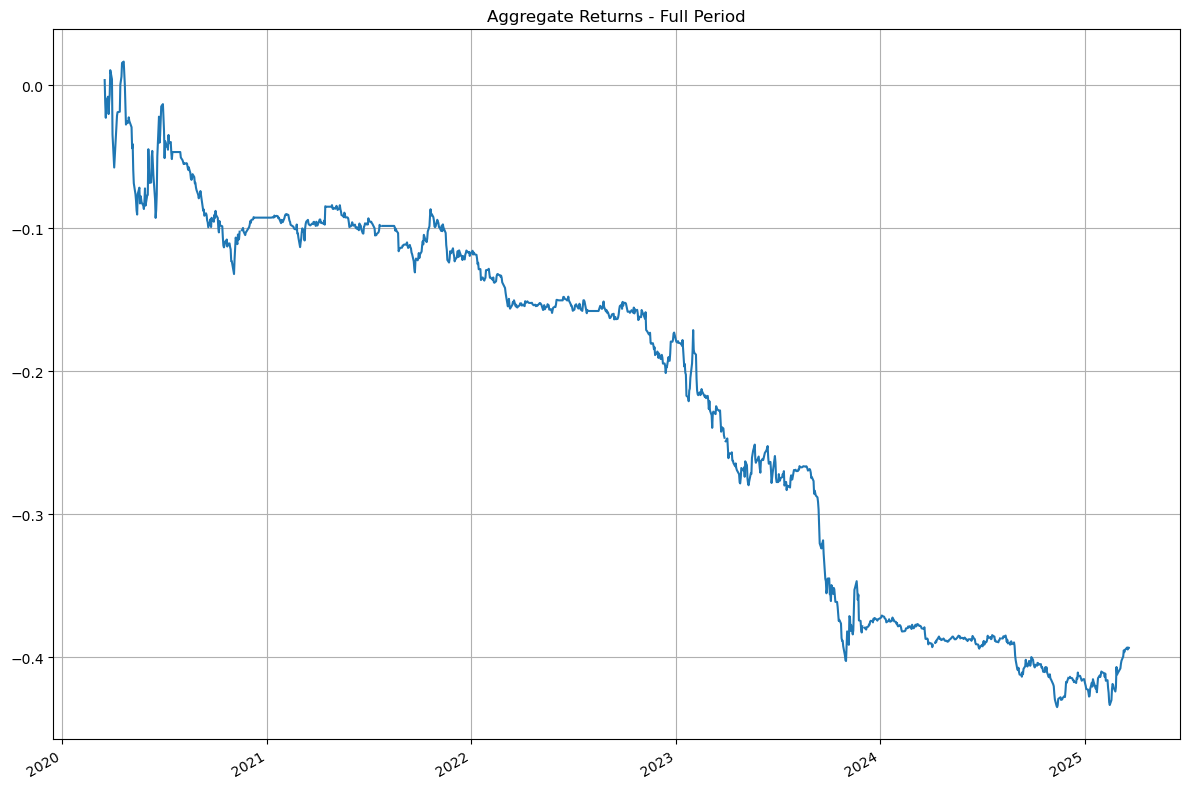

In [16]:
r = pd.concat(all_returns).sort_index()
r_agg = r[~r.index.duplicated(keep='last')].mean(axis=1)

plt.figure(figsize=(12, 8))
((1 + r_agg).cumprod() - 1).plot()
plt.title("Aggregate Returns - Full Period")
plt.grid(True)
plt.tight_layout()
#plt.close()

In [13]:
(
    df
    .groupby('pair')
    .agg({'annualized_return': 'median', 'annualized_volatility': 'median', 'calmar_ratio': 'median'})
    .eval(f'calmar_ratio = (annualized_return - {config.risk_free_rate}) / calmar_ratio')
    .eval(f'sharpe_ratio = (annualized_return - {config.risk_free_rate}) / annualized_volatility')
    #   .query('sharpe_ratio > 0')
    .sort_values('calmar_ratio', ascending=False)
    #.head(10)
)

annualized_return  annualized_volatility  calmar_ratio  \
pair                                                                    
CSNA3_RENT3             0.227638               0.099177      0.042587   
CYRE3_TIMS3             0.115355               0.056175      0.010211   
TIMS3_VBBR3             0.123054               0.063491      0.009494   
TOTS3_VALE3             0.109806               0.055413      0.006660   
NTCO3_PRIO3             0.103937               0.054305      0.003471   
GGBR4_PETR4             0.098669               0.061379     -0.001048   
BPAC11_CYRE3            0.092513               0.060856     -0.003361   
BPAC11_ENGI11           0.087361               0.049679     -0.005720   
BBAS3_TIMS3             0.087597               0.046972     -0.005734   
CPLE6_EQTL3             0.085890               0.052146     -0.007543   
CYRE3_ELET3             0.086833               0.044123     -0.008143   
BBSE3_ITSA4             0.078754               0.045378     -0.008714   
BBSE3_ITUB4             0.077888               0.042973     -0.009834   
BPAC11_TOTS3            0.086265               0.047846     -0.013847   
ALOS3_TOTS3             0.079807               0.042960     -0.014754   
EQTL3_MULT3             0.064065               0.040673     -0.019127   
BPAC11_ELET3            0.061168               0.037866     -0.028155   
KLBN11_PETR4            0.025953               0.035866     -0.127430   

               sharpe_ratio  
pair                         
CSNA3_RENT3        1.286974  
CYRE3_TIMS3        0.273349  
TIMS3_VBBR3        0.363110  
TOTS3_VALE3        0.176953  
NTCO3_PRIO3        0.072503  
GGBR4_PETR4       -0.021684  
BPAC11_CYRE3      -0.123027  
BPAC11_ENGI11     -0.254423  
BBAS3_TIMS3       -0.264050  
CPLE6_EQTL3       -0.270593  
CYRE3_ELET3       -0.298414  
BBSE3_ITSA4       -0.468198  
BBSE3_ITUB4       -0.514553  
BPAC11_TOTS3      -0.287077  
ALOS3_TOTS3       -0.470051  
EQTL3_MULT3       -0.883512  
BPAC11_ELET3      -1.025531  
KLBN11_PETR4      -2.064572

In [14]:
dates['rebalance_date'][i]

'2024-08-02'